In [1]:
import execute_tensor as execute
from execute_tensor import execute as exe

2023-12-27 14:21:08.041945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-27 14:21:08.221422: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-27 14:21:09.113089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.3/lib64
2023-12-27 14:21:09.113184: W te

In [2]:
from Module import custom_layers
import tensorflow as tf

Epoch 1/10


2023-12-27 14:21:41.400299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-27 14:21:41.491279: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f8b3c0114a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-27 14:21:41.491346: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-12-27 14:21:41.507194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-27 14:21:41.668582: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


721/721 [==============================] - 171s 189ms/step - loss: 0.2400 - acc: 0.9225 - auc: 0.7539
Epoch 2/10
721/721 [==============================] - 127s 176ms/step - loss: 0.1739 - acc: 0.9350 - auc: 0.9061
Epoch 3/10
721/721 [==============================] - 126s 174ms/step - loss: 0.1059 - acc: 0.9571 - auc: 0.9740
Epoch 4/10
721/721 [==============================] - 127s 176ms/step - loss: 0.0669 - acc: 0.9733 - auc: 0.9910
Epoch 5/10
721/721 [==============================] - 126s 174ms/step - loss: 0.0441 - acc: 0.9828 - auc: 0.9960
Epoch 6/10
721/721 [==============================] - 126s 174ms/step - loss: 0.0334 - acc: 0.9877 - auc: 0.9977
Epoch 7/10
721/721 [==============================] - 125s 174ms/step - loss: 0.0250 - acc: 0.9905 - auc: 0.9988
Epoch 8/10
721/721 [==============================] - 125s 173ms/step - loss: 0.0203 - acc: 0.9922 - auc: 0.9992
Epoch 9/10
721/721 [==============================] - 126s 175ms/step - loss: 0.0191 - acc: 0.9923 - auc: 0

Found local copy...
Loading...
Done!


Epoch 1/10
37/37 [==============================] - 3s 19ms/step - loss: 0.4140 - acc: 0.8985 - auc: 0.4440 - val_loss: 0.2785 - val_acc: 0.9291 - val_auc: 0.5177
Epoch 2/10
37/37 [==============================] - 0s 13ms/step - loss: 0.2653 - acc: 0.9213 - auc: 0.7351 - val_loss: 0.2749 - val_acc: 0.9291 - val_auc: 0.6231
Epoch 3/10
37/37 [==============================] - 0s 12ms/step - loss: 0.1879 - acc: 0.9247 - auc: 0.8919 - val_loss: 0.2942 - val_acc: 0.9291 - val_auc: 0.6800
Epoch 4/10
37/37 [==============================] - 0s 13ms/step - loss: 0.1400 - acc: 0.9374 - auc: 0.9564 - val_loss: 0.3715 - val_acc: 0.9054 - val_auc: 0.5877
Epoch 5/10
37/37 [==============================] - 0s 12ms/step - loss: 0.0978 - acc: 0.9628 - auc: 0.9839 - val_loss: 0.4604 - val_acc: 0.8986 - val_auc: 0.5751
Epoch 6/10
37/37 [==============================] - 0s 12ms/step - loss: 0.0828 - acc: 0.9763 - auc: 0.9835 - val_loss: 0.5587 - val_acc: 0.9020 - val_auc: 0.5407
Epoch 7/10
37/37 [====

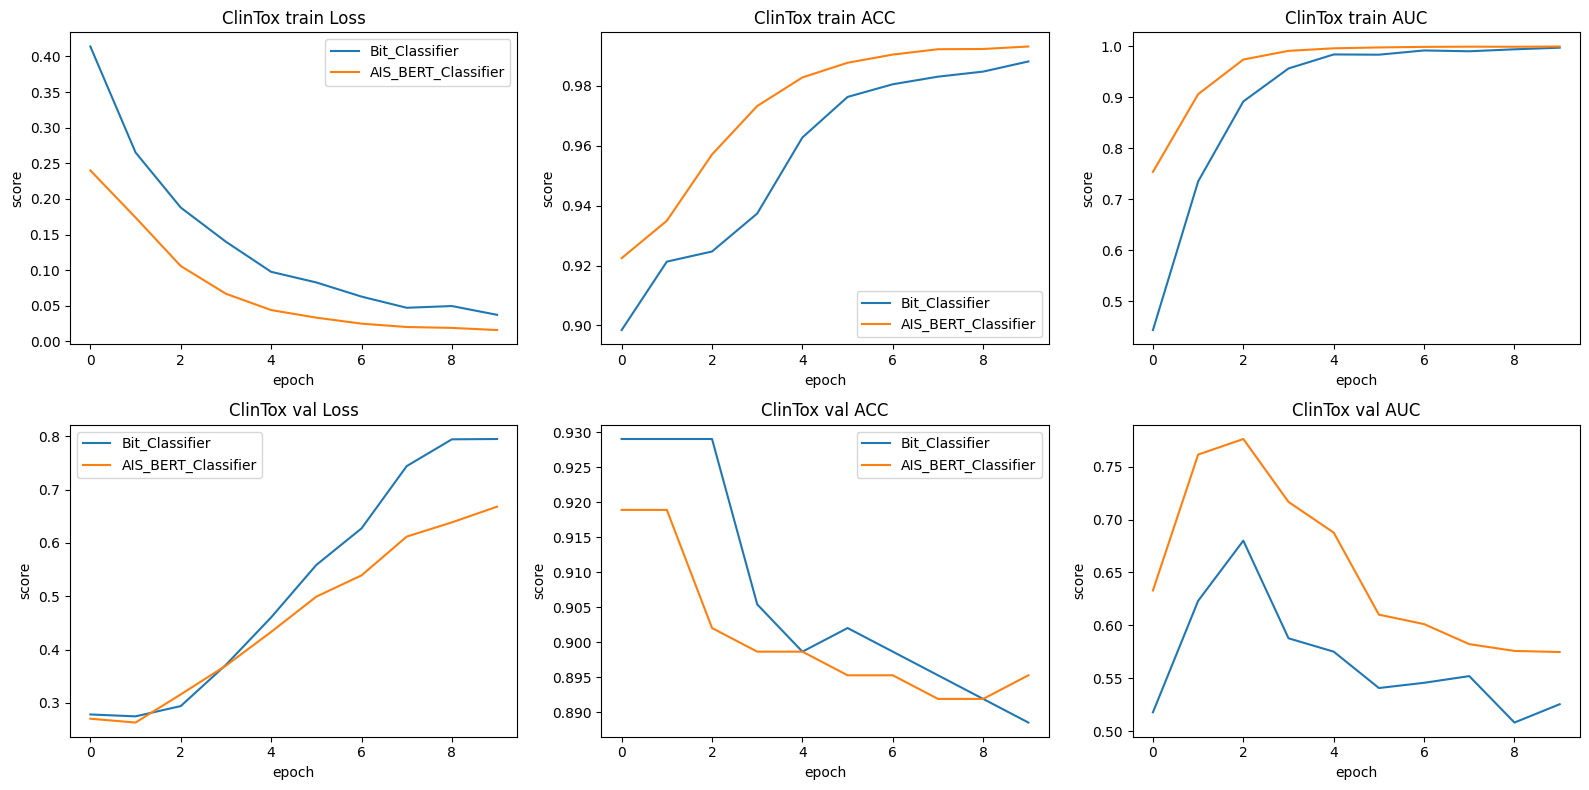

Epoch 1/10
6720/6720 [==============================] - 1209s 175ms/step - loss: 0.5180 - acc: 0.7350 - auc: 0.8183
Epoch 2/10
6720/6720 [==============================] - 1171s 174ms/step - loss: 0.3818 - acc: 0.8255 - auc: 0.9087
Epoch 3/10
6720/6720 [==============================] - 1173s 174ms/step - loss: 0.3042 - acc: 0.8662 - auc: 0.9433
Epoch 4/10
6720/6720 [==============================] - 1171s 174ms/step - loss: 0.2457 - acc: 0.8946 - auc: 0.9633
Epoch 5/10
6720/6720 [==============================] - 1169s 174ms/step - loss: 0.2009 - acc: 0.9154 - auc: 0.9756
Epoch 6/10
6720/6720 [==============================] - 1171s 174ms/step - loss: 0.1633 - acc: 0.9327 - auc: 0.9839
Epoch 7/10
6720/6720 [==============================] - 1163s 173ms/step - loss: 0.1361 - acc: 0.9442 - auc: 0.9887
Epoch 8/10
6720/6720 [==============================] - 1172s 174ms/step - loss: 0.1138 - acc: 0.9543 - auc: 0.9921
Epoch 9/10
6720/6720 [==============================] - 1169s 174ms/step

Found local copy...
Loading...
Done!


Epoch 1/10
337/337 [==============================] - 5s 12ms/step - loss: 0.5845 - acc: 0.6810 - auc: 0.7539 - val_loss: 0.4779 - val_acc: 0.7828 - val_auc: 0.8589
Epoch 2/10
337/337 [==============================] - 4s 11ms/step - loss: 0.4516 - acc: 0.7899 - auc: 0.8716 - val_loss: 0.4375 - val_acc: 0.7988 - val_auc: 0.8825
Epoch 3/10
337/337 [==============================] - 4s 11ms/step - loss: 0.3746 - acc: 0.8373 - auc: 0.9141 - val_loss: 0.4181 - val_acc: 0.8103 - val_auc: 0.8938
Epoch 4/10
337/337 [==============================] - 4s 11ms/step - loss: 0.3132 - acc: 0.8698 - auc: 0.9414 - val_loss: 0.4073 - val_acc: 0.8234 - val_auc: 0.9027
Epoch 5/10
337/337 [==============================] - 4s 11ms/step - loss: 0.2573 - acc: 0.8953 - auc: 0.9602 - val_loss: 0.4277 - val_acc: 0.8256 - val_auc: 0.9059
Epoch 6/10
337/337 [==============================] - 4s 11ms/step - loss: 0.2165 - acc: 0.9134 - auc: 0.9718 - val_loss: 0.4810 - val_acc: 0.8252 - val_auc: 0.9070
Epoch 7/10

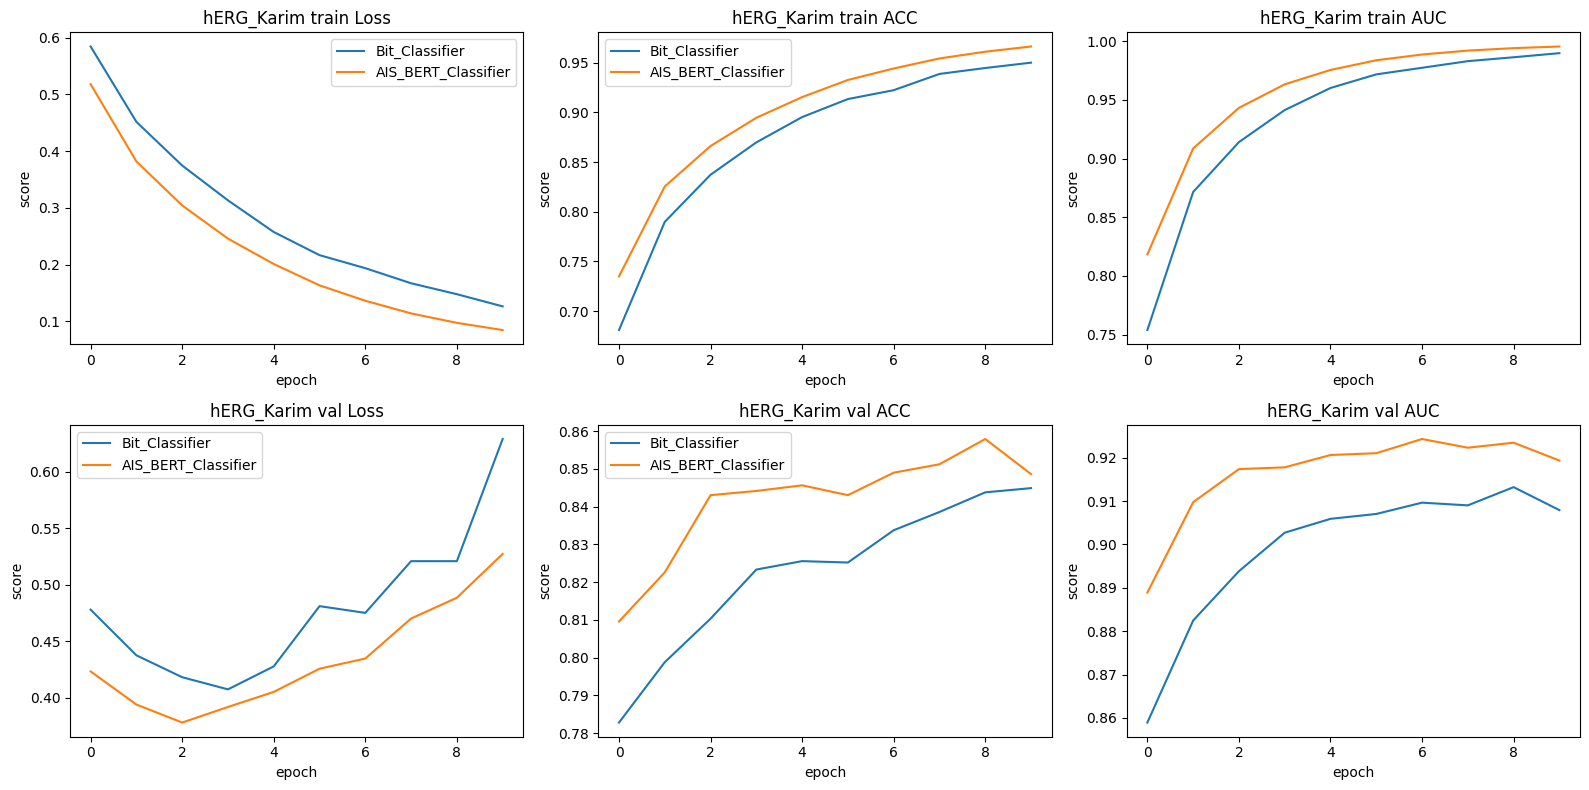

In [3]:
tox_names = ['ClinTox','hERG_Karim']
tokens = ['AIS']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for tox_name in tox_names:
    tox_execute = exe(tox_name,0.2,552,epoch=10,batch=32,tokens=tokens)
    tox_execute.forward()
    globals()['tox_execute_'+tox_name] = tox_execute
    
    models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0]}
    execute.plot_history(models,tox_name,['AIS'])

In [15]:
tox_names = ['ClinTox','hERG_Karim']
tokens = ['AIS']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for tox_name in tox_names:
    tox_execute = execute(tox_name,0.2,552,epoch=10,batch=32,tokens=tokens)
    tox_execute.forward()
    globals()['tox_execute_'+tox_name] = tox_execute
    
    models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0]}
    plot_history(models,tox_name,['AIS'])

2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
9727
9728
9729
9730
9731
9732
9734
9735
9736
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9765
9769
9770
9772
9774
9775
9776
9777
9778
9780
9781
9782
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
18567
18570
18577
19341
19490
19492
19494
19505
19506
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
24347
24348
24349
24350
24351
24352
24353
24354
24355
24356
24357
24358
24359
24360
24361
24362
24363
24364
24365
24366
24667
24668
24669
24670
24671
24672
24673
24674
24675
24676
24677
24678
24679
24680
24681
24682
24683
24684
24685
24686
25727
25728
25729
25730
25731
25732


Found local copy...
Loading...
Done!


Epoch 1/10
37/37 [==============================] - 2s 15ms/step - loss: 0.3759 - acc: 0.9095 - auc: 0.4837 - val_loss: 0.2655 - val_acc: 0.9291 - val_auc: 0.6099
Epoch 2/10
37/37 [==============================] - 0s 10ms/step - loss: 0.2373 - acc: 0.9222 - auc: 0.7823 - val_loss: 0.2616 - val_acc: 0.9291 - val_auc: 0.6783
Epoch 3/10
37/37 [==============================] - 0s 11ms/step - loss: 0.1836 - acc: 0.9230 - auc: 0.9039 - val_loss: 0.2905 - val_acc: 0.9291 - val_auc: 0.7036
Epoch 4/10
37/37 [==============================] - 0s 12ms/step - loss: 0.1287 - acc: 0.9230 - auc: 0.9711 - val_loss: 0.3571 - val_acc: 0.9291 - val_auc: 0.6537
Epoch 5/10
37/37 [==============================] - 0s 12ms/step - loss: 0.1079 - acc: 0.9323 - auc: 0.9786 - val_loss: 0.4751 - val_acc: 0.9122 - val_auc: 0.5721
Epoch 6/10
37/37 [==============================] - 0s 12ms/step - loss: 0.0871 - acc: 0.9399 - auc: 0.9919 - val_loss: 0.4897 - val_acc: 0.9020 - val_auc: 0.5758
Epoch 7/10
37/37 [====

AttributeError: type object 'execute' has no attribute 'plot_history'

IndexError: list index out of range

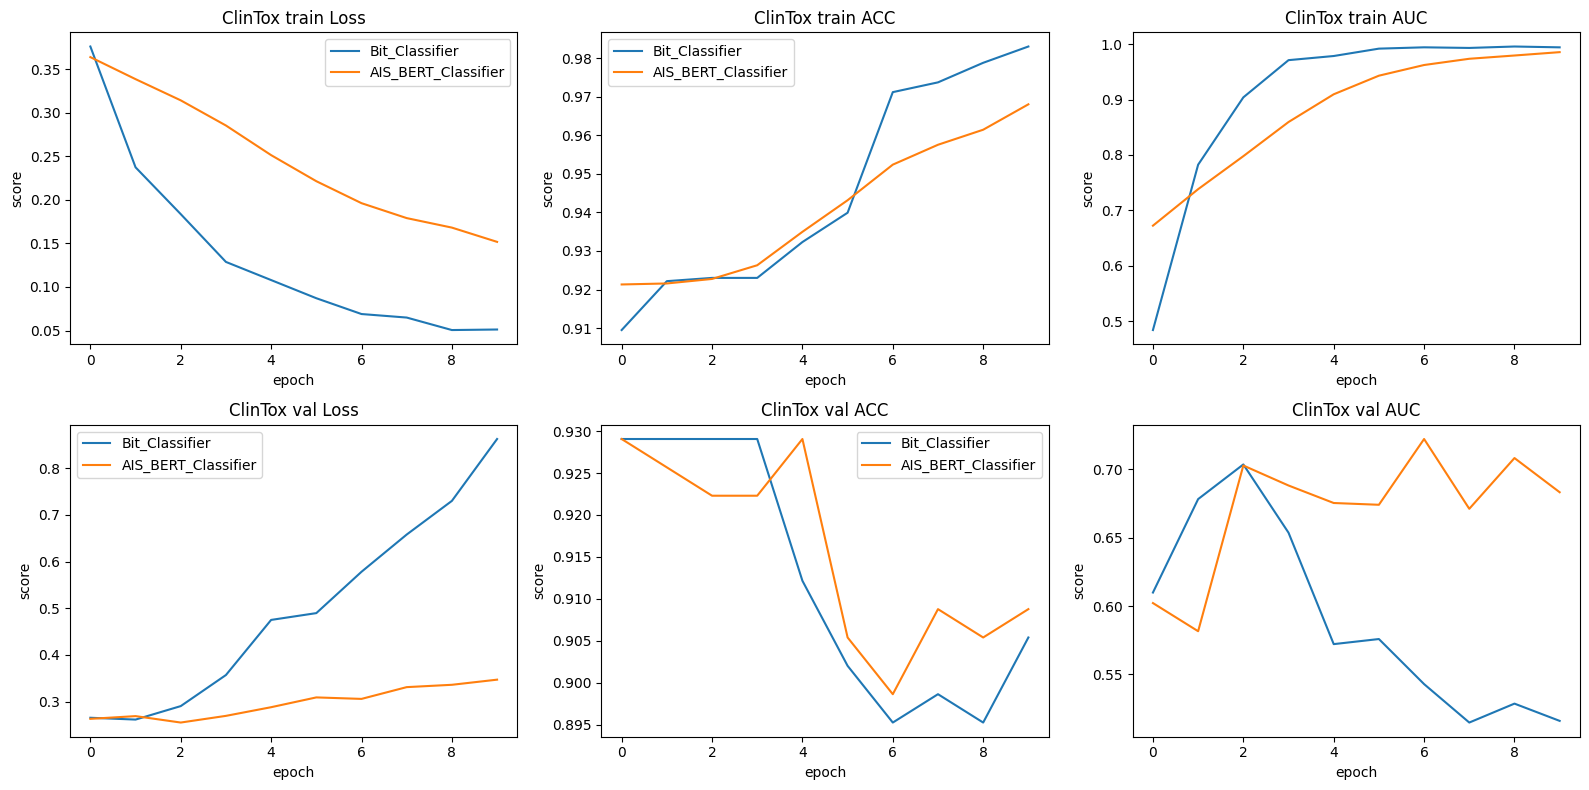

In [16]:
plot_history(models,tox_name,['AIS'])

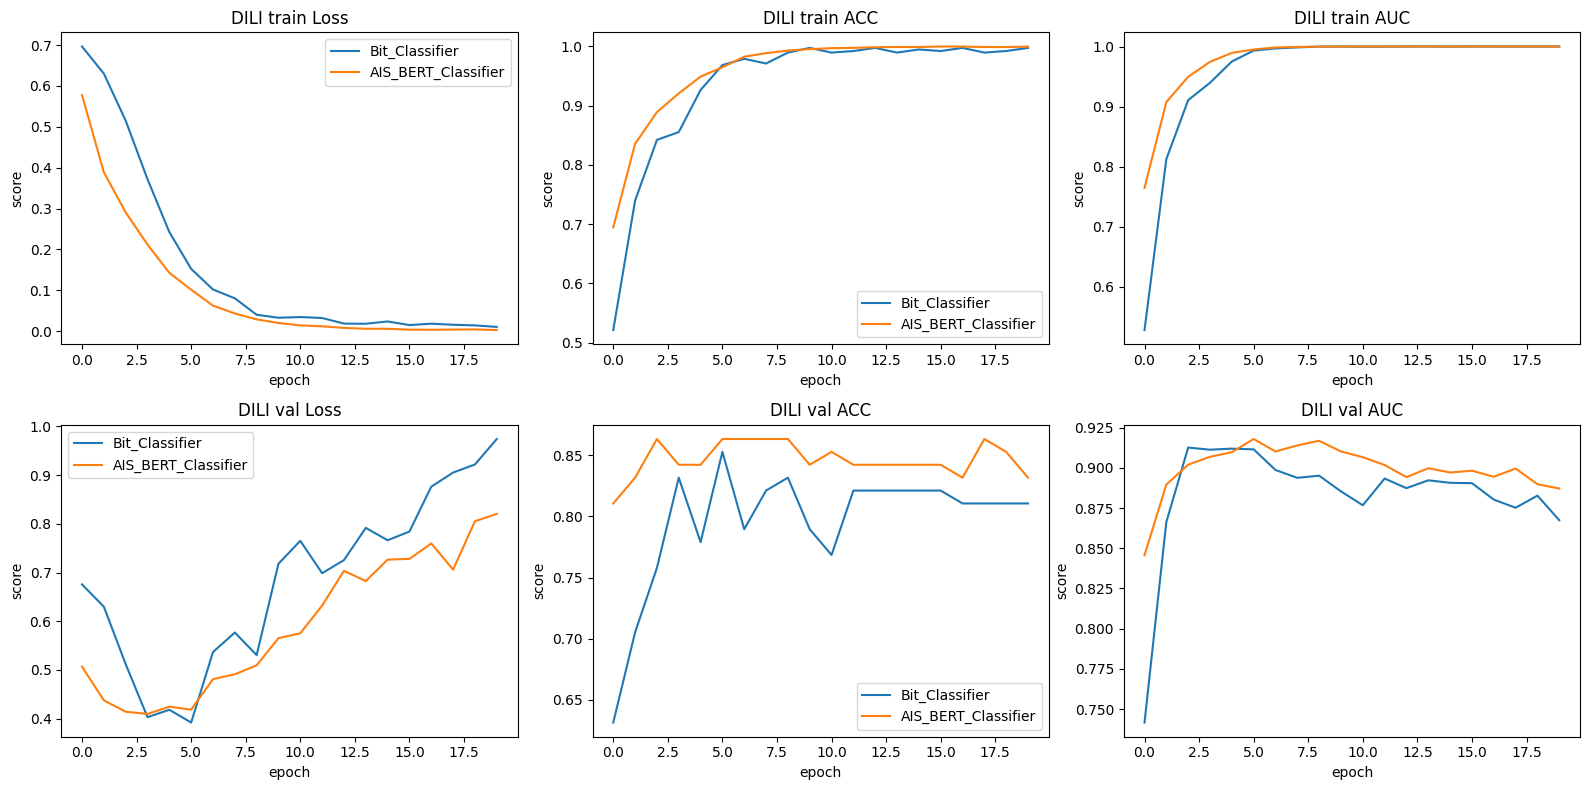

In [5]:
models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0]}
execute.plot_history(models,tox_name,['AIS'])

In [36]:
tox_names = ['hERG','AMES',"Carcinogens_Lagunin",'ClinTox','hERG_Karim']
BERT_names = []

for token in tokens:
    BERT_names.append(token+"_BERT_Classifier")

for tox_name in tox_names:
    tox_execute = exe(tox_name,0.2,552,epoch=20,batch=32,tokens=tokens)
    tox_execute.forward()
    globals()['tox_execute_'+tox_name] = tox_execute
    
    models = {tox_execute.Bit:'Bit_Classifier',tox_execute.BERTs[0]:BERT_names[0],tox_execute.BERTs[1]:BERT_names[1]}
    execute.plot_history(models,tox_name,['SMILE_AIS'])

Epoch 1/20
 93/328 [=======>......................] - ETA: 44s - loss: 0.5295 - acc: 0.7476 - auc: 0.7370

KeyboardInterrupt: 

In [40]:
from Module import custom_layers
import tensorflow as tf

BERT_tensor = custom_layers.BERT_tensor

bert_layer = BERT_tensor(256,6,1024,strat_index=10)

In [41]:
from tensorflow.keras import Model
inputs = tf.keras.layers.Input(shape = (200,),dtype=tf.int32)
outputs = bert_layer(inputs,None)

model = Model(inputs = [inputs], outputs = [outputs])

In [4]:
model.load_weights('./BERT/SMILE/small_tensor_Pre_BERT')
paras = model.get_weights()
#bert_layer.set_weights(paras)

In [16]:
tf.random.normal(shape=[4,2,8], stddev=1.0/(2),name="a1")

<tf.Tensor: shape=(4, 2, 8), dtype=float32, numpy=
array([[[-0.00775212,  0.45365864, -0.17936769, -0.4703564 ,
          0.4652912 ,  0.7072401 ,  0.5939324 ,  0.11876591],
        [ 0.19174264, -0.11060853,  0.4102224 , -0.50522995,
          0.02625731, -0.8348827 , -0.05612738, -0.7516681 ]],

       [[ 0.01920671, -0.7924605 ,  0.5228501 , -0.3693663 ,
         -0.45922825,  0.8958903 ,  0.54488426, -0.03113345],
        [-0.31037605, -0.38833117,  0.4974116 , -1.2441473 ,
         -0.47519082, -0.18440619, -0.28854528,  0.24283227]],

       [[-0.58275616, -0.06202475, -0.6102154 , -0.39340058,
          0.08245464,  0.292252  , -0.6868744 ,  0.43929526],
        [-1.6406686 ,  0.42654002,  0.33202016, -0.18761632,
          0.22903985,  1.0969262 ,  0.01294554,  0.02575068]],

       [[-0.06617777,  0.20796596,  0.11664075, -0.45775336,
         -0.31566215, -0.57306176, -0.09328488, -0.5950716 ],
        [-0.302687  ,  0.11389867,  0.7033505 ,  0.29224932,
          0.26798186,

In [49]:
model.weights[21]

<tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_137/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.05284632, -0.05609024,  0.00136716, ...,  0.02636307,
         0.04918296,  0.01890155],
       [-0.02818584,  0.01652066, -0.05108794, ...,  0.02098642,
         0.01292047,  0.02409455],
       [ 0.00610177,  0.03053891, -0.03941559, ...,  0.01713981,
        -0.0353232 , -0.03636967],
       ...,
       [ 0.03997044, -0.0110015 ,  0.02899386, ...,  0.04587007,
         0.04492278, -0.04974157],
       [ 0.03639524, -0.03050261, -0.00474509, ..., -0.00675311,
        -0.0402522 , -0.04120034],
       [ 0.0136123 , -0.04628688,  0.05162824, ...,  0.01132277,
        -0.01724577, -0.04687847]], dtype=float32)>

In [160]:
import numpy as np
def Task_mask(num_task):
    result = np.zeros([200,200])
    for i in range(num_task):
        for j in range(200):
            if j == i:
                continue
            else:
                result[j][i] = 1
    return result

In [161]:
mask = Task_mask(10)

In [162]:
from tensorflow.keras import Model
from tensorflow.keras.metrics import AUC
Models = []

Input = tf.keras.layers.Input(200,)
hidden = bert_layer(Input,att_mask = mask)
output = hidden[:,0]
#output = tf.keras.layers.Dense(256,activation = 'gelu')(output)
output = tf.keras.layers.Dense(1)(output)
globals()[f'Task{0}_model'] = Model(inputs = [Input],outputs = [output])
globals()[f'Task{0}_model'].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
Models.append(globals()[f'Task{0}_model'])

for i in range(9):
    i = i+1
    Input = tf.keras.layers.Input(200,)
    hidden = bert_layer(Input,att_mask = mask)
    output = hidden[:,i]
    #output = tf.keras.layers.Dense(256,activation = 'gelu')(output)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(output)
    globals()[f'Task{i}_model'] = Model(inputs = [Input],outputs = [output])
    globals()[f'Task{i}_model'].compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
    Models.append(globals()[f'Task{i}_model'])
    

In [31]:
import os
import tensorflow as tf 
from tensorflow.python.client import device_lib
import pickle
import numpy as np
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from sklearn.model_selection import train_test_split
from tdc.single_pred import Tox
from Module import RDK


class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,mask_zero=True)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,mask_zero = True)

    def call(self, x):
        positions = np.array([0]+[0]+[i+2 for i in range(198)])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions    
    
    
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        l2_reg = tf.keras.regularizers.l2(0.01)
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,kernel_regularizer=l2_reg)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs,attention_mask=tf.cast(np.array([[1]+[0]+[1]*198] + [[0]+[1]*199] + [[0]*2+[1]*198]*198),bool))
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
    
    
    
class BERT(tf.keras.layers.Layer):
    def __init__(self,emb_dim,num_heads,ff_dim):
        super(BERT, self).__init__()
        self.encoder = tf.keras.Sequential([TransformerBlock(emb_dim,num_heads,ff_dim) for i in range(8)])
        
        self.embedding = TokenAndPositionEmbedding(200,3500,256)
        self.dense = tf.keras.layers.Dense(250,activation = 'gelu')
        self.classify = tf.keras.layers.Dense(71,activation = 'softmax')
    def call(self, inputs, mask_index=None,pretrain = False):
        if pretrain:
            mask_index = tf.one_hot(mask_index,200)
            boolean_mask = tf.cast(tf.reduce_sum(mask_index,axis=1),bool)
            inputs = tf.cast(inputs,dtype=tf.int32)
        
        inputs = tf.reshape(inputs,[-1,200])
        hidden = self.embedding(inputs)
        
        
        hidden = self.encoder(hidden)
    
        if pretrain:
            output = tf.reshape(hidden,[-1,200,256])
            output = self.dense(output)
            output = layers.Dropout(0.1)(output)
            output = self.classify(output)
            output = tf.boolean_mask(output,boolean_mask)
            return output
        else:
            return hidden


def predict(model,results,len_list):
    index = 0
    res = model.predict(results,verbose=0)
    x_val = []
    for i in len_list:
        temp = res[index:index+i]
        x_val.append(np.average(temp,axis=0))
        index = index+i
    return np.array(x_val)

def similar(a, b):    return SequenceMatcher(None, a, b).ratio()
def most_similar(query,word2idx):

    max = 0
    tokken = ''
    query = query.split(';')
    for i in word2idx.keys():
        key = i.split(';')
        temp2 = 0
        temp3 = 0
        temp1 = similar(query[0],key[0])*10
        try:
            temp2 = similar(query[1],key[1])*2
            temp3 = similar(query[2],key[2])*1
        except:
            pass
        temp = temp1+temp2+temp3
        if temp>max:
            max = temp
            tokken = i
    return tokken

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val,y_true,len_20):
        super().__init__()
        self.x_val = x_val
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_true[index:index+i]))
            index = index+i
        self.len20 = len_20
        self.counts = []
        self.max = 0
        self.y_true = np.array(res)
        self.history = {}
        self.epoch = 0
    def on_epoch_end(self, epoch, logs=None):
        # 에포크가 끝날 때마다 validation 데이터로 모델 평가
        result = predict(self.model,self.x_val,self.len20)
        acc = Accuracy()(self.y_true,np.round(result))
        auc_res = (AUC()(self.y_true,result)).numpy()
        loss = tf.keras.metrics.BinaryCrossentropy()(self.y_true,result)
        auc_res = auc_res
        print(f"     val_acc : {acc},    val_auc : {auc_res} val_loss : {loss}")
        if 'val_acc' not in self.history:
            self.history['val_acc'] = [acc]
        else:
            self.history['val_acc'] += [acc]
        if 'val_auc' not in self.history:
            self.history['val_auc'] = [auc_res]
        else:
            self.history['val_auc'] += [auc_res]
        
        if 'val_loss' not in self.history:
            self.history['val_loss'] = [loss]
        else:
            self.history['val_loss'] += [loss]
        
        self.max = np.max(self.history['val_auc'])
            
        if self.history['val_auc'][-1]<self.max:
            self.counts.append(1)
        else:
            self.counts = []

        self.epoch += 1
        """
        if self.epoch>10 and len(self.counts)>2:
            self.model.stop_training = True"""



inputs = Input(shape = (200,),dtype=tf.int32)
outputs = BERT(256,6,1024)(inputs,None)

model = Model(inputs = [inputs], outputs = [outputs])

#model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')


#BERT_parameters = model.get_weights()[:130]



from tensorflow.keras.layers import Input
from tensorflow.keras import Model

def BERT_model():
    inputs = Input(200,)
    hidden = bert_layer(inputs)
    hidden = hidden[:,0]
    hidden = tf.keras.layers.Dense(256,activation = 'gelu')(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = Model(inputs = [inputs],outputs = [output])
    return result

def Bit_model():
    inputs = Input(2048,)
    hidden = tf.keras.layers.Dense(250,activation = 'relu')(inputs)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    hidden = tf.keras.layers.Dense(40,activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    hidden = tf.keras.layers.Dense(10,activation = 'relu')(hidden)
    hidden = tf.keras.layers.Dropout(0.3)(hidden)
    output = tf.keras.layers.Dense(1,activation = 'sigmoid')(hidden)
    result = Model(inputs = [inputs],outputs = [output])
    return result


    
class tox_process():
    def __init__(self,tox,test_size=0.2,random_state = 1024):
        self.tox_name = tox
        self.size = test_size
        self.seed = random_state
        
        
    def AIS_process(self,plot=False,token = 'AIS',number_of_task = 2):
        if token == 'AIS':
            with open('./Tox_data/AIS_Tox_data/'+self.tox_name,'rb') as file:
                train,label,len_20 = pickle.load(file)[0]
            with open('./BERT/atomInSmile/1M_random_ZINC_word2index.pkl','rb') as file:
                word2idx = pickle.load(file)
        elif token == 'SMILE':
            with open('./Tox_data/SMILE_Tox_data/'+self.tox_name,'rb') as file:
                train,label,len_20 = pickle.load(file)[0]
            with open('./BERT/SMILE/1M_random_ZINC_word2index.pkl','rb') as file:
                word2idx = pickle.load(file)
                
            """elif token == 'SmiletoPE':
                with open('./Tox_data/SmiletoPE/'+self.tox_name,'rb') as file:
                    train,label,len_20 = pickle.load(file)[0]
                with open('./BERT/SmiletoPE/1M_random_ZINC_word2index.pkl','rb') as file:
                    word2idx = pickle.load(file)"""
        else:
            raise
        
        
        
        
        
        if plot:
            temp_dict = {}

            for i in train:
                try:
                    temp_dict[len(i)] = temp_dict[len(i)] + 1
                except:
                    temp_dict[len(i)] = 1
                    
            plt.bar(temp_dict.keys(),temp_dict.values())
        
        except_dict = {}

        for i in train:
            for j in i:
                try:
                    word2idx[j]
                except:
                    try:
                        except_dict[j]
                    except:
                        except_dict[j] = len(except_dict) + 1
        
        similar_dict = {}

        for i in except_dict.keys():
            similar_dict[i] = most_similar(i,word2idx)
            
            
        AIS_train = []
        for index,i in enumerate(train):
            
            temp = []
            if number_of_task == 2:
                temp.append(3)
                temp.append(4)
            else:
                for k in range(number_of_task):
                    temp.append(len(word2idx)+1+k)
            temp.append(1)
            for j in i:
                try:
                    temp.append(word2idx[j])
                except:
                    print('Unexpected : ',j)
                    word2idx[j] = len(word2idx)+1
                    temp.append(word2idx[j])
                """    
                except:
                    if j != '/[H]':
                        print(j,i)
                        word_sim = similar_dict[j]
                        if word_sim != '':
                            temp.append(word2idx[word_sim])
                    else:
                        pass"""
            if len(temp)>1:
                AIS_train.append(temp)

        AIS_train = tf.keras.preprocessing.sequence.pad_sequences(AIS_train, padding='post', maxlen=200)
        temp_x = []
        temp_y = []
        index = 0
        for i in len_20:
            temp_x.append(AIS_train[index:index+i])
            temp_y.append(label[index:index+i])
            index = index+i



        x_train, x_val, y_train, y_val,_,len_20 = train_test_split(temp_x,temp_y,len_20, test_size=self.size,random_state=self.seed)
        
        def flatten(data):
            temp = []
            for i in data:
                temp+=list(i)
            data = np.array(temp)
            return data
        x_train = flatten(x_train)
        x_val = flatten(x_val)
        y_val = flatten(y_val)
        y_train = flatten(y_train)
        return x_train, x_val, y_train, y_val,len_20
    
    def bit_precess(self):
        train,tox_info = Tox(name=self.tox_name).get_data(format='DeepPurpose')
        bit_string = RDK.smile_to_RDkit(train,2048)
        x_train_NN,x_val_NN,y_train_NN,y_val_NN = train_test_split(np.array(bit_string)/1.,np.array(tox_info)/1.,test_size=self.size,random_state=self.seed)
        return x_train_NN,x_val_NN,y_train_NN,y_val_NN
    


class execute():
    def __init__(self,tox,test_size,split_seed,epoch = 20,batch=32*20,tokens = ['AIS']):
        super().__init__()
        self.tox = tox
        self.size = test_size
        self.seed = split_seed
        self.epoch = epoch
        self.BERTs = []
        self.batch_size = batch
        Bit_Classifier = Bit_model()
        self.Bit = Bit_Classifier
        #model.load_weights('./BERT/atomInSmile/F_Random_ZINC_L_model_weights.h5')
        self.tokens = tokens
        self.BERT_parameters = []
        
        for token in tokens:
            if token == 'AIS':
                model.load_weights('./BERT/atomInSmile/Pre_BERT.h5')
            elif token == 'SMILE':
                model.load_weights('./BERT/SMILE/Pre_BERT.h5')
            elif token == 'SmiletoPE':
                model.load_weights('./BERT/SmiletoPE/F_Random_ZINC_L_model_weights.h5')
            else:
                raise
            self.BERTs.append(BERT_model())
            self.BERT_parameters.append(model.get_weights()[:130])
    def forward(self,set_weights=True):
        if set_weights:
            for index,token in enumerate(self.tokens):
                BERT_parameter = self.BERT_parameters[index]
                self.BERTs[index].layers[1].set_weights(BERT_parameter)
        

        for index,token in enumerate(self.tokens): 
            process = tox_process(self.tox, self.size, self.seed)
            x_train, x_val, y_train, y_val,len_20 = process.AIS_process(token = token)
            
            temp_BERT = self.BERTs[index]
            
            val_call = CustomCallback(x_val,y_val,len_20)
            
            temp_BERT.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
            
            hist1 = temp_BERT.fit(x_train,y_train,batch_size=self.batch_size,epochs=self.epoch,callbacks=[val_call])
            
        
            temp_BERT.history.history['val_loss'] = val_call.history['val_loss']
            temp_BERT.history.history['val_acc'] = val_call.history['val_acc']
            temp_BERT.history.history['val_auc'] = val_call.history['val_auc']
            
        x_train_NN,x_val_NN,y_train_NN,y_val_NN = process.bit_precess()
        self.Bit.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics=['acc',AUC(name='auc')])
        hist2 = self.Bit.fit(x_train_NN,y_train_NN,batch_size=32,epochs=self.epoch,validation_data=(x_val_NN,y_val_NN))
        
        
        
import matplotlib.pyplot as plt
def plot_history(models,tox_name,token=['AIS']):
    plt.figure(figsize=(16,8))
    plt.subplot(2, 3, 1)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['loss']))],model.history.history['loss'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_loss']))],val_call2.history.history['val_loss'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' train Loss')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 2)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['acc']))],model.history.history['acc'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_acc']))],val_call2.history.history['val_acc'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' train ACC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 3)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['auc']))],model.history.history['auc'],label=models[model])
    plt.title(tox_name + ' train AUC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.subplot(2, 3, 4)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_loss']))],model.history.history['val_loss'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_loss']))],val_call2.history.history['val_loss'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' val Loss')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.subplot(2, 3, 5)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_acc']))],model.history.history['val_acc'],label=models[model])
    #plt.plot([i for i in range(len(val_call2.history.history['val_acc']))],val_call2.history.history['val_acc'],label = 'BERT_Norm acc data')
    plt.title(tox_name + ' val ACC')
    plt.xlabel('epoch')
    plt.ylabel('score')

    plt.legend('epoch')
    plt.ylabel('score')

    plt.legend()
    plt.tight_layout() 
    plt.subplot(2, 3, 6)
    for model in models.keys():
        plt.plot([i for i in range(len(model.history.history['val_auc']))],model.history.history['val_auc'],label=models[model])
    plt.title(tox_name + ' val AUC')
    plt.xlabel('epoch')
    plt.ylabel('score')
    
    plt.savefig(f'./Results/{token[0]}_{token[1]}_Tox_result/'+tox_name+'.png')
    
    plt.show()
    
    
    
    

In [10]:
A = MultiheadAttention_tensor(256,6)

NameError: name 'MultiheadAttention_tensor' is not defined

In [156]:
paras[22]

array([-4.60225940e-02,  3.66384275e-02,  1.31827099e-02,  1.32841524e-02,
       -8.37192498e-03,  4.05461788e-02, -5.60071766e-02, -6.80391118e-03,
       -3.43132168e-02,  2.47003715e-02,  2.91137435e-02, -7.44386539e-02,
       -1.43738566e-02,  5.58926091e-02,  2.93241050e-02, -1.98545251e-02,
        1.30517525e-03, -3.81982401e-02, -1.91494413e-02, -4.14413773e-02,
       -3.22824679e-02,  1.44425677e-02, -2.45527215e-02, -7.40738492e-03,
       -5.97070865e-02,  1.57228839e-02, -1.44467540e-02, -7.14673996e-02,
       -1.41337439e-01,  1.58305615e-02, -1.02073409e-01, -2.12556906e-02,
       -3.90909947e-02,  1.31140053e-02, -8.03124718e-03, -1.29712196e-02,
        4.47155163e-03, -2.88221557e-02,  6.85687002e-04,  1.05693925e-03,
       -1.81404892e-02, -1.85944438e-01, -4.72638272e-02,  1.08140912e-02,
       -7.63323484e-03,  1.60175323e-01, -3.57052051e-02,  6.69359462e-03,
        1.12000089e-02, -9.13664699e-02, -4.01136931e-03,  1.74422950e-01,
        7.24676903e-03, -

In [9]:
Task0_model.weights[22]

NameError: name 'Task0_model' is not defined

In [48]:
import random
Tox_names = ['LD50_Zhu','AMES','ClinTox','hERG','DILI','Skin_Reaction','hERG_Karim']
x_trains = [] 
y_trains = []
x_vals = []
y_vals = []
len_20s = []
task_labels = []
val_task = []
for index1,i in enumerate(Tox_names):
    try:
        
        A = tox_process(i)
        x_train,x_val,y_train,y_val,len_20 = A.AIS_process(number_of_task=10,token='AIS')
        index = 0
        res = []
        for i in len_20:
            res.append(np.average(y_val[index:index+i]))
            index = index+i
        y_val = np.array(res)
        if index1 == 0:
            x_train,x_val,y_train,y_val,len_20 = x_train[:10000],x_val[:np.sum(len_20[:100])],y_train[:10000],y_val[:100],len_20[:100]
        
        temp_zip = list(zip(x_train,y_train))
        random.shuffle(temp_zip)
        x_train,y_train = zip(*temp_zip)
        
        
        temp_x_trains = x_train[:int(len(x_train)/32)*32]
        temp_x_trains = np.reshape(temp_x_trains,[-1,32,200])
        x_trains += list(temp_x_trains) + list(x_train[int(len(x_train)/32)*32:])
        
        temp_y_trains = y_train[:int(len(y_train)/32)*32]
        temp_y_trains = np.reshape(temp_y_trains,[-1,32])
        tmp = list(temp_y_trains) + list(y_train[int(len(y_train)/32)*32:])
        y_trains += tmp
        

        
        task_labels+=[index1]*len(tmp)
        
        
        y_vals.append(y_val)
        x_vals.append(x_val)
        len_20s.append(len_20)
        val_task.append(index1)
    except:
        pass

In [49]:
import random

temp_zip = list(zip(x_trains,y_trains,task_labels))
random.shuffle(temp_zip)

x_trains,y_trains,task_labels = zip(*temp_zip)

In [50]:
len(x_trains)

12124

In [137]:
Task0_model.weights[11]

<tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-5.6754856e-04, -1.1891476e-03, -1.3037531e-03,  2.6366295e-04,
         -2.7382741e-04, -1.8277478e-03,  1.3956104e-03, -7.3822698e-04],
        [ 1.1844243e-04,  2.5890590e-04, -6.2645721e-04,  1.4471593e-03,
         -4.6146111e-04, -2.6495091e-04,  7.7775877e-04, -1.8288684e-04]],

       [[ 1.0912609e-03,  1.9805619e-04,  2.3583364e-04, -4.1367058e-04,
          1.1021923e-03, -7.4173661e-04, -1.3030635e-03,  4.8714218e-04],
        [-1.4949432e-05,  1.2469745e-03, -5.3502863e-05,  6.6767231e-04,
         -1.1898801e-03,  9.5842720e-04,  1.3242890e-04, -6.4758700e-05]],

       [[-1.3838063e-03, -8.7942218e-04, -1.1789886e-03,  1.1658726e-03,
          3.6092298e-04,  8.9556124e-04, -1.5972593e-03,  3.6510671e-04],
        [-1.3491728e-04,  7.3530461e-04,  3.2422782e-04, -1.0036802e-03,
         -9.0075406e-04, -7.0903428e-05,  3.7156671e-04,  2.0821248e-03]],

       [[-9.2364143e-04,  5.6725054e-04, -6.0938520e-0

In [138]:
paras[11]

array([[[-5.6754856e-04, -1.1891476e-03, -1.3037531e-03,  2.6366295e-04,
         -2.7382741e-04, -1.8277478e-03,  1.3956104e-03, -7.3822698e-04],
        [ 1.1844243e-04,  2.5890590e-04, -6.2645721e-04,  1.4471593e-03,
         -4.6146111e-04, -2.6495091e-04,  7.7775877e-04, -1.8288684e-04]],

       [[ 1.0912609e-03,  1.9805619e-04,  2.3583364e-04, -4.1367058e-04,
          1.1021923e-03, -7.4173661e-04, -1.3030635e-03,  4.8714218e-04],
        [-1.4949432e-05,  1.2469745e-03, -5.3502863e-05,  6.6767231e-04,
         -1.1898801e-03,  9.5842720e-04,  1.3242890e-04, -6.4758700e-05]],

       [[-1.3838063e-03, -8.7942218e-04, -1.1789886e-03,  1.1658726e-03,
          3.6092298e-04,  8.9556124e-04, -1.5972593e-03,  3.6510671e-04],
        [-1.3491728e-04,  7.3530461e-04,  3.2422782e-04, -1.0036802e-03,
         -9.0075406e-04, -7.0903428e-05,  3.7156671e-04,  2.0821248e-03]],

       [[-9.2364143e-04,  5.6725054e-04, -6.0938520e-04,  4.0195780e-04,
         -1.3983862e-04, -1.5129207e-03

In [109]:
for i in range(len(Task0_model.weights)):
    print('index : ',i)
    print(Task0_model.weights[i] == paras[i])

index :  0
tf.Tensor(
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]], shape=(256, 512), dtype=bool)
index :  1
tf.Tensor(
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 Fal

tf.Tensor(
[[[ True  True  True  True  True  True  True  True]
  [ True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True]
  [ True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True]
  [ True  True  True  True  True  True  True  True]]

 [[ True  True  True  True  True  True  True  True]
  [ True  True  True  True  True  True  True  True]]], shape=(4, 2, 8), dtype=bool)
index :  193
tf.Tensor(
[[[[ True  True  True  True]
   [ True  True  True  True]]

  [[ True  True  True  True]
   [ True  True  True  True]]]


 [[[ True  True  True  True]
   [ True  True  True  True]]

  [[ True  True  True  True]
   [ True  True  True  True]]]


 [[[ True  True  True  True]
   [ True  True  True  True]]

  [[ True  True  True  True]
   [ True  True  True  True]]]


 [[[ True  True  True  True]
   [ True  True  True  True]]

  [[ True  True  True  True]
   [ True  True  True  True]]]], shape=(4, 2, 2, 4), dty

IndexError: list index out of range

In [61]:
from tqdm import tqdm
import sys
batch_size = 32
epochs = 25


loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_fn_reg = tf.keras.losses.MeanSquaredError()
acc = np.array([0])



for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_res = [[] for i in range(len(Tox_names))]
    loss_list = [[] for i in range(len(Tox_names))]
    acc_list = [[] for i in range(len(Tox_names))]
    auc_list = [[] for i in range(len(Tox_names))]
    for i in range(0, len(temp_zip)):
        batch_images = x_trains[i]
        batch_images = tf.reshape(batch_images,[-1,200])
        batch_labels = y_trains[i]
        batch_labels = tf.reshape(batch_labels,[-1])
        task = task_labels[i]

        if task != 0:
            with tf.GradientTape() as tape:
                model = globals()[f'Task{task}_model']
                logits = model(batch_images)
                logits = tf.reshape(logits,[-1])
                train_res[task]+=list(logits)
                loss_value = loss_fn(batch_labels, logits)
                acc = tf.keras.metrics.Accuracy()(np.round(train_res[task]),batch_labels)
                auc = tf.keras.metrics.AUC()(batch_labels,np.array(train_res[task]))
                auc = auc.numpy()
                loss_value_avg = loss_fn(batch_labels, np.array(train_res[task]))
                loss_list[task].append(loss_value_avg)
                acc_list[task].append(acc)
                auc_list[task].append(auc)
                
            grads = tape.gradient(loss_value, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

        else:
            with tf.GradientTape() as tape:
                model = globals()[f'Task{task}_model']
                logits = model(batch_images)
                logits = tf.reshape(logits,[-1])
                train_res[task]+=list(logits)
                loss_value = loss_fn_reg(logits,batch_labels)
                loss_value_avg = loss_fn_reg(batch_labels, np.array(train_res[task]))
                loss_list[task].append(loss_value_avg)
                acc = tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)(np.array(train_res[task]),batch_labels)
                acc_list[task].append(acc)
            
            grads = tape.gradient(loss_value, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        for l in range(len(Tox_names)):
            
            temp_loss = np.average(loss_list[l][-10:])
            temp_acc = np.average(acc_list[l][-10:])
            temp_auc = np.average(auc_list[l][-10:])
            if l == 0:
                text = "\rSteps : {} Task : {}, Loss: {:.4f}, acc : {:.4f}, auc : {:.4f}".format(i,l,temp_loss,temp_acc,temp_auc)
            else:
                text += "     Task : {}, Loss: {:.4f}, acc : {:.4f}, auc : {:.4f}".format(l,temp_loss,temp_acc,temp_auc)
            sys.stdout.write(text)
            sys.stdout.flush()
    # 각 에포크 종료 후 평가
    for temp_index,j in enumerate(val_task):
        j = j
        val_res = predict(globals()[f'Task{j}_model'],x_vals[temp_index],len_20s[temp_index])
        if j != 0:
            acc = tf.keras.metrics.Accuracy()(y_vals[temp_index],np.round(val_res))
            auc_res = (AUC()(y_vals[temp_index],val_res)).numpy()
            loss = tf.keras.metrics.BinaryCrossentropy()(y_vals[temp_index],val_res)
            
            print(f'\nTask is {Tox_names[temp_index]}')
            print(f"Test accuracy: {acc}")
            print(f"Test AUC: {auc_res}")
            print(f"Test loss: {loss}\n")
        else:
            loss = tf.keras.metrics.MeanSquaredError()(y_vals[temp_index],val_res)
            print(f'\nTask is {Tox_names[temp_index]}')
            print(f"\nTest MSE:{loss}")

Epoch 1/25


ValueError: No gradients provided for any variable: (['bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_200/kernel:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_200/bias:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_201/kernel:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_201/bias:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_202/kernel:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_202/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_203/kernel:0', 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_203/bias:0', 'dense_204/kernel:0', 'dense_204/bias:0', 'dense_205/kernel:0', 'dense_205/bias:0', 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_96/gamma:0', 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_96/beta:0', 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_97/gamma:0', 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_97/beta:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_206/kernel:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_206/bias:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_207/kernel:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_207/bias:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_208/kernel:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_208/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_209/kernel:0', 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_209/bias:0', 'dense_210/kernel:0', 'dense_210/bias:0', 'dense_211/kernel:0', 'dense_211/bias:0', 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_98/gamma:0', 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_98/beta:0', 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_99/gamma:0', 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_99/beta:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_212/kernel:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_212/bias:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_213/kernel:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_213/bias:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_214/kernel:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_214/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_215/kernel:0', 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_215/bias:0', 'dense_216/kernel:0', 'dense_216/bias:0', 'dense_217/kernel:0', 'dense_217/bias:0', 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_100/gamma:0', 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_100/beta:0', 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_101/gamma:0', 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_101/beta:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_218/kernel:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_218/bias:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_219/kernel:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_219/bias:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_220/kernel:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_220/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_221/kernel:0', 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_221/bias:0', 'dense_222/kernel:0', 'dense_222/bias:0', 'dense_223/kernel:0', 'dense_223/bias:0', 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_102/gamma:0', 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_102/beta:0', 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_103/gamma:0', 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_103/beta:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_224/kernel:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_224/bias:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_225/kernel:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_225/bias:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_226/kernel:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_226/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_227/kernel:0', 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_227/bias:0', 'dense_228/kernel:0', 'dense_228/bias:0', 'dense_229/kernel:0', 'dense_229/bias:0', 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_104/gamma:0', 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_104/beta:0', 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_105/gamma:0', 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_105/beta:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_230/kernel:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_230/bias:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_231/kernel:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_231/bias:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_232/kernel:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_232/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_233/kernel:0', 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_233/bias:0', 'dense_234/kernel:0', 'dense_234/bias:0', 'dense_235/kernel:0', 'dense_235/bias:0', 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_106/gamma:0', 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_106/beta:0', 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_107/gamma:0', 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_107/beta:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_236/kernel:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_236/bias:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_237/kernel:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_237/bias:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_238/kernel:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_238/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_239/kernel:0', 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_239/bias:0', 'dense_240/kernel:0', 'dense_240/bias:0', 'dense_241/kernel:0', 'dense_241/bias:0', 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_108/gamma:0', 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_108/beta:0', 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_109/gamma:0', 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_109/beta:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_242/kernel:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_242/bias:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_243/kernel:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_243/bias:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_244/kernel:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_244/bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'a1:0', 'a2:0', 'a3:0', 'a4:0', 'bias:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_245/kernel:0', 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_245/bias:0', 'dense_246/kernel:0', 'dense_246/bias:0', 'dense_247/kernel:0', 'dense_247/bias:0', 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_110/gamma:0', 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_110/beta:0', 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_111/gamma:0', 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_111/beta:0', 'bert_tensor_2/token_and_position_embedding_mask_2/embedding_12/embeddings:0', 'bert_tensor_2/token_and_position_embedding_mask_2/embedding_13/embeddings:0', 'dense_255/kernel:0', 'dense_255/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_200/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.03007919, -0.02788851,  0.0238134 , ..., -0.02646073,
         0.11985314,  0.13528344],
       [ 0.07247611,  0.04557611, -0.00417436, ...,  0.04986896,
         0.05404083,  0.12063856],
       [ 0.03894517,  0.00783644, -0.14037015, ..., -0.10928454,
        -0.02965086, -0.00646296],
       ...,
       [-0.08131576,  0.04874382,  0.05187804, ...,  0.00876527,
        -0.0106744 ,  0.14463915],
       [-0.01617284,  0.02692387, -0.02557441, ..., -0.14626922,
         0.08644266,  0.05152861],
       [ 0.13154782,  0.06447724, -0.01801104, ...,  0.1957129 ,
        -0.0257476 , -0.01394769]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_200/bias:0' shape=(512,) dtype=float32, numpy=
array([-0.00732768,  0.12990709, -0.08146738,  0.01740681,  0.09348314,
       -0.04256514,  0.15611926, -0.01020334, -0.04666937,  0.07722071,
        0.13861825,  0.1801544 ,  0.03427048, -0.01435273, -0.09934188,
       -0.09843148,  0.12159089, -0.08785195, -0.01003184,  0.09086321,
        0.04586265, -0.04417454, -0.0308292 ,  0.13096812, -0.07002331,
        0.07922725,  0.06024878,  0.033745  ,  0.09507133, -0.00075979,
       -0.01832116,  0.14148624, -0.10783596,  0.00290864, -0.1291308 ,
       -0.03676054,  0.12013017, -0.11374556, -0.0745587 ,  0.08107193,
        0.14009643, -0.12112743, -0.0665517 , -0.12921087, -0.06487014,
        0.10413506,  0.07191706,  0.06493165,  0.15523176,  0.12704606,
       -0.11932446,  0.07149381,  0.02360978, -0.00463762, -0.10595579,
        0.01456008, -0.05345147, -0.02923456, -0.01214521, -0.07215062,
       -0.02880116, -0.14212382, -0.06293519,  0.13157688,  0.08827969,
        0.0051874 ,  0.1057677 , -0.11828536, -0.04147433,  0.01030344,
        0.04093758,  0.11476745,  0.1739654 ,  0.01933796, -0.13051628,
        0.17289762, -0.00032327, -0.09761886, -0.13274044, -0.08995017,
        0.08296182, -0.11917252,  0.09644278, -0.0527586 ,  0.04680214,
        0.06115387,  0.06543435, -0.12930056,  0.06169235, -0.05410489,
       -0.03036345, -0.09979054, -0.10530844,  0.06143177,  0.18541467,
        0.06624061, -0.00048227,  0.11184669,  0.10703689, -0.04884401,
        0.04669332, -0.15855819, -0.0810233 ,  0.13795364, -0.09496336,
       -0.10911004, -0.00718823,  0.01184309,  0.08619717, -0.05527584,
        0.01142937,  0.10465761, -0.04328407,  0.1923756 , -0.08811662,
        0.12760426,  0.06223023, -0.01126162,  0.1787474 ,  0.16782351,
       -0.03723449, -0.04030633, -0.11517707, -0.05028569,  0.06716672,
        0.09043138, -0.06558871,  0.06334237,  0.08594952, -0.02674269,
       -0.12852581,  0.16558811, -0.06452429, -0.07303836,  0.04249327,
        0.06360626, -0.26222658, -0.09328625, -0.02982266,  0.01397521,
        0.04446556,  0.19700657,  0.02595164, -0.04168689,  0.01918933,
        0.05084435,  0.0822401 , -0.02106946, -0.10534176, -0.10602767,
       -0.08895244,  0.1291749 ,  0.01998837, -0.16079316,  0.13353272,
        0.04478624,  0.08449201, -0.00612489, -0.15531068,  0.10849246,
        0.08324245,  0.08784985, -0.09991169, -0.07808191,  0.08663592,
       -0.01875036,  0.14019147, -0.04504721, -0.1194324 ,  0.12083308,
       -0.10719852,  0.11116312, -0.0200576 ,  0.14926618,  0.10295603,
       -0.09072898, -0.13332434, -0.10786098, -0.08769805,  0.21057633,
        0.0884783 , -0.06190103,  0.11530045,  0.10369063, -0.04962599,
       -0.08204185,  0.12480279, -0.05982229,  0.16755144, -0.0616836 ,
       -0.07863474,  0.06676842, -0.05873522,  0.01157987,  0.09898515,
       -0.03687988, -0.14885813, -0.12463079, -0.11119191, -0.11071385,
        0.01132874, -0.03853016,  0.10054312, -0.12025476,  0.1475296 ,
       -0.13989592, -0.02511753,  0.14003998, -0.09498626,  0.02127421,
        0.14459617,  0.06582712,  0.18489733, -0.12307837, -0.07684214,
        0.08214385, -0.12344083, -0.08783871,  0.10845217,  0.08353294,
        0.07195603, -0.07978411,  0.09018855, -0.0857766 , -0.13393113,
       -0.00204137, -0.02018028, -0.02445385,  0.16711898, -0.05371709,
        0.14890577, -0.1271748 , -0.05098572, -0.03956597,  0.12241987,
        0.12982242, -0.09841467,  0.02883495,  0.03526516,  0.05030383,
        0.12477409,  0.13327682,  0.12312134,  0.08336496,  0.00781332,
       -0.09621646, -0.14206907,  0.05356526, -0.09257809, -0.1250669 ,
        0.13962297,  0.15421362, -0.10138752, -0.07423189, -0.00489682,
       -0.0718507 , -0.02802398,  0.07786275, -0.23484597,  0.00503461,
        0.16918504, -0.09352469,  0.0215833 , -0.01035242, -0.00287078,
        0.00981118,  0.03539434, -0.21227819,  0.08404097, -0.15620898,
       -0.06045082, -0.21957082, -0.12026909, -0.0870004 ,  0.02263556,
        0.09211378, -0.11205442,  0.05882128, -0.15296528, -0.14037117,
        0.14423957, -0.15030186, -0.13446502,  0.02500595,  0.09240792,
        0.13552392,  0.18374912,  0.01832321,  0.07252431, -0.06749994,
        0.02884327, -0.02223212,  0.08495226,  0.23599876,  0.14960957,
        0.06923416, -0.14145873, -0.04577093, -0.10043237, -0.08902889,
       -0.06920028,  0.16822825,  0.22668135, -0.08820849,  0.1851066 ,
       -0.12862234,  0.18862143,  0.0450568 ,  0.01319899,  0.06596953,
        0.03347745, -0.1966563 , -0.17360339,  0.09619725,  0.07145102,
       -0.01497608,  0.07593308, -0.18860762, -0.04476567, -0.04283935,
        0.06247107, -0.11685469, -0.03003141,  0.16340467,  0.05938074,
       -0.06515368, -0.06473933, -0.132862  , -0.15688357, -0.14124027,
        0.04587726,  0.01293822, -0.04632754, -0.08503493,  0.14037533,
        0.13882113,  0.01362641,  0.05239422,  0.07957778,  0.05129911,
        0.08194983, -0.05228353, -0.01242796,  0.05132499, -0.03841329,
       -0.10071746,  0.16424116,  0.03626634,  0.00210628,  0.03321476,
        0.02394858, -0.00378399,  0.12822461,  0.01005576,  0.11274762,
       -0.02163864,  0.1279715 ,  0.02612739, -0.1309508 , -0.08216397,
       -0.04594833,  0.03814713, -0.00952021,  0.12865908,  0.01669717,
       -0.08382951,  0.08064399,  0.02229244,  0.13948987,  0.08849043,
       -0.16232581, -0.04295506,  0.11260377,  0.05780841, -0.02973792,
        0.02948065,  0.08184358,  0.14631079, -0.00100081, -0.12327042,
        0.11639027, -0.09377202,  0.10358997,  0.18569368,  0.00339853,
        0.1867107 , -0.08690722, -0.060297  ,  0.03389773, -0.16226037,
        0.04088569,  0.0817605 , -0.03997955,  0.06527286,  0.15880658,
        0.10323815,  0.02045647, -0.10302331,  0.00124741, -0.00800146,
       -0.00368109,  0.10048438, -0.12884906,  0.09059304, -0.07462806,
        0.07800497,  0.02866267,  0.03905964,  0.05000557,  0.07749094,
       -0.07519104, -0.15110138,  0.08361764, -0.00120888,  0.04035617,
        0.07171854,  0.16217892, -0.04348794, -0.11363354,  0.03462525,
       -0.10846911,  0.05555218, -0.05135222,  0.14060749,  0.0184533 ,
        0.07725597, -0.01952385,  0.01040799,  0.03143619, -0.02801909,
        0.07187183, -0.16555028, -0.00303636, -0.13016023,  0.04525556,
        0.04954285,  0.02044963,  0.01539504,  0.00442072,  0.071266  ,
        0.06859925, -0.13683237, -0.14915252,  0.00504472, -0.12024668,
        0.10884341, -0.03000341, -0.07696888,  0.12986416,  0.04308718,
        0.04161847,  0.1424237 , -0.04985413, -0.1045671 ,  0.23215996,
        0.04441942,  0.10153079, -0.09217653, -0.09926724,  0.02042764,
       -0.13299285,  0.03787911, -0.01736832,  0.06252772, -0.09073667,
        0.01444299,  0.09616269, -0.06408273, -0.03427888,  0.00487245,
       -0.00842459,  0.11073893,  0.12780397,  0.08130698,  0.0799398 ,
       -0.00763697,  0.06189887,  0.0301458 , -0.13774358,  0.1695659 ,
       -0.09172418,  0.09680045,  0.03497081,  0.06378971, -0.01467751,
        0.00849857, -0.11081178,  0.0367756 , -0.19212231,  0.17410402,
       -0.01285327, -0.16208558,  0.08006179,  0.01815872,  0.06439419,
       -0.15146904,  0.10650293, -0.09599557, -0.12565535,  0.1156566 ,
        0.16205603,  0.09593797,  0.181449  , -0.15833537, -0.12504312,
       -0.11866774,  0.1507991 ,  0.08040116, -0.10734618, -0.0497819 ,
        0.16800676, -0.14436512], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_201/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.02086511, -0.02600331, -0.02130189, ...,  0.07745824,
        -0.05243935,  0.06743973],
       [ 0.03512202,  0.00137205, -0.08584657, ...,  0.17398076,
         0.08655678,  0.0170142 ],
       [ 0.04246387,  0.00635455, -0.08623204, ..., -0.18498932,
         0.10511247,  0.01186513],
       ...,
       [-0.21259454,  0.18361056, -0.13338374, ...,  0.3274331 ,
         0.10295805, -0.05386724],
       [ 0.01982914,  0.108458  ,  0.0077594 , ...,  0.07575848,
        -0.0860166 , -0.04590369],
       [-0.02785053, -0.05874772, -0.01419178, ...,  0.03086818,
        -0.01341009,  0.02609926]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_201/bias:0' shape=(512,) dtype=float32, numpy=
array([ 8.67380481e-03, -8.63826275e-03,  3.57755600e-03, -6.84689358e-03,
       -2.56983424e-03,  8.21413565e-03, -8.05945974e-03, -1.75067422e-03,
        9.18155815e-03, -7.76803028e-03, -4.04300774e-03, -1.00438893e-02,
        8.54462758e-03,  1.68070644e-02,  2.15664716e-03,  6.13371888e-03,
       -1.39629014e-03, -9.57597420e-03,  2.28145067e-02,  6.38591731e-03,
        5.22217201e-03,  1.41294375e-02,  2.34247167e-02, -9.38937627e-03,
        4.39196685e-03,  5.75106498e-03, -2.87914742e-03, -8.52115639e-03,
       -1.02006486e-02, -8.71263631e-03,  1.53618315e-02, -8.16972647e-03,
        4.97801974e-03, -2.66410708e-02, -1.04058096e-02, -3.76695395e-03,
       -2.90434482e-03,  1.43141998e-02, -3.79731180e-03, -1.24975517e-02,
       -1.29738904e-03,  8.94412491e-03,  1.07824495e-02, -6.11374679e-04,
        7.71883875e-04, -2.95166820e-02,  6.67520333e-03,  1.26149254e-02,
       -9.01389495e-03,  4.72755963e-03,  5.49211586e-03,  1.44041078e-02,
       -8.28977209e-03,  1.17413048e-02,  2.23862361e-02, -4.07310063e-03,
        6.97671901e-03, -1.59442816e-02,  2.92170011e-02,  5.48943458e-03,
        4.59619751e-03,  1.68719012e-02,  3.19160009e-03, -6.78845309e-03,
        1.40210344e-02, -1.91183276e-02, -1.05143134e-02,  4.91222087e-03,
        7.93624762e-03,  1.66405775e-02, -7.26897363e-03, -2.13566348e-02,
       -9.13517084e-03, -9.03283898e-03,  1.17970128e-02,  4.59202449e-04,
       -5.42507460e-03, -9.20075458e-03, -1.21539216e-02,  1.54867498e-02,
       -2.17121337e-02,  5.14531229e-03,  6.56526955e-03,  9.02343076e-03,
        1.93372909e-02,  1.16607072e-02,  1.50475092e-02,  1.15218069e-02,
       -1.19284876e-02,  2.26096883e-02,  1.46821979e-02,  5.96727291e-03,
        1.16436826e-02,  7.62187131e-03, -2.21081078e-02,  1.84270721e-02,
        1.65657531e-02, -1.25048403e-02, -3.83646064e-03, -8.22729245e-03,
       -2.41998639e-02,  1.49556855e-03,  1.17815183e-02,  2.54384568e-03,
        8.89564026e-03,  5.87820599e-04, -2.59706825e-02, -9.51031782e-03,
        8.42074584e-03, -1.34036783e-03, -1.00817811e-02, -1.73409050e-03,
        2.21783668e-03, -9.69084795e-04,  1.11115230e-02,  9.18602629e-04,
       -2.30110076e-04, -2.80865165e-03,  8.37180822e-04,  4.11869551e-04,
        5.39442524e-03, -6.25631865e-03, -1.83428416e-03,  2.38634599e-03,
       -9.38534364e-03, -1.70398317e-02, -1.33752089e-03, -2.13090243e-04,
       -1.13240527e-02, -2.83131376e-02, -7.37456232e-03,  9.22320178e-04,
        1.51733914e-02,  3.85744195e-03, -1.39085092e-02, -2.13077180e-02,
        1.48062604e-02, -2.76994566e-03,  5.81795830e-05, -6.01152983e-03,
        1.02058966e-02, -1.35307321e-02, -1.12783508e-02,  2.55282415e-04,
       -4.96772537e-03, -2.47824891e-03,  5.41712204e-03,  7.00125517e-03,
        6.94160396e-03, -4.38277930e-04,  1.81902852e-02, -8.85849912e-03,
        1.26840395e-03,  2.12505367e-02, -3.26415617e-03, -1.63322538e-02,
       -7.20320595e-03,  1.42656881e-02,  1.16414074e-02,  1.58916184e-04,
        9.75093804e-04, -4.27933084e-03,  8.68915115e-03, -3.60369426e-03,
       -1.15589947e-02, -1.24543265e-03,  8.27084295e-03,  1.44456113e-02,
        1.64923761e-02,  5.55811962e-03, -9.45715513e-03,  9.52345133e-03,
       -1.43853836e-02, -6.24086882e-04, -1.70982517e-02,  4.11426881e-03,
        4.59614815e-03, -6.83115749e-03,  1.53140575e-02, -7.11525884e-03,
       -6.40472106e-04,  1.45853758e-02, -9.64888651e-03, -5.12807025e-03,
        6.47990406e-03, -7.47954065e-04, -1.47261582e-02, -5.33942645e-03,
       -9.45874676e-03,  1.53073017e-02,  8.35619308e-03,  3.29021201e-03,
       -1.39060067e-02,  5.84003050e-03, -8.30478407e-03,  4.25771531e-03,
       -2.62744003e-03, -6.22264575e-03,  1.11008650e-02,  7.69104902e-03,
        3.47438478e-03, -9.93420556e-03,  1.73346628e-03,  5.22409799e-03,
        7.88402837e-03,  7.30528496e-03, -6.03547599e-03, -9.97341145e-03,
       -1.44040370e-02,  1.80756692e-02, -1.22903928e-03, -1.63337495e-02,
       -7.48274801e-03, -8.29809252e-03, -2.37929542e-03,  8.55397526e-03,
        9.99592058e-03,  8.00359249e-03, -1.37156053e-02, -1.74107589e-02,
       -8.90622567e-03,  1.06851861e-03, -6.29806798e-03,  1.01088323e-02,
        7.10858358e-03, -1.64275058e-03,  7.63666874e-04,  1.46316653e-02,
       -1.45060690e-02,  1.31297402e-05, -1.11925565e-02,  1.47243757e-02,
       -1.10504217e-02,  1.18226837e-02, -7.37006916e-03, -1.43154338e-02,
        1.52000822e-02, -2.15376038e-02,  3.56183597e-03, -1.24964947e-02,
       -4.42834484e-04,  1.12298867e-02, -1.00939302e-02, -1.42435487e-02,
       -1.76842362e-02,  1.59535594e-02,  1.08612068e-02,  2.75471783e-03,
        6.31487696e-03,  4.86476347e-03, -6.12181611e-03, -1.59612892e-03,
        9.63278580e-03, -1.54095758e-02, -1.77045085e-03,  1.84055902e-02,
        1.55618899e-02, -1.63000617e-02,  2.21297471e-03,  8.97489768e-03,
       -1.67173073e-02, -6.47427281e-03,  8.52801558e-03,  1.75290722e-02,
        2.01614164e-02, -4.26113512e-03, -6.47043996e-03,  6.21186616e-03,
       -2.28176937e-02,  1.09227495e-02,  1.07291052e-02,  1.37005188e-02,
        1.79641880e-02,  2.66080606e-03,  1.68104321e-02, -1.82806682e-02,
        1.76071115e-02, -1.74405072e-02, -3.23977601e-03,  1.39222038e-03,
       -2.25594896e-03,  1.37704071e-02,  1.23110302e-02, -2.16634851e-02,
       -1.13206021e-02, -2.40555461e-02, -8.58502369e-03,  1.03816250e-02,
       -1.31272683e-02,  4.16241208e-04,  1.35151660e-02,  1.20435646e-02,
       -6.75140787e-03, -6.30031433e-03, -1.64426807e-02,  2.29612528e-03,
       -7.31857447e-03, -9.92770214e-03,  1.79266017e-02,  2.21465379e-02,
        2.29291450e-02, -1.15822991e-02, -2.10018735e-02,  5.17203473e-03,
       -1.83102731e-02, -2.37465976e-03, -4.12708521e-03, -3.83881433e-03,
       -5.65605471e-03,  1.13987830e-02,  1.23006403e-02,  1.07705314e-02,
        1.72836035e-02, -1.12454072e-02, -1.39630083e-02,  4.91961185e-03,
        7.77456537e-03,  7.85571802e-03,  1.73818935e-02, -1.17768534e-02,
       -2.75265449e-03,  7.95760541e-04, -2.34803604e-03, -1.66731495e-02,
       -4.31769015e-03, -1.40710277e-02,  2.19963714e-02,  1.15814293e-02,
        3.98380216e-04,  1.98714361e-02,  2.20415834e-03,  1.73020288e-02,
        1.08181089e-02,  6.64840452e-03, -1.50939440e-02,  2.27324781e-03,
        8.52734689e-03, -3.02709788e-02,  1.17171754e-03,  1.20121147e-02,
        1.98526611e-03, -7.28431437e-03,  1.36550227e-02, -1.09086959e-02,
        1.55573003e-02,  8.88070185e-03,  8.39627441e-03, -4.99535445e-03,
        1.62798483e-02, -6.30783150e-03,  5.73235704e-03,  1.50511190e-02,
       -2.67494097e-02,  1.05051016e-02, -2.12128498e-02,  1.46913780e-02,
       -1.60563514e-02,  1.23314522e-02,  8.14803131e-03,  1.14555443e-02,
        1.32776890e-02, -9.83459223e-03,  1.47222793e-02, -1.88039374e-02,
       -1.72328744e-02,  1.21562844e-02, -1.84152238e-02, -2.62312740e-02,
       -1.79980900e-02, -1.74981765e-02,  1.44584803e-03,  1.30740320e-02,
        1.59501785e-03,  4.61672462e-05,  1.25897527e-02, -1.46401417e-03,
       -1.59080792e-02, -1.05092917e-02,  9.15456563e-03,  8.02165642e-03,
       -1.49298506e-02,  1.40069854e-02, -1.89152323e-02, -1.99938174e-02,
       -1.94763322e-03, -2.68635862e-02,  1.19890580e-02,  6.46036700e-04,
       -5.91504574e-03, -8.48715287e-03,  1.58582330e-02, -1.19145839e-02,
       -9.41560720e-04, -1.90561619e-02, -8.44386127e-03,  9.26584471e-03,
       -2.91384966e-03,  8.62580817e-03, -1.09639391e-03,  7.31093716e-03,
        1.03380783e-02, -5.96735300e-03,  1.25104757e-02, -1.01115117e-02,
       -4.30865353e-03,  9.67794936e-03, -1.44868030e-03, -1.02624148e-02,
       -9.09538567e-03,  1.25586987e-02,  6.98419986e-03,  2.88091809e-03,
        9.18581057e-03,  9.87493899e-03, -1.18350540e-03, -5.66109968e-03,
       -2.48891637e-02, -1.78814901e-03,  2.00754814e-02, -5.66659255e-05,
       -3.07664671e-03, -3.11237611e-02, -1.60829208e-04, -6.69164304e-03,
        1.95385466e-04, -6.75375666e-03, -1.03773382e-02, -5.25824307e-03,
       -9.24100168e-03, -1.05205523e-02, -2.31065787e-02,  4.88499040e-03,
        2.05932315e-02, -2.06417055e-03,  2.02009897e-03, -6.33787829e-03,
        1.49739441e-02, -1.05890967e-02, -1.52176144e-02, -1.66286044e-02,
       -7.51749147e-03,  7.93891866e-03,  1.11031532e-02, -6.52585551e-03,
        1.69092938e-02, -4.18266281e-03,  4.60409513e-03,  3.45042761e-04,
       -1.11243939e-02,  1.00175384e-02, -1.38864908e-02, -8.13455321e-03,
        1.27556855e-02,  7.39936298e-03, -4.89014806e-03,  1.20273139e-02,
        3.72410961e-03, -9.54127777e-03, -1.25100673e-03, -6.93301298e-03,
       -5.96112513e-04,  1.62880551e-02, -6.51500234e-03,  1.90354120e-02,
        9.10847262e-03,  1.38552571e-02,  7.01081846e-03,  1.00577269e-02,
       -4.96455841e-03, -2.20886860e-02,  1.15025211e-02,  7.31981825e-03,
        4.11388744e-03, -2.83498559e-02, -4.45619365e-03, -6.71931822e-03,
       -1.42876874e-03, -1.12134097e-02,  9.66787222e-04, -4.51827142e-03,
        1.74589437e-02, -1.19865211e-02,  4.55049565e-03,  1.36360666e-03,
       -1.21142212e-02, -7.07459822e-03,  1.84574220e-02, -1.72371063e-02,
        8.05024896e-03, -2.14295015e-02, -6.37990469e-03,  1.46993631e-02,
       -1.10502131e-02, -4.60725697e-03, -9.34198126e-03,  2.59218272e-02,
        2.54754745e-03, -6.04564149e-04, -8.25758930e-03,  9.91631765e-04,
       -1.06582996e-02,  1.86057505e-03, -1.45879444e-02,  8.23138375e-03,
        1.19902743e-02, -3.48654576e-04, -1.26640210e-02,  3.50896269e-03,
        7.20156962e-03,  2.20817737e-02, -5.32104401e-04, -2.50969082e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_202/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.00926004, -0.0661649 , -0.05362026, ..., -0.0412995 ,
        -0.00079258,  0.07207511],
       [ 0.05297355,  0.08711961, -0.01411417, ..., -0.07758182,
         0.06067922,  0.01872455],
       [-0.09327523, -0.05069814,  0.00328609, ..., -0.00067259,
        -0.01412912,  0.06965463],
       ...,
       [-0.00414944,  0.0664387 ,  0.05963901, ..., -0.02920032,
        -0.02238904,  0.00411838],
       [-0.00058612,  0.06094719, -0.0415063 , ...,  0.00475369,
        -0.01979282,  0.07076167],
       [-0.08617689,  0.08312003,  0.01403423, ..., -0.18908745,
         0.00061429, -0.034448  ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_202/bias:0' shape=(512,) dtype=float32, numpy=
array([-9.40064201e-04, -1.72290704e-04, -2.43365439e-03, -7.58906780e-03,
       -5.97372302e-04, -2.79079401e-03,  7.18669640e-03, -4.84882575e-03,
       -1.71079964e-03, -1.54167169e-03, -1.28657557e-03,  4.97647980e-03,
        5.93790598e-03,  2.59402348e-03,  5.67746954e-03, -3.16970563e-03,
        8.44055903e-04, -3.28127248e-03,  1.48492021e-04,  3.50790122e-03,
       -1.27211213e-04,  2.60582403e-03,  1.30646385e-03,  2.78106611e-03,
       -1.29843946e-03, -4.98777861e-03, -1.61828112e-03,  2.23163841e-03,
       -4.78749425e-04, -3.74434097e-03, -4.08267020e-04,  2.80032516e-03,
       -6.16360130e-03, -2.19258270e-03, -2.07590638e-03,  3.37738800e-03,
       -7.42297294e-03, -5.67683252e-03, -3.26551846e-03, -5.06547885e-03,
        1.07365078e-03,  7.67660793e-04, -8.18489585e-04,  6.81610871e-03,
        4.45462624e-03,  3.68523505e-03,  1.22046669e-03,  3.28347785e-03,
       -5.94558311e-04,  8.66249390e-03, -7.59456353e-03,  2.48856447e-03,
        1.93493022e-03,  6.66414294e-03, -4.09401115e-03,  2.63726152e-03,
        1.10126392e-03,  6.87853433e-04, -2.47211172e-03, -1.02142978e-03,
       -4.69549978e-03, -2.43631657e-03, -1.48550968e-03, -1.34880608e-03,
        4.51119151e-03, -3.11145023e-03, -6.48230221e-03,  8.06983968e-04,
       -9.84455459e-04, -3.18786199e-03, -5.04751457e-04,  5.06728748e-03,
        3.19693191e-03, -1.88973919e-03,  4.56512393e-03, -9.56682954e-03,
       -2.29688175e-03, -2.95668654e-03, -9.30580404e-03,  5.29516838e-04,
        5.60531300e-03, -9.29460628e-04, -9.96606331e-03,  2.49063363e-03,
       -1.00964610e-03, -4.24921466e-03, -3.61947156e-03, -1.54061941e-03,
       -1.38219423e-03,  2.87960726e-03,  3.24696419e-03, -6.04396162e-04,
       -3.25494842e-03, -6.45948714e-03,  1.24804187e-03,  3.48303118e-03,
       -2.24342593e-03, -5.95922291e-04, -1.03193463e-03,  1.00712152e-03,
       -2.75689643e-03,  5.85442968e-03, -3.39385704e-03, -1.49110844e-03,
        2.30113976e-03, -1.29596307e-03,  1.51538767e-03,  9.10845399e-03,
       -1.47662533e-03,  1.07567816e-03, -6.22910028e-03, -9.46244504e-03,
       -2.25665397e-03, -2.68358900e-03,  7.09914928e-03, -3.70076718e-03,
       -1.67558249e-03, -3.60847055e-03,  3.77448299e-03, -3.28716962e-03,
       -5.56198996e-04, -1.85295078e-03,  1.68149231e-03,  3.65919666e-03,
       -3.29396548e-03, -5.36130788e-03, -2.21476844e-03, -5.53850830e-03,
        5.37911837e-04, -2.91927089e-03,  1.50141167e-03, -5.79608744e-03,
       -7.79371127e-04, -4.06205800e-04,  5.16078016e-03, -5.78593346e-04,
        1.19498698e-03, -4.68174880e-03, -4.65998612e-03,  1.44335942e-03,
        7.26319337e-03, -4.39745327e-03,  8.38917866e-03,  3.15358676e-03,
       -6.43224979e-04, -2.99956347e-03, -5.49398223e-03,  3.09779122e-03,
        7.40803138e-04, -5.89315838e-04,  2.44553783e-03,  1.44207594e-03,
        3.16624559e-04, -7.14843348e-03, -3.39289708e-03,  2.25868753e-05,
       -1.27451727e-03,  7.71087408e-03,  9.07739997e-03,  1.80604600e-03,
       -1.56287249e-04, -1.57267682e-03,  2.34105639e-04,  5.32787805e-03,
        1.54245881e-05, -4.91811708e-03, -1.77210046e-03, -3.25501431e-03,
        1.88030268e-03,  5.61519014e-03, -2.03136471e-03,  3.88590037e-03,
        2.05026171e-03, -1.07870728e-03,  5.10350859e-04,  4.53835033e-04,
       -5.15481224e-04,  2.81905709e-03,  2.68453523e-03,  1.34871085e-03,
       -3.34115862e-03, -3.53564741e-03, -1.92559417e-03,  2.19655107e-03,
       -4.48030001e-03, -1.25625276e-03, -2.47970806e-03, -2.78717466e-03,
        1.20165083e-03,  5.85482502e-03, -2.10849079e-03, -1.17199635e-03,
       -1.06061611e-03, -6.76316035e-04, -8.29918135e-04,  4.38639050e-04,
       -1.54040998e-03,  3.61417420e-03, -1.23757997e-03, -1.71504356e-03,
        6.25380408e-03,  8.42955429e-04,  6.12339936e-03,  1.43392268e-03,
       -1.90998043e-03,  6.54196087e-03, -7.20694615e-03, -3.35549796e-03,
       -1.38356257e-03,  5.07842936e-03,  4.47147014e-03,  4.79748892e-03,
       -2.60602543e-03, -1.03687309e-03, -5.83132776e-03,  6.19783718e-03,
       -1.08644953e-02, -5.31696109e-03, -4.73586516e-03,  7.23060360e-03,
       -3.62167339e-04,  5.25904587e-04, -1.68848247e-03, -2.13640416e-03,
        2.85392744e-03, -1.52256247e-03, -1.63472048e-03, -1.08773890e-03,
       -1.13098472e-02, -2.20182817e-03, -2.54318467e-03,  3.36342328e-03,
       -1.48318033e-03,  1.75716146e-03,  3.88388522e-03,  1.56257662e-03,
        2.45513092e-03, -3.22947488e-03, -2.46986933e-03, -3.55614582e-04,
        3.08216992e-03,  9.07018967e-03,  4.10613278e-03,  9.51163995e-04,
       -5.91292465e-03,  5.29910717e-03,  8.83702189e-04,  6.15075696e-03,
       -9.48781520e-03,  7.34569796e-04, -4.25924221e-03,  1.71804786e-05,
        2.36161228e-04, -6.08958956e-03, -2.97145708e-03,  2.98070000e-03,
       -6.64757146e-03,  2.98775756e-03,  6.27367757e-04,  1.59692613e-03,
       -5.05840592e-03,  3.25620314e-03,  7.60856224e-03, -6.37985184e-04,
        6.27904246e-03, -5.97536657e-03, -1.95733992e-05, -2.16011237e-03,
       -2.67993775e-03,  2.86507700e-03, -3.35058384e-03,  5.14348852e-04,
       -4.06711642e-03, -3.68355046e-04,  1.60634797e-03, -3.05194897e-03,
        7.27531733e-03,  2.53745983e-03,  1.45273586e-03, -2.13735155e-03,
        2.27315701e-03, -3.92087549e-03, -3.06725549e-03, -5.40174824e-06,
       -7.21591874e-04,  2.80158524e-03,  3.30073852e-03,  2.10445188e-03,
        1.00867695e-03, -2.27307342e-03, -1.62566407e-03, -2.14075530e-03,
        2.92602065e-03,  4.96806402e-04,  4.34387388e-04, -1.96888624e-03,
       -2.76005664e-03, -4.38401388e-04,  2.43856851e-03, -1.76764210e-03,
       -6.92302187e-04, -1.96704408e-03, -3.46048851e-04,  6.36464101e-04,
        6.86017564e-04,  3.22926207e-03,  1.20218238e-02, -5.17947180e-03,
        3.74961249e-03, -2.83618225e-03,  6.81438856e-03, -7.74464919e-04,
        4.76263696e-03,  4.63670539e-03, -2.42195628e-03, -1.66526460e-03,
        1.04384567e-03,  1.32590509e-03, -3.16099427e-03, -1.29876786e-03,
        2.37480435e-03, -1.20041135e-03,  4.90913587e-03, -3.56611470e-03,
       -2.99951294e-03, -3.76834301e-03,  7.61837373e-03, -3.16041784e-04,
       -5.07938955e-03, -4.73781518e-04,  5.48693293e-04, -1.17392186e-03,
       -9.50231962e-03, -9.57272132e-04, -5.05736889e-03, -5.69412531e-03,
        3.19043803e-03, -1.62013003e-03, -6.77584996e-03,  3.38454149e-03,
        5.73736150e-04,  5.49718330e-04, -1.15253795e-02,  2.05088872e-03,
        2.46150326e-03,  3.54130333e-03, -2.24407340e-04,  1.51218672e-04,
        4.58965078e-03, -5.69819880e-04, -1.34599023e-03, -2.25360855e-03,
       -3.34330183e-03, -3.93698487e-04,  3.62640456e-03,  1.74012897e-03,
        2.36229319e-03, -1.05001708e-03,  3.34800431e-03, -5.12026902e-03,
        5.81113482e-03, -4.04917821e-03,  2.02022749e-03,  2.23964031e-04,
        1.95343001e-03,  2.83119618e-03, -3.56230722e-03,  3.70494835e-03,
       -2.50270381e-03, -5.30568045e-03, -2.63777724e-03,  6.10298244e-03,
       -3.08042346e-03,  9.09444585e-04,  2.86549539e-03, -8.34886217e-04,
        2.47162441e-03, -2.26279069e-03,  2.72194133e-03,  5.41821355e-03,
        8.13384634e-03, -6.06521592e-03,  1.66082813e-03,  1.89287914e-03,
        9.33380306e-06,  2.60951696e-03, -6.09413430e-04,  8.30532052e-03,
        6.27023028e-03,  3.76438629e-03, -5.80906542e-03,  3.87419062e-03,
        1.37086120e-03, -2.82492652e-03,  1.29005006e-02, -1.04599027e-03,
        4.24645422e-03, -3.16182617e-03, -9.20557475e-04, -1.37382024e-03,
       -5.85347181e-04, -3.37011064e-03,  3.17557110e-03,  2.46114144e-03,
        6.46492001e-03, -3.60682700e-03, -3.70518048e-03,  5.96932974e-03,
       -5.88871492e-03,  5.93338441e-03,  2.45713419e-03, -2.74064811e-03,
        6.19182875e-03, -3.11491382e-03,  2.90208147e-03, -3.88754794e-04,
       -4.63630352e-03,  1.43848755e-03, -1.78410264e-03,  1.82037329e-04,
        4.19760682e-03, -1.51636673e-03, -5.04675973e-03,  2.43500667e-03,
       -3.10330698e-03, -2.33925134e-03, -2.32440513e-03,  2.97948974e-03,
       -1.84850290e-03, -4.13184846e-03, -2.07859208e-03, -1.99395092e-03,
       -3.04467021e-03, -1.25183188e-03, -3.24530411e-03,  4.58361255e-03,
        3.62893799e-03,  3.30835953e-03,  5.47175063e-03, -4.31900145e-03,
        1.39819621e-03, -4.53544920e-03, -2.54679122e-03, -2.51797319e-04,
        3.15612927e-03,  1.60343852e-03, -1.15998019e-03, -2.33593560e-03,
        6.40873937e-03, -6.83615077e-03,  1.53216929e-03, -1.12783397e-03,
        1.71683158e-03, -2.85924971e-03, -2.21021450e-03,  1.26179226e-03,
       -3.63174058e-03,  5.70367603e-03, -5.76964339e-06,  2.72343867e-04,
        8.71626940e-03,  2.50716181e-03, -3.43738310e-03,  3.52460402e-03,
       -3.77605698e-04,  6.42739050e-03,  1.31621270e-03, -2.49607256e-03,
        2.28123670e-03,  8.32592323e-03,  1.57370593e-03, -3.63378040e-03,
       -5.52150945e-04, -2.76103895e-03, -2.78709712e-03, -1.37426914e-03,
       -1.22814206e-03,  1.54707604e-03,  1.70738401e-03, -7.33792316e-03,
        1.01215590e-03, -1.05726498e-03, -6.26334746e-04,  3.59639083e-03,
        1.64842606e-03,  1.27229327e-03, -4.59368899e-03, -4.58272640e-03,
        6.43496728e-03,  2.57267081e-03, -2.59835948e-03,  1.20323012e-03,
        3.24950600e-03, -2.83704256e-03, -2.26091943e-03,  2.10073870e-03,
        2.32956675e-03,  8.86474329e-04, -3.45595228e-03, -6.52514212e-03,
        8.31746089e-04, -5.53181581e-03, -1.89552701e-03, -4.92827129e-03,
        6.60837721e-03,  3.35077872e-03,  6.24655327e-03, -3.96258198e-03,
        1.90081599e-03,  1.16545858e-03, -2.05553937e-04,  1.62331050e-03],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-6.0269998e-19,  2.5081256e-18, -5.1128658e-18, ...,
       -9.0613841e-19, -1.4206443e-18,  4.0879889e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-4.4780638e-18,  4.4478734e-18,  2.5900322e-18, ...,
        1.5739836e-18,  2.1352512e-18, -6.5005379e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.70313777e-04,  5.33795450e-04, -2.72927027e-05,
          8.67665280e-04, -1.59189163e-04, -4.00660298e-04,
          1.24941900e-04, -3.61060869e-04],
        [-9.03395063e-04,  7.25408783e-04,  6.30383001e-05,
          2.23018043e-03, -6.48369431e-04,  2.30987134e-04,
         -2.75530014e-03, -1.35905028e-03]],

       [[-5.85338334e-04, -1.83577428e-03, -1.62341387e-03,
         -4.46787715e-04,  1.24091341e-03, -1.88816790e-04,
          7.85691140e-04,  6.76677970e-04],
        [ 1.30364642e-04,  1.30195206e-03,  8.41390342e-04,
          1.50051690e-03, -3.54739511e-03, -6.25321045e-05,
         -6.55205164e-04, -5.74675738e-04]],

       [[ 4.91877203e-04,  3.51318195e-05,  4.40568925e-04,
         -1.04000355e-04,  3.39715276e-04, -3.75269767e-04,
          2.97916587e-04, -9.53801908e-04],
        [ 1.10578723e-03, -3.43308668e-04, -2.60316301e-04,
         -9.02090746e-04, -1.22464131e-04, -3.31185031e-04,
          8.02279450e-04, -8.72746401e-04]],

       [[-1.49174372e-03,  2.05804710e-03,  8.79591913e-04,
         -2.24584917e-04, -2.18590745e-03,  6.80068391e-04,
         -3.69728572e-04,  3.93507973e-04],
        [-2.24547126e-04, -3.10931646e-04, -5.91268588e-04,
          1.24269491e-03,  3.07932292e-04,  1.35741982e-04,
          2.05517383e-04,  5.98992978e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.3212246e-04, -5.9350400e-04,  3.0450680e-04,
           5.3881615e-04],
         [-5.2415789e-04,  9.6634828e-04,  1.2894007e-03,
          -9.5792109e-04]],

        [[ 1.7879234e-03, -8.4594986e-04,  5.0235004e-04,
           3.4068947e-04],
         [ 1.0840832e-04,  2.1884453e-05,  1.1135453e-03,
          -1.4006334e-03]]],


       [[[-8.0075383e-04, -1.6035693e-03,  1.1850258e-03,
           6.1694003e-04],
         [-3.6544492e-04, -2.9995752e-04,  5.1396724e-04,
           4.1331165e-04]],

        [[ 6.7373173e-04, -7.6038700e-06, -2.6130857e-04,
          -6.2025053e-04],
         [-2.5319649e-04,  1.3927824e-03,  4.1063898e-04,
          -7.0546265e-04]]],


       [[[ 1.0656646e-03,  3.0143533e-04,  1.1269153e-03,
          -1.8517386e-04],
         [-9.9001743e-04, -4.4466698e-05,  8.5363153e-04,
           9.4095606e-04]],

        [[-8.3331874e-04, -7.8075600e-04,  6.1104045e-04,
          -3.3410676e-04],
         [-1.2085875e-03,  2.1907203e-05, -8.0332736e-04,
          -9.8735420e-04]]],


       [[[ 1.1568975e-03, -3.0034682e-04, -2.3993189e-03,
           8.3647476e-04],
         [ 9.2737877e-04, -4.7569594e-04,  1.1315946e-03,
           2.2729831e-04]],

        [[ 8.8875118e-04, -7.8146701e-04, -1.8958258e-04,
           6.5843214e-04],
         [-7.8422169e-04, -7.1470242e-04, -8.1232871e-04,
          -1.2538650e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.7346667e-04,  6.1888562e-04, -2.5713732e-04,
           2.2540542e-03],
         [-9.3282526e-04,  1.7396009e-03,  4.7771478e-04,
          -1.3374506e-03]],

        [[ 2.1422233e-05, -5.3801062e-04, -9.8144764e-04,
          -5.5714726e-04],
         [ 2.1024876e-04, -1.4067655e-03, -9.6737541e-04,
           6.9572177e-04]]],


       [[[-4.4013919e-05, -1.2722469e-03,  1.5219458e-04,
           4.5752549e-04],
         [-6.0148345e-04, -1.0389250e-03, -5.3369822e-05,
          -4.2449060e-04]],

        [[-1.3879122e-03,  1.0839615e-03,  8.5469970e-04,
           6.7859411e-04],
         [ 4.5022555e-04,  5.3207937e-04, -1.1351972e-04,
           1.4423934e-03]]],


       [[[ 6.3663785e-04,  6.2707416e-04,  4.6683350e-04,
           2.1120929e-04],
         [ 6.1023288e-04, -6.7560119e-04, -5.1339751e-04,
           1.4474500e-03]],

        [[-6.5220660e-04,  1.0023464e-03, -1.3282504e-03,
          -3.4888671e-04],
         [-1.0086354e-03, -6.8431138e-04, -4.3765359e-04,
           1.9170374e-04]]],


       [[[ 1.4564687e-03, -1.0353650e-03, -1.0779522e-03,
           6.4192864e-05],
         [-3.8167051e-05,  6.0850329e-04,  6.8525056e-04,
          -7.3555864e-05]],

        [[ 2.0568564e-03,  7.5959077e-04,  1.2382520e-03,
          -1.2234183e-03],
         [-1.9376675e-05,  9.6419139e-04, -1.3572836e-03,
          -2.5119275e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.2903791e-04, -8.1249682e-04,  2.5692294e-04, -5.1011849e-04,
          9.1355137e-04, -1.0220016e-03, -9.8576900e-05, -2.3401767e-04],
        [ 5.0553953e-04, -5.7303580e-04, -2.4403822e-04, -6.0562388e-04,
          2.2409465e-04, -3.5884071e-04, -5.1425403e-04, -1.5913199e-03]],

       [[ 1.0996563e-03,  1.7685410e-04,  1.4424665e-03, -1.1649252e-03,
         -7.1061350e-04,  3.3711968e-04,  9.9501549e-04,  1.5004990e-03],
        [-1.3654612e-03, -1.2821725e-03,  1.8789874e-04,  4.0137357e-04,
          4.5225187e-04, -1.2397251e-04, -1.4667919e-04, -1.1884704e-03]],

       [[ 4.2492902e-04,  3.9588782e-04,  1.3964575e-04, -3.0254823e-04,
         -7.3621789e-04,  5.6821597e-04,  6.1348762e-04, -1.7003206e-03],
        [ 6.1253511e-04,  1.8179953e-03, -1.0656381e-03, -1.1457056e-05,
         -1.4965495e-03, -3.5649136e-04, -1.3306057e-03,  7.0358271e-04]],

       [[ 1.8619224e-03, -1.4496109e-03, -5.1192817e-04, -1.0768087e-03,
          1.2257305e-04, -1.4854510e-03, -4.6531588e-04,  3.7069217e-04],
        [ 5.0015300e-05,  1.0097715e-03,  5.0051458e-04,  1.6810065e-04,
          3.8377149e-04,  4.2110536e-04, -4.6213839e-04,  9.1572554e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 0.00082327,  0.0002938 , -0.0017138 , ..., -0.00036666,
       -0.00094457,  0.00054186], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_203/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.01263761, -0.00580335,  0.04674291, ...,  0.03267262,
        -0.04087184, -0.03071596],
       [ 0.01486114, -0.01540322, -0.00371949, ..., -0.01052366,
         0.03928534, -0.05905614],
       [ 0.08710898, -0.04710912, -0.03545851, ..., -0.03986626,
         0.0699613 , -0.02948666],
       ...,
       [ 0.03188075, -0.0814001 , -0.04993748, ...,  0.00866791,
        -0.02570165,  0.00584866],
       [-0.0104258 ,  0.01324354,  0.00335829, ...,  0.01705018,
        -0.03246513, -0.02727803],
       [-0.00417134,  0.00186305, -0.00509845, ...,  0.06419306,
        -0.0139613 , -0.0199486 ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/multihead_attention_tensor_16/dense_203/bias:0' shape=(256,) dtype=float32, numpy=
array([-8.35522171e-03, -3.09064928e-02,  1.76312774e-02, -6.53852941e-03,
       -5.39212823e-02,  2.73529254e-02, -3.39414459e-03, -2.27993145e-03,
       -2.99277753e-02, -6.58147410e-03,  2.49575712e-02,  6.21315315e-02,
        3.24681811e-02, -1.56771615e-02,  3.13794799e-02, -3.85402725e-03,
        1.30541295e-01,  1.61507819e-02,  7.95784127e-03,  1.03249373e-02,
       -7.60769565e-03, -4.16131085e-03, -9.72659513e-03,  5.57673816e-03,
       -2.57097948e-02,  8.03093240e-03, -3.18959504e-02, -4.29084152e-03,
        5.84200537e-03,  2.90944092e-02, -5.25383390e-02, -4.07149568e-02,
       -2.88404860e-02,  1.95385627e-02,  1.92910023e-02, -1.47415772e-02,
       -7.01115187e-03,  1.54423043e-02,  5.25648519e-03,  2.55925898e-02,
       -5.61946398e-03, -2.33190339e-02, -2.74779163e-02,  2.16080062e-02,
        1.44399954e-02, -7.72659993e-03, -1.20918509e-02, -1.40152378e-02,
        8.72126408e-03,  4.19511972e-03, -5.15932441e-02,  3.90806198e-02,
       -1.27360225e-03, -1.67540349e-02,  2.11004648e-04,  6.06568437e-03,
        1.65856145e-02,  1.07524532e-03,  1.32148284e-02,  5.97932786e-02,
       -3.23985959e-03, -2.08048690e-02, -8.76889676e-02,  2.59389356e-02,
        5.46553358e-02,  1.17663415e-02, -3.97115434e-03,  1.05429485e-01,
       -1.00152483e-02, -1.91628821e-02, -1.67347323e-02, -2.34690290e-02,
       -2.21884414e-03, -1.99826080e-02,  1.69946440e-02, -1.85390804e-02,
       -6.51198346e-03, -5.19777685e-02, -6.96367072e-03, -1.54246925e-03,
        2.83175558e-02, -1.31991170e-02,  8.42164096e-04, -9.24293511e-03,
        4.86387238e-02, -8.57305992e-03, -2.03583520e-02,  7.35564381e-02,
       -5.02974987e-02,  3.39735039e-02,  3.78993675e-02,  2.16780622e-02,
        6.02337606e-02, -5.81243224e-02,  4.58980463e-02, -4.07676771e-02,
       -1.11913970e-02,  9.66084842e-03,  5.93676046e-03, -2.24071220e-02,
       -1.24549894e-02, -1.84915755e-02, -8.46110925e-04,  2.64211316e-02,
       -2.12722309e-02, -6.01527505e-02,  1.01091675e-02,  8.58778320e-03,
        3.37407887e-02, -2.33380683e-02, -2.87986081e-02, -3.01577710e-02,
        1.04659675e-02,  7.97767285e-03,  1.52250947e-02, -2.20430307e-02,
       -1.19848307e-02,  1.33593297e-02, -6.61511021e-03, -3.89832854e-02,
        1.65621340e-02, -5.43789230e-02, -9.42505617e-03,  1.37696676e-02,
       -4.59811091e-03,  3.26900631e-02, -1.43512078e-02, -2.12012064e-02,
       -3.54377069e-02,  7.58555830e-02,  4.11451608e-02, -1.02321003e-02,
       -1.53361931e-02, -3.60521451e-02,  8.19690246e-03, -1.74844936e-02,
       -4.82734106e-03,  4.22912464e-03,  4.32050489e-02, -1.01814911e-01,
       -1.05215043e-01, -2.80455090e-02,  1.28223179e-02, -3.51566076e-02,
       -2.43565105e-02, -7.56738260e-02,  9.07295942e-02,  1.94689762e-02,
       -4.74700844e-03, -2.04433016e-02,  1.02621438e-02,  6.34028809e-03,
        2.01412253e-02,  7.79996067e-02, -1.80156324e-02,  2.29178672e-03,
        1.86202303e-02, -1.43126370e-02,  3.42733343e-04, -2.60554510e-03,
        7.67797418e-03, -2.86959969e-02, -6.90827593e-02,  4.73864004e-02,
        1.81526877e-02,  1.46611603e-02,  8.81821476e-03, -1.75482240e-02,
        1.33737009e-02,  3.55017222e-02, -2.08392069e-02,  2.49746908e-02,
       -2.02535354e-02, -1.48361102e-02, -3.74008641e-02,  1.97557583e-02,
        8.24320130e-03,  2.44131181e-02,  1.63967889e-02,  9.40618943e-03,
       -9.55850352e-03, -4.42975573e-03,  1.02827027e-02, -1.21423596e-04,
       -6.08126186e-02,  3.56512964e-02,  2.31611752e-03, -3.16120423e-02,
       -2.97567602e-02, -7.49982055e-03,  7.50544900e-03,  8.88101663e-03,
        4.22158614e-02, -8.62841383e-02,  3.04374080e-02, -5.20077185e-04,
       -2.01460272e-02,  4.32433411e-02, -7.97056127e-03, -3.38326134e-02,
       -2.81901588e-03, -3.96678597e-02,  7.29870982e-03, -6.45610914e-02,
       -1.48963090e-02,  1.39732035e-02,  1.06983343e-02, -3.54810944e-03,
        6.30963594e-02,  5.91857964e-03,  4.13163081e-02, -2.36499663e-02,
       -4.78031207e-03, -1.42362267e-02,  4.46640663e-02,  4.64234017e-02,
        7.73855066e-03, -1.34950103e-02, -2.20181942e-02,  4.05950053e-03,
        3.26626445e-03, -2.00429596e-02, -1.38636967e-02,  8.37755296e-03,
       -3.52034415e-03,  3.87715288e-02, -2.92958077e-02, -1.30531564e-03,
        3.68921869e-02,  1.15392376e-02, -6.34010695e-03, -2.11067013e-02,
        4.97419666e-03, -2.85216840e-04,  1.45258233e-02,  2.24611983e-02,
        1.76751260e-02,  1.00525273e-02, -1.98152997e-02,  3.29243951e-02,
       -5.80950361e-03, -2.14413404e-02,  1.33514889e-02, -8.35614465e-03,
       -2.47535203e-02, -3.07658711e-03, -1.54209603e-02, -3.07350373e-03,
        2.28191596e-02,  1.85359437e-02, -5.76396547e-02,  3.57666835e-02,
       -1.14048943e-02,  5.25688156e-02,  4.44611609e-02, -4.86859605e-02],
      dtype=float32)>), (None, <tf.Variable 'dense_204/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[-0.0466468 , -0.02826787,  0.00046042, ..., -0.01475726,
         0.03295631, -0.01216739],
       [ 0.01733311,  0.03414449, -0.03551644, ..., -0.05901462,
         0.00028162,  0.07194728],
       [ 0.07956824, -0.07397374,  0.00147947, ...,  0.03381218,
        -0.01043759, -0.07045661],
       ...,
       [ 0.01191587, -0.03666545, -0.09193285, ..., -0.08691782,
        -0.04535507, -0.05318501],
       [-0.0318014 , -0.06637927,  0.0025645 , ..., -0.02331273,
        -0.0103442 ,  0.00091813],
       [ 0.05583373,  0.04931974,  0.0688347 , ...,  0.03693086,
         0.0213587 ,  0.09357061]], dtype=float32)>), (None, <tf.Variable 'dense_204/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.07590629, -0.05420355, -0.08141749, ..., -0.08380447,
       -0.07346188, -0.08144633], dtype=float32)>), (None, <tf.Variable 'dense_205/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.04190987, -0.01554455, -0.08455092, ...,  0.05676081,
        -0.00694629, -0.0102339 ],
       [-0.04849212, -0.05113388,  0.04686901, ...,  0.06291342,
         0.03613775, -0.01971769],
       [ 0.03990953,  0.06791852,  0.0304312 , ...,  0.00186293,
         0.00629244, -0.06459764],
       ...,
       [-0.04381201,  0.00958668, -0.02630381, ...,  0.00188348,
        -0.06968509,  0.02021374],
       [-0.04223206,  0.01161023,  0.01686022, ...,  0.01568739,
        -0.0260652 , -0.05009278],
       [-0.02413285, -0.01806387,  0.00447799, ...,  0.10501447,
        -0.09706673, -0.03983914]], dtype=float32)>), (None, <tf.Variable 'dense_205/bias:0' shape=(256,) dtype=float32, numpy=
array([ 2.46874942e-03,  3.67907919e-02, -3.38568096e-03, -9.60399210e-03,
        1.14104059e-02, -3.70674692e-02,  1.52605260e-03,  4.18052860e-02,
        1.50826862e-02, -1.52179003e-02, -1.39081059e-02, -8.81365687e-03,
       -1.34779920e-03,  9.06424248e-04, -1.61452387e-02, -7.59370578e-03,
        6.69278651e-02, -1.34191578e-02, -2.86195725e-02, -2.95503251e-02,
       -1.95117556e-02,  3.27833579e-03,  4.09718277e-03, -3.11568868e-03,
        4.45985794e-02,  8.61944538e-03,  3.64873260e-02, -5.99927222e-03,
       -4.58167493e-03,  6.20253710e-03, -9.53997951e-03,  3.95369530e-02,
        4.11525834e-03, -1.83974504e-02, -2.37164907e-02,  1.10103758e-02,
       -1.80593506e-02,  1.92562249e-02,  3.42118926e-02, -2.11035926e-03,
        2.01854426e-02,  1.55476769e-02,  1.19429957e-02, -1.98449213e-02,
        3.03222891e-03, -7.43817165e-03, -2.53598280e-02,  4.78475774e-03,
       -1.11129368e-02, -2.91380123e-03,  2.35631969e-02, -5.32655083e-02,
        6.95143390e-05, -6.14352617e-03,  3.01666334e-02,  3.53447424e-04,
       -1.30500915e-02,  2.01509474e-03, -1.43039515e-02, -2.61673462e-02,
       -3.02954367e-03,  3.72072868e-03, -3.94831859e-02,  4.45562089e-03,
       -3.17718983e-02,  8.47298745e-03,  1.24024889e-02,  3.92206386e-02,
        2.73328368e-02,  3.53629999e-02,  1.46874217e-02,  3.55247548e-03,
       -2.88584223e-03,  1.52355479e-02, -1.21836895e-02,  9.14261024e-03,
       -1.44410171e-02, -1.59103214e-03,  6.05228217e-03,  1.46586075e-02,
       -2.06406321e-02,  1.38107948e-02,  3.22016934e-03,  6.17720652e-03,
       -2.74875537e-02,  1.87454615e-02,  1.62347350e-02,  3.19280140e-02,
        3.32291685e-02, -8.36495776e-03, -5.28819533e-03, -6.84986683e-03,
        5.17944992e-03,  5.34148626e-02,  3.62853589e-03, -4.24403511e-03,
        3.46461907e-02, -2.07425132e-02,  1.81668736e-02,  3.94347310e-02,
       -3.40593338e-04,  6.95800968e-03, -1.19972397e-02, -4.13726121e-02,
        1.09091131e-02,  2.39779409e-02, -1.94622390e-03, -7.52965268e-03,
       -1.51871713e-02,  8.56017414e-03,  9.86684673e-03, -1.26359388e-02,
        1.69416405e-02,  2.67314812e-04,  6.87461719e-03,  2.13473476e-03,
       -1.32968295e-02, -2.82581802e-02, -1.33919604e-02,  3.32433134e-02,
       -4.56499076e-03, -4.53794003e-03, -2.09761374e-02, -1.99914873e-02,
       -7.40740029e-03, -3.95415723e-03, -2.34530563e-03,  1.03456983e-02,
        7.37501169e-03,  5.57104051e-02,  1.69816539e-02,  4.79920907e-03,
        4.65617469e-03,  3.26624932e-03,  1.06141958e-02,  3.26807681e-03,
       -2.34510824e-02,  3.56191141e-03, -3.73503147e-03, -1.27945300e-02,
       -1.16681689e-02, -1.17515679e-02, -3.00457347e-02, -8.68524518e-03,
        2.95565519e-02, -8.70115906e-02,  3.56370099e-02,  3.32179130e-03,
       -3.39627196e-03,  2.55461829e-03,  4.75685950e-03, -2.48928238e-02,
        3.96200502e-03,  1.34104928e-02, -1.18708098e-02, -4.29683784e-03,
        4.35895519e-03,  1.70671977e-02, -5.40161831e-03,  1.37643162e-02,
       -4.18070331e-02,  3.92311476e-02,  1.58866383e-02, -2.10397691e-02,
        1.76684130e-02, -5.13930805e-03, -9.59247816e-03,  1.17848115e-02,
        1.46730840e-02,  1.91392761e-03,  4.56833467e-02, -1.18552689e-02,
        1.16660958e-02,  1.42523320e-02, -5.54870954e-03,  6.89791702e-03,
        2.02950407e-02, -8.05078261e-03, -3.27115357e-02,  5.35974000e-03,
       -1.63253490e-02, -3.24595310e-02,  1.56819150e-02,  9.89521854e-03,
        3.39298472e-02,  9.27934144e-03,  2.53983364e-02,  2.94993469e-03,
       -5.71059622e-03, -2.12158021e-02,  9.61811654e-03, -5.18710213e-03,
       -2.12120507e-02, -9.33507178e-03, -1.61554422e-02, -1.42040374e-02,
       -4.73057851e-03,  1.84187889e-02, -1.69909857e-02,  1.35868285e-02,
        5.11325011e-03,  3.59476916e-02,  2.11370891e-04,  4.48281020e-02,
        2.27426216e-02, -1.01910401e-02, -4.00062241e-02, -2.70908535e-03,
       -4.52123694e-02, -4.39533760e-04, -1.24975685e-02,  2.16038544e-02,
       -1.32425530e-02,  1.03094685e-03,  2.85282009e-03, -3.10061574e-02,
        1.39004132e-02,  1.01558259e-02,  3.28423874e-03, -6.77317148e-03,
       -2.34808605e-02, -1.11992611e-02,  2.86261900e-03, -2.00359672e-02,
        3.71222105e-03, -3.42755765e-02,  2.07160581e-02,  2.44804006e-02,
        9.06278286e-03,  1.33472895e-02, -2.52414844e-03,  1.31114060e-02,
       -1.96722690e-02, -3.58865932e-02,  3.37411277e-03, -2.31276508e-02,
       -1.26657654e-02,  1.52396015e-03,  1.42394155e-02,  1.33379374e-03,
       -6.33388385e-03,  1.35056712e-02, -3.96678690e-03,  2.30896287e-02,
       -1.76402982e-02,  8.08915682e-03,  1.44041404e-02, -6.45366497e-03,
       -5.24002360e-03, -2.45405920e-02,  4.14691381e-02,  7.67524121e-03,
        2.01111566e-02,  1.05780838e-02, -2.47233473e-02,  9.21664666e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_96/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.9040874 , 0.9571738 , 0.88783765, 1.0875825 , 1.0616496 ,
       0.9363562 , 0.94746906, 0.8771408 , 1.0135647 , 1.0609937 ,
       0.9276721 , 1.0308586 , 1.0033343 , 1.0467548 , 0.95547837,
       1.0320499 , 1.1959214 , 0.9151621 , 0.9158792 , 1.0604737 ,
       0.99302953, 0.94966495, 0.94307584, 0.95016706, 0.8644289 ,
       1.0163502 , 0.9881303 , 0.9707046 , 0.93272597, 1.1019752 ,
       0.96351594, 0.9459266 , 0.9821487 , 0.92757595, 0.9929601 ,
       1.0628079 , 0.98558044, 0.85582286, 1.0802798 , 0.98621947,
       0.9764626 , 1.0519089 , 0.8888607 , 0.93638295, 0.9207423 ,
       0.93546313, 0.9476936 , 0.9279448 , 1.013931  , 0.88665634,
       1.0474014 , 1.0336167 , 1.0117866 , 1.0410011 , 0.9244601 ,
       0.88852483, 1.0221086 , 0.97807115, 1.052714  , 0.9353186 ,
       0.9267734 , 0.9555525 , 1.1233809 , 1.081502  , 1.086986  ,
       1.0161811 , 0.9546515 , 1.2170986 , 1.0623254 , 0.857402  ,
       1.0092332 , 0.9504418 , 1.0333835 , 1.0304126 , 0.9608212 ,
       1.0180923 , 0.9664172 , 1.0650036 , 0.93829405, 0.9568887 ,
       0.9880795 , 0.9905196 , 0.8903091 , 0.92934644, 0.95324576,
       0.89114064, 1.0707017 , 1.056053  , 1.0006858 , 0.89444137,
       1.0562407 , 0.9964475 , 1.0794977 , 0.97461236, 1.060655  ,
       1.0369345 , 0.98712575, 0.9750795 , 0.92217475, 1.0727892 ,
       0.9376632 , 0.92109126, 1.0291222 , 1.0047393 , 0.9105325 ,
       0.9336179 , 1.0863123 , 0.9135153 , 0.9610291 , 1.0359775 ,
       0.9698573 , 1.0769138 , 0.95338506, 0.92871267, 1.040281  ,
       1.0346609 , 1.0667559 , 0.95714396, 0.958403  , 0.9851135 ,
       0.9828703 , 1.1223756 , 1.0379739 , 0.87602174, 0.96590453,
       0.9472206 , 0.9088033 , 0.9978662 , 1.037955  , 1.1039615 ,
       0.9994677 , 0.94099265, 0.98243564, 1.0281106 , 0.9417244 ,
       0.98280877, 0.95974135, 0.97613543, 1.066333  , 1.1129797 ,
       1.1194261 , 1.054374  , 0.98963636, 1.0280448 , 0.9829826 ,
       1.2049836 , 1.0901393 , 1.0181848 , 0.895278  , 0.97280926,
       0.95614505, 1.0059177 , 0.8748287 , 0.9958057 , 0.97300947,
       1.0156789 , 1.0160477 , 0.9697611 , 1.0054458 , 0.94401276,
       0.9916447 , 0.8465519 , 1.0319825 , 0.98344123, 1.0896538 ,
       0.9762324 , 0.9578041 , 0.9583853 , 1.025822  , 0.95719826,
       0.9603998 , 0.98242545, 0.9224847 , 1.0209903 , 0.9775933 ,
       1.0400368 , 0.97043633, 0.9762411 , 0.9423924 , 1.1328814 ,
       0.92078686, 0.8952527 , 0.8809104 , 0.9958688 , 0.9890532 ,
       0.9190747 , 0.91481423, 1.0230561 , 1.0210205 , 0.99669003,
       0.9558895 , 0.90915203, 0.9692963 , 1.0434849 , 1.0406057 ,
       1.0052153 , 0.9894633 , 1.0366781 , 1.0521004 , 0.9817411 ,
       0.97786343, 1.0249603 , 1.0165077 , 1.04432   , 1.0053703 ,
       1.0027062 , 1.068435  , 0.9338695 , 0.87211215, 0.9695678 ,
       1.0755544 , 0.9392099 , 0.9528563 , 0.955766  , 1.0578063 ,
       1.016309  , 0.952257  , 0.97420377, 0.9118326 , 0.9407746 ,
       0.978194  , 0.9960496 , 0.9833792 , 1.0272845 , 1.048747  ,
       0.9432173 , 0.96786284, 0.9828792 , 1.0425711 , 0.9925403 ,
       1.0726135 , 1.0062104 , 0.87403446, 1.0827115 , 0.9508593 ,
       0.94782263, 0.9658913 , 0.8633969 , 0.8880714 , 1.1026224 ,
       0.9689153 , 1.0349963 , 0.95385855, 0.94573694, 1.0434078 ,
       0.981102  , 0.94644654, 1.0040374 , 0.9672918 , 1.0669979 ,
       0.94593656, 0.9605221 , 0.94331056, 0.96517944, 0.9277428 ,
       0.96299917], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_96/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.05955768, -0.09348165,  0.05777815, -0.03134737, -0.22091705,
        0.0838845 , -0.02599662, -0.03139321, -0.11759081, -0.06348592,
        0.04051726,  0.18719901,  0.09909371, -0.0704312 ,  0.09053061,
        0.03404827,  0.4007086 ,  0.01574294, -0.0191119 ,  0.03513991,
       -0.00291819,  0.0189477 , -0.01072905, -0.00882891, -0.06881858,
        0.0386761 , -0.11920275, -0.02990995,  0.00106944,  0.1472658 ,
       -0.15766916, -0.17258903, -0.11652572,  0.08119287,  0.04795653,
       -0.03441151, -0.02655748,  0.07638425,  0.05768761,  0.13120541,
       -0.01897477, -0.1468882 , -0.08652232,  0.06391619, -0.01126572,
       -0.01926196, -0.0627276 , -0.05003135,  0.03954354,  0.0156602 ,
       -0.1728155 ,  0.19334668,  0.00474164, -0.11139867,  0.00089641,
        0.03225905,  0.09445861,  0.01516162,  0.11349194,  0.20634973,
       -0.08819257, -0.09394394, -0.30399773,  0.13788794,  0.19821703,
        0.03817551,  0.03217193,  0.3508975 , -0.05138174, -0.07445412,
       -0.15041684, -0.01276752,  0.04710458, -0.10084664,  0.06137241,
       -0.09877903, -0.03752708, -0.2304685 , -0.03575808, -0.00680191,
        0.17933525, -0.07084592, -0.02717752, -0.02903375,  0.17685702,
       -0.02858477, -0.1180755 ,  0.2820448 , -0.17289872,  0.09456819,
        0.14293806,  0.09980112,  0.2109884 , -0.23273672,  0.21155241,
       -0.16140532, -0.04968067,  0.06737802,  0.02693177, -0.06438565,
       -0.05581406, -0.03585321, -0.0385894 ,  0.1248894 , -0.08599529,
       -0.18196517,  0.05648238,  0.03093495,  0.11639442, -0.13487631,
       -0.09032592, -0.1638925 , -0.01007917,  0.09955144,  0.07991437,
       -0.0807467 , -0.03408313,  0.00459329, -0.00685167, -0.17265569,
        0.06108655, -0.2431964 , -0.0755395 ,  0.04481987, -0.05086556,
        0.13188821, -0.08838274, -0.12336294, -0.16559413,  0.33156106,
        0.11914044, -0.05347992, -0.05986251, -0.14755191,  0.02349862,
       -0.07521182, -0.03444496,  0.05661307,  0.19996402, -0.31390062,
       -0.35120443, -0.1613894 ,  0.0791069 , -0.15609913, -0.09097902,
       -0.31318995,  0.31081834,  0.08433752, -0.0090199 , -0.06559198,
        0.06965987,  0.02349991,  0.06312553,  0.29076535, -0.08465879,
        0.00077391,  0.05799335, -0.05173602,  0.02378163,  0.0083996 ,
        0.08196157, -0.0633714 , -0.25655174,  0.2145769 ,  0.13776752,
        0.05876698,  0.0533424 , -0.05839271,  0.06442958,  0.14645173,
       -0.06961718,  0.10578738, -0.04456042, -0.10395121, -0.17345019,
        0.0576073 ,  0.03782756,  0.05853831,  0.02421711,  0.07091361,
       -0.03547652, -0.02818537,  0.03294106,  0.04186267, -0.23076373,
        0.14386186,  0.01466545, -0.16622908, -0.15532064, -0.10473686,
        0.055113  ,  0.02195825,  0.11066927, -0.25764728,  0.1726772 ,
        0.00493462, -0.1340268 ,  0.18486261, -0.09972829, -0.14884207,
       -0.00202903, -0.15329434,  0.0212564 , -0.2390804 , -0.09635103,
        0.04205863,  0.13302809, -0.0043597 ,  0.18790196,  0.00162254,
        0.18334647, -0.07292778, -0.02287002, -0.0146956 ,  0.21462993,
        0.19071679,  0.01956538, -0.06042028, -0.0678746 , -0.01667589,
        0.0187073 , -0.08025802, -0.08317765,  0.04718309, -0.01053725,
        0.09375785, -0.08987497, -0.01026323,  0.15476678,  0.04342914,
       -0.07567406, -0.11759855, -0.02537484, -0.03540005,  0.07851908,
        0.06297289,  0.10231771,  0.01472924, -0.021255  ,  0.18680193,
        0.00796405, -0.04172338,  0.11058243, -0.07172318, -0.12197208,
       -0.03273943, -0.06898843, -0.04537251,  0.11608097,  0.03474624,
       -0.1826574 ,  0.12670644, -0.05793709,  0.16831818,  0.14944816,
       -0.14206839], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_97/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.96836305, 0.99977535, 0.9110997 , 1.1341809 , 1.0108527 ,
       1.0328592 , 1.0404592 , 0.93960154, 1.0595396 , 1.144157  ,
       1.0029207 , 1.0150626 , 0.95285916, 1.1403903 , 1.0262418 ,
       1.1298814 , 0.78151524, 1.0387969 , 1.0241255 , 1.1516458 ,
       1.0655075 , 1.0476029 , 1.0427706 , 1.057401  , 0.9073272 ,
       1.1505075 , 1.0454065 , 1.0465883 , 1.0001808 , 1.0975796 ,
       0.9013779 , 1.0001135 , 0.988736  , 1.0047861 , 1.0352874 ,
       1.0983874 , 1.0904193 , 0.9918171 , 1.1413306 , 1.0376306 ,
       1.0250422 , 1.0320256 , 0.9699235 , 1.016796  , 0.9983534 ,
       1.0110109 , 1.0169686 , 1.0590827 , 1.1252098 , 1.027037  ,
       1.0419333 , 1.064266  , 1.1108059 , 1.09084   , 1.0338004 ,
       0.9215007 , 1.0676641 , 1.0593174 , 1.0372721 , 0.9247104 ,
       1.0074252 , 1.0114658 , 0.9066148 , 1.111596  , 1.075908  ,
       1.0882217 , 1.0690136 , 0.88432384, 1.168944  , 0.9622405 ,
       1.1167723 , 1.0600386 , 1.1089177 , 1.0538133 , 1.0355718 ,
       1.0981897 , 0.98227674, 0.980839  , 1.0743189 , 1.0409417 ,
       0.9619456 , 0.98092365, 0.96726865, 0.9769696 , 0.9420381 ,
       1.0307622 , 1.0630251 , 0.9034939 , 0.9772105 , 0.96309686,
       1.0190262 , 1.0466592 , 0.9301709 , 0.89848953, 1.0272492 ,
       1.011124  , 1.0590893 , 1.0206056 , 0.9969876 , 1.094819  ,
       1.0284312 , 1.0296903 , 1.0895073 , 1.0040588 , 0.97075194,
       0.9064763 , 1.0998784 , 1.038609  , 1.0125911 , 0.9686866 ,
       1.0196831 , 1.0477608 , 1.0493261 , 0.95645   , 1.0725437 ,
       1.0601176 , 1.0989188 , 1.0339923 , 1.058326  , 1.0042439 ,
       1.1038749 , 1.0119039 , 1.0985029 , 0.9534586 , 1.0063034 ,
       1.0102192 , 0.9904892 , 1.0466932 , 0.9846193 , 0.9324802 ,
       1.0291919 , 1.0612026 , 1.0971863 , 1.0485579 , 1.043506  ,
       1.0572222 , 1.0196373 , 1.0590245 , 1.0523294 , 0.90052515,
       0.8281519 , 1.0552636 , 1.029239  , 1.0611595 , 1.0700042 ,
       0.9582426 , 0.91548   , 1.1054842 , 0.9858644 , 1.0603426 ,
       1.0256984 , 1.1382188 , 0.9781093 , 0.82501507, 1.0243796 ,
       1.0884769 , 1.1097574 , 1.0142306 , 1.0610642 , 1.0456783 ,
       1.0701002 , 0.9154228 , 0.9053824 , 0.9019507 , 1.0913037 ,
       1.0035771 , 1.0723779 , 1.0751271 , 1.0644261 , 0.9608772 ,
       0.9536952 , 1.0147774 , 1.0102862 , 1.0913143 , 0.98529   ,
       1.058444  , 1.0477798 , 1.0282193 , 0.97497517, 1.1672152 ,
       0.99670213, 0.9592001 , 0.9722047 , 1.0399436 , 0.9434072 ,
       0.9162409 , 1.028777  , 1.0229183 , 1.0345609 , 1.0601962 ,
       1.0661604 , 1.0052451 , 0.95861256, 0.9445176 , 1.0667069 ,
       1.0557394 , 1.051453  , 1.0521607 , 1.0713542 , 0.9106155 ,
       1.0869728 , 1.0078614 , 1.0722079 , 0.9703146 , 1.100018  ,
       1.0826135 , 1.0767869 , 1.0400579 , 0.8156757 , 1.032909  ,
       1.0943887 , 1.0352682 , 1.0576532 , 0.98380667, 0.9526647 ,
       0.94022995, 1.0736878 , 1.0086752 , 1.0205193 , 1.0624123 ,
       1.0494682 , 1.0344652 , 1.0904629 , 1.1248477 , 1.1782817 ,
       0.97323465, 1.0246049 , 1.1116897 , 1.0587639 , 1.013819  ,
       1.1368585 , 1.0412246 , 0.9707579 , 1.1243862 , 1.0564829 ,
       0.9166776 , 1.0295411 , 0.9194042 , 1.0100064 , 1.1264019 ,
       1.0758622 , 1.0891156 , 1.0310639 , 1.0216706 , 1.058496  ,
       1.0501554 , 1.047753  , 1.0280062 , 1.0171062 , 1.1126318 ,
       0.9461688 , 0.9841204 , 1.0069846 , 0.99094945, 0.9587823 ,
       1.0073653 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_16/layer_normalization_97/beta:0' shape=(256,) dtype=float32, numpy=
array([-7.26679293e-03,  3.61973979e-02, -6.18795343e-02,  2.59960089e-02,
       -2.94617214e-03,  3.90283056e-02, -1.54134920e-02, -2.07621623e-02,
       -2.21978370e-02,  2.40797419e-02, -3.45085934e-02, -2.90763304e-02,
       -8.72093439e-02, -4.18546610e-03, -1.69637166e-02,  2.74435282e-02,
       -1.01861000e-01, -3.41175646e-02,  9.44998022e-03, -5.85664622e-02,
        1.86105277e-02, -1.38141226e-03, -2.34343018e-02,  1.46539686e-02,
        4.15595807e-02, -2.46466063e-02,  2.10551079e-02, -2.77965367e-02,
       -3.15576605e-02, -2.99911592e-02,  7.19192326e-02,  2.00233124e-02,
        5.89838140e-02, -1.54424738e-02, -6.52687158e-03, -2.53431872e-02,
        4.39609624e-02, -1.68524049e-02, -1.56263486e-02, -3.80748250e-02,
       -2.35066451e-02, -2.03146320e-03, -1.39924418e-02, -3.36200558e-02,
       -1.80004037e-03,  5.44797769e-03,  4.39214967e-02,  1.77707486e-02,
        5.41868620e-03, -2.29452457e-02,  1.97076984e-02,  7.08086137e-03,
        4.54890653e-02,  3.62734310e-03,  4.60094810e-02, -1.00687884e-01,
        5.41048013e-02,  1.64064635e-02, -4.26749885e-02,  8.27747746e-04,
        5.12526780e-02,  4.94079627e-02,  6.02281503e-02, -3.53240445e-02,
       -3.63911726e-02,  4.11997698e-02, -8.44446477e-03, -1.20805092e-01,
       -4.00760733e-02, -3.34418863e-02,  4.02886905e-02,  4.38077152e-02,
       -1.75805595e-02,  5.25484048e-03,  3.72608863e-02, -1.62043124e-02,
        3.58069316e-02,  2.18926799e-02,  9.57595184e-03,  6.70232177e-02,
       -4.32408005e-02,  4.86206561e-02,  3.37545462e-02,  3.58736055e-04,
       -2.09149085e-02, -2.20946632e-02,  1.53202321e-02, -1.02577642e-01,
        9.35201570e-02, -3.28722112e-02, -6.21182397e-02,  7.58049777e-03,
       -6.56370074e-02,  4.10648324e-02, -3.36644016e-02,  4.27483320e-02,
        1.34909656e-02,  1.22451168e-02, -5.33952937e-02, -1.47849461e-02,
        3.24412063e-02, -3.68569256e-03,  2.09779553e-02, -2.97976695e-02,
        3.19567136e-02,  5.49924150e-02, -5.69703057e-02, -1.00201191e-02,
       -1.38786826e-02,  2.79724598e-02,  2.62322780e-02,  9.23937932e-02,
       -1.67700015e-02, -4.28649522e-02, -6.40402175e-03,  4.40727323e-02,
        3.57557535e-02,  5.99114876e-03,  1.72501449e-02,  4.93140779e-02,
       -2.90041845e-02,  3.05359233e-02,  9.38699581e-03, -4.93267104e-02,
       -4.87805344e-02, -2.26470549e-02, -4.56124917e-03,  5.32884598e-02,
        2.20020302e-02, -8.67381241e-05, -3.16831023e-02, -1.91472378e-02,
        2.46284697e-02,  4.38518748e-02,  8.62488709e-03,  2.58865152e-02,
        2.30089519e-02, -3.98379117e-02, -9.73664690e-03,  9.77247059e-02,
        8.25201049e-02,  4.58762869e-02, -4.33352888e-02, -2.23107468e-02,
        6.03521541e-02,  9.88245476e-03, -1.10106982e-01, -1.04784193e-02,
       -4.04546881e-06,  3.23968567e-02, -3.57522592e-02, -3.61972465e-03,
       -4.56309691e-02, -1.26379490e-01,  3.94311063e-02, -3.53552820e-03,
        1.13953920e-02, -1.35001009e-02,  2.35833060e-02, -1.33510958e-02,
        5.03894463e-02, -7.93426950e-03,  8.22465569e-02, -5.57422750e-02,
       -8.31053630e-02, -1.06248045e-02, -8.83102044e-03, -1.29517596e-02,
       -4.75725345e-02,  4.58173733e-03,  2.75580250e-02, -9.28514898e-02,
        3.45062278e-02,  3.54898199e-02,  5.28930128e-02, -3.11973579e-02,
        1.69003475e-02, -8.10268708e-03, -1.48187485e-02,  1.75993796e-02,
        1.26507850e-02,  8.42131078e-02, -5.28496131e-03, -3.37263830e-02,
        7.91435093e-02, -1.03843741e-01,  2.34430376e-02,  4.94677015e-02,
        2.34851371e-02,  6.70152381e-02,  6.30160049e-02,  2.78800391e-02,
       -5.00490256e-02,  2.65177358e-02,  7.17300456e-03,  3.87715958e-02,
       -1.06984545e-02,  1.33462502e-02,  4.38768193e-02,  5.49006611e-02,
        1.78377761e-03,  1.75774954e-02, -8.18927120e-03,  2.26046611e-02,
       -2.02327799e-02, -5.85039817e-02, -1.97481327e-02, -3.31857335e-03,
       -4.50412408e-02, -1.51598211e-02, -1.09523842e-02,  2.07030457e-02,
       -1.57857928e-02, -1.22998431e-02, -5.17171212e-02, -1.18307352e-01,
       -3.93370353e-02, -8.03772942e-04,  3.92560698e-02, -2.49944814e-02,
       -3.80951911e-02,  3.55513506e-02, -4.42483760e-02,  1.31259486e-02,
       -2.85393875e-02, -4.93080355e-02,  3.97453159e-02, -4.09578625e-03,
        9.20638349e-03, -2.74323616e-02,  4.39055450e-02,  1.26647567e-02,
        1.03228629e-01,  4.77002114e-02, -4.56447303e-02, -6.71046600e-02,
       -3.38920094e-02,  1.55868093e-02,  2.24541184e-02, -1.34378476e-02,
       -6.77207634e-02, -2.84661148e-02,  8.32637027e-03,  5.15122376e-02,
        3.96790989e-02,  4.05887999e-02, -3.30341123e-02,  1.63694620e-02,
       -6.93128305e-03,  2.79771946e-02, -3.39997597e-02, -8.07713047e-02,
        1.02033711e-03, -5.27435020e-02,  2.55198069e-02, -1.51567226e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_206/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.04424457, -0.04717236,  0.00107035, ..., -0.04285537,
         0.0827242 ,  0.04498237],
       [ 0.06975351,  0.08548135,  0.050048  , ...,  0.04659769,
        -0.03207152,  0.1285609 ],
       [ 0.04115052,  0.05369154, -0.04480637, ..., -0.01334794,
        -0.05242662,  0.07055815],
       ...,
       [-0.02703023,  0.13151838,  0.07756437, ...,  0.08755872,
        -0.00283712, -0.0424352 ],
       [-0.06853838, -0.02869665, -0.02189035, ..., -0.05860835,
        -0.04434549,  0.09230353],
       [ 0.02617371,  0.04566915, -0.12460525, ...,  0.05407485,
        -0.0423521 , -0.03095551]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_206/bias:0' shape=(512,) dtype=float32, numpy=
array([ 0.04001434,  0.01035418,  0.00305571,  0.00215057,  0.00406019,
        0.03800528,  0.02275818, -0.01749985, -0.01929252, -0.0261555 ,
       -0.00955844,  0.04611331, -0.01361674, -0.00205058, -0.02289107,
       -0.01336385,  0.01499258,  0.00457271,  0.0508128 ,  0.01118528,
       -0.01145537, -0.01000775,  0.01292866,  0.02880909,  0.03381309,
        0.00616383, -0.04675469, -0.00036559, -0.01931968,  0.00516971,
       -0.00152266,  0.01430483, -0.03994186, -0.01708745, -0.04324789,
       -0.00443982, -0.00732171,  0.00616251, -0.01983245, -0.0236271 ,
        0.03365597, -0.00235159,  0.00585963, -0.02456947, -0.00663112,
       -0.00371263, -0.00200414,  0.00400536, -0.00980836,  0.02012271,
       -0.01368863,  0.04600882,  0.00760302,  0.01446697,  0.00277523,
        0.01446873,  0.00131397, -0.02333753,  0.01903896, -0.01017237,
       -0.0298906 ,  0.01127201,  0.00480919, -0.00535789,  0.02363937,
        0.01530155, -0.06380718, -0.01105407, -0.00153945,  0.00230393,
        0.01450761,  0.01734965,  0.00999518,  0.00606352,  0.01890445,
        0.00182066, -0.00145871, -0.03354148, -0.03433943,  0.01967886,
       -0.02680466, -0.00346548,  0.0236481 , -0.00446439,  0.00292283,
        0.03390221, -0.00297054, -0.02653696,  0.02349706,  0.01955852,
        0.00136059, -0.00471522,  0.01843431,  0.01728808,  0.01503156,
       -0.01251866,  0.01569407, -0.0104036 , -0.00513615, -0.01075346,
       -0.00902653, -0.00691747, -0.0144967 ,  0.01098844,  0.02763791,
        0.00593429, -0.01835406, -0.02619884, -0.00124891,  0.02267169,
        0.01295315, -0.0095127 ,  0.01514789,  0.01299415, -0.01678724,
        0.009784  , -0.01489109,  0.01629974,  0.00101103,  0.01293205,
       -0.00657193, -0.01662697, -0.00908912, -0.07074824, -0.02576625,
        0.00337883,  0.00749749,  0.00430631, -0.00582243, -0.03985102,
        0.01606302,  0.01350558,  0.0019265 ,  0.00351153, -0.00467944,
        0.03671133, -0.02113179, -0.0050219 , -0.00475072, -0.02281973,
       -0.00473278,  0.0151929 , -0.00545205, -0.00258276,  0.0356359 ,
       -0.02870622,  0.01872625,  0.01049455, -0.00148652, -0.02275238,
       -0.02792609,  0.02218267, -0.01934369, -0.011714  ,  0.00347116,
        0.00384347,  0.00346069, -0.00973332, -0.00808602,  0.05138749,
       -0.00293626, -0.00721986, -0.01571986, -0.03550537,  0.02730078,
       -0.0560979 ,  0.01306373,  0.03909497, -0.01774071,  0.00786362,
       -0.00962235,  0.01204263,  0.02516806,  0.01836385,  0.00409393,
       -0.01315876,  0.01805557,  0.00453064, -0.00961667,  0.02655178,
        0.02317405,  0.00324431, -0.02437705, -0.01990556,  0.02261682,
        0.02919501,  0.00777077,  0.00503709,  0.0397592 ,  0.0073922 ,
       -0.00873057,  0.02256773,  0.00558659,  0.00045474,  0.03599642,
        0.00507746, -0.02888209, -0.01027658, -0.02260306,  0.00481601,
        0.01109528, -0.00346982,  0.02781967, -0.00702876, -0.01510045,
        0.02149905, -0.00605433,  0.03212128, -0.03124234,  0.01631919,
       -0.02113255,  0.0033205 ,  0.02912252,  0.0151278 , -0.01602787,
        0.02000556, -0.01974081, -0.02631142, -0.02549372, -0.02631594,
       -0.00132721,  0.01741634, -0.02305601, -0.03773957,  0.00973719,
        0.00033492, -0.00614159,  0.00680419,  0.0041842 , -0.0016372 ,
        0.02245595,  0.00584455, -0.01823701,  0.01162627,  0.04242576,
       -0.00759061,  0.00502441, -0.00943886,  0.02341427,  0.01549313,
        0.05109585,  0.01956735, -0.0117965 ,  0.00319446, -0.01111482,
       -0.03619737,  0.00547998, -0.02787584, -0.00225253, -0.02469206,
        0.00922603,  0.02556707, -0.02797882,  0.01924373,  0.01127851,
       -0.00514854,  0.02209907, -0.00090511,  0.00065422,  0.01188443,
        0.01901318,  0.00823022,  0.00081067, -0.00510255,  0.00097742,
        0.02221763, -0.00962857, -0.01557095, -0.01783496, -0.0005217 ,
       -0.00429815, -0.01010046, -0.01248493, -0.03187063,  0.00854135,
        0.01436314, -0.02832026,  0.00259299, -0.01790583, -0.01179881,
        0.00568102, -0.02418045, -0.02640601,  0.00235109,  0.01272907,
       -0.00015258,  0.03045968, -0.01511568, -0.01304584, -0.01328205,
        0.01000067,  0.0215294 ,  0.00201235, -0.01545467, -0.01781985,
        0.00081093, -0.02606376,  0.0048687 , -0.0102207 ,  0.01645488,
        0.00743656, -0.01652091,  0.02642054,  0.00518141,  0.02805399,
       -0.02878793,  0.03613869,  0.00934321, -0.01090178,  0.03319873,
        0.00600043, -0.00179653,  0.00206501,  0.00031641, -0.01146441,
        0.03521647,  0.01307867, -0.00935931,  0.0014194 , -0.03589737,
       -0.00024111, -0.00038268, -0.00778651, -0.00055183, -0.00660198,
        0.01341263,  0.01528776, -0.00441458, -0.04940414, -0.0124866 ,
        0.01325311,  0.01364522, -0.01635286, -0.00855611, -0.00931541,
        0.02455407,  0.00963994,  0.00390938,  0.00054716,  0.02823562,
       -0.01152916,  0.00068828,  0.0370819 ,  0.00673507,  0.01678406,
       -0.00062815,  0.03386531,  0.01022069, -0.02550485, -0.03268794,
        0.0058622 ,  0.02884036,  0.0186988 ,  0.03470352,  0.01613056,
       -0.00446965,  0.00513458,  0.03176136, -0.02471762, -0.00956802,
        0.0066899 ,  0.01754727,  0.01143647, -0.00332763, -0.00905545,
       -0.03313916, -0.0099783 ,  0.02103207,  0.01674232, -0.02425127,
        0.00186344, -0.00565394,  0.01253179,  0.0064559 , -0.02979648,
        0.02416196,  0.00524125, -0.00394563, -0.01615362, -0.01694885,
        0.02548847, -0.01123383,  0.01566861,  0.01852616,  0.0171917 ,
        0.01755216, -0.03634509, -0.02210482,  0.00794844,  0.00796949,
        0.02824206, -0.02616266, -0.01955416,  0.04027915,  0.0026986 ,
        0.01034634, -0.00982511,  0.00624746,  0.01725989,  0.01528069,
        0.02051025,  0.00427999, -0.01301115,  0.03711002, -0.00821739,
        0.02236718,  0.03200147,  0.02022046,  0.00230369,  0.00232141,
       -0.01130013, -0.01471586,  0.01359629,  0.01391253, -0.01354435,
        0.00960647, -0.00155797, -0.01908466, -0.03138479, -0.01122454,
       -0.02047226,  0.01957691,  0.02462114, -0.0147132 ,  0.01090784,
        0.01265681, -0.02470218,  0.00804031,  0.01111199,  0.00645101,
        0.02314035,  0.00026544,  0.01414202, -0.00378512, -0.01476412,
        0.00298742,  0.02986596, -0.02817557, -0.02308866,  0.01054559,
        0.03302826, -0.01078114, -0.00815157,  0.04629317,  0.01625025,
        0.00267943,  0.02850245, -0.00048096,  0.00486775,  0.0312678 ,
        0.00312846,  0.00709923,  0.00491181, -0.00490497,  0.01920211,
        0.01168022,  0.02697445,  0.0001487 , -0.01289432,  0.0056954 ,
       -0.01435578, -0.00717369,  0.00577566, -0.0010331 , -0.0398549 ,
        0.02111213,  0.0253248 , -0.0123153 ,  0.00340675,  0.00726027,
        0.00339461,  0.00526753,  0.01899804, -0.00345355,  0.03759573,
        0.0056895 , -0.00041883,  0.00170418, -0.02117945, -0.01039951,
       -0.02531969,  0.01066441,  0.00768446, -0.01821776,  0.01328453,
       -0.02240432,  0.00283863, -0.02388013, -0.01061731, -0.01578008,
        0.00296158, -0.02453567,  0.00575452, -0.01355613,  0.01320636,
       -0.02717161,  0.01247306,  0.01888887,  0.00826115, -0.00371921,
        0.01064058,  0.00341562,  0.0216851 , -0.01017426, -0.01068061,
       -0.00661771, -0.00197622,  0.03490005, -0.00163184,  0.01599132,
        0.00651484,  0.00792588], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_207/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.03627715, -0.08995748, -0.01896156, ...,  0.0613845 ,
        -0.06708363,  0.0202226 ],
       [ 0.06886117, -0.04589052, -0.0027061 , ...,  0.10734095,
         0.10386892, -0.03079498],
       [-0.01632758,  0.03100745, -0.06757306, ..., -0.0563034 ,
         0.02650541,  0.04057927],
       ...,
       [-0.11920629,  0.08996171, -0.11882163, ...,  0.05724315,
         0.00604369, -0.03253144],
       [ 0.01251673,  0.0644833 ,  0.02067873, ...,  0.0551348 ,
        -0.00215192, -0.12038694],
       [-0.04241782, -0.04541949,  0.02442263, ..., -0.0029077 ,
         0.02001845,  0.04547971]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_207/bias:0' shape=(512,) dtype=float32, numpy=
array([ 4.61919326e-03, -3.27569386e-03,  2.91167926e-02,  8.24159849e-03,
       -2.98315454e-02, -2.25436185e-02,  2.02062260e-02, -2.31486354e-02,
       -9.87958908e-03, -4.18504700e-03,  2.53979098e-02, -1.21006100e-02,
        1.43827475e-03,  2.06583850e-02, -7.12716440e-03,  2.19367761e-02,
       -1.64980870e-02,  4.68045007e-03, -6.03896007e-03,  1.64745767e-02,
       -6.90238131e-03,  2.32257526e-02,  1.02968905e-02,  6.29351754e-03,
       -6.69497205e-03, -2.21263315e-03, -1.96852759e-02, -7.01830839e-04,
       -8.91256798e-03, -4.50620614e-03,  1.39146531e-02,  4.94745374e-03,
        2.92499196e-02,  1.29575143e-03, -1.95108145e-03, -2.76134815e-02,
       -2.06709397e-03, -1.16617819e-02,  3.01571470e-03, -2.40109172e-02,
       -2.08417494e-02,  5.71225956e-03, -8.35316256e-03, -7.27240881e-03,
       -5.46768215e-03, -7.50404969e-03, -2.57398803e-02, -8.89748055e-03,
        1.33787654e-02,  7.28988554e-03,  1.59196667e-02,  1.38939330e-02,
        2.22837389e-03,  5.31974901e-03,  7.74495210e-03,  1.08978665e-02,
        3.12133343e-03, -1.45468703e-02,  2.05277242e-02,  2.29245573e-02,
        1.23625100e-02,  2.07050354e-03,  3.68446414e-03,  4.31710901e-03,
        1.08781606e-02, -8.89937114e-03, -7.18087517e-03,  8.86819605e-03,
        3.40971723e-03,  1.87189169e-02, -1.88438464e-02,  6.53569074e-03,
       -7.64266471e-04,  7.83284719e-04,  1.52754248e-04,  5.30361291e-03,
        1.16396453e-02, -1.68633740e-02, -5.34050586e-03,  1.95040759e-02,
        9.75436810e-03,  8.15279782e-03,  2.30211415e-04, -1.42235514e-02,
       -1.71516393e-03,  8.76586512e-03,  1.52128479e-02,  1.07066156e-02,
       -1.87831894e-02,  3.21299806e-02, -5.33831958e-03, -5.71079785e-04,
        1.47922290e-03, -5.09924069e-03,  1.21665951e-02,  5.01663657e-04,
        4.30854922e-03, -1.00413710e-02, -2.53093871e-03,  2.71250424e-03,
        2.66596721e-03,  1.47546791e-02,  1.79846082e-02, -4.10276139e-03,
       -1.43784191e-02,  4.59946645e-03, -8.43819696e-03,  7.21159019e-03,
        1.15200710e-02, -4.72786278e-03,  1.11930370e-02, -5.51182451e-03,
       -2.32174527e-03, -1.15760015e-02,  1.33574875e-02, -8.31675902e-03,
        1.91283855e-03, -2.36783898e-03, -8.05636216e-03,  1.80616695e-02,
       -3.67643079e-04, -8.06521811e-03,  1.11118993e-02, -2.09025145e-02,
        1.99376717e-02, -7.25680031e-03, -7.71409646e-03,  1.20612085e-02,
       -7.61877839e-03,  5.74455690e-03,  1.40621262e-02,  1.75648443e-02,
       -3.76988365e-03, -1.29551496e-02, -2.15874631e-02, -2.89173797e-02,
        3.22992820e-03,  6.30411087e-03, -1.68332225e-03, -5.06868446e-03,
        1.89560081e-03,  3.01486230e-03, -1.34296902e-02, -1.18348945e-03,
        1.63264237e-02,  2.99302861e-03, -7.67895579e-03, -1.22434068e-02,
        8.19672365e-03,  1.19405929e-02, -3.51896905e-03,  7.18049100e-03,
        4.04752605e-03,  4.21364466e-03, -1.59719139e-02, -1.20753180e-02,
       -5.89458644e-03,  1.39077259e-02, -1.62997879e-02,  5.19569544e-03,
       -1.14117637e-02,  1.06912696e-04,  4.50755190e-03,  1.09521039e-02,
        2.26340685e-02,  2.04400886e-02,  5.92515245e-03,  3.42503423e-03,
       -1.97495078e-03, -1.79405361e-02, -2.51831394e-03,  3.11075225e-02,
       -1.72968779e-03,  9.12157993e-04,  4.98236972e-04,  3.16522084e-03,
       -1.38639882e-02, -3.94693390e-02, -1.07205911e-02,  2.64358260e-02,
       -3.38825840e-03,  3.87884839e-03, -1.75293684e-02, -4.15760837e-03,
       -2.19610687e-02, -9.88653116e-03, -3.47728767e-02,  2.48109419e-02,
        2.14607641e-02, -1.82533208e-02, -8.83307215e-03, -4.13661171e-03,
        1.54294735e-02, -1.83043983e-02, -1.47175405e-03, -2.62189913e-03,
       -1.33028254e-03, -4.48183296e-03,  1.67333800e-02,  1.59244016e-02,
        1.36108836e-03, -1.37096243e-02, -2.82306150e-02,  8.61344673e-03,
        5.37422660e-04,  9.51794256e-03,  7.95239408e-04, -1.10849878e-02,
        1.38945188e-02,  8.45366810e-03, -1.97990402e-03,  5.68205677e-03,
        2.60913149e-02, -1.02646062e-02,  4.54020826e-03,  1.04433659e-03,
        1.63761303e-02,  1.15490295e-02,  1.52890757e-02,  3.95143218e-03,
       -1.89871509e-02,  4.28334950e-03, -1.34419743e-02, -4.21246793e-03,
        7.65812257e-03,  1.20440172e-02,  2.72164587e-03, -6.19261758e-03,
        1.62777416e-02,  5.57664223e-03, -3.92204709e-03,  4.88551566e-03,
        1.32732634e-02, -1.77746098e-02,  2.23676413e-02,  2.22700052e-02,
       -1.92756038e-02, -3.04459152e-03,  4.00270522e-03,  3.62563907e-04,
       -2.42937822e-03,  4.82993055e-04, -1.77189559e-02, -8.03163566e-04,
        9.69849341e-03, -1.20068500e-02,  1.67586412e-02,  5.13693690e-03,
       -3.39881843e-03,  8.39515217e-03, -7.47032091e-03,  1.07550202e-02,
       -9.54983570e-03,  1.10490806e-02, -1.68049671e-02, -2.29342226e-02,
        4.51723626e-03, -3.53680886e-02, -2.84365956e-02,  1.32789407e-02,
       -1.56840105e-02, -6.64838403e-03, -4.23112744e-03, -2.69014691e-03,
       -1.24245789e-03, -3.28546925e-03, -1.21669900e-02, -4.82463604e-03,
        1.24053899e-02, -1.18353069e-02,  1.49699030e-02, -8.32798984e-03,
        1.51569303e-03,  9.72003036e-04,  2.73207115e-04,  2.00056713e-02,
        7.68824806e-03, -9.99075547e-03, -1.95093881e-02,  5.13722363e-04,
       -1.17573403e-02,  9.63317417e-03,  2.02211272e-02, -2.74153091e-02,
       -4.71239444e-03, -3.74961877e-03,  1.53445383e-03,  1.06738776e-03,
       -1.79716256e-02,  1.20092621e-02, -1.74926361e-03,  5.05898986e-03,
        5.26030641e-03,  2.36973516e-03, -8.01233575e-03, -4.65198606e-03,
       -3.59671627e-04, -2.80844106e-04,  8.47443845e-03,  2.05484610e-02,
       -9.00676753e-03,  1.44924400e-02, -9.76279285e-03, -9.44845669e-05,
       -2.88967248e-02,  7.11846538e-03, -3.60157937e-02, -1.19874477e-02,
        2.63342448e-02,  3.00522856e-02,  4.64588962e-03, -9.63713881e-03,
       -2.76774112e-02,  8.70634057e-03, -3.97350900e-02, -5.29325940e-03,
       -1.14206690e-02, -6.71340013e-03,  6.05283817e-03,  1.99793349e-03,
       -9.23252013e-03,  1.48597322e-02,  1.57072805e-02, -4.72299173e-04,
        2.84116436e-03, -9.07906797e-03,  1.37312915e-02, -1.29005425e-02,
       -1.38072362e-02, -3.13527533e-03,  2.10353471e-02, -1.00270221e-02,
       -2.04965170e-03,  9.08506481e-05, -4.72779712e-03, -1.20305177e-02,
       -8.64941534e-03, -6.91366848e-03, -7.76145281e-03,  1.00092599e-02,
        6.03205757e-03,  3.24769528e-03,  7.06819817e-03, -9.03563295e-03,
        9.22005624e-03,  4.19869320e-03,  1.35398621e-03,  4.14616289e-03,
       -3.94243374e-03, -4.44867415e-03,  1.22633986e-02,  1.07568465e-02,
       -1.25110960e-02,  1.02271978e-02, -8.79512075e-03, -2.60136221e-02,
       -4.03645299e-02, -8.77785776e-03,  1.47317359e-02, -1.49745205e-02,
       -1.94661727e-03, -8.38223193e-03, -2.81446031e-03,  4.61849617e-03,
       -1.50705655e-05,  8.84133298e-03, -2.45374870e-02, -4.78221383e-03,
        1.33055134e-03,  1.96127943e-03, -1.62566546e-02,  1.40905927e-03,
       -1.41096031e-02,  4.52517997e-03,  2.04902478e-02, -9.35146678e-03,
       -2.07978635e-04, -2.16542557e-02, -2.33199652e-02,  2.27060392e-02,
       -1.20062688e-02, -4.98095481e-03, -1.89683810e-02,  1.47426370e-04,
       -8.63844249e-03, -3.09034530e-02,  1.35898427e-03,  2.20217537e-02,
       -4.67166631e-03,  5.31662814e-03, -1.45413410e-02, -1.65783260e-02,
        5.38322888e-03, -1.83525346e-02,  3.07228952e-03,  6.45861356e-03,
        8.17273092e-03, -1.19693698e-02, -5.63786598e-03, -2.20288821e-02,
       -2.59238202e-03, -7.10906135e-03,  1.49248191e-03, -2.32498311e-02,
       -1.36824958e-02, -1.16030695e-02, -9.04759101e-04,  3.96474916e-03,
       -9.74541716e-03,  1.27938883e-02, -2.52140081e-03, -9.40031678e-05,
       -1.14621939e-02, -1.24031107e-03,  1.00813089e-02, -1.31603638e-02,
       -7.46985571e-03, -7.53744366e-03,  1.18151354e-02,  3.16563882e-02,
       -6.17129588e-03, -2.49290783e-02, -1.68908853e-02,  4.66312096e-03,
        6.78849546e-03,  3.38081882e-04,  5.21602808e-03,  1.33257713e-02,
       -1.32532895e-03, -8.07272922e-03, -6.88695721e-03,  1.10112866e-02,
        5.32984640e-03, -1.41170470e-03,  3.99650540e-03, -1.78606529e-02,
       -1.45232575e-02,  3.88589990e-03,  8.79517756e-03, -3.56087498e-02,
        9.23873577e-03,  6.37228414e-03, -1.67036522e-02, -1.92548726e-02,
       -6.40129205e-03, -1.02378670e-02,  2.05891412e-02,  4.04304639e-03,
       -6.57123886e-03,  1.13381119e-02,  4.39772988e-03,  1.11136935e-04,
        4.05467395e-03,  1.28935510e-02,  1.55612791e-03,  8.42498429e-03,
       -1.88874938e-02, -2.37219464e-02, -1.84546784e-02, -2.13670675e-02,
        2.98242364e-02, -1.18485596e-02, -5.51726203e-03,  9.78859793e-03,
        3.79566313e-03, -2.32729595e-03, -1.74210183e-02,  2.83657089e-02,
        1.66551080e-02,  1.15851192e-02, -2.29294840e-02,  2.54579112e-02,
        1.35882888e-02, -5.51621057e-03, -9.92241502e-03,  2.22131200e-02,
       -1.90378632e-02, -1.35739930e-02, -1.60879195e-02, -3.51267401e-03,
        4.50073415e-03, -3.10830530e-02,  1.80202667e-02,  8.51684157e-03,
        8.48666881e-04,  8.47679749e-03,  2.61037461e-02, -2.06016824e-02,
       -2.15638732e-03, -2.40477622e-02,  1.35541391e-02,  1.24098957e-02,
       -5.62937185e-03,  4.10207501e-03, -9.27589927e-03,  2.16710381e-02,
       -1.64266787e-02,  1.77951567e-02, -2.50300020e-02,  2.38422304e-03,
        4.06565564e-03,  1.09016122e-02, -8.27713497e-03,  1.68546184e-03,
        2.13060100e-02, -9.11756512e-03, -1.58472285e-02,  1.17384596e-02,
        8.33882950e-05, -1.01699242e-02,  3.54229175e-02,  1.07808243e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_208/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.04651371, -0.0470864 , -0.07046099, ..., -0.03406052,
         0.00499174,  0.0234529 ],
       [-0.00082099,  0.0808579 , -0.05207758, ..., -0.0345551 ,
         0.05261555,  0.06910177],
       [-0.07934808, -0.04000939, -0.00212745, ..., -0.0169486 ,
        -0.03511778,  0.05115249],
       ...,
       [-0.04736476,  0.02532011, -0.00295477, ...,  0.0025764 ,
        -0.03070282,  0.00891757],
       [-0.02064451,  0.04345648, -0.02397697, ...,  0.01800406,
        -0.03732685,  0.06638304],
       [-0.06760475,  0.0418001 ,  0.00176732, ..., -0.0884807 ,
        -0.03427504, -0.02010273]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_208/bias:0' shape=(512,) dtype=float32, numpy=
array([ 2.27927929e-03,  4.33122879e-03,  1.19607709e-02, -1.19749447e-02,
       -9.26645007e-03,  1.59575809e-02,  5.24545088e-03,  7.28088291e-03,
       -2.17618048e-02, -1.17652975e-02, -9.44453850e-03,  1.16398185e-02,
        7.68659171e-03,  1.82693768e-02, -5.47715416e-03,  2.60237372e-03,
        1.23612415e-02, -2.04912983e-02,  4.47093975e-03,  3.67108546e-02,
       -2.51113018e-03, -4.20686137e-03, -3.57330665e-02,  5.41197509e-03,
       -2.00328846e-02, -4.39766906e-02,  2.18213610e-02,  3.33826467e-02,
        3.96793336e-03, -2.32319161e-02,  3.02079879e-02,  1.38215795e-02,
        7.27437297e-03, -1.31112644e-02, -8.92442279e-03,  2.49260594e-03,
        3.48597392e-03, -4.90279216e-03,  6.87933061e-03,  5.78685023e-04,
       -3.64471003e-02, -1.76384230e-03, -2.99177710e-02, -1.58266965e-02,
       -4.37283423e-03, -9.27797053e-03, -3.66890393e-02,  1.96312200e-02,
        2.62689660e-03, -1.16585139e-02, -3.78754139e-02, -7.01636774e-03,
        2.62311194e-03,  6.52564503e-03, -7.38451863e-03, -2.75456104e-02,
       -1.29533848e-02, -6.19322248e-03, -1.91270225e-02, -1.67736523e-02,
       -3.30595486e-02,  4.91336650e-05,  4.01943410e-03, -1.12755755e-02,
       -3.40365409e-03, -5.93179129e-02,  5.41869737e-03,  1.61806401e-02,
       -1.24712940e-02,  2.41009295e-02, -1.65264085e-02, -3.09690461e-02,
        1.54978987e-02, -1.62983090e-02,  1.86562128e-02, -1.47814201e-02,
       -3.69629357e-03, -2.74286661e-02, -2.81161126e-02, -2.29662880e-02,
        2.58707572e-02, -2.01127753e-02,  8.11892841e-03,  1.31231593e-02,
       -1.96780842e-02, -4.98554017e-03,  5.41871923e-05,  5.67315239e-03,
        3.35996523e-02,  2.78459918e-02, -2.16767173e-02,  5.91686741e-03,
       -3.10033988e-02, -1.53799942e-02,  1.04104271e-02,  1.60633083e-02,
        1.76619720e-02, -8.98493174e-03, -6.63894974e-03,  2.06284616e-02,
       -1.81245226e-02,  5.18947430e-02, -2.39934511e-02, -1.07404683e-02,
       -2.60069210e-04, -1.19906291e-02, -1.61598285e-03,  1.91746932e-02,
        5.16426191e-03,  1.42945244e-03, -1.17312958e-02, -4.99756960e-03,
       -2.64418632e-05, -2.23737061e-02,  1.25521012e-02, -1.39450952e-02,
        4.03239578e-03,  2.97209970e-03,  2.50693243e-02, -3.46038342e-02,
        1.07640801e-02, -1.33930314e-02,  1.71477199e-02, -1.22220693e-02,
        1.22575127e-02, -1.36771351e-02,  6.75855251e-03, -7.92573951e-03,
       -3.36019695e-03, -2.41755205e-03,  2.47460734e-02, -2.13448144e-02,
        1.12743750e-02, -1.34308655e-02,  8.22740234e-03,  8.73928145e-03,
        2.04849821e-02, -1.22633181e-04, -2.28608083e-02, -2.90725892e-03,
        2.25451849e-02,  1.59462951e-02, -3.70375998e-03, -1.33991763e-02,
        1.06922360e-02, -1.61704812e-02,  3.55453510e-03,  2.38782894e-02,
       -1.80119276e-02, -4.09638137e-03, -1.63939353e-02, -1.71573255e-02,
       -8.35334975e-03, -2.95729805e-02, -4.90632467e-03, -1.24315601e-02,
        6.77907094e-03,  2.39244234e-02,  1.24587975e-02,  3.55982897e-03,
       -1.57682803e-02, -5.79383690e-03, -3.27584669e-02,  1.19360704e-02,
       -5.46316570e-03, -4.27006818e-02,  2.64377668e-02,  6.66927779e-03,
        1.40421391e-02,  2.94824690e-02, -1.27034644e-02,  1.29057355e-02,
       -1.32277897e-02,  4.12063935e-04, -1.12169226e-04,  2.24051550e-02,
        9.02719237e-03, -2.93436963e-02, -8.61354265e-03,  1.77603569e-02,
       -2.84167286e-03, -4.03788798e-02,  8.27225856e-03, -3.80217889e-03,
       -4.79689799e-03, -1.04577802e-02, -4.69037257e-02, -1.48112755e-02,
       -7.47814868e-03,  2.12161299e-02, -7.57425744e-03, -1.25533631e-02,
       -4.03813232e-04,  6.61474979e-03, -3.56909893e-02,  5.25288284e-03,
        3.09348851e-03, -4.54131979e-03,  1.82511434e-02, -2.51248293e-02,
        4.16379087e-02,  5.60855726e-03,  3.25921737e-02,  2.61660311e-02,
        1.71310380e-02,  2.47754175e-02, -2.70697363e-02, -2.89219357e-02,
       -1.57919899e-02,  2.42601857e-02, -3.36062536e-03,  1.19434940e-02,
        2.76927408e-02,  4.45115566e-03, -2.89631467e-02, -1.62871499e-02,
       -2.87123118e-02, -1.33242970e-02, -1.27621703e-02,  2.35172976e-02,
       -1.29740937e-02,  1.98459718e-02,  1.11994026e-02,  2.18671896e-02,
        2.87288893e-02, -1.07295485e-02, -2.77814921e-02, -8.90502892e-03,
        1.85787590e-04, -1.03000365e-02,  1.98788382e-02, -7.16978824e-03,
       -7.70317204e-03, -5.91675704e-03,  1.11455647e-02, -1.89299267e-02,
       -2.74866559e-02,  1.16026169e-02,  1.33931423e-02,  2.92615965e-03,
       -6.06054731e-04,  3.38143110e-02,  1.49489297e-02, -9.73136909e-03,
       -8.54364363e-04, -8.31331883e-04,  2.94978451e-03,  4.68713755e-04,
       -7.76834562e-02,  8.22104048e-03, -2.41071600e-02,  1.15695419e-02,
       -9.39867576e-04, -7.20295031e-03,  3.01015321e-02,  6.74069452e-04,
       -4.87244837e-02, -4.98451060e-03,  7.89912941e-04, -8.84225778e-03,
       -9.73651931e-03,  2.64657941e-02,  2.73081250e-02, -7.10760383e-03,
        4.59481739e-02,  4.50237421e-03, -1.78999826e-02, -2.66649202e-03,
        6.84916100e-04, -2.07437295e-02,  7.69380899e-03,  1.44352503e-02,
       -1.93356685e-02,  5.16273640e-03,  2.61580851e-02,  3.67389555e-04,
        1.16035696e-02,  3.60713676e-02,  8.41928821e-04,  1.37063544e-02,
        9.36680287e-03, -7.80451624e-03, -3.81976925e-03,  3.23850289e-02,
        9.35039576e-03, -1.69344749e-02, -1.23405857e-02,  1.35777621e-02,
        4.31190468e-02,  1.43515458e-02,  1.77420657e-02, -1.26522407e-02,
        2.89077424e-02, -1.86587982e-02, -4.73094471e-02, -1.06379418e-02,
       -5.00495508e-02, -7.56828580e-04, -5.83129888e-03, -1.41792567e-02,
       -9.98834148e-03,  1.84101183e-02, -1.51345655e-02, -4.40409873e-03,
        6.56113029e-03,  2.60205977e-02,  6.17415421e-02, -1.12862140e-02,
       -2.76647806e-02, -1.88872442e-02,  2.14142539e-02, -2.30409950e-02,
        3.86312301e-03,  2.30716262e-02,  1.92757118e-02,  6.68025063e-03,
        1.82055257e-04,  1.16084013e-02, -1.32786387e-04, -5.24437148e-03,
       -2.36343080e-03, -1.34467361e-02, -3.22672352e-02, -4.22353111e-02,
       -7.94799346e-03, -3.66099253e-02,  3.86541337e-02,  2.38682702e-03,
       -1.02333706e-02,  1.28136985e-02,  4.90206387e-03, -1.61636509e-02,
       -3.31367515e-02, -1.04066115e-02, -1.08900322e-02,  1.79926716e-02,
        2.26009060e-02, -2.84478180e-02, -2.80057844e-02, -9.15732142e-03,
       -3.68345603e-02, -2.08461527e-02, -1.92439207e-03, -3.95365944e-03,
        1.42937684e-02, -6.10318559e-04, -1.87242813e-02,  7.29999680e-04,
        2.02743374e-02, -1.49040157e-02,  1.98120512e-02,  9.60331131e-03,
       -2.27067564e-02, -1.99158378e-02,  1.17297294e-02,  1.44240679e-02,
        3.86611558e-02,  2.98351911e-03,  5.70430793e-03, -1.27900764e-02,
       -9.15610231e-03,  5.61307976e-03,  7.51481019e-03,  4.52402607e-03,
       -1.06867524e-02,  4.75402456e-03, -1.14434371e-02,  8.06319993e-03,
       -1.34207821e-02, -1.27293067e-02, -9.54890903e-03,  2.69545633e-02,
       -2.08515283e-02,  8.35442822e-03,  1.17018865e-02, -5.51177654e-03,
       -2.07987484e-02, -3.95263955e-02,  3.37950997e-02,  5.26132528e-03,
        3.25765577e-03, -3.64229153e-03,  5.31888800e-03,  9.25985072e-03,
        5.17272484e-03, -4.48440248e-03, -3.74831911e-03,  1.25114750e-02,
        3.01717781e-02,  3.73453945e-02, -7.97536690e-03,  1.45360185e-02,
        1.34427780e-02,  1.56724527e-02,  1.76776238e-02, -1.62063558e-02,
       -2.99729928e-02,  6.92808675e-03,  2.77683027e-02, -1.24510983e-02,
        1.87007524e-02,  4.26699221e-03, -2.95259594e-03,  1.54917026e-02,
        2.98777968e-02,  1.75476894e-02,  1.04135945e-02, -2.16815900e-03,
       -3.73224095e-02,  1.08973915e-02,  3.48510668e-02, -3.61591652e-02,
        1.28814867e-02,  2.57854648e-02, -7.83007126e-03,  2.13191286e-02,
        8.25651735e-03, -3.34039889e-02,  1.30116055e-02, -9.30801407e-03,
        3.83394547e-02, -3.38076591e-03, -1.41771901e-02, -2.09474880e-02,
        2.69832127e-02, -1.47564718e-02,  8.45739339e-03,  8.70879553e-03,
        8.20829440e-03, -5.72321797e-03,  3.42456135e-03,  1.01367710e-02,
       -7.93068204e-03,  1.35110347e-02, -1.41382380e-03,  2.05783602e-02,
        2.09682039e-03, -2.69800145e-02,  9.37028695e-03, -5.43977180e-03,
        2.30330452e-02, -3.38448137e-02, -8.99367593e-03, -1.67539939e-02,
       -3.53286765e-03, -1.56491231e-02, -1.33795459e-02,  1.05640362e-03,
       -4.75757569e-03, -1.66647285e-02, -1.10144750e-03,  3.07232346e-02,
       -2.02174904e-03,  3.64450295e-03, -1.91552937e-02,  6.50039408e-03,
       -2.25719605e-02, -1.04668336e-02, -7.05462135e-03, -2.25837734e-02,
        1.30186910e-02, -1.94395632e-02, -1.17641613e-02,  4.06384980e-03,
        7.16094673e-03,  1.92692708e-02,  1.02314185e-02, -2.96873110e-03,
        7.06402631e-03,  5.30109704e-02, -1.31084409e-03,  5.99544379e-04,
       -4.62516490e-03, -2.92264633e-02, -6.86893240e-04, -1.62878502e-02,
       -2.76840515e-02,  1.89412627e-02,  2.13517458e-03,  8.77717696e-03,
       -1.06062526e-02,  5.73825929e-03,  2.95193698e-02,  4.74953605e-03,
       -1.26062622e-02, -5.03009651e-03, -6.12590369e-03, -2.34583151e-02,
       -1.64582133e-02, -4.77861753e-03,  4.95112874e-03,  1.04251150e-02,
        1.62425432e-02,  1.82584319e-02,  1.78308424e-03,  8.39227252e-03,
        7.19739450e-03, -3.22608426e-02,  1.16918758e-02, -1.58171896e-02,
       -1.56769119e-02, -3.55769433e-02,  7.21796276e-03, -1.25988452e-02,
        1.95627101e-02, -2.07176916e-02,  6.92903325e-02, -3.44673954e-02,
       -1.18682813e-03, -1.90899260e-02,  1.21646095e-02,  6.98059751e-03],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-1.2243351e-17,  6.5203840e-19, -2.3560999e-18, ...,
       -1.0158979e-18, -5.7650196e-18,  4.4164393e-18], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-1.0331076e-17,  1.6264946e-18,  3.6513249e-18, ...,
        2.9096552e-18,  5.3539786e-18, -1.2196755e-18], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.71402551e-04,  5.25979674e-04, -2.32812235e-05,
          8.61141598e-04, -1.51642205e-04, -3.98323929e-04,
          1.22213780e-04, -3.67404718e-04],
        [-9.00528510e-04,  7.22795201e-04,  6.04536508e-05,
          2.22430821e-03, -6.54132746e-04,  2.23732990e-04,
         -2.75124400e-03, -1.35833444e-03]],

       [[-5.79224434e-04, -1.83640770e-03, -1.61506038e-03,
         -4.39095398e-04,  1.23394607e-03, -1.92451087e-04,
          7.91443745e-04,  6.83274760e-04],
        [ 1.31650871e-04,  1.30084902e-03,  8.51203687e-04,
          1.49747566e-03, -3.54726100e-03, -6.99923112e-05,
         -6.56901742e-04, -5.77519706e-04]],

       [[ 4.88593592e-04,  3.90794412e-05,  4.37321491e-04,
         -1.14999435e-04,  3.40169063e-04, -3.79088684e-04,
          3.05683614e-04, -9.52262140e-04],
        [ 1.09173439e-03, -3.41205741e-04, -2.58000771e-04,
         -9.03432257e-04, -1.31697147e-04, -3.33609409e-04,
          7.96541863e-04, -8.68486182e-04]],

       [[-1.49257272e-03,  2.05121120e-03,  8.86812573e-04,
         -2.26137723e-04, -2.19004136e-03,  6.81235862e-04,
         -3.65303422e-04,  3.89161549e-04],
        [-2.27292519e-04, -3.11159965e-04, -5.97247097e-04,
          1.23696809e-03,  3.02531902e-04,  1.29512133e-04,
          2.03868432e-04,  6.01806038e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.41384230e-04, -6.00532629e-04,  2.84960784e-04,
           5.28353441e-04],
         [-5.17070002e-04,  9.63788072e-04,  1.29035953e-03,
          -9.54984396e-04]],

        [[ 1.78358646e-03, -8.33804545e-04,  5.06449316e-04,
           3.56726494e-04],
         [ 1.00212805e-04,  2.53298986e-05,  1.11154979e-03,
          -1.39903347e-03]]],


       [[[-8.03254487e-04, -1.60626590e-03,  1.18571462e-03,
           6.21286221e-04],
         [-3.62884544e-04, -2.99832755e-04,  5.10198704e-04,
           4.12602822e-04]],

        [[ 6.70565933e-04, -2.30204696e-05, -2.63427268e-04,
          -6.23001368e-04],
         [-2.45119998e-04,  1.40461558e-03,  4.00758523e-04,
          -6.93507667e-04]]],


       [[[ 1.05989364e-03,  3.14604200e-04,  1.12428551e-03,
          -1.71216234e-04],
         [-9.87153500e-04, -5.20390859e-05,  8.52196652e-04,
           9.36382858e-04]],

        [[-8.28719814e-04, -7.80485861e-04,  6.03875378e-04,
          -3.31631803e-04],
         [-1.21383741e-03,  2.61874866e-05, -8.11959675e-04,
          -9.76580312e-04]]],


       [[[ 1.16293097e-03, -3.00654181e-04, -2.39370507e-03,
           8.38762615e-04],
         [ 9.22900334e-04, -4.78246104e-04,  1.12976064e-03,
           2.23215276e-04]],

        [[ 8.79884523e-04, -7.87618745e-04, -1.90636900e-04,
           6.55829208e-04],
         [-7.77565117e-04, -7.18157855e-04, -8.12334125e-04,
          -1.23631884e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.67696227e-04,  6.24986831e-04, -2.61218636e-04,
           2.25251657e-03],
         [-9.35160788e-04,  1.74179580e-03,  4.85409197e-04,
          -1.32788776e-03]],

        [[ 2.07622797e-05, -5.52685757e-04, -9.78367287e-04,
          -5.56195038e-04],
         [ 2.03401039e-04, -1.40894472e-03, -9.74698807e-04,
           7.04654900e-04]]],


       [[[-4.22928933e-05, -1.27557153e-03,  1.54452980e-04,
           4.50971245e-04],
         [-6.01650856e-04, -1.03768404e-03, -5.40933397e-05,
          -4.18101699e-04]],

        [[-1.38200389e-03,  1.07664417e-03,  8.49669683e-04,
           6.76660507e-04],
         [ 4.47923521e-04,  5.23894501e-04, -1.12917936e-04,
           1.43916567e-03]]],


       [[[ 6.36140699e-04,  6.11945405e-04,  4.67185571e-04,
           2.15672189e-04],
         [ 6.00641419e-04, -6.70851616e-04, -5.11490158e-04,
           1.45112211e-03]],

        [[-6.53896306e-04,  1.00493338e-03, -1.31720584e-03,
          -3.43905383e-04],
         [-1.00089901e-03, -6.73947041e-04, -4.36497416e-04,
           1.95831482e-04]]],


       [[[ 1.45438127e-03, -1.03458040e-03, -1.07811810e-03,
           6.56609045e-05],
         [-4.28361054e-05,  6.04715024e-04,  6.83393446e-04,
          -7.62025084e-05]],

        [[ 2.05229037e-03,  7.71482592e-04,  1.23800477e-03,
          -1.22095505e-03],
         [-1.07744054e-05,  9.62401566e-04, -1.35299645e-03,
          -2.54835613e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.22172437e-04, -8.15382926e-04,  2.60320900e-04,
         -5.03156392e-04,  9.11761832e-04, -1.01686607e-03,
         -1.05128136e-04, -2.37194516e-04],
        [ 4.92545019e-04, -5.68569987e-04, -2.46024574e-04,
         -6.01828448e-04,  2.25816097e-04, -3.61935119e-04,
         -5.12438128e-04, -1.58860371e-03]],

       [[ 1.09927519e-03,  1.67155886e-04,  1.44707691e-03,
         -1.16884755e-03, -7.15160044e-04,  3.30933166e-04,
          9.94236092e-04,  1.48957723e-03],
        [-1.36406056e-03, -1.28216506e-03,  1.95619519e-04,
          3.96182440e-04,  4.47382801e-04, -1.20733712e-04,
         -1.47075451e-04, -1.18462031e-03]],

       [[ 4.20959608e-04,  4.06767504e-04,  1.37852490e-04,
         -2.88351759e-04, -7.25993712e-04,  5.75913640e-04,
          6.02556800e-04, -1.70094613e-03],
        [ 6.15985773e-04,  1.82494498e-03, -1.06082589e-03,
         -1.53537530e-05, -1.49746798e-03, -3.48397472e-04,
         -1.32259261e-03,  6.94923627e-04]],

       [[ 1.86338997e-03, -1.44862500e-03, -5.03042014e-04,
         -1.06705795e-03,  1.18093623e-04, -1.48457685e-03,
         -4.64547426e-04,  3.70329013e-04],
        [ 5.61511370e-05,  1.01459259e-03,  5.00652415e-04,
          1.68102051e-04,  3.85310675e-04,  4.13561793e-04,
         -4.51326778e-04,  9.19988554e-04]]], dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-1.7330530e-03, -2.2359852e-04, -5.6729466e-04, ...,
       -2.3270613e-03, -3.5839184e-06, -1.1798100e-03], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_209/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[-0.01151084,  0.06656446,  0.04065704, ..., -0.00140863,
        -0.02748669,  0.03509926],
       [-0.01090447, -0.07877646,  0.08496989, ...,  0.02133118,
         0.06417403, -0.0672589 ],
       [ 0.04351556, -0.05992533, -0.01850342, ..., -0.05487387,
         0.0287172 , -0.00034617],
       ...,
       [ 0.01065281, -0.03348892, -0.0313182 , ..., -0.00055602,
        -0.03525292,  0.00611273],
       [ 0.01163794, -0.0182298 , -0.01778169, ...,  0.02237679,
        -0.03799508, -0.02851868],
       [ 0.00299   ,  0.00505783, -0.05839766, ...,  0.03713835,
        -0.00858591, -0.03097958]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/multihead_attention_tensor_17/dense_209/bias:0' shape=(256,) dtype=float32, numpy=
array([-4.52707969e-02, -3.54399122e-02,  1.82983447e-02, -4.88849916e-03,
       -1.09322809e-01,  5.54522648e-02, -2.95289289e-02, -3.48603465e-02,
       -7.29449317e-02, -4.48006280e-02,  7.08110910e-03,  1.10098198e-01,
        8.03240463e-02, -3.14104334e-02,  3.73052582e-02,  1.75384842e-02,
        7.77574107e-02, -7.55951088e-03, -1.05973296e-02,  3.55956098e-03,
        8.91026296e-03, -8.20405502e-03, -2.14089509e-02,  1.19169494e-02,
       -4.27994207e-02,  5.87970018e-03, -4.80847843e-02, -3.08340639e-02,
       -2.08246782e-02,  6.92080259e-02, -7.94479996e-02, -9.13343877e-02,
       -5.11355046e-03,  4.44067381e-02,  2.05258466e-02, -1.19707482e-02,
       -5.94761455e-03,  3.17725614e-02,  2.81285662e-02,  7.90899470e-02,
       -3.87348495e-02, -8.99782851e-02, -6.57831952e-02,  3.21957320e-02,
       -4.41286974e-02, -1.46832885e-02, -2.91577782e-02, -1.25893028e-02,
        1.83523986e-02, -4.81630908e-03, -3.73814590e-02,  1.07096426e-01,
       -1.63687598e-02, -3.26231942e-02,  6.87045371e-03, -1.89453214e-02,
        6.77765906e-02,  2.62521859e-02,  4.74656485e-02,  1.12972371e-01,
       -2.44751759e-02, -3.01078986e-02, -1.25578672e-01,  5.95861226e-02,
        9.44702849e-02,  3.82826813e-02,  2.38764789e-02,  8.91350433e-02,
       -4.27308716e-02, -5.06265573e-02, -7.39145279e-02, -1.09895431e-02,
        4.71523544e-03, -4.94221188e-02,  5.73810712e-02, -5.70798926e-02,
       -2.61880420e-02, -1.04957610e-01,  2.03141980e-02,  6.48112455e-03,
        8.15582424e-02, -4.62965714e-03,  8.35636165e-03, -3.87313664e-02,
        1.12503007e-01,  7.88222905e-03, -3.52231786e-02,  1.13226563e-01,
       -5.82973175e-02,  7.03041553e-02,  6.79700673e-02,  7.15290755e-02,
        8.68945047e-02, -1.06301591e-01,  6.91270009e-02, -8.23132619e-02,
       -1.79483034e-02,  6.23017885e-02,  2.75597908e-03, -2.96434145e-02,
       -8.51777440e-04, -5.54243801e-03, -3.39152701e-02,  7.32072517e-02,
       -5.48339970e-02, -1.41790241e-01,  7.57786026e-03,  7.95407034e-03,
        4.23675962e-02, -6.47196546e-02, -3.68906967e-02, -4.57123332e-02,
        1.14297448e-02,  1.37542440e-02,  6.13788143e-02, -4.03663814e-02,
       -3.90037242e-03, -5.67581970e-03, -8.99532344e-03, -7.58050233e-02,
        3.24553922e-02, -1.08140670e-01, -3.62223908e-02, -2.86754640e-03,
       -4.68015149e-02,  8.13474730e-02, -7.42856562e-02, -2.73431391e-02,
       -8.10936317e-02,  1.73803270e-01,  8.16103071e-02, -2.75369696e-02,
       -3.86274457e-02, -7.19446316e-02,  1.93381347e-02, -2.20022332e-02,
        3.24323564e-03,  3.41139399e-02,  1.08453169e-01, -1.05385475e-01,
       -1.23406224e-01, -4.93201613e-02,  2.55129226e-02, -8.64001960e-02,
       -3.60015929e-02, -9.22341049e-02,  1.27416179e-01,  3.16120870e-02,
        1.99677423e-02, -8.42760876e-03,  4.31292951e-02,  2.76121255e-02,
        1.31699378e-02,  9.50378552e-02, -4.27721143e-02,  1.55744876e-03,
        2.41287127e-02, -6.43031746e-02,  1.40456315e-02,  2.02076286e-02,
        2.43033357e-02, -3.87603007e-02, -9.85291079e-02,  1.12450317e-01,
        2.16351263e-02,  1.34261632e-02,  5.47318086e-02, -3.51172835e-02,
        2.03864761e-02,  7.77462870e-02, -4.39043827e-02,  2.61457786e-02,
       -9.91382357e-03, -5.13809994e-02, -6.69041574e-02,  3.92501913e-02,
        4.16511148e-02,  1.30543979e-02,  1.59618631e-02,  4.85065281e-02,
       -8.77070520e-03,  5.09654880e-02,  3.80140617e-02,  2.18815506e-02,
       -1.02269493e-01,  6.00337908e-02, -1.50779437e-04, -4.57909815e-02,
       -9.69319046e-02, -3.57922204e-02,  6.57357275e-02,  2.71927975e-02,
        5.53966910e-02, -1.38604566e-01,  8.49316567e-02,  4.63563669e-03,
       -5.71218543e-02,  1.30016774e-01, -1.91576611e-02, -5.94880283e-02,
       -1.49801206e-02, -8.96628276e-02,  1.06978677e-02, -8.77925828e-02,
       -3.84130031e-02,  1.37056028e-02,  6.23815916e-02, -3.12864557e-02,
        1.10826664e-01, -2.49208994e-02,  9.81109813e-02, -6.88357353e-02,
       -3.84858111e-03,  3.38506582e-03,  1.09536082e-01,  5.24403751e-02,
       -3.08764130e-02, -9.22931265e-03, -2.59503592e-02, -2.37915479e-02,
       -1.58044547e-02, -6.53562648e-03, -5.42753600e-02,  4.60985377e-02,
       -2.33157072e-02,  8.19319859e-02, -2.85908263e-02, -4.54018969e-04,
        8.26954544e-02, -7.33513152e-04, -1.65769365e-02, -5.89332059e-02,
        1.48814823e-02, -1.27376206e-02,  2.85522435e-02,  2.73652934e-02,
        1.35947941e-02, -2.08936166e-03, -1.60463415e-02,  9.45698246e-02,
       -4.36302945e-02,  4.69609117e-03,  2.54036319e-02, -4.16480191e-02,
       -2.10647937e-02,  1.01524254e-03, -6.89433143e-02, -1.29530001e-02,
        3.61166149e-02,  8.70378129e-03, -1.12813435e-01,  4.85655740e-02,
       -2.13894621e-02,  6.77202195e-02,  9.31421667e-02, -9.94904786e-02],
      dtype=float32)>), (None, <tf.Variable 'dense_210/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[ 0.08580643,  0.01141827, -0.00836253, ..., -0.07669663,
         0.06086995, -0.08602379],
       [-0.03466521,  0.04033967, -0.0185017 , ..., -0.1012928 ,
        -0.04215537,  0.05534896],
       [ 0.09350166,  0.01742874,  0.01252922, ..., -0.0457102 ,
        -0.0075366 , -0.15302211],
       ...,
       [-0.02905797,  0.02693015, -0.09035324, ..., -0.15376924,
         0.03308758, -0.08824687],
       [-0.0079646 , -0.05768364, -0.04349587, ..., -0.031112  ,
         0.03943022, -0.00769718],
       [ 0.02465685,  0.06084976,  0.0875491 , ...,  0.06595523,
        -0.02047344,  0.10813194]], dtype=float32)>), (None, <tf.Variable 'dense_210/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.07376233, -0.09088974, -0.07810695, ..., -0.06260017,
       -0.03485702, -0.05478806], dtype=float32)>), (None, <tf.Variable 'dense_211/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[-0.03879531, -0.0662539 ,  0.01125779, ...,  0.06470988,
        -0.05982182,  0.02427579],
       [-0.04251412, -0.04366767, -0.00084247, ...,  0.03830034,
         0.02232793,  0.0025259 ],
       [ 0.03558616,  0.03490823,  0.04891225, ...,  0.05755841,
         0.14250633, -0.01263944],
       ...,
       [-0.02856368,  0.02434703, -0.00682262, ...,  0.0243584 ,
        -0.0339482 , -0.03835934],
       [-0.01036779,  0.01298955, -0.00158165, ...,  0.04549073,
         0.03117571,  0.0027854 ],
       [ 0.02406214,  0.09904334, -0.0551718 , ...,  0.04814518,
         0.00678809,  0.05666987]], dtype=float32)>), (None, <tf.Variable 'dense_211/bias:0' shape=(256,) dtype=float32, numpy=
array([-0.00473187,  0.01163112,  0.01874018, -0.03318392,  0.03715965,
       -0.02655873,  0.0038829 , -0.00593948,  0.00357529,  0.00832748,
       -0.03350929, -0.00829087, -0.03114029, -0.00372315, -0.00745262,
       -0.01023307, -0.04417733, -0.0213639 , -0.00036785,  0.0272473 ,
        0.01285002,  0.02002427,  0.01867698, -0.04113666,  0.02650492,
        0.02430331,  0.0091699 , -0.02327162, -0.01347307, -0.02553433,
        0.00460394,  0.04438977,  0.03173776, -0.03925144, -0.01396153,
        0.03037579, -0.01628121,  0.01738231,  0.00088684, -0.02774179,
        0.03812914,  0.04794302,  0.0159695 ,  0.0085975 ,  0.01098658,
       -0.03005304, -0.00565135,  0.00690142,  0.00375764,  0.01600939,
        0.00362467, -0.04080617, -0.00303278,  0.00435135, -0.0017595 ,
       -0.00477375, -0.01327349, -0.0108537 ,  0.00836824, -0.04835486,
        0.04459536,  0.00750665,  0.0413724 , -0.03093487, -0.05744693,
       -0.00744787,  0.01442609,  0.00785121,  0.03203902,  0.00406924,
        0.02802853,  0.0015747 , -0.00718961,  0.03060267, -0.0080277 ,
        0.00694959,  0.00266478,  0.05385181, -0.00853353,  0.02360229,
       -0.03181895,  0.00381203,  0.00621088, -0.01289454, -0.03474802,
        0.03273201, -0.0067186 ,  0.00476347, -0.0025262 , -0.02161484,
       -0.01522367, -0.02732124, -0.00656947,  0.04205893,  0.00759535,
        0.01332565,  0.00375602, -0.04760158, -0.01425087,  0.01459646,
       -0.02102415,  0.00673817,  0.0306695 , -0.00253633,  0.04242621,
        0.04727287,  0.01237798, -0.01604863, -0.00710719, -0.01054756,
        0.00929584, -0.00775423,  0.0088135 , -0.00780672, -0.02691527,
       -0.01281853,  0.01408714, -0.03676444, -0.01481506,  0.03365932,
        0.02161956,  0.02867957, -0.00058345,  0.0040453 ,  0.00616998,
       -0.02531274,  0.04347188,  0.04159431,  0.01983423,  0.01035282,
       -0.03950076,  0.00895311,  0.03617685,  0.01629462,  0.01664001,
        0.01166075,  0.01083987,  0.02522535, -0.00314789,  0.00925635,
        0.02343696,  0.04563427, -0.02419696,  0.02359478,  0.07315374,
       -0.02851912, -0.01838058, -0.00599856, -0.02117568,  0.02364163,
       -0.0267633 , -0.04569227,  0.00533745, -0.02904187, -0.01342032,
       -0.01938586,  0.01390843,  0.02142813, -0.01654993, -0.04610004,
        0.0159258 ,  0.01163597,  0.00409683, -0.01857517, -0.02051441,
       -0.01528063, -0.01255349,  0.01593893,  0.01223494, -0.02274095,
        0.02536729, -0.02466877,  0.00990775, -0.01337081,  0.05335469,
       -0.00609051,  0.0018804 , -0.00989758, -0.02745104, -0.01354183,
       -0.00569655, -0.05917772,  0.00461727,  0.02694248,  0.00682029,
        0.0011905 , -0.00059994,  0.02782482, -0.00053198, -0.00645772,
        0.00942367, -0.01698924, -0.03441725, -0.00234339, -0.03565678,
       -0.01375432,  0.00314269, -0.02210422, -0.01375912,  0.04486628,
        0.01822726,  0.03156739, -0.00836565,  0.040349  ,  0.00096854,
       -0.02432372, -0.03979449, -0.01788003, -0.04800272,  0.00818365,
       -0.02802561,  0.00308168, -0.00602686,  0.00412979, -0.05155969,
       -0.03813909,  0.01456858,  0.07199185,  0.03677873,  0.01769612,
       -0.02522015,  0.01493439,  0.01913709, -0.01361787,  0.00090338,
       -0.02693572,  0.01606761, -0.00256584, -0.00817912,  0.00841316,
        0.01147392,  0.01787621, -0.02135414, -0.00818971,  0.01597473,
       -0.00239741, -0.04321015, -0.01579668,  0.0081947 , -0.01705229,
        0.03020247, -0.01334155,  0.00185527,  0.05836661, -0.03092265,
        0.01500613,  0.01141198, -0.01217086, -0.01837658, -0.00745672,
        0.05480259, -0.01438074, -0.01866693, -0.0366461 , -0.03961591,
        0.00522972], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_98/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.9241889 , 0.9504599 , 0.90926164, 1.0723484 , 1.049414  ,
       0.9391145 , 1.0099496 , 0.9010216 , 1.0450703 , 1.0536753 ,
       0.9433256 , 1.0199581 , 0.9626218 , 1.075121  , 0.99351764,
       1.0596205 , 0.9892336 , 0.9711852 , 0.9406154 , 1.059407  ,
       1.0319428 , 0.9568927 , 0.9776158 , 0.9570131 , 0.8714169 ,
       1.0642775 , 0.9705428 , 1.0104516 , 0.9172621 , 1.0764214 ,
       0.99589354, 1.0072595 , 0.964955  , 0.9059674 , 1.0258079 ,
       1.0309582 , 1.00231   , 0.9055493 , 1.0926864 , 1.0038062 ,
       1.0032988 , 1.0553036 , 0.94071436, 0.93536484, 0.94390994,
       0.95930064, 0.94951916, 0.9987158 , 1.0647712 , 0.9304659 ,
       1.0574706 , 1.0148872 , 1.0091677 , 1.0097554 , 0.93954283,
       0.8779759 , 1.0446724 , 1.0021372 , 0.9888127 , 0.9791823 ,
       0.9460433 , 0.935933  , 1.0562257 , 1.0519372 , 1.0729169 ,
       0.9959676 , 1.0212024 , 1.0677965 , 1.067433  , 0.90659463,
       1.0862174 , 1.0064287 , 1.0600218 , 1.0334576 , 0.99391127,
       1.0319971 , 0.91589653, 1.0566139 , 0.95823926, 0.9449488 ,
       0.98810905, 0.9820692 , 0.92334366, 0.9312862 , 0.9765551 ,
       0.9154612 , 1.0448091 , 1.0240839 , 0.9891553 , 0.9137327 ,
       1.0176831 , 1.0715187 , 1.0312366 , 0.94299906, 1.0882299 ,
       1.0335705 , 1.0053055 , 0.9689008 , 0.9288238 , 1.0492918 ,
       0.9771268 , 0.9272737 , 1.0150081 , 0.9794328 , 0.9174981 ,
       0.9521754 , 1.0914551 , 0.9193208 , 0.9858959 , 1.0004767 ,
       0.9498898 , 1.0515118 , 0.9878302 , 0.97856367, 1.0433173 ,
       1.0524079 , 1.0548733 , 1.0094017 , 0.9726276 , 0.95899415,
       1.0291513 , 1.1008555 , 1.0465101 , 0.8836683 , 0.9847557 ,
       0.98806995, 0.9436799 , 0.96390116, 1.0379553 , 1.0965662 ,
       1.0406873 , 0.96818066, 1.0096809 , 1.031139  , 0.9690357 ,
       1.0335195 , 0.99142355, 1.00514   , 1.0866512 , 1.045636  ,
       1.0041792 , 1.0783771 , 0.9778136 , 1.0727283 , 0.9815197 ,
       1.1285237 , 1.0232853 , 1.0362926 , 0.87561834, 0.9908479 ,
       0.9581499 , 1.0586796 , 0.922581  , 0.96232474, 0.9959432 ,
       0.999993  , 1.0285649 , 0.9912168 , 1.0475879 , 0.9624552 ,
       0.9703823 , 0.90110314, 0.9896236 , 0.9343835 , 1.0732999 ,
       0.9497435 , 0.985267  , 0.9510499 , 1.0177001 , 0.9429124 ,
       0.9773816 , 0.98227775, 0.97173005, 1.0221089 , 0.9712143 ,
       1.0604368 , 0.9601616 , 0.9972454 , 0.93302196, 1.0755692 ,
       0.9458663 , 0.90839523, 0.9245593 , 1.0059496 , 0.97455055,
       0.9367281 , 0.9343681 , 1.0279708 , 1.043015  , 1.012035  ,
       1.0222498 , 0.93374515, 0.97971505, 1.0856524 , 1.0820423 ,
       0.9979094 , 1.0658143 , 1.0891945 , 1.0536575 , 0.95447046,
       1.0053582 , 1.0161763 , 0.99892384, 1.0308642 , 1.0303074 ,
       0.981536  , 1.065326  , 0.9734579 , 0.90059924, 0.9809717 ,
       1.0819825 , 0.9565691 , 0.9957806 , 0.96828127, 1.0523723 ,
       0.98197407, 0.97586745, 0.99151206, 0.90246755, 1.0025312 ,
       0.981054  , 1.0107003 , 0.9804872 , 1.0574206 , 1.137878  ,
       0.9717514 , 0.96869314, 1.0674651 , 1.0345258 , 0.9954845 ,
       1.0603918 , 1.0470642 , 0.9472941 , 1.0649567 , 0.9876263 ,
       0.9163311 , 0.98448867, 0.8686242 , 0.91760075, 1.1220658 ,
       0.9836585 , 1.0477481 , 0.96906006, 0.99583644, 1.0826813 ,
       0.97771466, 0.98750997, 0.9959325 , 0.9679059 , 1.0782868 ,
       0.9833179 , 0.96888137, 0.96919113, 0.9778846 , 0.95221514,
       1.0010959 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_98/beta:0' shape=(256,) dtype=float32, numpy=
array([-9.95627791e-02, -3.95811051e-02,  3.16384248e-03, -1.28965266e-03,
       -1.97767809e-01,  1.03125110e-01, -7.03138411e-02, -3.54570560e-02,
       -1.23097919e-01, -7.66053945e-02,  1.13098491e-02,  1.47004098e-01,
        8.53423476e-02, -6.09967560e-02,  9.45382491e-02,  2.99421176e-02,
        1.43848643e-01,  5.35188196e-03, -2.94583812e-02, -2.35050377e-02,
        2.84181368e-02, -2.60842722e-02, -3.17178108e-02,  1.23507911e-02,
       -4.76150848e-02,  5.90309082e-03, -1.04686059e-01, -6.98904917e-02,
       -3.98412049e-02,  1.16586305e-01, -1.30503133e-01, -1.34492055e-01,
       -3.29750702e-02,  8.52089748e-02,  1.30359363e-02, -7.21099004e-02,
       -2.05730572e-02,  7.40488991e-02,  4.70538586e-02,  1.03138201e-01,
       -4.56751660e-02, -1.45585671e-01, -1.07802644e-01,  5.59910722e-02,
       -3.35955806e-02, -2.28691399e-02, -5.86592294e-02, -2.10531764e-02,
        2.82531716e-02, -2.44128034e-02, -1.06695317e-01,  1.67279243e-01,
        2.48364788e-02, -8.46996605e-02,  1.66261066e-02, -4.07283008e-02,
        1.31081492e-01,  5.17861508e-02,  1.02567092e-01,  2.04338998e-01,
       -6.12321422e-02, -4.12050113e-02, -1.87866300e-01,  9.44367200e-02,
        1.66889086e-01,  7.41757154e-02,  2.55761892e-02,  1.49737269e-01,
       -7.65128881e-02, -8.48730877e-02, -8.48653018e-02, -8.07578396e-03,
        3.11260372e-02, -8.18431079e-02,  8.98625702e-02, -9.14789736e-02,
       -4.54382636e-02, -1.56545088e-01,  6.74307905e-03,  9.55798011e-03,
        1.36431500e-01,  7.84845091e-03,  4.60572448e-03, -3.51873748e-02,
        1.82146147e-01, -2.08279323e-02, -6.67921007e-02,  1.76315472e-01,
       -1.15774535e-01,  1.12392135e-01,  8.45817626e-02,  1.19364664e-01,
        1.21435590e-01, -1.69406414e-01,  1.47361413e-01, -1.15534715e-01,
       -3.53664085e-02,  9.14620161e-02,  3.81331728e-03, -5.59604056e-02,
       -3.41843478e-02, -1.21951587e-02, -6.23407476e-02,  1.17613748e-01,
       -9.25125480e-02, -1.86814144e-01, -4.22147475e-03, -9.37048346e-03,
        1.21727563e-01, -1.04345910e-01, -8.48749951e-02, -1.01215176e-01,
        7.21426029e-03,  3.39094736e-02,  6.39604330e-02, -7.59254843e-02,
        6.65233703e-04,  4.54297895e-03, -4.20936057e-03, -1.36925355e-01,
        6.34961128e-02, -1.85458571e-01, -5.85546009e-02, -3.45206223e-02,
       -1.01567686e-01,  1.51325196e-01, -1.21495515e-01, -2.92839538e-02,
       -1.22126482e-01,  2.79857546e-01,  1.22186638e-01, -6.54604733e-02,
       -7.35272169e-02, -1.07059889e-01,  2.84364931e-02, -4.77274545e-02,
       -2.90163723e-03,  3.51738259e-02,  1.68767288e-01, -1.77104011e-01,
       -1.88058779e-01, -1.24881610e-01,  5.50130196e-02, -1.68619975e-01,
       -3.51759195e-02, -1.97478145e-01,  1.93090454e-01,  8.07679221e-02,
        5.05657727e-03, -5.12868129e-02,  8.64978880e-02,  5.07307611e-02,
        3.60453911e-02,  1.70419633e-01, -6.68447688e-02, -1.52413202e-02,
        4.24899757e-02, -8.90126005e-02,  3.95999402e-02,  6.34044185e-02,
        5.41892089e-02, -7.62921721e-02, -1.75323114e-01,  1.51318625e-01,
        4.27183583e-02,  1.39156366e-02,  6.38211817e-02, -7.54747167e-02,
        2.89756358e-02,  1.36346579e-01, -5.92192709e-02,  2.56139804e-02,
       -4.32270356e-02, -7.63373375e-02, -1.22546844e-01,  7.29481652e-02,
        4.77393270e-02,  7.48609975e-02,  2.27651317e-02,  8.66187289e-02,
       -1.79783218e-02,  8.54640454e-02,  7.04929382e-02,  1.29166255e-02,
       -1.60394400e-01,  9.23782811e-02,  3.75952087e-02, -9.47478712e-02,
       -1.48471668e-01, -4.62503359e-02,  1.27436280e-01,  3.86097915e-02,
        6.88286051e-02, -2.37010807e-01,  1.55050382e-01,  4.50466201e-03,
       -1.43457100e-01,  2.14170277e-01, -3.39027308e-02, -9.38782692e-02,
       -2.49858219e-02, -1.41448289e-01,  1.06372312e-02, -1.56645760e-01,
       -8.19321275e-02,  8.21084622e-03,  9.38803256e-02, -3.71847525e-02,
        1.52184561e-01, -2.50782464e-02,  1.45033732e-01, -7.09738955e-02,
       -2.07400434e-02,  1.44653749e-02,  1.59068078e-01,  9.02565569e-02,
       -5.83875887e-02, -7.76470900e-02, -3.27276364e-02, -4.16620150e-02,
       -4.27362733e-02, -1.10725546e-02, -1.13367602e-01,  4.21446562e-02,
       -2.38296911e-02,  1.36475876e-01, -5.88524491e-02, -6.44059712e-03,
        1.58290878e-01, -1.25971241e-02, -3.33375633e-02, -1.04534678e-01,
        3.99551168e-02, -7.30352616e-03,  3.81418467e-02,  4.19402383e-02,
        2.33752336e-02, -2.11655759e-04, -2.49383096e-02,  1.78975880e-01,
       -6.74818605e-02, -2.91202627e-02,  8.04253221e-02, -4.82126400e-02,
       -5.01801558e-02,  4.26994683e-03, -1.19166121e-01, -2.86058430e-02,
        8.66816118e-02,  4.08445150e-02, -1.91390336e-01,  9.01299417e-02,
       -7.41422698e-02,  1.32423684e-01,  1.47910446e-01, -1.77960306e-01],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_99/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.96611905, 0.95104027, 0.95314586, 1.0878415 , 1.0144669 ,
       1.0022808 , 0.99927425, 0.93357456, 1.0040394 , 1.0675479 ,
       1.028309  , 1.0279121 , 0.9779494 , 1.0964293 , 1.0161835 ,
       1.1240693 , 1.0086582 , 0.9998875 , 0.96439826, 1.0892905 ,
       1.0385162 , 0.99594676, 1.0234672 , 0.9709486 , 0.9290463 ,
       1.1224558 , 1.0282863 , 1.0230354 , 0.9442513 , 1.0802056 ,
       0.94106853, 0.9933592 , 1.012396  , 0.98235327, 1.0050553 ,
       1.0617423 , 1.0345416 , 0.9905896 , 1.0752598 , 0.971657  ,
       0.99869806, 1.0471157 , 0.9465803 , 0.9615755 , 1.011485  ,
       0.9444602 , 1.0241512 , 1.0075753 , 1.0941492 , 1.0013745 ,
       1.0212965 , 1.0065734 , 1.0654422 , 1.0370367 , 0.98224235,
       0.9207836 , 1.0174826 , 1.0183545 , 0.990933  , 0.97472346,
       0.9898442 , 1.0044577 , 0.9839707 , 1.122948  , 1.0243071 ,
       0.9956079 , 1.0539527 , 0.98611456, 1.116456  , 0.920083  ,
       1.0935142 , 1.075802  , 1.0311304 , 1.024039  , 1.0033647 ,
       1.0118549 , 0.9785096 , 1.0271459 , 1.0493838 , 0.96027154,
       0.97281295, 0.9862145 , 0.9906396 , 0.9929499 , 0.9768405 ,
       0.9922059 , 1.0627505 , 0.96739113, 1.0017575 , 0.93310916,
       1.0056628 , 1.0151993 , 0.9572747 , 0.94757617, 1.0371794 ,
       1.0613834 , 0.9724287 , 1.0167516 , 0.9789604 , 1.0603561 ,
       0.98965096, 1.0132626 , 1.0213501 , 0.9766652 , 0.9289914 ,
       0.9149535 , 1.097918  , 0.95209926, 0.9877408 , 0.9865435 ,
       0.99397033, 1.0540906 , 1.051693  , 0.9994159 , 1.0409778 ,
       1.0143543 , 1.0196224 , 1.0106919 , 1.0376356 , 0.9796164 ,
       1.0198286 , 1.0373594 , 1.0743695 , 0.9293411 , 0.9618317 ,
       0.9574029 , 0.96314377, 1.0028169 , 1.0178357 , 0.9844944 ,
       1.0169573 , 0.9977623 , 1.1020784 , 0.991416  , 1.0155461 ,
       1.0437957 , 1.0253835 , 0.9990878 , 1.027646  , 0.9757893 ,
       0.93244505, 1.0939845 , 1.0491687 , 1.0494132 , 1.0340308 ,
       1.0249279 , 1.0134066 , 1.05818   , 0.98420006, 1.0218445 ,
       1.003569  , 1.0542623 , 0.92303723, 0.91380644, 0.99341285,
       1.0598687 , 1.057728  , 0.97948396, 1.0361102 , 0.9898897 ,
       1.0383168 , 0.93074566, 0.9484009 , 0.98895943, 1.0834382 ,
       0.99873   , 1.015375  , 1.0211741 , 1.062615  , 0.94915134,
       0.99827087, 1.024964  , 1.0037035 , 0.97334397, 0.9989291 ,
       1.0631862 , 1.0086418 , 1.0022073 , 0.9333697 , 1.0912628 ,
       0.9972859 , 0.86612886, 0.95573306, 1.0446187 , 0.94364554,
       0.99034303, 0.9982968 , 1.0096116 , 1.0391295 , 1.021431  ,
       1.0301328 , 0.9484069 , 0.9777118 , 0.9243788 , 1.0327965 ,
       0.9982187 , 0.97006243, 1.0364398 , 1.1012352 , 0.98959017,
       1.0281496 , 0.9991564 , 0.99220884, 1.0189081 , 1.074007  ,
       1.0443459 , 1.047105  , 1.0311043 , 0.90536517, 0.9908065 ,
       1.04197   , 1.0143716 , 1.0252618 , 0.98524046, 0.9594088 ,
       0.9552539 , 1.0424134 , 1.0287592 , 0.97743344, 1.0918403 ,
       1.0363208 , 1.0759734 , 1.0161153 , 1.0822101 , 1.1348699 ,
       0.9510683 , 1.0265888 , 1.0531389 , 1.0514902 , 0.9484308 ,
       1.0332012 , 1.0104425 , 1.0064796 , 1.0986342 , 1.038307  ,
       0.9411913 , 0.9703713 , 0.9340514 , 1.0022485 , 1.0584552 ,
       1.0120473 , 0.99132407, 1.0149165 , 1.0025314 , 1.0757269 ,
       1.0105418 , 0.94866675, 0.99924284, 1.0149044 , 1.0875967 ,
       0.9725736 , 1.0179263 , 0.9819734 , 1.0041658 , 0.9269732 ,
       0.95842016], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_17/layer_normalization_99/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.01339225,  0.02014459, -0.00407722, -0.01060238, -0.02077572,
        0.00556671, -0.02179009, -0.0175295 , -0.01351504,  0.02919162,
       -0.00165432, -0.00887015, -0.05083114,  0.01318816, -0.02532797,
        0.04196234, -0.02007342, -0.00916986,  0.00863397, -0.02486701,
        0.02815252,  0.01233315, -0.02403914, -0.01203714,  0.01221523,
       -0.03465468,  0.03161004,  0.00869386, -0.01193013,  0.00365874,
        0.0144629 ,  0.01620267,  0.00132711,  0.00153667,  0.0041069 ,
       -0.013913  ,  0.04059988, -0.04014508, -0.03354068, -0.06912369,
       -0.00400086, -0.02501265, -0.00449548, -0.02751289, -0.01105162,
        0.0219308 ,  0.03411546,  0.00543942,  0.00746036,  0.00030008,
        0.04499814,  0.01323533,  0.03032572, -0.00048633,  0.00102045,
       -0.0352045 ,  0.02262556,  0.01895689, -0.0343647 ,  0.02488008,
        0.03159397,  0.00296149,  0.02784838, -0.00278837, -0.03224629,
        0.03239154, -0.00623418, -0.05406807, -0.01031396,  0.00968881,
        0.04028543,  0.020427  , -0.01944373,  0.00551896, -0.00551545,
        0.02052552, -0.00278917, -0.00031515, -0.02661115,  0.02935175,
       -0.00256211, -0.00386405, -0.01049276, -0.01665297, -0.00802375,
       -0.03866977,  0.00445024, -0.04945133,  0.04898486, -0.04373748,
       -0.02516309, -0.01896394, -0.02579338,  0.01219292, -0.03058602,
        0.01824309, -0.00046868,  0.0329772 , -0.03560661, -0.00687385,
       -0.01872859, -0.01028008,  0.01506458,  0.01288976, -0.00161658,
        0.061262  , -0.02264554,  0.01832038, -0.04242682,  0.01383148,
       -0.00425648,  0.04157165, -0.02298787, -0.02652784, -0.0117221 ,
        0.03399692,  0.03250115,  0.02338342, -0.00649948,  0.04161505,
       -0.01330073,  0.00208118, -0.0081423 , -0.00491166, -0.01076818,
       -0.04212383, -0.00238244, -0.01118574,  0.01221102,  0.0250195 ,
       -0.03510432,  0.00520181, -0.00332732,  0.00988311,  0.01822168,
        0.00804763, -0.02245205, -0.04009577,  0.00200292,  0.06869894,
        0.02851661, -0.01429457, -0.00609115, -0.02291526,  0.03204145,
        0.01834306, -0.04775742, -0.02043133,  0.00124506,  0.0190249 ,
       -0.00683695,  0.01071694, -0.02700128, -0.06192952,  0.02084421,
       -0.00601194, -0.01232415,  0.01449475,  0.01061981,  0.0039965 ,
        0.028585  ,  0.01219969,  0.04731467,  0.00482136, -0.070806  ,
        0.00453341, -0.03576955, -0.00544063,  0.00083232, -0.00865573,
       -0.00536615, -0.03303   ,  0.03026562,  0.04318981,  0.00491568,
       -0.03270048,  0.01255068, -0.02811609, -0.00974223, -0.00378946,
        0.04048661,  0.04356467, -0.01711119, -0.00174704,  0.03697019,
       -0.02851299,  0.02264573,  0.03042866,  0.00270931,  0.01887283,
        0.00195442,  0.04051829, -0.01441298,  0.04796906, -0.02905024,
        0.01969805,  0.04335758, -0.02103101,  0.00048783,  0.00958838,
       -0.00775743,  0.01237208,  0.00196339,  0.00515996,  0.0155093 ,
       -0.01447126, -0.01792945,  0.02604336, -0.01261599,  0.00527842,
       -0.01478582,  0.02244099, -0.02713322,  0.01969163, -0.03401443,
       -0.04195868, -0.01532303,  0.00270454,  0.00047919, -0.009051  ,
        0.02714299, -0.0275546 , -0.00437538, -0.00462306, -0.03114919,
       -0.02595488,  0.00246317, -0.007599  ,  0.03704596, -0.03604285,
        0.00772992,  0.04646527,  0.06551789,  0.02893149, -0.01199513,
        0.00782685, -0.0171806 ,  0.00532802, -0.00428021, -0.01878104,
       -0.02430953,  0.00931696,  0.00610637,  0.03118255, -0.00532693,
        0.00690336, -0.0148479 , -0.0014457 ,  0.00042691, -0.01926392,
       -0.01445569, -0.01542822, -0.01716629, -0.05074513, -0.02304619,
        0.03541891], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_212/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.08856393, -0.08726694,  0.06965042, ...,  0.0272198 ,
         0.07358959,  0.01325604],
       [ 0.06500567,  0.1395269 , -0.04025704, ...,  0.08664106,
         0.01377243,  0.07905456],
       [ 0.06071161,  0.02584095, -0.03560223, ..., -0.07183598,
        -0.06023895,  0.06939755],
       ...,
       [-0.00763164,  0.11395382,  0.09772877, ...,  0.04335556,
         0.01671679, -0.04606476],
       [-0.0710851 , -0.01275891, -0.00094124, ..., -0.04796012,
        -0.01129884,  0.03364405],
       [ 0.0461781 ,  0.08903024, -0.09326044, ...,  0.00883147,
        -0.06446461,  0.05392996]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_212/bias:0' shape=(512,) dtype=float32, numpy=
array([ 4.91298875e-03,  4.31905948e-02, -4.06089872e-02, -1.65318605e-02,
        1.21963480e-02,  3.71026620e-02, -1.81535503e-03, -2.81942897e-02,
       -2.33539809e-02,  8.03350285e-03,  1.16916643e-02,  6.92184269e-02,
       -1.67753417e-02,  1.29743852e-02, -6.76959241e-03,  1.49006033e-02,
       -1.94129553e-02,  2.18984336e-02,  2.65190825e-02,  1.79213025e-02,
       -1.25199305e-02,  2.58598686e-03,  1.20558720e-02,  3.56860161e-02,
        1.55424532e-02, -2.01215316e-02, -3.83414812e-02, -4.83658072e-03,
        7.45718414e-03,  2.46717297e-02, -2.37038974e-02,  1.57901626e-02,
       -7.66502507e-03,  2.80355699e-02, -5.04555777e-02, -1.74453855e-02,
        1.99953150e-02,  1.52172055e-02,  2.82436237e-02,  2.54725874e-03,
        3.04892529e-02, -1.01031279e-02,  2.68245954e-02, -1.60165539e-03,
       -6.52240124e-03,  1.02196345e-02, -1.49161676e-02, -1.18503952e-02,
       -1.70690399e-02,  3.32363583e-02,  3.70192435e-03,  4.30627242e-02,
        4.33526281e-03, -2.22938545e-02,  4.34449129e-03,  6.98837102e-04,
       -1.06288381e-02, -1.89575236e-02,  2.14071628e-02, -4.13192902e-03,
       -1.30990613e-03, -1.89269781e-02, -2.59143505e-02,  7.49106053e-03,
        2.38699727e-02,  1.15326159e-02, -3.28899920e-02,  8.00270773e-03,
        3.79837607e-03,  2.10393351e-02, -1.65900514e-02,  4.36126627e-02,
        2.45707529e-03, -2.79848073e-02, -2.79544163e-02,  4.78766626e-03,
       -3.56887467e-02, -4.93657403e-02, -3.52211706e-02,  4.77586780e-03,
        2.15422660e-02, -1.70843452e-02,  5.85575849e-02, -1.85466278e-02,
       -6.45176787e-03,  1.00823408e-02,  2.96089705e-02, -3.45149264e-02,
        2.98783854e-02, -6.42773649e-03, -1.15601383e-02, -2.27902853e-03,
        2.39208117e-02,  3.38728726e-02,  1.07760932e-02,  1.66896952e-03,
       -7.23044388e-03,  1.89545881e-02, -2.02944279e-02, -1.09626455e-02,
       -2.95605361e-02, -6.96580717e-03, -1.81439035e-02,  2.92267837e-02,
        1.88381504e-03, -1.70435142e-02, -8.23590998e-03,  1.53740905e-02,
       -1.96247101e-02,  1.57258008e-02,  3.01589277e-02,  4.35335423e-05,
       -7.34925782e-03,  2.20413879e-02, -2.18010563e-02,  7.23402202e-03,
       -1.99595874e-04,  1.39042465e-02,  1.65695716e-02, -9.23792468e-05,
        1.78916119e-02, -2.53371224e-02,  4.03709337e-03, -2.16860641e-02,
        1.27187194e-02,  1.81148387e-02,  2.24042833e-02,  2.16574990e-03,
       -4.35689650e-03, -1.70714557e-02,  1.65293664e-02,  1.65786110e-02,
       -8.02175701e-03, -1.72868725e-02, -7.21261231e-03, -6.18691789e-03,
       -7.31064826e-02,  1.12192715e-02, -3.06861289e-02, -2.38437001e-02,
        2.59848461e-02,  2.11653169e-02, -1.53261432e-02, -1.13102086e-02,
        3.85673791e-02, -1.29949413e-02,  1.23241730e-02,  2.34779082e-02,
       -9.62250307e-03, -1.71206221e-02, -1.87071562e-02,  2.81688105e-03,
       -2.38916464e-02,  1.13507919e-02,  6.05404656e-03,  4.50821454e-03,
        7.39976019e-03, -2.42431443e-02, -2.16823239e-02,  3.04044392e-02,
       -1.28287217e-02, -6.71279896e-03, -5.60281891e-03, -2.79849228e-02,
        2.49717627e-02, -3.19721960e-02, -3.24261445e-03,  6.95515610e-03,
       -1.62710994e-02,  1.11232260e-02, -4.03790921e-02, -6.65321480e-03,
       -7.33461790e-03, -1.75620453e-03,  4.24165688e-02,  5.38919587e-03,
       -5.59223443e-03, -2.41107587e-02, -2.04544142e-02,  3.08975969e-02,
        3.20027694e-02, -1.46770813e-02, -1.12900501e-02, -5.26608387e-03,
        5.84531687e-02,  1.78435678e-03,  6.58998126e-03,  1.32860895e-02,
        4.42423746e-02, -1.29865427e-02,  1.85693260e-02,  1.05960043e-02,
       -3.37846181e-03,  7.79153546e-03,  2.12518275e-02, -3.36169684e-03,
       -3.12491059e-02, -1.75168160e-02, -1.45029975e-02,  8.24431889e-03,
       -1.16491765e-02, -3.35167162e-02,  1.55812362e-02, -2.71957926e-02,
       -4.09752503e-03,  5.24922740e-03, -1.47736790e-02,  2.19933060e-03,
        9.65690892e-03, -4.52549122e-02, -2.41810773e-02,  3.74331651e-03,
        4.07139584e-02,  2.74965689e-02,  6.47800835e-03, -1.92579220e-03,
       -2.72182561e-03, -1.14016682e-02,  3.34926695e-02, -8.74054246e-03,
        1.90603435e-02, -1.74402427e-02,  1.64484475e-02, -1.07038731e-03,
        4.13425732e-03, -6.34200918e-03, -4.22655232e-02,  3.53446393e-03,
        2.96616871e-02,  1.52563285e-02,  1.75653938e-02, -3.23078391e-04,
       -1.08732739e-02,  3.90938669e-02,  2.61398405e-02,  2.72037201e-02,
       -1.55773824e-02,  1.54459495e-02, -7.07627460e-03,  1.92355830e-02,
        3.54441814e-02, -5.54963062e-03, -2.01313607e-02,  1.33024771e-02,
        7.70636695e-03, -2.96727335e-03, -4.28116880e-03,  4.87146113e-04,
       -5.34722162e-03, -5.03527932e-02,  5.42042777e-02,  4.37251069e-02,
        2.32854160e-03, -2.07645874e-02,  1.99612342e-02, -2.13242639e-02,
       -1.93021316e-02,  3.67869250e-02,  1.21874232e-02,  2.96047758e-02,
        1.62194315e-02,  4.28091455e-03,  2.53607240e-02, -3.05561349e-02,
        1.18550351e-02,  2.26809867e-02, -3.56831439e-02, -2.96248216e-02,
        2.20357464e-03,  2.77158059e-02,  4.13515931e-03, -4.52962257e-02,
        1.51596614e-03, -1.62604898e-02,  2.95295306e-02, -4.89227660e-03,
       -4.88394871e-02, -3.73963057e-03, -2.45251991e-02, -3.22554559e-02,
        2.15915125e-02, -2.38414668e-02, -6.15196628e-03, -2.36094818e-02,
        4.50252257e-02,  2.81723011e-02,  1.47248553e-02, -1.32733816e-02,
       -6.16924232e-03, -4.08133417e-02, -3.68806114e-03, -2.52724402e-02,
       -3.81636876e-03,  5.31432685e-03,  1.04919553e-03,  3.77142727e-02,
       -2.43484415e-02,  1.32232327e-02, -5.67989936e-03,  2.31180340e-02,
       -1.52764320e-02,  1.34968143e-02,  9.61855613e-03,  7.23442854e-03,
        1.41972033e-02, -6.81020766e-02,  5.28091229e-02,  9.05003957e-03,
        1.21714408e-02,  6.18555136e-02, -2.83498727e-02, -2.08225362e-02,
        1.19767943e-02,  2.31671371e-02,  1.58180147e-02, -2.91392743e-03,
        9.45200119e-03, -2.94269156e-02, -1.73877403e-02, -2.33749300e-02,
        3.56553346e-02,  7.36935344e-03, -4.03730944e-03, -3.33838500e-02,
        4.09987271e-02, -1.73922034e-03, -2.84501966e-02, -4.50268434e-03,
       -5.12852073e-02,  7.36508460e-04,  2.24070083e-02, -1.17925217e-03,
       -2.41590198e-02, -1.19160842e-02, -6.30173227e-03,  3.10926586e-02,
        1.84417758e-02, -1.41212658e-03, -6.95876032e-03,  2.70195585e-02,
       -1.93966217e-02, -1.60779506e-02,  3.27936113e-02,  6.09407984e-02,
       -2.30224263e-02, -4.04040096e-03,  1.54804932e-02,  6.38710661e-03,
       -7.54347816e-03,  6.83253631e-03,  2.38598734e-02,  4.95073339e-03,
        9.17335134e-03,  1.18121756e-02,  1.23029975e-02,  1.28775937e-02,
        2.79056206e-02,  3.90614639e-03, -1.45868147e-02, -8.22443143e-03,
       -2.54734010e-02, -6.47748914e-03,  7.52952835e-03, -4.77881869e-03,
       -1.28460699e-03, -6.69952389e-03,  9.93922818e-03,  4.99101216e-03,
       -6.97283400e-03, -3.65950027e-03,  1.11253606e-02,  7.06239045e-03,
       -1.63742267e-02,  8.75483826e-03,  2.50568031e-03, -2.32553538e-02,
        1.99269000e-02,  3.74655984e-02, -4.21401523e-02,  7.54585816e-03,
        2.95133330e-02, -3.18203145e-03,  3.17765661e-02,  2.08111294e-02,
        6.59835152e-03,  2.62151677e-02, -3.56493108e-02,  9.73658450e-03,
       -4.36315089e-02,  3.07018235e-02,  1.28014116e-02,  1.74339034e-03,
        1.07479794e-02,  1.68134551e-02,  4.59796973e-02,  2.90978886e-02,
       -1.25362771e-02,  3.36701833e-02,  2.20582969e-02,  2.13935040e-02,
        9.39264335e-03,  1.68617647e-02,  1.18729230e-02,  5.47659360e-02,
        9.16593708e-03,  1.27383871e-02,  2.71447226e-02,  2.26731617e-02,
        1.05164871e-02, -5.35112107e-04, -9.86224413e-03, -2.82959398e-02,
        4.37434092e-02, -2.13651196e-03, -2.96755899e-02, -2.56463289e-02,
       -2.73737330e-02, -4.80393656e-02, -5.74346818e-02, -6.75416610e-04,
        1.84667227e-03,  1.66817177e-02,  9.12280928e-04, -2.88759340e-02,
       -2.66908985e-02,  1.79014225e-02, -2.64606550e-02,  4.25278880e-02,
       -1.80240534e-02, -1.54689346e-02,  5.67013100e-02, -3.99532774e-03,
        3.93384602e-03, -1.21235065e-02,  5.62225422e-03,  5.59977163e-03,
       -6.49369834e-03, -1.69303305e-02, -3.90126854e-02,  2.22093053e-02,
        7.46657420e-03,  3.43970605e-03, -2.80470587e-02,  3.94322835e-02,
        3.02701304e-03,  1.93306915e-02,  5.24416240e-03, -8.19402747e-03,
        3.32248025e-02, -3.64810713e-02, -1.25668682e-02, -8.32040049e-03,
        2.38943007e-02, -2.69501540e-03,  1.93871390e-02,  3.79808992e-02,
       -1.20665168e-03,  1.02004074e-02, -4.97558666e-03, -1.46751804e-02,
       -4.35025953e-02, -8.53174890e-04,  1.48963593e-02, -3.42528671e-02,
       -3.15450504e-02, -5.13240788e-03,  1.11717442e-02, -5.02717532e-02,
        6.19770028e-03,  1.99785586e-02, -9.59393755e-03,  6.65999111e-03,
        1.51279829e-02,  3.63141391e-03,  5.50494716e-03,  6.19286671e-03,
        3.59582938e-02,  9.06039681e-03, -2.94057233e-03,  2.75593307e-02,
        2.62448322e-02,  3.65266837e-02,  7.78999366e-03,  2.23805616e-03,
        8.36158544e-03,  2.84132571e-03, -2.40883678e-02,  3.50751169e-03,
       -5.61743882e-03,  4.01201323e-02,  3.58018130e-02, -4.23493646e-02,
        1.02073271e-02,  5.44064119e-03, -4.38759010e-03,  8.55917344e-04,
       -3.31185432e-03, -2.86993105e-03,  3.63430660e-03,  4.11897991e-03,
       -6.39912114e-03,  5.89302368e-03,  2.28224173e-02, -3.33521923e-04,
       -7.97199924e-03,  2.73728985e-02, -1.36243633e-03,  1.84033997e-02,
       -1.90829933e-02,  4.19576019e-02,  2.10052193e-03, -1.53648900e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_213/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 4.56794240e-02, -7.19210953e-02, -3.04675661e-03, ...,
         5.01862876e-02, -1.32757204e-05,  6.35619415e-03],
       [ 5.81434928e-02, -3.37421484e-02,  3.36543918e-02, ...,
         8.58925059e-02,  6.72655925e-02,  5.93423657e-03],
       [-3.02788895e-02,  2.35732719e-02, -4.06975970e-02, ...,
        -1.11042395e-01,  2.39473898e-02,  4.93395925e-02],
       ...,
       [-1.02268886e-02,  1.10213399e-01, -1.15964860e-01, ...,
         6.42317533e-02,  1.63426660e-02, -7.10811466e-02],
       [ 8.70321691e-03,  5.77058718e-02, -1.62204877e-02, ...,
         5.80768734e-02, -6.60624029e-03, -8.47978815e-02],
       [-9.93366390e-02, -6.88485280e-02,  2.28913520e-02, ...,
         4.20749784e-02,  9.27207470e-02,  2.97642499e-03]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_213/bias:0' shape=(512,) dtype=float32, numpy=
array([ 1.52134430e-02,  1.02369469e-02,  2.74028368e-02,  5.86222159e-03,
        1.85189042e-02, -1.55294361e-02, -1.14727467e-02, -3.48895304e-02,
        9.58269835e-03,  2.03382270e-03,  3.28555889e-02, -1.16029968e-02,
        6.89739420e-04,  1.48037197e-02, -8.75196047e-03,  2.49407347e-03,
       -2.95157321e-02, -8.68276879e-03, -3.11483406e-02, -2.87401630e-03,
       -1.07171554e-02,  3.50109395e-03, -1.73720240e-03, -2.72558071e-03,
       -3.69700380e-02, -1.84169263e-02, -1.65256131e-02, -1.63480304e-02,
       -1.09332111e-02, -1.21983178e-02,  3.57313342e-02, -2.14071406e-06,
        1.10941660e-02, -1.24346502e-02, -4.42171805e-02,  6.27499633e-03,
        7.96708837e-03,  7.33286235e-03,  2.21565403e-02, -1.51748145e-02,
       -9.45211854e-03,  7.85679091e-03,  8.05691071e-03, -1.32643720e-02,
       -2.06788611e-02, -7.73379533e-03, -1.13157025e-02,  1.83841009e-02,
       -3.21935117e-02,  3.26431310e-03,  2.82931086e-02,  1.50313536e-02,
        6.98264642e-03,  9.42836422e-03, -1.07214907e-02, -1.97795443e-02,
       -1.79808214e-02, -1.30469492e-02,  2.70905886e-02,  1.69072300e-02,
       -5.99661318e-04,  9.95000917e-03,  1.29829086e-02,  4.91909776e-03,
       -1.47127360e-02,  6.61828695e-03,  2.23619118e-02,  2.13804431e-02,
       -3.21394168e-02,  2.96602007e-02, -1.49786454e-02, -4.14962918e-02,
       -3.13514955e-02, -5.43218758e-03, -1.45964082e-02, -2.67857742e-02,
        3.11091468e-02, -1.95014123e-02, -1.16055757e-02,  3.06928363e-02,
        2.52988618e-02, -8.96669179e-03, -1.97963025e-02, -4.03303243e-02,
       -6.07081410e-03,  2.13589123e-03,  3.84521065e-03,  6.76226150e-03,
       -3.66364084e-02,  8.13006610e-03, -6.53542578e-03,  2.01828666e-02,
        1.27578294e-02,  1.73812844e-02, -1.02669420e-03,  7.93839619e-03,
        5.76902367e-03, -9.77407862e-03,  1.36731258e-02, -3.06307040e-02,
       -2.58007989e-04, -8.89005046e-03, -2.17643809e-02, -3.89955230e-02,
        3.25818434e-02,  1.36605659e-02,  4.49753646e-03, -1.52087247e-03,
       -1.67502221e-02,  7.46164005e-03,  2.05031186e-02, -2.95634061e-04,
       -1.67039898e-03,  1.65717062e-02,  6.08726917e-03, -8.28726962e-03,
        2.47481134e-04,  1.88394450e-02, -1.47114100e-03,  1.42834298e-02,
       -1.11195231e-02, -2.77228211e-03, -1.17122103e-02, -1.78059135e-02,
        8.98487587e-03,  1.73321124e-02,  3.06023890e-03, -5.08819008e-03,
       -9.63944104e-03, -3.14731225e-02, -3.15199886e-03, -4.63589048e-03,
       -1.11645451e-02, -1.98085755e-02, -1.18278712e-02, -1.92756988e-02,
        4.60976968e-04, -1.45129627e-03, -5.56811597e-03, -9.86066554e-03,
       -8.83954228e-04,  1.73493719e-03, -2.94722337e-02,  8.36176425e-03,
        5.95431309e-03,  6.22453867e-03,  2.57210042e-02, -1.68420803e-02,
        2.53523011e-02, -1.05483206e-02,  1.11757172e-02, -4.81600408e-03,
        2.23197099e-02, -4.05633785e-02,  1.41479084e-02,  1.54783996e-02,
       -1.15179773e-02, -1.40629141e-02, -9.45717096e-03, -7.36269448e-03,
       -1.57112163e-02, -1.06548974e-02, -3.12140826e-02,  1.03519193e-03,
        1.07588153e-02,  2.74899346e-03,  8.64860136e-03,  9.65237245e-03,
        8.02380126e-03, -2.40405798e-02,  1.43405143e-02,  8.78850464e-03,
       -8.69827811e-03, -2.90689357e-02,  9.59790125e-03,  2.89410185e-02,
        3.05452943e-02,  6.80937897e-03, -7.54840625e-03, -1.90365762e-02,
        5.73518686e-03, -8.46113544e-04, -3.05010546e-02, -3.24811377e-02,
       -4.11868235e-03,  5.25922095e-03, -2.22119875e-02, -7.13221263e-04,
        2.20272429e-02, -1.18401591e-02, -8.29948951e-03,  3.89456446e-03,
        1.01072071e-02,  5.98575408e-03, -3.99132119e-03,  2.90037449e-02,
       -1.44362878e-02, -1.18822008e-02,  1.17771039e-02, -4.12471704e-02,
        3.28917913e-02, -3.78465988e-02,  2.66670104e-05, -5.39703062e-03,
        1.25448946e-02,  1.62196793e-02, -7.85627984e-04,  4.49998304e-02,
        2.40192302e-02, -2.65897391e-03,  9.87731107e-03,  2.76448466e-02,
        5.64651797e-03, -2.26647761e-02, -1.76824443e-02,  1.66082568e-02,
        1.93194430e-02,  2.04531923e-02, -1.75633430e-02, -6.29342766e-03,
       -2.16255039e-02,  1.65439583e-02, -3.69816693e-03, -8.57471209e-03,
        4.73635644e-03,  6.74314471e-03, -5.54340705e-03,  9.16912593e-03,
        4.51633288e-03,  3.56317684e-02,  1.96906757e-02, -6.92766393e-03,
       -8.54057632e-03, -2.80073821e-03, -6.86266087e-03, -3.80672840e-03,
       -5.52992942e-03,  1.61711127e-02, -1.93292126e-02, -8.70487839e-03,
        1.78945437e-02,  6.69935625e-03, -1.59551743e-02,  1.64141860e-02,
       -1.61290336e-02, -3.41557013e-03, -2.18374990e-02,  2.25438620e-03,
        3.30843069e-02, -1.69944204e-02,  9.25475266e-03, -4.96469613e-04,
       -1.40403844e-02, -1.76626146e-02,  1.85792730e-03, -4.80098557e-03,
        1.54512227e-02, -6.50354708e-03, -1.65834129e-02, -1.64627272e-03,
       -2.12452486e-02,  5.39076002e-03,  9.71782673e-03,  6.84251497e-03,
        3.89814872e-04, -1.30952289e-02, -1.06382202e-02,  1.76220555e-02,
       -3.69276881e-04,  1.65281557e-02, -1.59596168e-02, -1.52718136e-02,
        7.18579022e-03, -2.27809958e-02,  1.59730092e-02, -1.38229020e-02,
        4.48036799e-03, -4.16831486e-03, -1.26661863e-02, -1.42680025e-02,
       -8.63934774e-03, -4.50572791e-03,  3.70073365e-03, -9.87158809e-03,
        1.00946520e-02,  4.63867886e-03, -1.00540747e-04, -1.73979346e-02,
        1.31733725e-02,  4.05817665e-03,  8.27412214e-03,  3.63432686e-03,
       -1.40646780e-02,  1.71452425e-02, -1.02959573e-03,  1.51608966e-03,
       -1.49043009e-03, -6.20952155e-03, -1.16671254e-04, -1.09305633e-02,
        8.57245550e-03, -3.37719247e-02,  4.67397273e-03,  3.69539671e-03,
       -1.92549154e-02,  8.97084642e-03,  7.96788651e-03, -7.05067813e-03,
       -3.52449622e-03,  5.18067274e-03,  2.03064308e-02,  1.39755365e-02,
       -1.20749762e-02,  1.01152938e-04, -2.35752552e-03, -2.13594008e-02,
        4.74380236e-03, -1.27012201e-03,  3.88477892e-02,  2.80882102e-02,
       -1.18234502e-02, -4.17785253e-03,  1.45338417e-03,  1.40043476e-03,
        7.04778871e-03, -1.08928876e-02,  6.49901712e-03, -7.94220343e-03,
       -1.72146615e-02,  2.38927659e-02,  1.10609143e-03,  1.12185152e-02,
       -8.24961066e-03, -1.30309956e-02, -6.04953570e-03,  1.50768766e-02,
       -1.04323635e-02, -9.21964925e-03, -1.54264015e-03, -3.02470499e-03,
       -1.64722763e-02,  8.43996089e-03,  1.12971272e-02,  1.56201434e-03,
       -1.11656990e-02, -1.36308400e-02,  1.94404032e-02, -5.76737046e-04,
        9.19326395e-03, -2.71203299e-03,  1.47840229e-03,  1.09236017e-02,
       -1.37287157e-03,  2.79015605e-03, -1.93369947e-02,  6.32338366e-03,
        3.16877430e-03, -2.28858255e-02,  1.36947511e-02,  2.38649063e-02,
        9.80660599e-03, -2.72912290e-02,  1.13064060e-02, -5.36923669e-03,
        1.40274456e-02, -6.63745310e-03, -5.40389540e-03, -8.88605602e-03,
       -2.68675927e-02,  2.16038479e-03, -6.41446048e-03,  2.04036459e-02,
        1.36338663e-03,  2.17927285e-02,  8.56741704e-03, -1.19898496e-02,
       -6.02910714e-03,  3.96942860e-03, -2.02023592e-02, -1.32016856e-02,
        7.98788574e-03,  5.06914873e-03,  1.69791598e-02,  8.97060800e-03,
        2.30332296e-02,  9.71168466e-03,  5.26690930e-02, -3.02253664e-03,
        2.45966570e-04, -3.57877673e-03, -8.21361784e-03,  1.41392127e-02,
       -1.83165015e-04, -2.14731526e-02,  4.87223780e-03,  1.44957900e-02,
        1.41456798e-02,  1.96479820e-02,  1.24918148e-02, -8.92696250e-03,
       -5.94920199e-03, -4.87661408e-03,  5.30924648e-03,  5.53522143e-04,
        1.14846239e-02, -1.35999788e-02, -1.49038639e-02,  2.24860781e-03,
       -1.16547169e-02,  3.08197588e-02,  2.02391879e-03, -1.39728328e-02,
        5.95411239e-03, -7.04786414e-03,  1.00084106e-02,  1.71896734e-03,
       -2.04049386e-02,  1.40545042e-02, -1.21068098e-02, -1.52109554e-02,
        8.96092877e-03,  1.43863331e-03, -3.89018888e-03, -8.85589339e-04,
        1.94500282e-03, -1.31083429e-02,  1.71339214e-02,  2.78204959e-03,
       -5.12425136e-03,  1.77329010e-03, -1.22746909e-02, -2.06866097e-02,
        7.38955149e-03,  5.87518234e-03,  8.81986879e-03,  1.45433685e-02,
        2.17810110e-03,  7.13908393e-03, -4.51964466e-03,  1.53229141e-03,
       -9.11830924e-03, -7.22741615e-03, -3.10219661e-03, -6.18531974e-03,
       -1.14795323e-02, -4.72273910e-04, -1.15629779e-02, -8.25255923e-03,
       -6.16962370e-03,  1.18278386e-02,  2.68753828e-03,  7.07499264e-03,
        9.63862520e-03, -1.83022022e-02,  2.27996334e-02,  1.83134135e-02,
        6.27985457e-03, -1.28011806e-02,  6.42457511e-03, -8.54030624e-03,
       -7.69345695e-03,  2.75179669e-02, -7.92720262e-03, -7.01429835e-03,
        4.97158524e-03, -2.81069917e-03,  1.57682728e-02,  4.63354401e-03,
       -1.12689454e-02,  4.65169689e-03,  5.06528188e-03,  7.75180059e-03,
        1.62031017e-02, -1.90630406e-02, -1.64978597e-02, -1.31786130e-02,
        1.01534864e-02,  8.10850319e-03, -1.28226995e-03,  1.15604652e-02,
        7.63942767e-03,  6.09416456e-04,  7.15699047e-04,  2.84672566e-02,
       -2.52860575e-03, -5.81123354e-03, -3.42297275e-03, -7.14968238e-03,
        3.61113867e-04, -3.10214842e-03,  1.05716824e-03,  1.78545192e-02,
       -4.43242863e-03,  2.46128421e-02,  9.23344679e-03,  1.50443614e-02,
       -2.55846418e-03, -1.60957519e-02, -1.07955709e-02, -6.86018681e-03,
        8.38954840e-03,  6.71244552e-03, -1.24809416e-02, -1.43683320e-02,
        2.80636456e-03, -1.61311217e-02, -8.45515355e-03,  4.72819386e-03,
       -4.15066909e-03,  7.52445310e-03,  4.12424654e-03, -1.66602507e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_214/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.06233265, -0.04059963, -0.07731479, ..., -0.02326398,
         0.04811699,  0.08927725],
       [ 0.00959811,  0.09363689, -0.04376928, ..., -0.04142453,
         0.0125678 ,  0.0754241 ],
       [-0.10749084, -0.11456704,  0.0214244 , ..., -0.0305062 ,
        -0.02020767,  0.11250005],
       ...,
       [-0.05407886,  0.00042916,  0.01775625, ...,  0.00102634,
         0.03756412,  0.01043585],
       [-0.02254525,  0.0636282 , -0.04129241, ...,  0.00305829,
        -0.03476639,  0.06703246],
       [-0.09606205,  0.04741647, -0.00160207, ..., -0.06470255,
        -0.05042042, -0.02331433]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_214/bias:0' shape=(512,) dtype=float32, numpy=
array([-0.00056614, -0.00581085,  0.00571   , -0.00953052,  0.01527691,
        0.01283197, -0.00728401, -0.01154397, -0.02474762, -0.00912808,
        0.00233981,  0.00329692,  0.01615419,  0.01257553,  0.00027797,
       -0.0205288 , -0.0101989 , -0.00743239, -0.00706855,  0.01345201,
        0.0169886 ,  0.00569856, -0.02161828, -0.00369086, -0.02162857,
       -0.00416887,  0.02943169,  0.01684125,  0.00164154, -0.02086105,
       -0.00742581,  0.00283465,  0.02575441, -0.00504976, -0.0370367 ,
       -0.00117591,  0.0132134 , -0.00217902,  0.00201527, -0.02467669,
       -0.03298897,  0.00953534, -0.0510156 , -0.01769259,  0.01899363,
        0.01013533, -0.01805889, -0.01806777, -0.0176714 ,  0.02728002,
       -0.00748791,  0.01394557, -0.01835968, -0.00277895, -0.0006902 ,
       -0.03448511,  0.02390104, -0.0049779 ,  0.00615965,  0.00741051,
       -0.00916196,  0.00708546,  0.00865747, -0.00742658, -0.00263484,
       -0.03799229, -0.00627112,  0.00029226,  0.02550355,  0.0339691 ,
       -0.01828936, -0.01956318, -0.00426664,  0.0210277 ,  0.00145326,
       -0.0032576 , -0.00723   , -0.03569447, -0.03524592,  0.01103427,
       -0.00582453,  0.00055605,  0.00788272, -0.01282035, -0.02977948,
        0.01147659, -0.00553351,  0.00554873,  0.01531395,  0.00931925,
       -0.0083681 , -0.00633632, -0.01549013, -0.01052829,  0.00164243,
        0.03464281, -0.00768068, -0.03291359, -0.00684058,  0.04242391,
       -0.00013479,  0.0113148 , -0.00398496,  0.00632091, -0.00811494,
        0.00227621, -0.00401568,  0.02731565, -0.01075949, -0.01938762,
       -0.03962021, -0.01127308,  0.01447684, -0.03029905,  0.00910356,
       -0.01173091, -0.00313254, -0.00623349,  0.02214997, -0.01775176,
        0.02170206,  0.03263678,  0.04771623,  0.01059159, -0.00859724,
        0.00542827, -0.00268285, -0.00611331, -0.00048191, -0.01930493,
        0.04287639,  0.00164349,  0.04334362,  0.01893163,  0.00976796,
        0.00304249,  0.00494273,  0.00425507, -0.02685037, -0.02953323,
        0.01647876, -0.01114942,  0.00843764,  0.01171517,  0.00438696,
       -0.00035585,  0.02878084,  0.01983988,  0.02097093, -0.03195537,
        0.00318831, -0.02660172, -0.00347414, -0.00373599, -0.00987396,
       -0.01856822,  0.00048373,  0.01533132, -0.02997223, -0.0183426 ,
       -0.01781112, -0.02101484, -0.02621508,  0.0108853 , -0.00333345,
       -0.00798878,  0.02167783, -0.01201341,  0.00813762,  0.03995099,
        0.02167877,  0.00649608, -0.00614533,  0.00886565,  0.01459168,
        0.00866072,  0.00316414, -0.01625772, -0.01176042, -0.00371369,
       -0.00937693,  0.00055726,  0.03395817, -0.02390071,  0.02408662,
        0.00662798, -0.01914803,  0.00538852, -0.03075484,  0.03506263,
        0.00010909, -0.01953972, -0.00296789,  0.02828814, -0.01214031,
        0.01973255, -0.02112033,  0.00030041, -0.00181541, -0.0174179 ,
        0.04026511, -0.00180549,  0.03238832,  0.00833107,  0.01774238,
        0.00886313, -0.01832826, -0.04059593, -0.02164769,  0.01487607,
       -0.00259572, -0.00776009,  0.02112705,  0.00820292, -0.0120045 ,
        0.01547919, -0.01387888,  0.00567129, -0.01584781,  0.049351  ,
       -0.02712213,  0.00705898, -0.01114715,  0.01709308,  0.02112656,
       -0.03277538,  0.00357692,  0.0033314 ,  0.00298786, -0.00321034,
        0.01609519,  0.00332631, -0.00664064, -0.01508229, -0.00101468,
       -0.00456797, -0.02244506,  0.0067861 ,  0.00615673,  0.0070913 ,
       -0.0074237 , -0.00570214,  0.01952929, -0.024988  ,  0.00507933,
        0.01632845,  0.01784465,  0.00554012, -0.06037514,  0.02037898,
        0.00246015, -0.00814217,  0.0007181 ,  0.0304011 ,  0.0303337 ,
        0.0196859 , -0.03173722, -0.01305917, -0.01385668, -0.00638143,
       -0.00475771,  0.03609171,  0.02533149,  0.03117878,  0.02239397,
        0.01595764, -0.01305591,  0.00614087, -0.00894146, -0.02735695,
        0.00872961,  0.00926288, -0.00553219, -0.00424745,  0.02219798,
       -0.01842103, -0.00484114,  0.02413989,  0.00817682,  0.02641761,
       -0.00273687, -0.0172289 ,  0.03284988,  0.02139738,  0.00440691,
        0.00308129, -0.03441481,  0.00913788,  0.03809129,  0.01064127,
        0.03093174, -0.01291589,  0.03367521, -0.00973553, -0.0435125 ,
       -0.0156583 , -0.01452612, -0.01142043,  0.00820634, -0.03406066,
       -0.01751055,  0.00013764, -0.00989309, -0.00494486,  0.01264646,
        0.01198462,  0.05004514,  0.00817577, -0.03722203, -0.02441605,
        0.00494497, -0.01672506,  0.00935946,  0.00869456,  0.00909278,
        0.01097744,  0.03074927, -0.01874747, -0.00708211,  0.01083897,
       -0.01666774, -0.00763625, -0.01231062, -0.02157054, -0.01758354,
       -0.02106254,  0.00198629,  0.0192357 , -0.02101037,  0.02358864,
       -0.00237452, -0.01294823, -0.02557942, -0.00017192, -0.0160857 ,
        0.02939293,  0.0298625 , -0.03052498, -0.02683806, -0.01555822,
       -0.01385454, -0.0170993 ,  0.00387113, -0.04185365, -0.00160176,
       -0.01016686, -0.03999796,  0.00141313,  0.00072446, -0.00539312,
        0.01450776, -0.01363519, -0.0035633 , -0.03225451, -0.02053723,
        0.00504248,  0.02890436, -0.00391071,  0.01034863, -0.00786874,
       -0.01144619,  0.01877042, -0.0002319 ,  0.01601616,  0.00368437,
        0.01303985, -0.02795757,  0.01181478,  0.00654169,  0.00079797,
       -0.02589008,  0.00719583,  0.00681166,  0.00835974, -0.00998176,
       -0.01082437, -0.00091913, -0.03426866,  0.02269974, -0.00876194,
        0.01084038, -0.00785275,  0.01738479, -0.01083538, -0.01909614,
        0.00434423,  0.01487527,  0.00384743,  0.02769409,  0.0013612 ,
       -0.01301223,  0.0055682 ,  0.03490901,  0.01551086, -0.00338803,
       -0.03349475, -0.03990228,  0.0085996 , -0.00160673,  0.00358648,
        0.01710396,  0.0176752 , -0.02327052,  0.01174587,  0.03536567,
        0.02834193,  0.00494222, -0.01572522, -0.02423308, -0.00270286,
        0.01895222, -0.01459415,  0.01504869,  0.02155887, -0.01567671,
        0.01142581, -0.01063214, -0.04430974,  0.00956129, -0.01011951,
        0.03916634,  0.00888205, -0.01424879, -0.03173902,  0.01674407,
       -0.00897326,  0.0119073 ,  0.01320022, -0.02256316, -0.0127071 ,
        0.00474042,  0.00151372,  0.01872118,  0.00814596, -0.01089744,
        0.00771417, -0.0137946 , -0.02796071,  0.02507604, -0.00828744,
        0.01769006, -0.02267542,  0.00585851, -0.02627947,  0.0128678 ,
       -0.03081903, -0.02971665,  0.01399938, -0.01918259,  0.01081808,
        0.00787821,  0.03116089,  0.00074624,  0.00252036, -0.00682653,
       -0.00396538, -0.0267851 , -0.00860435, -0.00949627, -0.01913032,
        0.00545885, -0.00597148, -0.01030514,  0.01034133, -0.00858106,
        0.01130402,  0.02060342,  0.00789748, -0.00482107,  0.03418599,
        0.00216397,  0.00443348,  0.02504731, -0.01971396,  0.02284755,
       -0.03290197, -0.03151722,  0.01345931,  0.01125539,  0.00861216,
       -0.0491059 ,  0.01022242, -0.00686766,  0.00605469,  0.00449087,
       -0.00848379,  0.01739933,  0.00656773, -0.00050637, -0.02105763,
       -0.01023074,  0.02957806,  0.00555787,  0.03600449,  0.01278544,
        0.02582971,  0.02626632, -0.04562658,  0.00201663, -0.02684996,
       -0.01810993, -0.02674227,  0.01417924, -0.00680236, -0.0024991 ,
       -0.0169635 ,  0.06030643, -0.02451223, -0.0242618 , -0.04162442,
       -0.00187754, -0.00538435], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-1.4932215e-18,  2.7184952e-18, -5.4772546e-18, ...,
       -1.7918488e-18, -2.9457608e-18,  1.5135037e-18], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-6.8065177e-18,  2.3298357e-18,  2.6036792e-18, ...,
        1.1166738e-18,  3.1378391e-18,  2.9456351e-20], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.67668122e-04,  5.30391524e-04, -2.66698207e-05,
          8.67578085e-04, -1.46183622e-04, -4.04351507e-04,
          1.17859818e-04, -3.58127378e-04],
        [-9.04248038e-04,  7.27640523e-04,  5.92141987e-05,
          2.21904111e-03, -6.52188610e-04,  2.24003466e-04,
         -2.75239372e-03, -1.35520077e-03]],

       [[-5.87857794e-04, -1.83180289e-03, -1.62612437e-03,
         -4.31494875e-04,  1.23597891e-03, -1.97606583e-04,
          7.82270858e-04,  6.77566277e-04],
        [ 1.27585634e-04,  1.30577665e-03,  8.38133506e-04,
          1.49525178e-03, -3.54633690e-03, -6.38211932e-05,
         -6.53128431e-04, -5.78652020e-04]],

       [[ 4.88267542e-04,  3.54600197e-05,  4.35133290e-04,
         -1.19404904e-04,  3.37047852e-04, -3.80536949e-04,
          3.00116459e-04, -9.59477213e-04],
        [ 1.09936879e-03, -3.40182771e-04, -2.55977735e-04,
         -9.02768341e-04, -1.31697263e-04, -3.34136712e-04,
          7.90616672e-04, -8.71318509e-04]],

       [[-1.49276969e-03,  2.05354416e-03,  8.87143367e-04,
         -2.31152793e-04, -2.18834099e-03,  6.90660323e-04,
         -3.74276569e-04,  3.95528245e-04],
        [-2.28374396e-04, -3.11579352e-04, -5.90192270e-04,
          1.23792153e-03,  3.10725824e-04,  1.30621513e-04,
          2.04427619e-04,  5.99674298e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.4154366e-04, -5.9370231e-04,  2.9310572e-04,
           5.3455553e-04],
         [-5.1594939e-04,  9.6444105e-04,  1.2987469e-03,
          -9.5901405e-04]],

        [[ 1.7827196e-03, -8.3744997e-04,  5.1230885e-04,
           3.4610400e-04],
         [ 9.6205280e-05,  1.9334328e-05,  1.1042639e-03,
          -1.4098674e-03]]],


       [[[-8.1440207e-04, -1.6041432e-03,  1.1840654e-03,
           6.1251421e-04],
         [-3.5384219e-04, -3.0570154e-04,  5.1110465e-04,
           4.1066602e-04]],

        [[ 6.7149324e-04, -1.8926585e-05, -2.6628296e-04,
          -6.1510835e-04],
         [-2.4163308e-04,  1.4014147e-03,  4.0322516e-04,
          -6.9315464e-04]]],


       [[[ 1.0566731e-03,  3.0935163e-04,  1.1231116e-03,
          -1.8359072e-04],
         [-9.9275913e-04, -5.8442634e-05,  8.5342687e-04,
           9.3507720e-04]],

        [[-8.2647201e-04, -7.7367557e-04,  6.1259622e-04,
          -3.2769234e-04],
         [-1.2061486e-03,  3.2578326e-05, -8.0461462e-04,
          -9.7295304e-04]]],


       [[[ 1.1685800e-03, -3.0431512e-04, -2.3905090e-03,
           8.3865214e-04],
         [ 9.2558743e-04, -4.7879235e-04,  1.1359702e-03,
           2.3228662e-04]],

        [[ 8.7975006e-04, -7.8107929e-04, -1.9815624e-04,
           6.5517821e-04],
         [-7.8233320e-04, -7.2032091e-04, -8.0809422e-04,
          -1.2425323e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.7517951e-04,  6.2719523e-04, -2.5061209e-04,
           2.2492378e-03],
         [-9.4258453e-04,  1.7387730e-03,  4.7591256e-04,
          -1.3253344e-03]],

        [[ 2.0752290e-05, -5.4908363e-04, -9.7641122e-04,
          -5.5534253e-04],
         [ 2.0371618e-04, -1.4065526e-03, -9.7658613e-04,
           6.9574855e-04]]],


       [[[-4.2522734e-05, -1.2681383e-03,  1.5331573e-04,
           4.5021399e-04],
         [-6.1220204e-04, -1.0404745e-03, -6.1611616e-05,
          -4.3351011e-04]],

        [[-1.3869518e-03,  1.0805377e-03,  8.4906520e-04,
           6.7294529e-04],
         [ 4.4916099e-04,  5.2016671e-04, -1.1852685e-04,
           1.4421286e-03]]],


       [[[ 6.2617718e-04,  6.1494578e-04,  4.6913195e-04,
           2.1334540e-04],
         [ 6.0993276e-04, -6.7351450e-04, -5.1302771e-04,
           1.4477241e-03]],

        [[-6.5598520e-04,  9.9973707e-04, -1.3233464e-03,
          -3.5715409e-04],
         [-1.0024565e-03, -6.8314368e-04, -4.3655594e-04,
           1.9322139e-04]]],


       [[[ 1.4467256e-03, -1.0417918e-03, -1.0740586e-03,
           6.2713225e-05],
         [-3.0955413e-05,  6.0508418e-04,  6.8595476e-04,
          -7.4607109e-05]],

        [[ 2.0547016e-03,  7.6472491e-04,  1.2360452e-03,
          -1.2285820e-03],
         [-1.1929572e-05,  9.6474763e-04, -1.3517768e-03,
          -2.5790586e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.3311909e-04, -8.1143866e-04,  2.5696927e-04, -5.1731826e-04,
          9.0695336e-04, -1.0197688e-03, -1.0946482e-04, -2.4561957e-04],
        [ 4.9170299e-04, -5.6786311e-04, -2.4544256e-04, -6.0568424e-04,
          2.2628896e-04, -3.6451331e-04, -5.1381864e-04, -1.5930943e-03]],

       [[ 1.0931572e-03,  1.7469855e-04,  1.4503004e-03, -1.1625360e-03,
         -7.2210399e-04,  3.3239124e-04,  9.8902476e-04,  1.4941323e-03],
        [-1.3618961e-03, -1.2797831e-03,  1.9028827e-04,  3.9251498e-04,
          4.5795264e-04, -1.1957118e-04, -1.4864560e-04, -1.1890740e-03]],

       [[ 4.2644833e-04,  4.0545876e-04,  1.3091053e-04, -2.9631518e-04,
         -7.1894733e-04,  5.7034509e-04,  6.1102450e-04, -1.6950524e-03],
        [ 6.2038179e-04,  1.8196647e-03, -1.0638608e-03, -8.7588060e-06,
         -1.4966574e-03, -3.5657082e-04, -1.3250409e-03,  6.9663313e-04]],

       [[ 1.8604109e-03, -1.4494077e-03, -4.9755571e-04, -1.0717470e-03,
          1.2252248e-04, -1.4799051e-03, -4.6433476e-04,  3.6268379e-04],
        [ 6.0084683e-05,  1.0124478e-03,  5.0284644e-04,  1.7249947e-04,
          3.8598373e-04,  4.1762489e-04, -4.5388634e-04,  9.2202629e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-3.1699621e-04, -5.4540706e-05,  2.4580077e-04, ...,
        1.9649330e-03, -1.7400174e-03,  1.9940856e-04], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_215/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.05760868,  0.05265756, -0.01907657, ...,  0.03429396,
         0.04467214,  0.05401299],
       [-0.03383878, -0.07782518,  0.07558812, ..., -0.01228872,
         0.05907946, -0.07135686],
       [-0.00249642, -0.08002141, -0.01544535, ..., -0.04257825,
         0.07112326,  0.01652196],
       ...,
       [ 0.01939348, -0.03294687, -0.03843947, ..., -0.01892841,
        -0.02963753, -0.02378365],
       [-0.00506668, -0.01699898, -0.00178079, ..., -0.00036184,
        -0.03625362, -0.0601915 ],
       [-0.01928306,  0.00164744, -0.04693313, ...,  0.00138725,
         0.01506727, -0.01085063]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/multihead_attention_tensor_18/dense_215/bias:0' shape=(256,) dtype=float32, numpy=
array([-6.01628907e-02, -3.09017170e-02,  2.34565772e-02, -1.08038364e-02,
       -9.84135792e-02,  3.15109640e-02, -7.65462518e-02, -4.58310544e-02,
       -7.21162930e-02, -4.30285819e-02,  2.01923568e-02,  6.37851208e-02,
        8.37239176e-02, -3.61652188e-02,  6.87372759e-02,  1.44987516e-02,
        1.30770817e-01,  3.84426024e-03, -1.98134482e-02,  1.46371629e-02,
        3.85868996e-02,  1.41683696e-02, -3.16946693e-02,  1.76278595e-02,
       -3.91615070e-02, -2.05428824e-02, -4.75754663e-02, -2.93091834e-02,
       -1.30660385e-02,  6.46892488e-02, -8.92475694e-02, -7.66197219e-02,
       -1.68802310e-02,  6.43398389e-02,  3.70653458e-02, -1.14539023e-02,
       -1.73296575e-02,  1.27551304e-02,  3.03304121e-02,  3.78265791e-02,
       -1.35391476e-02, -1.30895674e-01, -9.48257372e-02,  2.63824593e-02,
       -5.04855029e-02,  1.83492880e-02, -3.60621177e-02, -3.41871604e-02,
        2.49080714e-02, -4.38972656e-03, -1.19594000e-02,  9.15090069e-02,
        3.97030525e-02, -2.06119064e-02, -1.14082200e-02, -7.14169582e-03,
        6.38862401e-02,  3.48092280e-02,  4.48591858e-02,  1.15416579e-01,
       -6.76227212e-02, -3.91826183e-02, -1.28363863e-01,  6.62233979e-02,
        6.99109808e-02,  4.38054465e-02,  7.63655314e-03,  8.69595259e-02,
       -4.33931686e-02, -3.04921567e-02, -5.54775037e-02,  1.06195724e-02,
        3.14356573e-02, -4.27385233e-02,  1.39878979e-02, -4.32568826e-02,
       -1.44867962e-02, -1.26192853e-01, -1.85106583e-02, -1.05740130e-03,
        9.41744372e-02, -2.85359938e-02, -5.18357521e-03, -1.95113700e-02,
        1.03997864e-01,  1.55227422e-03, -8.57741609e-02,  1.03595912e-01,
       -5.07668331e-02,  4.70383242e-02,  6.27957731e-02,  3.86822410e-02,
        9.13490430e-02, -1.06816284e-01,  8.53450298e-02, -5.80688827e-02,
       -5.10462113e-02,  6.88025728e-02,  2.23957412e-02,  2.32676752e-02,
       -3.14571336e-02,  1.08809853e-02, -4.52644415e-02,  3.96507345e-02,
       -7.49715269e-02, -9.51127261e-02,  2.34970134e-02,  3.10727526e-02,
        3.90443206e-02, -7.39473775e-02, -1.99243855e-02, -5.12648895e-02,
       -2.89503317e-02,  4.59517315e-02,  6.23084530e-02, -3.37058492e-02,
        1.25599597e-02, -7.92157720e-04,  6.89777592e-03, -6.52151555e-02,
        4.27544899e-02, -1.14818729e-01, -4.77172621e-02,  1.10715264e-02,
       -3.34777981e-02,  6.47782460e-02, -7.32302889e-02, -4.83585708e-02,
       -8.07481334e-02,  1.83216825e-01,  7.59410858e-02, -2.55772043e-02,
       -6.72061667e-02, -5.43961525e-02,  3.45617794e-02, -3.48019525e-02,
       -2.64199898e-02,  3.48825082e-02,  6.91016093e-02, -1.16802782e-01,
       -1.35490611e-01, -6.55531958e-02,  7.35472813e-02, -9.75615904e-02,
       -2.97972988e-02, -9.41536576e-02,  1.22146264e-01,  3.36954668e-02,
       -1.41660799e-04, -2.44498122e-02,  7.57255778e-02,  2.70346515e-02,
        1.00257499e-02,  9.77137461e-02, -2.86449939e-02,  1.22508351e-02,
        7.67100835e-03, -5.31910136e-02,  1.94168407e-02,  2.17297766e-02,
        2.40211934e-02, -7.45529961e-03, -8.22958797e-02,  1.41796008e-01,
        4.66415323e-02,  4.15283181e-02,  2.70972885e-02, -4.27524298e-02,
        6.02898709e-02,  1.00148626e-01, -7.02306256e-02,  4.00752835e-02,
       -2.71104667e-02, -3.17385122e-02, -9.75305066e-02,  2.98954472e-02,
        3.06862276e-02,  1.93106458e-02,  2.00636405e-02,  1.06642107e-02,
        2.34272238e-02,  6.99099824e-02,  3.34253944e-02,  3.72111648e-02,
       -7.56501704e-02,  7.59578198e-02,  1.78649593e-02, -5.79817630e-02,
       -9.41068381e-02, -2.21958198e-02,  5.49515896e-02,  3.11154909e-02,
        6.11765496e-02, -9.91742015e-02,  7.95975327e-02,  1.78323761e-02,
       -5.36141545e-02,  8.62023979e-02, -4.21539173e-02, -7.47276172e-02,
       -1.22590093e-02, -6.91421479e-02,  9.73492675e-03, -1.05523616e-01,
       -4.94530424e-02, -4.07114858e-03,  6.18048199e-02,  6.71639154e-03,
        1.14513114e-01, -2.27981880e-02,  9.46640894e-02, -4.97186817e-02,
       -1.07265972e-02,  1.17752869e-02,  1.10974282e-01,  8.62232596e-02,
       -1.82501134e-02, -3.09173688e-02, -5.50443903e-02, -5.01302723e-03,
        2.35863551e-02, -5.83960675e-02, -6.15069903e-02,  3.59187610e-02,
       -2.26516016e-02,  9.39327553e-02, -3.33852172e-02, -3.22047598e-03,
        1.21925533e-01,  8.29433091e-03, -2.32625175e-02, -4.89575453e-02,
        1.62974205e-02, -2.50607878e-02,  2.66717449e-02,  4.70009483e-02,
        1.79816186e-02,  2.36695129e-02, -4.87491302e-02,  7.25392997e-02,
       -2.22997684e-02,  3.04554049e-02,  2.78198533e-02, -4.61923890e-02,
       -4.06890772e-02, -1.34018119e-02, -4.81540225e-02, -3.53039168e-02,
        7.57940039e-02,  5.50471898e-03, -9.87342894e-02,  7.06175938e-02,
       -5.69168292e-02,  6.94601163e-02,  5.94531149e-02, -7.31013715e-02],
      dtype=float32)>), (None, <tf.Variable 'dense_216/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[-0.00891246, -0.0095889 , -0.02710299, ..., -0.06948286,
         0.04841791, -0.11016171],
       [-0.00623631,  0.02056804, -0.02701654, ..., -0.0724172 ,
        -0.09877953,  0.00928924],
       [ 0.14644824,  0.0614113 ,  0.01466423, ...,  0.00811368,
        -0.02729575, -0.14432178],
       ...,
       [ 0.02752941,  0.01954116, -0.07896318, ..., -0.09092683,
         0.04316825, -0.08939155],
       [-0.0278754 , -0.02328259, -0.02139825, ...,  0.03653378,
         0.04801498,  0.00778927],
       [-0.02056156, -0.01392013,  0.09095427, ...,  0.01808253,
        -0.03637531,  0.07259119]], dtype=float32)>), (None, <tf.Variable 'dense_216/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.06515227, -0.05362681, -0.06532187, ..., -0.04096282,
       -0.05024668, -0.07102615], dtype=float32)>), (None, <tf.Variable 'dense_217/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.00978294, -0.0418674 ,  0.05621007, ...,  0.00058447,
        -0.03376272,  0.0235142 ],
       [-0.07237553, -0.05258323,  0.09838109, ..., -0.00255215,
         0.05870113, -0.01420401],
       [ 0.04265584, -0.00289934,  0.08205593, ...,  0.10533604,
         0.03406407, -0.09735435],
       ...,
       [-0.09971727, -0.02906209,  0.06993137, ...,  0.07532878,
        -0.06463598, -0.02783121],
       [-0.03135722, -0.01157036,  0.03425969, ...,  0.02653651,
         0.00604318, -0.0018366 ],
       [-0.00375291,  0.05835047, -0.06432647, ...,  0.08728801,
        -0.08254886, -0.03188407]], dtype=float32)>), (None, <tf.Variable 'dense_217/bias:0' shape=(256,) dtype=float32, numpy=
array([-4.5209560e-03,  7.7433027e-03,  1.5510323e-02, -4.3100500e-03,
        4.6764351e-02, -3.4860201e-02, -9.6778870e-03,  7.6966840e-03,
        6.2498510e-02,  2.9397042e-02, -4.0974297e-02, -4.9705077e-02,
       -2.0793822e-02, -4.0864325e-03, -1.5039301e-03,  8.1731994e-03,
       -4.2901084e-02, -2.7971996e-02,  1.5420881e-03,  3.4558002e-02,
        1.8683011e-02, -4.8087575e-03,  2.6686396e-02, -4.7857855e-02,
        3.8291611e-02,  1.5753217e-02,  2.0666830e-02, -3.6196213e-02,
       -3.4202404e-02, -5.3142060e-02,  4.3749023e-02,  4.1956548e-02,
       -4.6821772e-03, -1.6901983e-02, -1.9176250e-02,  1.5299942e-02,
       -3.7294496e-02,  1.6758332e-02, -1.1887818e-02, -3.6901679e-02,
        6.1649596e-03,  5.8316514e-02,  1.7813863e-02,  2.9663325e-03,
        1.9965153e-02, -3.0032279e-02, -5.1537855e-03,  5.6877229e-02,
       -1.1992106e-02,  2.9123148e-02,  1.6514501e-02, -5.9374277e-02,
       -2.9865485e-02, -8.3191777e-03, -2.2272144e-02, -7.4772201e-03,
       -3.7707098e-02, -1.6842335e-02,  5.8570842e-04, -5.1344216e-02,
        2.8137568e-02,  9.9838702e-03,  5.2177541e-02, -2.0618945e-02,
       -6.9867335e-02,  1.4490190e-02,  1.4104856e-02, -3.7664047e-03,
        2.6391421e-02,  1.6826689e-02,  5.4017495e-02, -1.7182935e-02,
       -2.2173841e-02,  2.8919838e-02, -2.8937787e-03,  1.1443942e-02,
       -4.1804826e-03,  3.6759686e-02, -8.8459132e-03,  1.6066225e-02,
       -4.5888696e-02, -5.9074983e-03,  1.6781015e-02,  5.6006582e-03,
       -5.7402313e-02,  2.0390015e-02, -5.7295468e-03, -3.1726219e-02,
        4.8178308e-02, -3.2716587e-02, -3.8290881e-02, -3.3174861e-02,
       -2.0327760e-02,  5.2959774e-02,  4.3538935e-03, -1.4686775e-03,
       -1.3956813e-02, -4.7273383e-02,  2.8513452e-02,  1.3563678e-02,
       -1.3297803e-02, -9.7063128e-03,  3.0534552e-02,  1.2353847e-02,
        3.3516262e-02,  3.3921625e-02,  9.3380194e-03, -2.0400034e-02,
       -9.2642512e-03, -6.0887318e-03,  1.1474020e-02, -3.0518749e-03,
        3.2585841e-02, -1.2710467e-03, -3.8966611e-02,  1.0745653e-02,
       -2.9689614e-02, -2.7082628e-02, -6.0252617e-03,  3.9638955e-02,
       -1.7666005e-02,  2.0171339e-02,  2.6395010e-02,  3.8655160e-03,
        1.7491426e-02, -3.6178842e-02,  2.2216586e-02,  4.3202557e-02,
        3.7633833e-02,  1.9904364e-02, -3.6891263e-02,  2.6144464e-02,
        8.8439984e-03, -1.2003439e-02,  1.7911728e-02,  3.3957127e-03,
        9.6333595e-03,  2.5581243e-02,  2.1773290e-03,  2.2177381e-02,
        4.8062883e-02,  4.9012017e-02, -2.6301837e-03,  4.5102533e-02,
        4.9335178e-02,  1.4685512e-02, -2.4163894e-02, -2.0533502e-02,
       -2.5995839e-03,  3.9394148e-02, -4.6570074e-02, -4.1711852e-02,
        1.1227190e-02, -5.3660151e-02, -5.5310028e-03, -1.7173344e-02,
        1.8254448e-02,  9.4244198e-04, -1.3538437e-02, -1.9969560e-02,
        1.3550767e-02,  9.3997307e-03,  2.5236502e-02, -2.5489273e-02,
       -2.9550998e-02, -1.5596837e-02, -8.4892651e-03,  2.9799614e-02,
        4.4341763e-03, -3.4615804e-02,  4.0584639e-02, -3.2840710e-02,
        4.9070767e-03, -1.4191209e-02,  3.6306601e-02, -9.7997552e-03,
        6.2241391e-03, -2.9351015e-02, -4.1580688e-02, -2.2279875e-02,
       -1.3573680e-02, -1.6538488e-02, -4.8210099e-03,  2.6459860e-02,
        4.3274397e-03, -1.0049243e-02, -1.3528610e-02,  2.4420898e-02,
        2.9420825e-02, -2.1119820e-02, -1.3198678e-02, -2.9169319e-02,
       -6.7619551e-03,  2.0863028e-02, -7.1265206e-02, -1.3044386e-03,
       -6.0898894e-03, -2.2058822e-02, -1.1837069e-02,  3.6096912e-02,
       -6.8444978e-03,  2.8254300e-02,  1.7532455e-02,  2.5714237e-02,
       -5.5817985e-03, -1.8388931e-02, -5.0690986e-02, -1.2884360e-02,
       -5.4078691e-02,  1.4271137e-02, -3.4836564e-02,  6.1363680e-03,
       -1.1681586e-02,  1.5583701e-03, -5.4437056e-02, -2.1426549e-02,
        1.5828410e-02,  4.4730414e-02, -1.2981002e-05,  1.9715719e-02,
       -1.7614938e-02,  9.5970323e-03,  1.0779966e-03, -1.9281352e-02,
       -1.2687776e-03, -1.7339025e-02,  4.7854716e-03,  3.8826691e-03,
       -8.0816960e-03,  3.8214345e-02,  1.1864076e-02,  4.5159634e-02,
       -2.9929567e-02, -2.5956996e-02,  8.5220328e-03, -1.5347248e-03,
       -6.7881003e-02, -3.2417171e-03,  1.5753912e-02, -4.0639315e-02,
       -3.5039971e-05, -1.4958712e-02, -1.7785178e-02,  3.2685749e-02,
       -1.5828257e-02, -1.6214386e-02,  1.9195760e-02, -1.0676533e-03,
       -1.6911324e-02, -3.2353674e-03,  6.3988253e-02, -1.9464454e-02,
        4.1236933e-02, -3.5910163e-02, -7.9249844e-02, -2.2471286e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_100/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.9694066 , 0.9133355 , 0.8979369 , 1.0639743 , 1.0335587 ,
       0.93403447, 0.9715293 , 0.9192028 , 1.0328484 , 0.9768847 ,
       0.98782706, 1.0202968 , 0.96303934, 1.056089  , 0.99494076,
       1.1405628 , 1.0987351 , 0.9831536 , 0.9368773 , 1.0079505 ,
       1.0308641 , 0.935438  , 1.0108973 , 0.92455137, 0.89070237,
       1.0525398 , 0.9720791 , 1.0324445 , 0.91469944, 1.0561596 ,
       0.9716157 , 1.0116853 , 0.99825203, 0.9236319 , 0.99590975,
       1.0213761 , 0.9628758 , 0.95463854, 1.0427551 , 0.97163785,
       1.0226188 , 1.0668879 , 0.99572486, 0.91369134, 0.9689443 ,
       0.8914738 , 0.98193085, 0.9897764 , 1.0388954 , 0.9398776 ,
       1.007809  , 1.05953   , 1.0252317 , 0.9813103 , 0.95473015,
       0.87576073, 1.0727748 , 0.97633237, 0.9674684 , 1.0156859 ,
       0.996273  , 0.96597254, 1.0868219 , 1.0914801 , 1.0251372 ,
       0.97403836, 1.0192484 , 1.0984712 , 1.0875142 , 0.9327578 ,
       1.0663615 , 1.0044464 , 0.97141284, 0.99584115, 0.96114933,
       0.94769096, 0.9446715 , 1.0856116 , 0.9801112 , 0.9553593 ,
       1.0050794 , 0.9793014 , 0.9557448 , 0.9636164 , 0.9948532 ,
       0.9510258 , 1.0341635 , 1.0323546 , 0.99799246, 0.94444716,
       0.9822716 , 1.0444067 , 0.9818965 , 0.9701052 , 1.0762862 ,
       1.050765  , 0.95322084, 0.97912776, 0.936416  , 1.0104374 ,
       0.966301  , 0.95172423, 0.9775599 , 1.0243882 , 0.90655607,
       0.94972533, 1.056676  , 0.9006375 , 0.9932782 , 1.0232661 ,
       0.93627596, 1.0795424 , 0.9744771 , 0.9710255 , 1.0209154 ,
       0.9940105 , 1.0013032 , 1.0268382 , 0.95108175, 0.96439195,
       0.9855256 , 1.118609  , 1.0205787 , 0.8934884 , 0.94716233,
       0.95955455, 0.9675576 , 0.95959014, 1.0297703 , 1.1698104 ,
       0.9950053 , 0.9578292 , 1.0664467 , 1.0221405 , 0.9390971 ,
       0.9813249 , 1.0044214 , 1.0312976 , 1.0788904 , 1.0606536 ,
       1.0262821 , 1.1300815 , 0.9922686 , 1.0609068 , 0.95737106,
       1.1493833 , 1.1016359 , 0.95825076, 0.9306826 , 0.9625405 ,
       0.9694821 , 1.0173106 , 0.90724134, 0.9627267 , 0.99757916,
       1.0037996 , 0.97495466, 0.95618904, 0.99677634, 0.92621726,
       1.0056381 , 0.928011  , 0.9912867 , 1.0104908 , 1.0672741 ,
       0.9715833 , 0.9377092 , 0.99197376, 1.0278634 , 0.96779686,
       1.0154696 , 0.96091974, 0.9989836 , 0.9625209 , 1.0053085 ,
       1.0682085 , 0.9687124 , 0.9783921 , 0.9105969 , 1.0477418 ,
       0.9397749 , 0.88491106, 0.9389788 , 1.0042663 , 1.0035244 ,
       0.988896  , 0.95505184, 0.9994413 , 1.0523459 , 0.97402215,
       0.9945743 , 0.88468486, 0.9626414 , 1.0875367 , 1.0341189 ,
       0.9375444 , 0.9866728 , 1.0837989 , 1.0514684 , 0.9701786 ,
       0.9719657 , 1.0184025 , 0.97403884, 1.0728545 , 1.0473049 ,
       0.99945325, 1.0482012 , 0.98235524, 0.9637379 , 0.95646596,
       1.0609607 , 0.9450183 , 1.0039728 , 0.9368957 , 1.0403894 ,
       0.9959011 , 0.9821695 , 1.02181   , 0.898361  , 1.0532367 ,
       0.9821492 , 1.0482335 , 0.9608172 , 1.0595307 , 1.0716821 ,
       1.0331599 , 0.9729057 , 0.9913463 , 1.0603957 , 0.95548904,
       0.95038074, 1.0040456 , 0.9748443 , 1.0824639 , 0.9913037 ,
       0.9503496 , 0.9775979 , 0.9026787 , 0.9843758 , 1.0331949 ,
       0.9479151 , 0.9383608 , 0.9552215 , 1.0022727 , 1.1037177 ,
       0.98391014, 0.9160788 , 1.0148833 , 1.0015259 , 1.0538509 ,
       1.0207825 , 1.0343125 , 0.9560347 , 0.9843003 , 0.91944647,
       0.97294706], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_100/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.13862583, -0.01755833,  0.02734854, -0.03897541, -0.2022756 ,
        0.07358383, -0.10314019, -0.05895014, -0.16341123, -0.09251168,
        0.04739058,  0.13607985,  0.10540277, -0.07814784,  0.0963209 ,
        0.04708247,  0.22992711,  0.02702627, -0.02474877, -0.00394701,
        0.08308373,  0.011812  , -0.05725776,  0.03809523, -0.04378892,
       -0.0513532 , -0.08671277, -0.0757768 , -0.03321869,  0.1605354 ,
       -0.16114858, -0.14402536, -0.05961364,  0.14559849,  0.06733149,
       -0.04077721, -0.03748272,  0.01494055,  0.02913987,  0.08047725,
       -0.00989319, -0.21577357, -0.15824148,  0.049591  , -0.05547922,
        0.03822827, -0.0948301 , -0.0841061 ,  0.04601659, -0.03578966,
       -0.09678835,  0.21236643,  0.0529419 , -0.06609105, -0.00658196,
       -0.01450389,  0.12732567,  0.0564273 ,  0.12601055,  0.24330737,
       -0.1164241 , -0.06819084, -0.2596885 ,  0.11229512,  0.15473157,
        0.08571064,  0.01434391,  0.17654917, -0.09778237, -0.09269682,
       -0.07609633,  0.01558941,  0.08075327, -0.08528397,  0.04394573,
       -0.08414288, -0.04115755, -0.2335936 , -0.03157859,  0.0040953 ,
        0.16776702, -0.04973429, -0.01695386, -0.05120631,  0.20735972,
       -0.02585028, -0.11337379,  0.19238497, -0.14867213,  0.12753828,
        0.09267303,  0.09185605,  0.17435028, -0.17808676,  0.19998617,
       -0.09450453, -0.05746877,  0.16716589,  0.03843218, -0.01607703,
       -0.05280188,  0.00613422, -0.08139907,  0.12775294, -0.13703261,
       -0.16774264,  0.00794193,  0.02935356,  0.08502616, -0.14078999,
       -0.06487077, -0.12138458, -0.05524179,  0.07634959,  0.0951061 ,
       -0.05844832,  0.01655649,  0.02975915,  0.00504253, -0.08059046,
        0.07723626, -0.23222877, -0.0923935 , -0.01382191, -0.07952959,
        0.15432437, -0.16307117, -0.08549203, -0.16213998,  0.37935954,
        0.09956209, -0.05023457, -0.13099775, -0.1406506 ,  0.04488764,
       -0.05708229, -0.08110453,  0.05603355,  0.16604134, -0.24209942,
       -0.24090746, -0.17108457,  0.12301448, -0.19615671, -0.04005202,
       -0.2304722 ,  0.22090662,  0.08494708, -0.02968503, -0.05034158,
        0.12136978,  0.06388582,  0.00954282,  0.21164596, -0.04095836,
        0.01325791,  0.02961337, -0.06815099,  0.03467704,  0.0426863 ,
        0.06667456, -0.05205439, -0.17375045,  0.22368628,  0.04947704,
        0.07125437,  0.03899953, -0.04476323,  0.10517515,  0.1575715 ,
       -0.11228875,  0.06619069, -0.0410023 , -0.06886791, -0.19135915,
        0.0657685 ,  0.06549245,  0.03299123,  0.02845814,  0.0391408 ,
        0.04379369,  0.11431725,  0.06172114,  0.05895611, -0.16374925,
        0.13317378,  0.03003307, -0.11906318, -0.201567  , -0.06319836,
        0.15753175,  0.06157912,  0.09660796, -0.22096376,  0.16394052,
        0.02840993, -0.14478244,  0.22393703, -0.08017179, -0.13948461,
       -0.04412375, -0.11534924,  0.03244722, -0.17936368, -0.08190859,
       -0.00220023,  0.10665961,  0.03038416,  0.18167415, -0.04149188,
        0.16125591, -0.08338017, -0.02714627,  0.03357134,  0.19848756,
        0.18397626, -0.06822512, -0.08822799, -0.07362174, -0.03090545,
        0.01382849, -0.07760686, -0.1035364 ,  0.00901055, -0.04217871,
        0.14905855, -0.05205873, -0.02948567,  0.2383253 ,  0.02186912,
       -0.06366999, -0.1156405 ,  0.03169563, -0.04949199,  0.05475716,
        0.07123873,  0.05146711,  0.01544558, -0.084084  ,  0.13821341,
       -0.05551653,  0.00753905,  0.09541962, -0.07494775, -0.08089954,
       -0.06496236, -0.11356204, -0.04862766,  0.11035734, -0.00122427,
       -0.16767581,  0.1435828 , -0.14485618,  0.13964929,  0.11824685,
       -0.14687489], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_101/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.9612671 , 0.9085651 , 0.9034259 , 1.0561302 , 0.99441653,
       0.97212297, 0.98893934, 0.9017264 , 0.9740481 , 1.0208058 ,
       0.9857105 , 0.9820681 , 0.95228237, 1.0286838 , 0.9724678 ,
       1.0830153 , 0.96826977, 0.9673075 , 0.9375753 , 1.0465308 ,
       0.9794497 , 0.95843196, 0.9802321 , 0.9672641 , 0.92725646,
       1.0410205 , 0.99517924, 0.9920401 , 0.945531  , 1.0100031 ,
       0.89686024, 0.98337317, 0.9615104 , 0.8882961 , 0.985514  ,
       1.0140444 , 0.9735352 , 0.97802687, 0.994738  , 0.9316857 ,
       0.99602777, 0.9426668 , 0.9474091 , 0.9647306 , 0.9552925 ,
       0.8958035 , 0.96527565, 0.98138815, 1.0231246 , 0.9565696 ,
       0.9926428 , 0.9551348 , 1.0226946 , 0.99341166, 0.925518  ,
       0.9201646 , 0.9683659 , 0.94181836, 0.9273098 , 0.9880238 ,
       0.9222759 , 0.94870484, 0.976242  , 1.0596614 , 0.9683724 ,
       0.9599104 , 0.9924776 , 0.94732416, 1.0403463 , 0.94347453,
       1.0395236 , 0.9896533 , 0.96590173, 0.9923094 , 0.95143735,
       0.9837482 , 0.92089564, 0.98484397, 1.0166323 , 0.9567873 ,
       0.94781274, 0.94279116, 0.9619566 , 0.9536732 , 0.9216745 ,
       0.9910895 , 0.9929255 , 0.9881303 , 0.9670505 , 0.9368726 ,
       0.9630406 , 1.0121956 , 0.88324827, 0.9354625 , 0.988872  ,
       0.9926242 , 0.9623245 , 0.9670729 , 0.88919955, 1.0103358 ,
       0.9596092 , 0.9668405 , 0.9686893 , 0.9208811 , 0.923171  ,
       0.9257792 , 1.023084  , 0.934758  , 0.94471824, 0.95813113,
       0.9904811 , 1.0071658 , 0.9746036 , 0.9262866 , 0.93868655,
       0.9302556 , 0.945848  , 0.99218047, 0.945743  , 0.9480442 ,
       1.0125109 , 1.0017643 , 0.9732118 , 0.93676776, 0.89132005,
       0.95193064, 0.9472807 , 0.94943064, 0.94005984, 0.96218705,
       0.9512008 , 0.99822617, 1.0437374 , 0.91735387, 1.0034089 ,
       0.99178797, 1.0099992 , 0.9643754 , 0.9900936 , 0.95862126,
       0.91459787, 1.0165353 , 1.0035133 , 1.0074015 , 0.9989979 ,
       1.0443457 , 0.98133427, 0.9658005 , 0.9477251 , 0.9847463 ,
       0.9409429 , 0.9994705 , 0.9033879 , 0.8951502 , 0.9644122 ,
       0.9783558 , 0.97348195, 0.91593254, 0.97341424, 0.9434038 ,
       1.0096228 , 0.9663176 , 0.9772805 , 1.0128152 , 1.0399015 ,
       0.9397928 , 0.9906432 , 1.0145911 , 1.000621  , 0.94703233,
       0.94382703, 0.97087705, 0.98637784, 0.922758  , 0.9765462 ,
       1.0093497 , 0.94644266, 0.9567915 , 0.9280139 , 1.0494539 ,
       0.95378125, 0.874318  , 0.8993857 , 0.9951096 , 0.9649974 ,
       1.0174187 , 0.9370403 , 0.98688394, 0.9901646 , 0.9889772 ,
       0.9746998 , 0.9329605 , 0.92689   , 0.91069293, 0.97441036,
       0.92918086, 0.94987404, 0.9701372 , 1.0205967 , 0.95943445,
       0.968219  , 0.9776082 , 0.96001846, 0.95614064, 1.0368441 ,
       0.9987594 , 1.0154907 , 0.97270006, 0.91933924, 0.94875085,
       0.97660315, 0.9869359 , 1.0026283 , 0.9286964 , 0.9106672 ,
       0.9063726 , 0.95875716, 1.0151296 , 0.9704452 , 1.0681884 ,
       1.0204638 , 1.0116377 , 0.98398167, 1.0368923 , 1.0448078 ,
       0.95674425, 0.9982849 , 0.9647231 , 0.9989986 , 0.93491083,
       0.94993687, 0.9133748 , 0.98622257, 0.99322283, 0.9884255 ,
       0.94378334, 0.9278967 , 0.9357494 , 0.97708297, 1.0142965 ,
       0.9657666 , 0.9498179 , 0.9515926 , 0.98844266, 1.0552251 ,
       0.9580096 , 0.9295063 , 1.0123687 , 0.9934231 , 1.0150123 ,
       0.9447953 , 0.93548626, 0.8718515 , 0.94954294, 0.9233616 ,
       0.93824625], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_18/layer_normalization_101/beta:0' shape=(256,) dtype=float32, numpy=
array([-2.20893957e-02, -1.06294276e-02,  4.02982999e-03, -1.87179279e-02,
       -8.45591165e-03, -8.42779002e-04,  7.20534334e-03, -2.61826324e-03,
        2.02474073e-02, -3.55177931e-02, -1.85143892e-02, -7.15983706e-03,
       -4.30312715e-02,  1.06450031e-02, -2.83652302e-02,  1.12320976e-02,
       -3.11402064e-02,  3.24703865e-02,  3.44283469e-02, -1.48401745e-02,
       -3.19674574e-02,  1.55581832e-02, -3.23597379e-02, -5.36566461e-03,
        3.06968372e-02,  4.42650588e-03,  3.37854549e-02,  1.66706629e-02,
        6.61979429e-03, -3.00560123e-03,  1.76353417e-02, -8.99365451e-03,
       -1.53680693e-03, -9.20302328e-03, -2.11254624e-03, -7.22681452e-03,
        4.35953727e-03, -1.34660266e-02,  2.34093480e-02, -4.28190865e-02,
        4.00554202e-02,  1.02821020e-02,  2.85452381e-02, -1.81883797e-02,
        1.93892214e-02, -1.72420486e-03,  1.58247463e-02,  1.08044650e-02,
        7.39979791e-03, -9.93305445e-03, -3.53790238e-03, -1.66447920e-04,
        1.61972437e-02, -3.98387341e-03,  2.13774573e-02, -3.81316096e-02,
       -1.49338916e-02,  1.28290411e-02, -2.80992072e-02,  9.78114083e-03,
        7.56431147e-02,  2.94050444e-02,  2.43299175e-02, -2.41925512e-02,
       -7.28032887e-02,  5.54204267e-03,  2.10374650e-02, -7.24012107e-02,
        2.22745948e-02, -1.07013900e-02,  3.11066266e-02,  2.42548641e-02,
        2.28212550e-02,  1.84811670e-02, -3.20171900e-02,  7.49997096e-03,
       -5.52962022e-03, -1.55874314e-02, -4.02016677e-02,  3.81578095e-02,
       -1.61814895e-02, -4.78676753e-03,  1.51459652e-04, -3.29954885e-02,
       -4.02041040e-02, -1.22839240e-02,  2.43433956e-02, -2.04434283e-02,
        4.99034300e-02, -4.69082817e-02, -2.39536557e-02, -3.18736732e-02,
       -4.59747016e-02,  6.03954820e-03, -8.85876175e-03,  4.89944033e-03,
        9.44859465e-04,  2.02638898e-02, -2.22358387e-02,  1.43569591e-03,
       -7.88216200e-03, -3.24289575e-02,  4.50441465e-02, -2.43529920e-02,
        1.92508120e-02,  4.96228933e-02,  1.20033193e-02, -1.73455768e-03,
       -3.42926271e-02,  1.50431320e-02, -1.21887363e-02,  3.69676240e-02,
       -2.03630012e-02,  7.44105503e-03, -3.36068273e-02,  4.77137826e-02,
        2.55674534e-02,  1.17252562e-02, -1.35660106e-02,  1.31193325e-02,
       -1.80249345e-02, -2.97383987e-03,  1.10702598e-02, -3.94123467e-03,
        6.53673243e-03, -2.53389254e-02,  6.49027899e-03, -2.13555582e-02,
        1.85021926e-02,  4.54796106e-02, -3.89776602e-02, -2.22448055e-02,
        2.53630541e-02,  2.17445493e-02,  4.63676304e-02,  9.42362379e-03,
        9.18802340e-03, -6.96464330e-02, -8.08681455e-03,  6.87802210e-02,
        3.95013876e-02,  2.60525644e-02, -3.24019678e-02, -2.31192149e-02,
        3.12846862e-02, -2.94260830e-02, -5.86898997e-02, -3.45014185e-02,
        2.04592803e-03,  2.92868167e-02, -1.97667796e-02,  7.05030281e-03,
       -9.38455109e-03, -5.74317537e-02,  1.32969543e-02, -1.49378541e-03,
       -5.98058337e-03,  1.02568967e-02,  2.02389192e-02, -3.67504917e-02,
       -1.89174747e-03, -1.42252948e-02,  3.55612189e-02, -1.39164703e-03,
       -2.14619804e-02, -2.43832506e-02,  1.34831602e-02, -1.04513997e-02,
       -9.63180140e-03, -1.70981903e-02,  2.45765336e-02, -3.63678411e-02,
        2.61550639e-02,  3.11152041e-02,  2.50670351e-02, -6.09885296e-03,
        8.07702448e-03, -3.25336941e-02,  3.93704837e-03, -6.22028252e-03,
       -1.32145537e-02,  2.10318784e-03, -6.13112608e-03, -2.04793569e-02,
        2.31259372e-02, -7.70263886e-03,  8.85831937e-03,  3.33639868e-02,
       -5.74085629e-03,  2.46349089e-02, -1.14710268e-03,  6.90098200e-03,
       -4.44156639e-02,  6.59381077e-02, -3.42428386e-02,  3.18742869e-03,
        2.79579926e-02, -2.47332733e-02,  3.45212445e-02, -3.85563448e-02,
        1.92539487e-02,  5.91972936e-03, -6.11846289e-03, -6.65229931e-03,
        2.58495193e-02, -4.09269938e-03, -3.20430361e-02,  2.76947077e-02,
       -8.66581127e-03, -2.39487039e-03,  9.80436429e-03,  2.44047237e-03,
       -1.71451885e-02, -1.98004092e-03, -5.85277528e-02, -3.93862016e-02,
       -1.85768667e-03, -1.69692431e-02, -1.96447801e-02, -1.54660763e-02,
        4.13093083e-02, -9.13228281e-03, -1.20484596e-02, -2.17635110e-02,
        2.12114416e-02, -5.26730493e-02, -2.52613868e-03,  1.92305632e-02,
        5.24371900e-02, -4.04172465e-02,  4.11696360e-02,  2.31682658e-02,
        5.67701608e-02,  1.61993857e-02, -1.77708417e-02,  1.97824519e-02,
       -2.16565877e-02,  1.68092158e-02, -9.69961658e-03, -2.41831522e-02,
       -2.90114190e-02,  1.44335115e-02,  2.84362268e-02,  5.08034974e-02,
        8.84105917e-03,  1.60400439e-02,  3.53571214e-03,  2.41316613e-02,
       -8.13501887e-04, -1.90006550e-02,  8.26514885e-03, -4.92570251e-02,
        4.08402957e-05, -3.97659913e-02, -1.74899166e-03,  7.23588001e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_218/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.03722126, -0.05287009,  0.05759104, ...,  0.05264232,
         0.12022214,  0.02801869],
       [ 0.03921127,  0.14396533,  0.0504747 , ...,  0.05536508,
        -0.07215262,  0.03488616],
       [ 0.01017651,  0.03856057, -0.03067251, ..., -0.06305086,
        -0.05600445,  0.09156346],
       ...,
       [-0.01447439,  0.1416574 ,  0.11416385, ...,  0.03139723,
        -0.00185805, -0.03964362],
       [-0.04297599, -0.03024857,  0.01834761, ..., -0.06399456,
         0.01829237,  0.04785541],
       [ 0.05830886,  0.1059867 , -0.10793819, ...,  0.03353227,
        -0.01378111, -0.02984828]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_218/bias:0' shape=(512,) dtype=float32, numpy=
array([ 0.00216884,  0.00867353, -0.04595139,  0.00720123,  0.0192846 ,
        0.06049009,  0.00098377, -0.01658989, -0.01026064,  0.01362862,
        0.03229027,  0.02463807, -0.056413  , -0.01375221, -0.03607518,
       -0.01179642,  0.02607918,  0.01930157,  0.01884598,  0.04109189,
        0.01535459, -0.00123645,  0.00208632,  0.02782176,  0.03377733,
        0.0110779 , -0.03498989,  0.00681147, -0.00352391,  0.03852781,
       -0.03006941,  0.03789388, -0.02076844, -0.00722227, -0.0421903 ,
       -0.00302645,  0.00364496,  0.01807692,  0.0137984 ,  0.02010815,
        0.04236885, -0.01494123,  0.00414117, -0.00077659, -0.011988  ,
        0.03220068,  0.01059933, -0.00790541,  0.00360238,  0.02213822,
        0.00098002,  0.03434638,  0.03304394, -0.01717331, -0.0319152 ,
       -0.00821639, -0.04137048, -0.01040492, -0.01790668, -0.02600189,
       -0.0109523 , -0.01495549, -0.00885654,  0.01049661,  0.01627121,
        0.03351098,  0.00949064,  0.02052129,  0.00427723,  0.06057498,
       -0.02615164,  0.02734288, -0.01223163, -0.02949434, -0.06883224,
        0.01871016, -0.06749315, -0.0320055 , -0.025002  ,  0.01194606,
        0.02953202,  0.00336906,  0.01798553, -0.00342738,  0.02073515,
        0.01333447,  0.0443593 , -0.00877773,  0.02760345, -0.01346394,
        0.03474765, -0.0086367 ,  0.0214363 ,  0.03614218,  0.02216195,
        0.01343381,  0.00109808,  0.02564809,  0.01348248, -0.02681765,
       -0.00566049,  0.02560524, -0.03332515,  0.01584967,  0.00492773,
       -0.0123465 , -0.00861993, -0.00300919, -0.03587573,  0.0219176 ,
        0.04674268,  0.02508044,  0.0070255 ,  0.0612521 ,  0.01307964,
        0.0050616 ,  0.01901663,  0.04454594,  0.03597286,  0.02296247,
       -0.00431598, -0.0078921 ,  0.01613256, -0.01093123, -0.0063128 ,
        0.01136921, -0.00575592,  0.00070254,  0.00602024, -0.02598965,
       -0.01224433,  0.04411899,  0.00322936, -0.04551287,  0.02692652,
        0.00388973, -0.06124428,  0.00286115, -0.03110451, -0.02265719,
       -0.00539819, -0.00189347, -0.00126937, -0.01662698,  0.00808134,
       -0.00702   , -0.00587479, -0.00447975, -0.02275293, -0.04917232,
       -0.0142363 , -0.00595732, -0.03306085, -0.01044761,  0.01833464,
       -0.02119969,  0.0178768 , -0.04784641, -0.03448979,  0.02614962,
       -0.00800655,  0.00171566,  0.00915904, -0.03401574,  0.02354712,
       -0.05656682,  0.01691603,  0.01018895, -0.02678056,  0.00072207,
       -0.03069344,  0.00310631, -0.01686713,  0.03129116,  0.03129843,
        0.01699321, -0.01127966, -0.02523779,  0.00758492,  0.04020089,
        0.02207103, -0.02487207, -0.02135473, -0.00528666,  0.02083679,
       -0.00959202, -0.0018362 ,  0.00677806,  0.06840315, -0.00364675,
       -0.01019123,  0.0191463 ,  0.00663532,  0.00605674,  0.02010278,
       -0.01514483,  0.01493501, -0.03429862, -0.04443872, -0.02979877,
       -0.00062971, -0.04160775,  0.03863031, -0.04273941,  0.01357241,
        0.01494729, -0.02546646,  0.02429839, -0.00777815, -0.04284965,
       -0.00188639,  0.02102886,  0.07176625,  0.02329569,  0.00371119,
        0.02231825, -0.03349022, -0.02249599,  0.02209432,  0.04059073,
       -0.00016923,  0.02185661,  0.02845271,  0.00192547,  0.00212967,
        0.0014398 ,  0.00206679,  0.00090127,  0.04122066,  0.00034367,
        0.02866542,  0.03094646, -0.02351896,  0.02577843,  0.04198446,
        0.02548818,  0.00085855,  0.02673114,  0.02981504,  0.02273776,
        0.03965358,  0.01597722,  0.00118765, -0.01628842, -0.00236655,
       -0.0047593 , -0.03582176,  0.04797192,  0.00282755, -0.05070168,
        0.03787144,  0.01209121, -0.01849977, -0.01243558,  0.00975023,
        0.00929078,  0.01916989,  0.02313022, -0.02430228,  0.00140046,
        0.05292917,  0.01748046, -0.01934399, -0.01905479,  0.02199879,
        0.01819317, -0.00828821, -0.06052242, -0.00256593, -0.01036205,
       -0.0157875 , -0.01784074, -0.00768205, -0.02780684, -0.01406834,
        0.01600337, -0.04580047,  0.00602522, -0.04148347, -0.01516672,
        0.02034613, -0.00304532, -0.02471821,  0.01811788,  0.01941326,
        0.01120308,  0.02740982, -0.01293547, -0.02216302, -0.02607434,
       -0.00562307, -0.00924596, -0.01657834,  0.0015276 , -0.01442872,
        0.00446363, -0.01961951, -0.006834  , -0.00595498,  0.02085999,
       -0.02091812,  0.00140603,  0.02371604,  0.01399419,  0.02987748,
       -0.03531222,  0.04535398,  0.02612538, -0.02177228,  0.04560103,
       -0.01703688, -0.02314425,  0.02493294, -0.00690341, -0.00344009,
        0.0061283 ,  0.04333405, -0.03557137,  0.00092863, -0.01785304,
        0.00056416, -0.01437786,  0.01664711, -0.00946905,  0.02968471,
       -0.01694374, -0.01017375,  0.0246253 , -0.03898017, -0.01944366,
        0.01449146, -0.01365459, -0.01492224, -0.02426903, -0.01585514,
        0.00771898,  0.03713386,  0.02648073, -0.01961088,  0.05401891,
        0.01496597, -0.0062707 ,  0.03041141,  0.00836482,  0.00045896,
       -0.0334742 ,  0.01380319, -0.00106765, -0.01600921, -0.01857438,
        0.00732068, -0.0010493 ,  0.0293253 ,  0.02486911,  0.00228789,
        0.0418567 , -0.03446059,  0.00368485,  0.00520376, -0.01153451,
       -0.01747176,  0.00164527,  0.02944362,  0.01957353, -0.00776274,
       -0.02482932,  0.02997028,  0.00929711,  0.04144535,  0.00818852,
       -0.02298618, -0.00807115, -0.01379607,  0.01385134, -0.00455773,
       -0.01018406,  0.03109078,  0.04933779, -0.01721227, -0.00534012,
        0.03977247, -0.01590567,  0.03593573,  0.04157792, -0.00115427,
        0.01873683, -0.04544808, -0.00327641, -0.00654399,  0.0098611 ,
        0.03458592, -0.00618252,  0.0203009 ,  0.03387088,  0.06362499,
        0.01717958, -0.01634696,  0.04934645, -0.02238868,  0.00116597,
        0.00979411, -0.00624068,  0.00781314,  0.03122011, -0.02422721,
        0.02477489,  0.0516078 , -0.01139635,  0.02406167, -0.02434744,
       -0.0359021 , -0.01370392, -0.00706687,  0.01872268, -0.02470731,
       -0.00791307, -0.00774112, -0.02059718, -0.03369759, -0.00236759,
        0.00367919,  0.02247544, -0.00708291, -0.03119972, -0.00498953,
       -0.01050746, -0.02349162,  0.02823454,  0.02063697, -0.02319713,
        0.02852918,  0.01404302, -0.01330465, -0.01456683,  0.03053189,
       -0.01473119, -0.01365502,  0.00813118, -0.03725791,  0.00998707,
        0.00454795,  0.00100029, -0.01613304, -0.04337182,  0.00544613,
       -0.01421215, -0.00162779, -0.00293867,  0.01438324, -0.03815902,
       -0.02351703,  0.01513984, -0.00879976, -0.02521231,  0.00740797,
        0.02247804,  0.01245949,  0.0037577 ,  0.00942619,  0.00660669,
       -0.01779909, -0.01297083,  0.00012494, -0.01785143, -0.03982226,
       -0.01436151, -0.00055906, -0.02986579,  0.02086801,  0.00189227,
       -0.02259136,  0.013377  ,  0.01793631,  0.00769198,  0.01896491,
       -0.00378088,  0.01607583,  0.00166816, -0.01562846,  0.03493625,
       -0.03621331,  0.02165909, -0.01646589, -0.00635167,  0.01080776,
        0.01162348, -0.00852909, -0.01225419, -0.02256871,  0.0396827 ,
        0.01824276, -0.04441184,  0.01604337,  0.00152491,  0.00336347,
       -0.00698756,  0.01606327, -0.02676024,  0.00118649,  0.00383793,
       -0.00041166,  0.02957604,  0.03201873,  0.02428995,  0.02262331,
        0.00927345,  0.02606083,  0.03076971, -0.02406164,  0.02461856,
        0.05924493,  0.00828507], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_219/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.02083386, -0.04692342, -0.01819376, ...,  0.06804401,
        -0.0221294 ,  0.00584206],
       [ 0.06236073, -0.0556518 , -0.04367174, ...,  0.09755251,
         0.08314935, -0.00878184],
       [ 0.02585684,  0.08001541, -0.08243559, ..., -0.152592  ,
         0.02173855,  0.04654257],
       ...,
       [-0.04577355,  0.06422908, -0.11789381, ..., -0.00659753,
        -0.00992966, -0.00062076],
       [ 0.01398077,  0.03750396, -0.01104482, ...,  0.05354828,
        -0.07682943, -0.11251973],
       [-0.05356875, -0.04242901,  0.02569756, ...,  0.05212178,
         0.01806908,  0.0384146 ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_219/bias:0' shape=(512,) dtype=float32, numpy=
array([ 1.98917091e-03,  2.86113024e-02,  3.39494161e-02, -1.23583945e-03,
        1.91778783e-02, -3.43599804e-02,  3.30285579e-02, -2.28989925e-02,
        3.29431593e-02, -1.06128268e-02, -1.13736195e-02, -2.15598126e-03,
        1.26646264e-02, -3.54332924e-02,  1.59475338e-02, -1.49415748e-03,
       -6.60182163e-03,  2.41489857e-02,  1.81693323e-02, -1.89212281e-02,
       -1.19469995e-02,  4.92949598e-03, -1.88889466e-02, -1.25681031e-02,
       -2.10069399e-02, -1.22463200e-02, -3.24301682e-02, -8.96325894e-03,
        2.52229571e-02, -2.54542357e-03,  2.23700237e-02,  4.57153888e-03,
        5.77676750e-04, -2.33340058e-02, -1.26522104e-03,  7.74856657e-03,
       -9.78923216e-03, -2.64918879e-02, -3.80656007e-03, -4.87630181e-02,
       -9.60961543e-03,  8.52404162e-03, -3.24497484e-02, -3.11699323e-02,
        6.28334098e-03,  5.93205914e-04, -2.16747299e-02,  2.68125422e-02,
       -2.71424819e-02,  7.74407701e-04, -1.63821988e-02, -3.17407362e-02,
        2.00545769e-02,  1.51989916e-02, -4.54920270e-02,  7.74796307e-03,
        6.59754442e-05, -7.01520266e-03,  1.24333138e-02,  1.41705833e-02,
       -2.71755923e-02, -2.82924827e-02,  2.55091139e-03, -1.76709481e-02,
       -2.16307514e-03, -1.41570717e-02,  1.40881101e-02, -2.64531150e-02,
       -3.38029204e-04, -1.76827218e-02,  1.13329878e-02,  8.38494301e-03,
        3.61363823e-03,  2.09924206e-02, -2.19613835e-02, -1.39791630e-02,
        1.44308601e-02, -6.81613386e-03,  4.79765944e-02,  2.00393498e-02,
        1.46886967e-02,  1.77708324e-02,  3.15373554e-03, -1.22070378e-02,
       -3.96991521e-02, -3.24802287e-03, -1.21702431e-02,  3.24757141e-03,
        1.43718095e-02, -5.17687015e-03,  1.93524640e-02, -3.14565897e-02,
       -1.00128530e-02, -2.10935809e-03,  3.70999649e-02, -1.13280648e-02,
       -1.83029682e-03, -4.57302062e-03,  1.41797746e-02,  1.45762309e-03,
       -1.02144005e-02, -2.38650441e-02, -1.22185238e-02, -1.29768476e-02,
       -2.33632475e-02,  8.02624132e-03,  2.48709763e-03, -1.67888813e-02,
        2.30675954e-02,  1.62263997e-02, -4.59302124e-03,  3.18609993e-03,
       -2.21229182e-03,  2.12666038e-02, -1.59925446e-02,  2.35748552e-02,
       -1.64033826e-02,  6.09787554e-03, -4.21367697e-02, -3.63622569e-02,
       -1.63553469e-02, -8.35397933e-03, -2.23231968e-02, -1.70532707e-02,
       -2.48896610e-03, -8.19580257e-03, -1.15069989e-02, -3.89871001e-03,
        2.10484359e-02, -2.31312891e-03,  1.04222121e-02, -8.86929035e-03,
        2.17673816e-02, -2.91067932e-04, -1.05088651e-02,  2.66611744e-02,
       -2.89923395e-04,  1.46314306e-02,  9.70290881e-03,  1.79167103e-03,
       -9.31060035e-03,  7.68877612e-03, -3.92509848e-02,  1.45800952e-02,
        9.68371797e-03, -3.26670110e-02,  3.85985635e-02,  1.77421458e-02,
        3.93264228e-04,  2.34759171e-02, -1.43875713e-02, -9.74585395e-03,
        1.03378110e-02, -2.87147462e-02,  1.46041354e-02, -2.52452623e-02,
        4.00395766e-02,  1.64426491e-02,  1.05680777e-02, -1.03606768e-02,
       -2.76058633e-02, -4.45429329e-03, -9.60507989e-03,  1.03637455e-02,
       -2.90948208e-02, -1.77881755e-02,  1.12186605e-02, -1.68370095e-03,
       -2.30066236e-02, -1.42223528e-02,  2.04282310e-02, -2.50085853e-02,
        1.92803498e-02, -2.22327635e-02,  3.40068014e-03,  7.11384369e-03,
        1.03313224e-02, -1.76080354e-02, -2.88653616e-02,  4.34802787e-04,
       -1.21676419e-02,  1.69366002e-02,  8.16336088e-03,  1.90089550e-02,
       -2.40179151e-02,  6.99023111e-03,  2.13817693e-02, -1.49528189e-02,
        5.15089789e-03, -1.97939631e-02, -1.38740037e-02,  9.77676362e-03,
       -2.13653292e-03, -7.11504836e-03,  1.58587992e-02,  2.40452252e-02,
       -2.33667102e-02, -6.82157511e-03, -6.20032847e-03,  1.51220383e-02,
        5.55651216e-03,  1.29092615e-02,  4.74702055e-03,  2.25012260e-03,
        2.45409901e-03, -1.30915474e-02,  3.08183432e-02,  3.85837704e-02,
        5.13079297e-03,  6.03597285e-03, -2.19512172e-02,  6.31816080e-03,
       -5.24841808e-03, -2.19819434e-02, -2.39162892e-02, -8.01974814e-03,
        3.25152115e-03, -9.04462300e-03, -1.30935721e-02,  1.03921006e-02,
       -3.18555092e-03, -2.45050248e-02,  2.88850516e-02,  1.91520771e-03,
        1.55222379e-02,  3.30672190e-02,  1.87974665e-02,  2.78043468e-02,
        3.92149612e-02, -1.41988387e-02,  7.40910228e-03, -3.49482894e-02,
       -3.17675583e-02, -2.76163481e-02,  1.79428626e-02, -1.88719872e-02,
       -2.25365553e-02, -1.53733753e-02, -5.56494016e-03, -1.57394987e-02,
        1.45318592e-02,  6.77304668e-03, -2.17585429e-03,  3.04725580e-02,
       -3.48224741e-04, -2.84911674e-02,  7.88292033e-04, -6.17208518e-03,
        1.59535185e-02, -1.97951421e-02,  1.95845012e-02,  2.49934662e-02,
       -2.16123611e-02,  2.47886032e-02, -1.48863858e-02,  1.31723844e-02,
       -1.64765178e-03,  1.07471645e-03, -1.77967679e-02, -3.56023088e-02,
        1.10791419e-02, -1.47062633e-02,  2.26916280e-03, -6.42353043e-05,
        1.31442007e-02,  3.00561227e-02,  2.12695170e-02, -2.22401209e-02,
        2.62794609e-04, -2.26599500e-02,  1.47414114e-02, -1.57963764e-03,
       -9.88397282e-03, -2.23554559e-02, -1.74333211e-02, -2.74669416e-02,
       -2.40032445e-03,  1.57983624e-03,  1.69200636e-02, -1.66812800e-02,
        1.79399159e-02,  3.01512945e-02,  8.98233149e-03, -2.87393089e-02,
        1.03316251e-02, -2.68637179e-03,  1.89794358e-02, -2.73282663e-03,
       -8.70044064e-03, -2.66218949e-02, -6.23961352e-03, -4.08329926e-02,
        2.16781273e-02,  2.23041736e-02, -9.55059659e-03,  3.43153113e-03,
       -5.38971042e-03,  2.90853493e-02, -1.23070534e-02,  2.41511278e-02,
        4.28581703e-03,  2.79674679e-03, -2.86527965e-02, -6.40567439e-03,
        8.65257997e-03, -2.28299126e-02,  2.51155179e-02, -1.80961192e-02,
        1.02519915e-02, -1.71590131e-02,  1.06666740e-02, -3.20307314e-02,
        4.59566712e-03, -1.15574580e-02, -2.19622324e-03, -7.63671985e-03,
        1.75698951e-03,  8.57054349e-03, -9.55990702e-03, -7.53454957e-03,
       -9.00378916e-03, -1.19410800e-02, -1.58260129e-02,  7.71602988e-03,
       -3.16677266e-03, -3.51033658e-02,  1.49377761e-02, -1.00797799e-03,
        2.21507661e-02, -3.65771912e-03, -2.92097107e-02,  1.38378795e-02,
        2.77291257e-02,  3.76003087e-02, -2.18262821e-02, -2.79533607e-03,
       -4.87829372e-03, -1.57882944e-02,  7.12338742e-03, -3.43503021e-02,
       -3.05187777e-02,  3.89945656e-02,  1.45637663e-03,  1.32757165e-02,
        2.36214865e-02,  6.98097050e-03,  1.10778864e-02,  3.58360633e-02,
       -2.31219139e-02,  9.43009835e-03,  2.05005407e-02, -2.56474204e-02,
        1.35406898e-03, -1.06860828e-02,  2.21292078e-02,  1.01346439e-02,
        4.25506979e-02, -2.61093304e-02, -7.01256609e-03, -4.44341730e-03,
        1.18687721e-02, -1.74789373e-02,  3.18216137e-03,  3.48825268e-02,
        4.68195387e-04,  1.87199675e-02, -6.77227601e-03,  1.26598217e-02,
        1.53910676e-02, -8.35846737e-03, -1.62780425e-03,  3.50473420e-04,
        3.08268089e-02,  8.48382479e-04, -7.41968816e-03, -2.48820744e-02,
        1.59101896e-02,  2.46614106e-02,  1.66363232e-02, -1.29050612e-02,
        3.76082404e-04,  1.97364837e-02,  2.54874118e-02, -2.81005241e-02,
       -1.47897601e-02, -5.86412009e-03,  2.13271193e-02,  2.81545296e-02,
       -4.60927095e-03, -1.58428113e-04,  3.04848072e-03,  4.56102425e-03,
        4.38796654e-02, -1.73787344e-02,  1.33953281e-02, -5.37173962e-03,
       -7.95161165e-03, -2.23735049e-02, -6.72840327e-03,  2.80907936e-02,
        6.52235234e-03,  1.67047009e-02, -2.26979721e-02,  2.58579627e-02,
       -2.99288309e-03,  1.64467935e-02, -4.84179147e-03, -3.54689956e-02,
        2.11808886e-02,  3.46020982e-02, -2.75895838e-03, -1.36534579e-03,
       -2.72079669e-02, -4.54643462e-03,  2.32994761e-02, -4.33901278e-03,
       -2.86846794e-03,  6.99701160e-03, -6.77884743e-03,  1.84518378e-03,
       -7.84456730e-04,  9.51324415e-04, -2.94292346e-03,  3.55466967e-03,
       -8.58568400e-03, -1.44915022e-02,  4.23806682e-02,  6.54484471e-03,
       -2.66102869e-02,  5.74254105e-03,  2.19255462e-02,  3.59401619e-03,
        1.26013544e-03, -1.67415161e-02,  5.87692531e-03,  1.84471644e-02,
       -6.55524433e-03, -5.36511932e-03, -1.97515264e-02, -8.01995583e-03,
       -2.97750682e-02,  8.12753849e-03, -4.05232422e-04, -1.45555362e-02,
        2.36134301e-03,  1.26723316e-03, -1.60987526e-02, -1.42191350e-02,
        1.29840393e-02,  1.57056283e-02, -1.86230782e-02,  3.15615311e-02,
       -1.86214577e-02,  1.96293127e-02,  2.00745719e-03, -6.61964901e-03,
       -7.83442985e-03, -9.01063625e-03,  4.08651866e-02,  1.82651095e-02,
        4.39324137e-03,  1.99751519e-02, -5.25321513e-02,  3.01900366e-03,
        2.10530795e-02,  1.98270157e-02, -3.22070904e-03,  1.53339729e-02,
       -1.09220250e-03,  2.13471148e-03, -7.52191618e-03,  4.56721941e-03,
       -1.53422104e-02, -1.36993593e-02, -2.35630367e-02, -3.81536819e-02,
       -7.24327751e-03, -1.61187295e-02, -1.55039318e-02, -2.08676755e-02,
       -3.03796604e-02, -1.52888813e-03, -6.18467247e-03,  1.07377237e-02,
        3.31555977e-02,  1.06619792e-02, -1.22922175e-02, -3.37503552e-02,
        5.95380645e-03,  1.24290027e-02, -4.69421372e-02,  1.00450795e-02,
        2.08450784e-03,  2.20131837e-02,  2.16964148e-02,  1.48128141e-02,
       -7.73320673e-03, -1.11670801e-02, -3.03031262e-02,  5.12062944e-03,
       -8.14618659e-04,  3.83703895e-02, -2.49861423e-02, -6.43238937e-03,
       -1.39536699e-02, -1.83741469e-02,  1.28846746e-02,  3.10224015e-03,
       -9.82870348e-03,  1.30396197e-02, -2.96192095e-02,  1.19137717e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_220/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.05226893, -0.02426824, -0.05829145, ...,  0.00194103,
         0.00840232,  0.02736812],
       [ 0.04663951,  0.05946396, -0.0476679 , ..., -0.02601971,
         0.01955195,  0.0375897 ],
       [-0.12777935, -0.06561779,  0.02437562, ..., -0.021336  ,
         0.0110244 ,  0.11068088],
       ...,
       [-0.07017912,  0.00687612,  0.00028752, ..., -0.01641796,
        -0.00256067,  0.00323474],
       [-0.00157164,  0.05385917, -0.0227889 , ...,  0.01451607,
        -0.04142316,  0.06288218],
       [-0.08182561,  0.03954223, -0.0044129 , ..., -0.09499984,
        -0.0320702 , -0.01389317]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_220/bias:0' shape=(512,) dtype=float32, numpy=
array([ 2.06134506e-02,  5.60531765e-03, -6.50420086e-03, -1.06699532e-02,
        1.40256062e-02, -6.86195272e-04,  8.60721990e-03, -5.44721400e-03,
       -3.79061922e-02,  1.95436999e-02, -1.35410698e-02,  1.28003694e-02,
        1.52171589e-02, -4.59913164e-03,  6.80930214e-03, -1.52259870e-02,
       -2.24432293e-02, -6.07100083e-03,  4.18032706e-03,  3.43142264e-02,
        1.00245345e-02,  3.44392727e-04, -1.44605916e-02,  1.41677982e-03,
       -2.04376113e-02, -2.72375606e-02,  1.39265796e-02,  8.91076494e-03,
       -6.50872802e-03, -2.66297683e-02, -1.30905192e-02,  1.72092374e-02,
        2.48206202e-02, -1.86159313e-02, -1.61085241e-02,  3.92558053e-03,
       -3.01962020e-03,  1.39527461e-02, -5.39853424e-03, -1.67169690e-03,
        2.00325213e-02,  9.72464494e-03, -2.76394561e-02, -7.23514473e-03,
        7.43632158e-03, -1.37233613e-02, -1.23050855e-02, -6.92650035e-04,
       -1.46087371e-02,  6.25085318e-03, -2.47143488e-02,  2.69293319e-02,
       -2.24423762e-02,  8.77554435e-03,  3.53846990e-04, -1.06881568e-02,
       -1.40022738e-02, -2.09251102e-02,  1.66138746e-02,  4.58016247e-03,
       -6.08004723e-03,  1.10803833e-02, -1.84041914e-04, -7.45013449e-03,
        4.28415835e-03, -3.32543477e-02,  2.89209624e-04, -1.50997832e-03,
       -4.86030383e-03,  2.08962206e-02, -3.20561901e-02, -1.98033936e-02,
        1.97781832e-03,  1.48875508e-02,  2.14517023e-02,  1.74550433e-03,
        1.24784810e-02, -1.56789343e-03, -7.76107889e-03, -2.07800861e-03,
        1.08397463e-02, -2.46306006e-02,  6.09007152e-03,  5.59068518e-03,
       -3.02685108e-02,  2.01367997e-02, -3.53158568e-03,  8.94209091e-03,
        1.22734997e-02,  1.21986503e-02,  7.12614553e-03,  1.62918214e-03,
       -1.74177792e-02, -1.62096024e-02, -2.02486222e-03,  2.69117393e-02,
        2.36745575e-03, -2.51438916e-02,  1.26030005e-03,  1.02851642e-02,
        2.82510440e-03,  1.18065169e-02, -2.69897562e-02, -9.70807578e-03,
       -1.96774630e-03, -7.79474108e-03,  7.96067528e-03,  2.20869333e-02,
       -2.26223795e-03, -6.03110716e-03, -2.81466935e-02, -2.22998131e-02,
        1.45639200e-02, -2.55540814e-02, -2.25059805e-04, -1.41598703e-03,
       -9.91049316e-03,  9.80076566e-03,  7.48790242e-03, -1.92642845e-02,
       -1.06922840e-03,  3.07703740e-03,  1.53071741e-02,  3.71378264e-04,
        4.10849787e-03,  1.92058105e-02,  1.24693280e-02,  1.16764459e-04,
       -5.87935792e-03, -5.14357770e-03,  1.87082589e-02, -6.05672412e-03,
        1.69017576e-02,  1.00815883e-02,  1.37414085e-02, -6.24954468e-03,
       -5.04467171e-03, -4.55020368e-03, -6.27034530e-03, -1.34746805e-02,
        9.06566903e-03,  1.60486251e-02,  3.51594342e-03, -1.30581437e-02,
        1.27966944e-02, -1.61398780e-02,  9.94795118e-04,  2.19175648e-02,
       -1.87348854e-02, -2.38408148e-02, -1.93993654e-02, -3.27039994e-02,
        2.66370922e-02, -2.14497801e-02, -1.15754688e-02, -1.46503448e-02,
       -8.60514026e-03,  1.75398979e-02, -8.55325162e-03,  2.52443622e-03,
       -6.85100304e-03, -3.21823247e-02, -2.78315786e-02,  9.63170268e-03,
        4.28058254e-03, -1.42792836e-02,  5.04039228e-02,  1.16242412e-02,
       -1.45219555e-02,  7.86449853e-03,  1.70995537e-02,  4.92628757e-03,
       -6.63712947e-03,  1.53634120e-02,  3.18872067e-03, -3.89904901e-03,
       -9.20420699e-03, -1.42007722e-02, -1.03108976e-02,  6.03632350e-03,
       -5.03432332e-03, -7.37917284e-03,  7.40788504e-03, -7.74341344e-04,
        1.10535361e-02, -1.49267679e-02, -1.86202284e-02,  2.00806488e-03,
       -1.10060358e-02,  3.13606039e-02, -1.15154090e-03, -6.67693152e-04,
        2.22060718e-02,  1.09428903e-02, -2.16599200e-02,  1.36487326e-02,
        1.90834783e-03, -8.85253493e-03, -1.00138020e-02, -2.45936681e-02,
        2.95967255e-02,  5.09028928e-03,  1.11581013e-02,  5.40828332e-03,
        9.09071881e-03,  1.53593486e-02, -2.14389004e-02, -3.64905447e-02,
       -2.98567931e-03,  1.82800759e-02, -4.93155885e-03, -1.08542256e-02,
        1.95953436e-02,  1.73238665e-02, -5.79971413e-04, -2.02513635e-02,
       -1.94732454e-02, -7.25256838e-03,  2.67901691e-03,  3.76862213e-02,
        9.30517039e-04,  1.12283956e-02,  8.21392611e-03,  1.17002809e-02,
        2.08794232e-02, -1.35248937e-02, -1.64485406e-02, -4.46246611e-03,
        1.63260791e-02, -1.45992953e-02,  1.71507616e-02, -2.24229344e-03,
       -1.65105071e-02, -2.38408218e-03, -3.70427937e-04, -1.16629228e-02,
        2.29721982e-03, -6.88720669e-04,  1.84396654e-02, -1.31227216e-02,
       -9.66005865e-03,  4.30977112e-03,  1.76835358e-02, -6.09398633e-03,
       -2.81922112e-04, -5.00174798e-03,  1.53811341e-02,  6.60252338e-03,
       -4.57833074e-02,  1.77689604e-02, -7.03377277e-03,  1.58262369e-03,
       -3.24801262e-03, -2.46158685e-03,  1.36349034e-02,  9.04823653e-03,
       -1.49395215e-04,  5.70085424e-04, -8.68695416e-03, -7.78530166e-03,
        2.76209833e-03,  2.75586676e-02,  2.22045034e-02,  7.60727143e-03,
        2.80317217e-02,  1.58218108e-02, -6.65044039e-03,  1.84816197e-02,
       -1.98492059e-03, -1.07146744e-02,  1.96130667e-03,  1.55442883e-03,
       -1.44153228e-03,  3.76540353e-03,  6.23231335e-03, -1.92545187e-02,
       -1.88422371e-02,  2.47038156e-02,  4.22158249e-04,  2.23706178e-02,
        1.17681436e-02, -1.96141675e-02,  3.12096495e-02,  1.52127249e-02,
        1.67729985e-02, -1.81205606e-03, -1.32894078e-02,  1.99183673e-02,
        2.26796716e-02,  2.09914315e-02,  2.43901797e-02, -2.09285188e-02,
        2.71564834e-02, -2.65697693e-03, -3.16958614e-02, -5.89859067e-03,
       -2.00043917e-02, -2.50613820e-02, -1.72780780e-03, -1.06378281e-02,
       -1.17673781e-02,  7.91025721e-03, -2.65760417e-03, -9.02829971e-03,
        2.45085247e-02,  1.52804423e-02,  3.94118130e-02,  1.27955829e-03,
       -1.85068529e-02,  1.39646055e-02,  1.19826412e-02, -7.16497330e-03,
        8.32342356e-03,  1.47787351e-02,  1.31762829e-02,  3.34096253e-02,
        2.09125876e-02, -8.05603899e-03, -7.59867905e-03,  5.52648026e-03,
       -1.06196823e-02,  4.50850651e-03, -1.35996146e-02, -9.10235662e-03,
       -1.00548742e-02, -2.62434296e-02,  6.78150635e-03,  1.57069992e-02,
       -1.21931508e-02,  2.42923796e-02,  1.06541747e-02, -1.24925012e-02,
       -1.88114848e-02,  5.16887428e-03, -1.72000863e-02,  1.61295813e-02,
        5.48189832e-03, -1.43249771e-02, -2.50383615e-02, -1.29948948e-02,
       -1.40831964e-02, -1.20142233e-02, -9.85655095e-03, -1.42455520e-02,
       -2.25900370e-03, -7.64057739e-03, -6.54390175e-03,  5.03403274e-03,
        1.53567139e-02, -1.62889659e-02,  1.06572639e-02, -1.05611235e-02,
        1.26464833e-02, -2.69946400e-02, -1.62648689e-02,  3.29738646e-03,
        1.19772484e-03, -1.24197165e-02,  2.19944920e-02,  1.83020093e-04,
       -4.14813450e-03,  6.76470576e-03,  3.48441652e-03, -2.59966776e-03,
        1.09598013e-02,  1.54887503e-02, -2.29547173e-02, -1.66831892e-02,
        9.69938189e-03,  4.95232634e-05, -1.63421016e-02, -4.13670531e-03,
        1.97711634e-03, -1.41965840e-02, -4.37675416e-03,  5.00916922e-03,
       -1.44692988e-03, -2.52494384e-02,  2.95087672e-03,  1.94957852e-02,
        4.74927295e-03,  1.13873056e-03,  7.10134674e-03, -4.72767325e-03,
       -2.35640742e-02, -8.04215390e-03,  1.35797448e-02,  7.50652514e-03,
        2.52550133e-02, -9.51978029e-04, -4.27462766e-03,  4.83029243e-03,
        2.88503449e-02,  6.96390448e-03,  5.56105049e-03, -2.21613683e-02,
       -1.17062628e-02,  1.56896356e-02, -9.96963773e-03, -1.25441020e-02,
        5.82182221e-03,  8.73539783e-03,  1.43443244e-02,  1.93541888e-02,
        3.59495878e-02,  1.77100170e-02,  1.40025970e-02,  6.10167952e-03,
       -2.00555976e-02,  1.84639962e-03,  9.61762201e-03,  7.85153545e-03,
        1.68774799e-02,  1.69787463e-02, -2.24762447e-02,  7.09560513e-03,
        2.28301133e-03, -1.87534299e-02,  6.92019239e-03, -2.01140472e-04,
        2.18867343e-02, -8.22434016e-03, -1.65544096e-02, -2.82233208e-02,
       -7.06752390e-03, -1.13065075e-02,  1.90339983e-02,  1.04345765e-03,
       -1.51534341e-02, -1.20598804e-02,  4.96035954e-03, -1.13032560e-03,
        2.48729717e-02, -1.63701866e-02, -7.03040184e-03,  2.26145890e-02,
       -8.36536102e-03, -1.08581055e-02,  1.90239921e-02, -2.54356377e-02,
        5.54616388e-04, -1.08462395e-02, -3.69595620e-03, -5.23930602e-03,
        1.73778329e-02, -2.63819546e-02, -3.39530362e-03,  1.85346883e-02,
       -1.42402072e-02,  2.28397152e-03,  5.11203543e-04,  3.43388580e-02,
       -9.47643910e-03,  1.76085392e-03, -9.35503840e-03, -1.60897635e-02,
        1.73892779e-03,  1.66671071e-02,  1.39679399e-03, -9.40609071e-03,
        9.36167408e-03, -5.73530840e-03, -1.27077219e-03,  2.08953948e-04,
        9.92893428e-03,  1.27988365e-02,  1.41572040e-02,  7.68090831e-03,
       -1.00707682e-02,  1.70280952e-02, -1.38164749e-02,  4.12380137e-03,
        1.75270624e-02, -6.80409977e-03,  5.42308250e-03,  1.14756287e-03,
       -1.51814492e-02, -8.89949966e-04, -5.88910142e-03,  1.69211288e-03,
       -2.65265368e-02,  2.08058972e-02, -4.12174826e-03, -9.22575779e-03,
        4.97599039e-03, -6.96185743e-03,  1.52704418e-02, -1.57318113e-03,
       -3.37896543e-03,  2.96937855e-04, -2.75900820e-03,  1.59703009e-02,
        7.00809713e-03,  1.80608109e-02, -1.10094463e-02,  2.50407718e-02,
        2.82515436e-02, -2.83579323e-02,  1.21703409e-02, -6.59424579e-03,
       -2.01642867e-02, -2.66407877e-02,  8.39084573e-03,  4.17408627e-03,
        3.07600433e-03, -5.27563272e-03,  3.13997008e-02, -4.53655096e-03,
       -5.72729623e-03, -2.67754011e-02,  1.02058926e-03,  7.24583399e-03],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 5.1479039e-18,  6.7728080e-18, -7.3773782e-18, ...,
       -2.5654184e-18, -3.1206046e-18,  2.7107983e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-5.7375692e-18, -3.5682649e-20,  4.8695730e-19, ...,
        1.6335262e-18,  3.0540488e-18, -3.0753089e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.62305451e-04,  5.27134689e-04, -2.41682064e-05,
          8.70817457e-04, -1.48333638e-04, -3.98165605e-04,
          1.09639914e-04, -3.50327377e-04],
        [-9.03168577e-04,  7.27676146e-04,  6.35936885e-05,
          2.22159759e-03, -6.48596266e-04,  2.26392702e-04,
         -2.75773136e-03, -1.35018595e-03]],

       [[-5.87625487e-04, -1.83392002e-03, -1.62108801e-03,
         -4.35328519e-04,  1.24214904e-03, -1.95042332e-04,
          7.83702009e-04,  6.83680351e-04],
        [ 1.31168927e-04,  1.30329968e-03,  8.43539543e-04,
          1.49851455e-03, -3.54216131e-03, -6.83604740e-05,
         -6.53266034e-04, -5.77441242e-04]],

       [[ 4.84072021e-04,  3.34495162e-05,  4.27959516e-04,
         -1.23873455e-04,  3.40596744e-04, -3.84847866e-04,
          3.05612019e-04, -9.50224057e-04],
        [ 1.10083958e-03, -3.43311141e-04, -2.63291964e-04,
         -8.98379774e-04, -1.27593914e-04, -3.35947756e-04,
          7.98841647e-04, -8.72441859e-04]],

       [[-1.49352464e-03,  2.06149998e-03,  8.88612645e-04,
         -2.26555931e-04, -2.18687789e-03,  6.69895846e-04,
         -3.78338766e-04,  4.00572171e-04],
        [-2.27139870e-04, -3.09889816e-04, -5.95457212e-04,
          1.22806034e-03,  3.13486147e-04,  1.21226018e-04,
          2.06719647e-04,  6.02557207e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.4442215e-04, -5.9741398e-04,  2.9305302e-04,
           5.3773733e-04],
         [-5.1824370e-04,  9.5795805e-04,  1.2925343e-03,
          -9.4789453e-04]],

        [[ 1.7805059e-03, -8.3928520e-04,  5.1818060e-04,
           3.4971841e-04],
         [ 9.4505798e-05,  3.2769509e-05,  1.1026663e-03,
          -1.4027149e-03]]],


       [[[-8.1364613e-04, -1.6116810e-03,  1.1846488e-03,
           6.1470701e-04],
         [-3.3718496e-04, -3.0241095e-04,  5.1441696e-04,
           4.0990909e-04]],

        [[ 6.7664275e-04, -1.2634798e-05, -2.5827979e-04,
          -6.1326957e-04],
         [-2.4443158e-04,  1.3981456e-03,  4.0425188e-04,
          -6.9523486e-04]]],


       [[[ 1.0514704e-03,  3.1125231e-04,  1.1312700e-03,
          -1.9297008e-04],
         [-9.8347792e-04, -5.7943176e-05,  8.4899954e-04,
           9.3713612e-04]],

        [[-8.3424023e-04, -7.7991595e-04,  6.0939544e-04,
          -3.3632867e-04],
         [-1.1994098e-03,  3.5816218e-05, -8.0315227e-04,
          -9.6961850e-04]]],


       [[[ 1.1664472e-03, -3.0750607e-04, -2.3945624e-03,
           8.4466895e-04],
         [ 9.2691270e-04, -4.7725841e-04,  1.1331629e-03,
           2.3094619e-04]],

        [[ 8.8023633e-04, -7.7723031e-04, -2.0121832e-04,
           6.5506366e-04],
         [-7.8431232e-04, -7.1401888e-04, -8.1516011e-04,
          -1.2539473e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.82017364e-04,  6.21729239e-04, -2.51383346e-04,
           2.25478387e-03],
         [-9.48385044e-04,  1.74873846e-03,  4.89750295e-04,
          -1.32547179e-03]],

        [[ 1.94400818e-05, -5.48849232e-04, -9.85580729e-04,
          -5.51731733e-04],
         [ 2.10145896e-04, -1.40108261e-03, -9.68222157e-04,
           6.92499743e-04]]],


       [[[-3.63436011e-05, -1.26720790e-03,  1.58552924e-04,
           4.60126437e-04],
         [-6.11726486e-04, -1.04113971e-03, -5.72564240e-05,
          -4.35093098e-04]],

        [[-1.38643966e-03,  1.08569709e-03,  8.57176201e-04,
           6.63128740e-04],
         [ 4.44364414e-04,  5.19789057e-04, -1.11799556e-04,
           1.44773244e-03]]],


       [[[ 6.30081689e-04,  6.24558656e-04,  4.73602238e-04,
           2.16094733e-04],
         [ 6.07013819e-04, -6.73441507e-04, -5.09664300e-04,
           1.44498912e-03]],

        [[-6.50183239e-04,  9.94012458e-04, -1.32309168e-03,
          -3.59552418e-04],
         [-9.93780326e-04, -6.83052989e-04, -4.52147768e-04,
           1.96865993e-04]]],


       [[[ 1.44613348e-03, -1.04803953e-03, -1.07433426e-03,
           6.00563981e-05],
         [-3.28283677e-05,  6.03822758e-04,  6.83838036e-04,
          -6.96912612e-05]],

        [[ 2.04533734e-03,  7.65127072e-04,  1.22580945e-03,
          -1.21773325e-03],
         [-1.84896035e-05,  9.63556522e-04, -1.35289924e-03,
          -2.63399648e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.3279894e-04, -8.1547850e-04,  2.5486108e-04, -5.2303920e-04,
          9.0651761e-04, -1.0226372e-03, -1.1029660e-04, -2.4167768e-04],
        [ 4.8928824e-04, -5.6991237e-04, -2.3656280e-04, -6.1343022e-04,
          2.2871800e-04, -3.6029049e-04, -5.2308087e-04, -1.5957459e-03]],

       [[ 1.0881524e-03,  1.7434977e-04,  1.4327519e-03, -1.1676891e-03,
         -7.1626692e-04,  3.2818381e-04,  9.8694861e-04,  1.5022402e-03],
        [-1.3658269e-03, -1.2767542e-03,  1.9780820e-04,  4.0351486e-04,
          4.4434521e-04, -1.2091168e-04, -1.5021455e-04, -1.1880882e-03]],

       [[ 4.2010535e-04,  4.0608528e-04,  1.3701530e-04, -2.9622760e-04,
         -7.2508428e-04,  5.7142531e-04,  6.1113678e-04, -1.6920647e-03],
        [ 6.1386992e-04,  1.8132246e-03, -1.0609675e-03, -1.0470397e-05,
         -1.5005084e-03, -3.6128549e-04, -1.3195791e-03,  7.0131070e-04]],

       [[ 1.8661605e-03, -1.4400694e-03, -5.0517579e-04, -1.0815761e-03,
          1.2140838e-04, -1.4703471e-03, -4.7776182e-04,  3.6428584e-04],
        [ 4.1343421e-05,  1.0146751e-03,  4.9729680e-04,  1.7212506e-04,
          3.9956384e-04,  4.1946358e-04, -4.5509273e-04,  9.3157659e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 1.8898841e-03, -7.4242242e-04, -4.2258657e-04, ...,
        1.8821901e-04,  2.4667911e-06,  9.1539281e-05], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_221/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.06082414,  0.00948738,  0.03446928, ...,  0.01784147,
        -0.00159895,  0.03799748],
       [ 0.00815715, -0.05418139,  0.05614687, ...,  0.00286248,
         0.05822117, -0.05880676],
       [ 0.00745951, -0.04848112, -0.03845086, ..., -0.04789106,
         0.03330541,  0.0146412 ],
       ...,
       [ 0.01863418, -0.01146949, -0.05331187, ...,  0.0069419 ,
        -0.03016992,  0.01499986],
       [-0.00559896, -0.00627967,  0.02338172, ..., -0.01012846,
        -0.04591124, -0.00689548],
       [-0.01722178,  0.01487015,  0.00351894, ...,  0.00652198,
         0.01826178, -0.02703851]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/multihead_attention_tensor_19/dense_221/bias:0' shape=(256,) dtype=float32, numpy=
array([-0.06697164, -0.03545337,  0.01676131, -0.02314111, -0.0761496 ,
        0.02858601, -0.05369424, -0.03179995, -0.0552632 , -0.05522624,
        0.00993111,  0.06606701,  0.07840026, -0.05479635,  0.04643549,
        0.01129153,  0.12271649,  0.01666762,  0.01297987, -0.02119965,
        0.03655499,  0.00928201, -0.03528886,  0.03719597, -0.025187  ,
       -0.01710563, -0.02950933, -0.0312855 , -0.01278041,  0.09163959,
       -0.06957575, -0.06715554, -0.02678354,  0.0810004 ,  0.04735343,
       -0.01700567, -0.01604898, -0.01514257,  0.03592752,  0.03931797,
        0.01299868, -0.10585116, -0.06771977,  0.02508956, -0.0265128 ,
        0.01975729, -0.03938279, -0.03077835,  0.02755355,  0.0037505 ,
       -0.02429023,  0.08206587,  0.03030419, -0.03316202,  0.00745612,
       -0.01602584,  0.05173591,  0.04694185,  0.05669419,  0.09423818,
       -0.05792432, -0.01857071, -0.12470405,  0.05843372,  0.08474841,
        0.05891579,  0.01000559,  0.07403471, -0.03858335, -0.04292784,
       -0.03560774,  0.02041903,  0.06144286, -0.04005283,  0.03686637,
       -0.0409864 , -0.02497585, -0.13215753, -0.00598148, -0.02145366,
        0.10421113, -0.04500151, -0.0182202 , -0.04385693,  0.11107435,
       -0.03548729, -0.07450844,  0.09554663, -0.01403115,  0.03978567,
        0.05683678,  0.05044427,  0.07964687, -0.079735  ,  0.10204991,
       -0.06846501, -0.04894256,  0.09244828,  0.02168687,  0.02424909,
       -0.03323373, -0.01002156, -0.0191355 ,  0.06869693, -0.07376602,
       -0.10428657,  0.02403598,  0.0384822 ,  0.05915049, -0.07541207,
       -0.03100731, -0.04523101, -0.03782538,  0.04004928,  0.03330473,
       -0.02250087,  0.01124317,  0.0059939 , -0.00036646, -0.04736959,
        0.04306067, -0.13836037, -0.06403487,  0.0170727 , -0.02961912,
        0.09087957, -0.06832117, -0.07147894, -0.10447829,  0.20160934,
        0.05521849, -0.05111858, -0.03746899, -0.06148034,  0.01866772,
       -0.02140478, -0.02437894,  0.0461011 ,  0.08126306, -0.10611783,
       -0.11679808, -0.07726376,  0.07001203, -0.09798222, -0.02121259,
       -0.11114779,  0.10708891,  0.01189644, -0.01644734, -0.02280345,
        0.0703586 ,  0.01276596,  0.00090702,  0.09811888, -0.03473132,
        0.00226348,  0.03032763, -0.04563088,  0.01960489,  0.0543696 ,
        0.02109836, -0.02729814, -0.06946241,  0.12176   ,  0.04761289,
        0.059383  ,  0.00596053, -0.00882212,  0.05045449,  0.09315897,
       -0.05816752,  0.01749326, -0.0021591 , -0.03090098, -0.08091403,
        0.01933449,  0.0478889 ,  0.0049598 ,  0.03067701, -0.01149854,
        0.01801142,  0.06226601,  0.02095138,  0.02251573, -0.07399774,
        0.04555565,  0.0441782 , -0.05175565, -0.08591145, -0.0386398 ,
        0.08010866,  0.01632532,  0.0233209 , -0.0696227 ,  0.08068793,
        0.00813792, -0.06013808,  0.08802445, -0.05549721, -0.07587398,
       -0.02081246, -0.0667427 ,  0.01757397, -0.08894295, -0.01997239,
        0.0091324 ,  0.06580712, -0.00279148,  0.09173265, -0.04139198,
        0.11637753, -0.04484357, -0.02248818,  0.00954336,  0.09270223,
        0.13074964, -0.04112311, -0.04249728, -0.05281217, -0.0408233 ,
        0.0336195 , -0.05285115, -0.05375403, -0.00181302, -0.00828192,
        0.10382529, -0.04503222, -0.01234427,  0.13434659, -0.0226327 ,
       -0.02415094, -0.04778183,  0.02892438, -0.0002294 ,  0.04448827,
        0.05185964,  0.02141075,  0.01675443, -0.03964439,  0.05467618,
       -0.00396877,  0.0183916 ,  0.06857819, -0.02511416, -0.03839864,
       -0.03161575, -0.03261327, -0.02044904,  0.0557511 , -0.01431185,
       -0.07369968,  0.06293786, -0.07357061,  0.0858428 ,  0.04923897,
       -0.07748505], dtype=float32)>), (None, <tf.Variable 'dense_222/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[ 0.02256225,  0.04385613, -0.04059585, ..., -0.07680181,
         0.02910535, -0.06251869],
       [-0.03983014, -0.05050322,  0.06796356, ..., -0.05383227,
        -0.07046408,  0.07721101],
       [ 0.11748291,  0.00020431, -0.0463783 , ...,  0.05909382,
        -0.00616019, -0.10845003],
       ...,
       [ 0.00951069, -0.06448414, -0.12706015, ..., -0.07009476,
        -0.02695043, -0.07899475],
       [-0.07349151, -0.01605694, -0.08878534, ..., -0.02263116,
         0.07487705,  0.04116803],
       [-0.00895778, -0.02907452,  0.10247388, ...,  0.05494149,
        -0.04355055,  0.06052811]], dtype=float32)>), (None, <tf.Variable 'dense_222/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.07979748, -0.08240865, -0.07409561, ..., -0.06913592,
       -0.01565561, -0.04594104], dtype=float32)>), (None, <tf.Variable 'dense_223/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.02580548, -0.04314625, -0.05948745, ...,  0.05661288,
        -0.00929914,  0.03068691],
       [-0.11044416, -0.08179844,  0.18668161, ..., -0.03095719,
         0.00537187, -0.05130608],
       [-0.05153576,  0.0284353 ,  0.04211689, ...,  0.05343591,
        -0.00562669, -0.00239296],
       ...,
       [-0.02121099, -0.07073557,  0.01201364, ...,  0.10145362,
        -0.0232926 , -0.03141785],
       [ 0.00963715, -0.04549546,  0.04275632, ...,  0.01736013,
        -0.01175188, -0.06471574],
       [ 0.01640826,  0.07835545, -0.02570056, ...,  0.07031364,
        -0.05192254,  0.00198939]], dtype=float32)>), (None, <tf.Variable 'dense_223/bias:0' shape=(256,) dtype=float32, numpy=
array([ 1.29381763e-02,  2.79337559e-02, -9.84510966e-03,  1.83602199e-02,
        2.91242357e-02, -2.62552705e-02, -3.86216864e-02, -1.23675046e-02,
        2.44755410e-02,  3.20065767e-02, -4.84894663e-02, -2.46140845e-02,
        2.52655800e-03, -1.95049234e-02, -2.55866833e-02, -1.88967190e-03,
       -2.57706968e-03, -2.11158320e-02,  4.33146209e-03, -2.86408863e-03,
       -1.79033428e-02,  1.13491165e-04, -1.44456411e-02, -4.82079498e-02,
        6.25945181e-02,  3.10271699e-02, -1.44308025e-03, -4.16746140e-02,
       -9.89123154e-03, -4.86171246e-02,  2.00006645e-02,  2.63800677e-02,
        1.27033666e-02, -1.95959974e-02, -2.42811404e-02,  1.75745226e-02,
       -2.00715400e-02,  2.24709790e-03,  3.93432425e-03, -3.81848477e-02,
        1.37681514e-02,  6.22026734e-02, -1.03243440e-02,  1.39621729e-02,
        4.38915938e-02,  4.49802540e-03, -6.41381787e-03,  3.31992246e-02,
       -1.41376127e-02,  5.04241325e-02,  6.38502603e-03, -6.39238805e-02,
       -3.41564491e-02,  2.90673189e-02,  2.04085726e-02,  2.91079544e-02,
       -2.74054632e-02, -7.62924924e-03,  1.16033358e-02, -6.48214296e-02,
        6.15589553e-03,  3.58782746e-02,  7.33832866e-02, -2.31218524e-02,
       -5.30054197e-02, -3.74913309e-03, -4.50828957e-05, -1.44677935e-02,
        1.76117737e-02,  2.11996436e-02,  6.88870996e-02, -1.52964536e-02,
       -1.76305883e-02,  2.58290600e-02, -2.86020972e-02, -6.86372677e-03,
        1.17930649e-02,  1.86774880e-02,  2.23814193e-02,  4.44660373e-02,
       -4.31947298e-02, -1.54451083e-03,  1.96214952e-02,  1.27142109e-02,
       -3.99434641e-02,  2.09507719e-02, -3.07880319e-03, -2.35683024e-02,
        2.97053307e-02, -3.85487489e-02, -3.91866378e-02, -5.70766628e-02,
        1.23940222e-03,  3.26231010e-02,  2.46952032e-03,  2.88774893e-02,
       -1.94215123e-02, -5.06522134e-02,  4.42053266e-02,  3.55966724e-02,
        1.32090133e-02, -9.09244083e-03,  4.62994725e-02, -9.27312579e-03,
        2.49660313e-02,  8.25634450e-02, -7.54505582e-03, -2.09112484e-02,
        3.16651687e-02, -1.64582662e-03,  3.33399028e-02, -1.62750538e-02,
        1.09030278e-02,  2.26417147e-02, -1.51695674e-02,  1.61157064e-02,
       -1.95152182e-02, -4.71841618e-02, -1.01510705e-02,  2.10488718e-02,
        9.63959098e-03,  4.12012972e-02,  2.29890961e-02, -5.48518728e-03,
        2.54974514e-02, -6.04707152e-02,  3.98080535e-02,  1.60466097e-02,
        3.64687368e-02,  3.02167926e-02, -8.41209106e-03,  7.13483430e-03,
       -3.41030397e-02,  5.32506238e-05,  1.75321096e-04, -3.69231938e-03,
       -1.81812495e-02,  8.77627172e-03, -1.67070888e-02, -3.39786592e-03,
        4.78418544e-02,  5.52216955e-02, -6.24318607e-03,  6.23405091e-02,
        4.27323282e-02, -9.52254981e-03, -1.76656023e-02, -3.82461050e-03,
        3.41686718e-02,  3.06577701e-02, -3.57157923e-02, -5.49495853e-02,
       -3.36029753e-02, -3.98229063e-02,  2.00930145e-02, -2.55401228e-02,
        2.52753291e-02,  7.85162114e-03, -2.85664387e-02, -4.47705165e-02,
       -1.01605346e-02,  3.76473814e-02,  3.13165374e-02, -4.87523433e-03,
        1.50063327e-02, -1.53789325e-02, -3.26678011e-04, -2.56182030e-02,
       -1.02133509e-02, -4.36306596e-02,  4.29890454e-02, -1.25859492e-02,
       -7.29379850e-03,  7.77266547e-03,  2.86795404e-02,  1.07152679e-03,
        1.09753599e-02, -3.79274897e-02, -4.30495963e-02, -2.72362623e-02,
       -1.09038991e-03, -3.97361517e-02,  7.14359572e-04,  2.17242762e-02,
        6.20040856e-03, -3.51742618e-02, -1.00078471e-02,  2.90803108e-02,
        3.14141959e-02, -5.08136041e-02,  1.99148525e-03, -4.18919735e-02,
       -1.83147173e-02,  4.23315726e-02, -6.83484524e-02, -1.33360168e-02,
        2.34758314e-02, -2.74267960e-02,  3.68320532e-02,  3.55644040e-02,
       -1.63943358e-02,  1.75647773e-02,  1.59381926e-02,  2.17065196e-02,
        1.07242605e-02, -1.90599877e-02, -6.89475387e-02, -1.88008081e-02,
       -3.10700648e-02,  1.75912231e-02, -2.91097723e-02,  1.73016288e-03,
       -5.05961664e-03,  5.54949418e-03, -5.57004996e-02, -1.09622627e-02,
        3.48794460e-02,  1.20703485e-02,  1.78845003e-02,  3.18076611e-02,
       -2.68951971e-02,  1.76680516e-02,  1.22956103e-02, -7.88783561e-03,
       -1.09633533e-02, -1.93286091e-02,  4.58170543e-04,  1.92541815e-02,
        1.12247144e-04,  1.98972933e-02,  4.38483059e-02,  5.16270250e-02,
       -4.48079668e-02, -4.11419757e-02,  2.43343525e-02, -3.27237789e-03,
       -2.85502039e-02,  9.79824574e-04,  3.36118974e-02, -3.33496407e-02,
        2.08809264e-02, -1.22618265e-02, -3.54683995e-02,  3.51893231e-02,
       -1.88776217e-02, -1.27712274e-02,  2.60519069e-02,  7.03194737e-03,
       -2.47136429e-02, -7.34626548e-03,  6.08055927e-02, -3.50612774e-02,
        5.51644936e-02, -1.81871671e-02, -8.44427943e-02,  2.00798381e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_102/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.9934864 , 0.8771515 , 0.9137427 , 1.0663769 , 1.0581541 ,
       0.9369045 , 1.0026901 , 0.93488127, 1.0405185 , 0.9987817 ,
       0.9857795 , 1.0230291 , 0.9509321 , 1.0229676 , 1.0051908 ,
       1.091241  , 1.0722857 , 1.002164  , 0.9413181 , 1.0104897 ,
       1.0227742 , 0.93363625, 0.9988316 , 0.9373438 , 0.8954117 ,
       1.0096482 , 0.991996  , 1.0204372 , 0.94335246, 1.0233537 ,
       0.9771    , 1.0242549 , 1.0316762 , 0.92120373, 0.9974814 ,
       1.0222969 , 0.9536347 , 0.9674557 , 1.0044014 , 0.94698167,
       1.0503865 , 1.0413793 , 1.040773  , 0.99096733, 0.943513  ,
       0.9059354 , 0.99622047, 0.98732144, 1.0188893 , 0.94268334,
       0.9775623 , 1.0517192 , 0.995662  , 0.97197664, 0.94072276,
       0.89790124, 1.0927261 , 0.9711463 , 0.96335363, 1.0272988 ,
       0.9695199 , 0.94684905, 1.0598973 , 1.080869  , 0.9931007 ,
       0.96168005, 0.99413735, 1.078785  , 1.0948673 , 0.95467544,
       1.0843562 , 0.9578223 , 0.9972735 , 1.038762  , 0.941355  ,
       0.98308384, 0.95233166, 1.0767107 , 1.0083048 , 0.94620323,
       1.0572158 , 1.0041932 , 0.9410507 , 0.97722334, 1.0185069 ,
       0.9916609 , 1.0125678 , 1.0377976 , 0.9872802 , 0.9319246 ,
       0.9623882 , 1.0623211 , 0.96211237, 0.9950622 , 1.0740103 ,
       1.0048733 , 0.9574305 , 0.9915244 , 0.8888768 , 1.0170305 ,
       0.9841845 , 0.9590408 , 0.9708359 , 1.0344679 , 0.9345429 ,
       0.9901455 , 1.0211434 , 0.91652924, 0.97388196, 1.0300753 ,
       0.9798671 , 1.0678004 , 0.9852248 , 0.96421695, 0.9665394 ,
       0.95214045, 0.9890415 , 1.0169057 , 0.9054046 , 0.9517309 ,
       1.0152333 , 1.163756  , 1.0029305 , 0.89327306, 0.9415833 ,
       0.99788433, 0.9890979 , 0.93282515, 0.989589  , 1.178557  ,
       0.9548397 , 0.9894487 , 1.0588518 , 1.0149279 , 0.98274547,
       0.9919749 , 1.0264971 , 1.0382774 , 1.0514238 , 1.05786   ,
       1.0283701 , 1.0990083 , 0.99508524, 1.0712682 , 0.93901646,
       1.1728376 , 1.0703043 , 0.96238035, 0.9269041 , 1.0025134 ,
       0.94572634, 1.0300642 , 0.8930698 , 0.94921666, 1.0038162 ,
       0.9742412 , 0.97982216, 0.9408177 , 1.0059221 , 0.93510234,
       1.0126778 , 0.95926905, 1.0226862 , 1.0920105 , 1.015628  ,
       0.9725705 , 0.9595868 , 1.0361024 , 0.99684656, 1.0121899 ,
       0.9960725 , 0.9888049 , 0.9963348 , 0.95658344, 0.99516034,
       1.0814433 , 0.939602  , 0.98640335, 0.9327744 , 1.0269955 ,
       0.9328057 , 0.9143796 , 0.9305259 , 0.9990781 , 0.9965842 ,
       1.0206383 , 0.9591188 , 1.0018914 , 1.0434504 , 0.95670015,
       1.015183  , 0.914182  , 0.9496008 , 1.0826087 , 1.0148542 ,
       0.95800126, 0.94821763, 1.0684146 , 1.0134358 , 0.9964447 ,
       0.97280806, 1.0198882 , 0.97042656, 1.039282  , 1.0293044 ,
       0.96540445, 1.0556432 , 0.99985963, 0.9838916 , 0.9589641 ,
       1.0717924 , 0.97724473, 1.0122533 , 0.91242254, 1.0339715 ,
       1.0007014 , 0.96058553, 1.0809133 , 0.9342296 , 1.0932385 ,
       1.0111505 , 0.9844439 , 0.9537813 , 1.0653636 , 1.0299648 ,
       1.0334595 , 0.995259  , 0.9448609 , 1.0697219 , 0.99242216,
       0.9187366 , 0.97834593, 1.004903  , 1.032366  , 1.0000283 ,
       0.9619382 , 0.93987334, 0.9419496 , 0.9867084 , 1.0383238 ,
       0.96001977, 0.95387644, 0.96617764, 1.0003874 , 1.1022168 ,
       0.98060143, 0.9468538 , 1.0199159 , 0.98919964, 1.0306298 ,
       1.0323004 , 1.0121717 , 0.96295774, 0.97544587, 0.9294424 ,
       0.9734556 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_102/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.15313332, -0.05819038,  0.03692028, -0.06368592, -0.16352303,
        0.06999717, -0.09768017, -0.04232742, -0.13578181, -0.11379807,
        0.02284806,  0.14037788,  0.08366576, -0.0989505 ,  0.10577025,
        0.04322373,  0.20043974,  0.04982157,  0.00470608, -0.01993897,
        0.0683803 ,  0.00075093, -0.06402677,  0.07152987, -0.02696871,
       -0.02309348, -0.05148385, -0.06406217, -0.06649464,  0.1688401 ,
       -0.1403736 , -0.13170597, -0.05019508,  0.12966192,  0.04914255,
       -0.06992732, -0.0310116 ,  0.001212  ,  0.05227081,  0.07229743,
        0.03038479, -0.20291743, -0.13663791,  0.05466658, -0.05452634,
        0.04201306, -0.09415576, -0.07200323,  0.06889607, -0.02402792,
       -0.08978612,  0.20792107,  0.07175069, -0.09464336,  0.0024361 ,
       -0.04035991,  0.13606009,  0.06036904,  0.11261224,  0.20526999,
       -0.08850617, -0.06438352, -0.22043392,  0.09444331,  0.13398722,
        0.09638708,  0.02200304,  0.15525666, -0.08380892, -0.0899539 ,
       -0.07268324,  0.02779023,  0.08621716, -0.07434633,  0.05628339,
       -0.06339219, -0.03016764, -0.23642188, -0.03983037, -0.00871423,
        0.1790787 , -0.04842874, -0.04084637, -0.03132997,  0.21424706,
       -0.04139627, -0.10199217,  0.17800933, -0.10706842,  0.1039735 ,
        0.09879114,  0.11637133,  0.12918234, -0.1762417 ,  0.20530418,
       -0.12560888, -0.07842223,  0.15823524,  0.03283457,  0.00475525,
       -0.04642515, -0.02433942, -0.06472544,  0.1329978 , -0.12128021,
       -0.170315  , -0.00279476,  0.04319985,  0.08963599, -0.1564697 ,
       -0.07634073, -0.10829984, -0.06592982,  0.05614843,  0.05454521,
       -0.06131452,  0.01956556,  0.04620014,  0.01848285, -0.09088311,
        0.08163058, -0.25688207, -0.12180935,  0.00309132, -0.07065475,
        0.16005127, -0.13482027, -0.09800086, -0.17215583,  0.3694394 ,
        0.08860947, -0.09006979, -0.11007681, -0.11189528,  0.03536229,
       -0.051976  , -0.0665245 ,  0.04852835,  0.14296007, -0.17682661,
       -0.23497985, -0.14820543,  0.0966009 , -0.21075712, -0.02530583,
       -0.24521512,  0.18151657,  0.05162184, -0.04245923, -0.0400674 ,
        0.11791961,  0.06074782,  0.01940054,  0.17940131, -0.06324838,
        0.01233622,  0.03720038, -0.07637758,  0.03828826,  0.06570132,
        0.05239742, -0.09369306, -0.15547338,  0.21498401,  0.04954217,
        0.07410616,  0.04170923, -0.03503042,  0.09059285,  0.16000718,
       -0.09849793,  0.04498637, -0.03321179, -0.05386129, -0.15496731,
        0.09888165,  0.06246777,  0.03242329,  0.03698315,  0.00434953,
        0.00930039,  0.08681258,  0.04962688,  0.03625688, -0.13070013,
        0.09738953,  0.0736651 , -0.1156088 , -0.17224574, -0.0377942 ,
        0.17704758,  0.04799045,  0.05333583, -0.176183  ,  0.16449423,
        0.0305732 , -0.12328739,  0.19630744, -0.08105588, -0.14640567,
       -0.00436587, -0.09513123,  0.01556829, -0.20530958, -0.06272442,
        0.0126777 ,  0.10938072, -0.0032257 ,  0.1901591 , -0.07975063,
        0.19020292, -0.08512025, -0.075499  ,  0.03293724,  0.19411607,
        0.205558  , -0.06134351, -0.11755513, -0.12420602, -0.05864819,
        0.06412677, -0.06953804, -0.1147755 ,  0.0042517 , -0.01014105,
        0.14994144, -0.07085179,  0.00593131,  0.2621915 , -0.00519409,
       -0.04911481, -0.10593501,  0.05921485, -0.0319186 ,  0.05899977,
        0.07860486,  0.02939099,  0.00200505, -0.09250114,  0.11382639,
       -0.05195751,  0.00367615,  0.11860732, -0.06114401, -0.08726077,
       -0.05067609, -0.09027468, -0.01064197,  0.0972225 , -0.02413333,
       -0.16228217,  0.14824288, -0.1683786 ,  0.15319024,  0.12559707,
       -0.16248669], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_103/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.904685  , 0.8706153 , 0.8544769 , 0.9861941 , 0.95326394,
       0.86788005, 0.9415556 , 0.90810305, 0.8906705 , 0.94214654,
       0.91113144, 0.9546148 , 0.8958229 , 0.97824204, 0.91322684,
       1.0388521 , 0.94193524, 0.94321007, 0.87710035, 0.9714918 ,
       0.9188339 , 0.9270403 , 0.9255767 , 0.9260378 , 0.91949606,
       0.9551039 , 0.96875966, 0.9425605 , 0.93539566, 0.942773  ,
       0.8844325 , 0.91752076, 0.9244333 , 0.8780002 , 0.9439267 ,
       0.9942372 , 0.9279978 , 0.90772694, 0.9247579 , 0.9026743 ,
       0.9529298 , 0.87742436, 0.9152373 , 0.96264106, 0.8952139 ,
       0.88785887, 0.90197116, 0.9072207 , 0.9302398 , 0.94565064,
       0.9467182 , 0.91588145, 0.9504277 , 0.9627719 , 0.90081495,
       0.89009166, 0.9189141 , 0.89374864, 0.88540655, 0.91991436,
       0.8906689 , 0.9377989 , 0.8850742 , 0.9948129 , 0.8608471 ,
       0.8990544 , 0.9297962 , 0.9089076 , 0.9941181 , 0.9271793 ,
       0.98981404, 0.92973167, 0.9041787 , 0.94072765, 0.9002629 ,
       0.9396063 , 0.8905108 , 0.9364122 , 0.9463576 , 0.9233965 ,
       0.88402784, 0.9579998 , 0.91277903, 0.9008285 , 0.87274593,
       0.86335486, 0.94099927, 0.93181264, 0.92773414, 0.88541216,
       0.894339  , 0.90372837, 0.8576636 , 0.91035944, 0.8759555 ,
       0.9143466 , 0.91848606, 0.87073356, 0.86311656, 0.9200145 ,
       0.93985   , 0.9450637 , 0.9172664 , 0.8843969 , 0.9065197 ,
       0.86524683, 0.9652541 , 0.9038886 , 0.9060419 , 0.9306677 ,
       0.9220814 , 0.9374586 , 0.9379855 , 0.868194  , 0.8867169 ,
       0.8591742 , 0.92242604, 0.950807  , 0.90091157, 0.8821183 ,
       0.9335557 , 0.9264648 , 0.88953424, 0.9293197 , 0.86670864,
       0.92030746, 0.91086036, 0.8917161 , 0.8508633 , 0.9087566 ,
       0.907312  , 0.94620895, 1.0039749 , 0.9527009 , 0.9657787 ,
       0.9119072 , 0.9450529 , 0.8976521 , 0.93966234, 0.9317132 ,
       0.88905036, 0.927857  , 0.92251986, 0.9111184 , 0.933008  ,
       0.97221005, 0.96405303, 0.92242795, 0.88622826, 0.95360607,
       0.86662316, 0.924494  , 0.8916577 , 0.83602166, 0.9458463 ,
       0.9362411 , 0.90686405, 0.8827955 , 0.9268126 , 0.88099027,
       0.94278   , 0.92147845, 0.94910115, 0.9473452 , 0.92532337,
       0.8938134 , 0.9483376 , 1.0178009 , 0.9456333 , 0.90980744,
       0.88932294, 0.9117059 , 0.9112677 , 0.8850335 , 0.921596  ,
       0.9483124 , 0.9426293 , 0.91981083, 0.8666112 , 0.9592394 ,
       0.8828512 , 0.84807336, 0.90553355, 0.93633944, 0.9028843 ,
       0.97276944, 0.91106164, 0.9227915 , 0.9565255 , 0.9025582 ,
       0.9249205 , 0.8757252 , 0.9342291 , 0.88064903, 0.912973  ,
       0.9682775 , 0.8875366 , 0.9302308 , 0.9472121 , 0.88772964,
       0.9285112 , 0.9003266 , 0.9367572 , 0.89949197, 0.9901825 ,
       0.926708  , 0.9028303 , 0.9354447 , 0.87276626, 0.9148088 ,
       0.9336692 , 0.97778296, 0.9469722 , 0.8810288 , 0.8721909 ,
       0.85928977, 0.9164085 , 0.911667  , 0.9080279 , 1.0149049 ,
       0.9373986 , 0.95888615, 0.9336888 , 0.9493914 , 0.9573578 ,
       0.8485563 , 0.95596266, 0.9021918 , 0.9360359 , 0.9023378 ,
       0.92642576, 0.8758018 , 0.9539157 , 0.9024817 , 0.88815445,
       0.9162885 , 0.9015812 , 0.8922075 , 0.94419783, 0.9740091 ,
       0.91021216, 0.9533115 , 0.87670165, 0.9321049 , 0.98458713,
       0.9228819 , 0.8524347 , 0.93272424, 0.89146185, 0.93792933,
       0.9171527 , 0.8718752 , 0.871728  , 0.89987206, 0.87362075,
       0.89969647], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_19/layer_normalization_103/beta:0' shape=(256,) dtype=float32, numpy=
array([-9.18982364e-03,  1.13290793e-03,  2.96780933e-02, -3.96040827e-02,
        3.97064276e-02, -1.18678268e-02,  2.32066903e-02,  2.15964429e-02,
        2.50181779e-02,  1.99791137e-02, -1.91698652e-02, -1.39074083e-02,
       -7.95418248e-02,  3.62856202e-02, -3.30113024e-02,  4.85932082e-02,
       -6.50406182e-02, -7.84143619e-03,  3.12335547e-02,  1.28250970e-02,
       -1.66454203e-02,  3.46978828e-02,  7.26553751e-03, -4.38042656e-02,
        1.66532230e-02,  1.45884501e-02,  3.13681625e-02,  2.95844581e-02,
        5.71356574e-03, -1.30722569e-02,  2.74046510e-02,  3.31025161e-02,
       -7.35154329e-03, -1.23286527e-02, -1.35845700e-02,  3.13091557e-03,
        5.38683217e-03, -1.60426851e-02,  1.27851376e-02, -4.41299044e-02,
        2.80053318e-02,  3.36433388e-02,  5.10839820e-02,  9.86199011e-05,
       -4.27352823e-03,  9.38527286e-03,  8.09554197e-03,  3.34967375e-02,
       -1.28805626e-03,  6.00763876e-03,  4.26383363e-03, -5.35323843e-03,
        1.91920064e-02,  6.52529532e-03,  3.52021120e-02, -1.16483467e-02,
       -1.97526049e-02, -9.05091967e-03, -2.47224197e-02, -3.45565639e-02,
        5.88800497e-02, -1.65745132e-02,  3.71962860e-02, -2.57375501e-02,
       -8.66668969e-02, -2.53058579e-02,  2.21375097e-02, -6.59142584e-02,
        4.75787967e-02,  5.26598794e-03,  3.11148968e-02, -1.65490992e-02,
       -3.71354306e-03, -1.69665596e-04, -3.79098754e-04,  1.50038945e-02,
        2.77993698e-02,  2.10068189e-02, -2.36613918e-02,  5.29238507e-02,
       -4.23960201e-02, -2.91060004e-02,  4.98659443e-04, -2.70058750e-03,
       -6.08713068e-02, -2.22254707e-03,  9.86892171e-03, -1.60765611e-02,
        7.85066485e-02, -8.23918357e-02, -3.14171538e-02, -5.61191924e-02,
       -3.45829390e-02,  6.09100685e-02, -4.72463705e-02,  3.11464090e-02,
        2.34408975e-02, -3.22802030e-02, -2.96523459e-02,  1.14206569e-02,
       -2.75625549e-02, -3.22558023e-02,  4.19711173e-02, -4.75200303e-02,
        2.59458516e-02,  6.21975996e-02,  2.06066761e-02, -2.46065464e-02,
       -4.40485254e-02,  4.35188450e-02, -1.82024166e-02,  6.38907701e-02,
        1.31559353e-02,  1.97845288e-02, -1.78000443e-02,  4.02479991e-02,
        2.79432666e-02, -7.54332915e-03, -5.28584654e-03,  2.11277455e-02,
       -2.87558120e-02,  2.12207325e-02,  4.28404510e-02,  2.14346815e-02,
       -2.41241738e-04, -4.15002629e-02,  2.71961726e-02, -1.29283154e-02,
        3.85527387e-02,  1.38901323e-02, -3.40444706e-02,  9.02620843e-04,
        2.66284421e-02,  4.14653942e-02,  2.72023175e-02,  2.07736418e-02,
        2.03727707e-02, -3.52420174e-02, -1.50689194e-02,  6.77415580e-02,
        3.36107761e-02,  4.25282903e-02, -2.75180805e-02,  4.04428542e-02,
        3.36922705e-02, -7.98984617e-03, -4.50870320e-02, -4.34786528e-02,
        8.30326974e-03,  2.55277604e-02, -5.79425432e-02, -3.16333845e-02,
       -1.31042637e-02, -5.90315685e-02,  1.88106727e-02,  1.09327938e-02,
       -2.70965360e-02,  2.24741753e-02,  1.52830901e-02, -1.93658266e-02,
        1.06884614e-02,  9.28340480e-03,  4.20535430e-02,  2.65078316e-03,
       -5.38036153e-02, -2.49779094e-02,  7.13514490e-03,  2.62347497e-02,
        3.25036515e-03, -4.34976779e-02,  2.53035612e-02, -4.97310907e-02,
        5.99820586e-03,  3.81153151e-02,  3.89774516e-02, -4.82040830e-02,
        1.32869231e-02, -1.98273920e-02,  1.01809925e-03, -8.98659637e-04,
       -1.22505995e-02, -9.69120674e-03, -1.04527909e-03,  2.28470960e-03,
        1.25592174e-02, -2.06065942e-02,  2.42493371e-03,  2.45495327e-02,
        3.64099406e-02,  6.23356830e-03, -2.60061957e-02,  1.35907186e-02,
       -3.15781832e-02,  6.31572530e-02, -6.68911487e-02, -1.59822516e-02,
        4.26446684e-02, -4.30667624e-02,  7.96607789e-03,  2.10093874e-02,
        1.60401836e-02,  3.35124098e-02, -1.84464790e-02,  4.02791314e-02,
        2.33665146e-02, -4.80516255e-03, -5.02521917e-02,  2.07410920e-02,
       -3.25677879e-02,  1.87450908e-02, -1.91257950e-02,  2.27649100e-02,
       -1.29716750e-02, -1.20114041e-02, -6.45248145e-02, -5.94104677e-02,
        3.93565446e-02,  1.11479647e-02,  1.63598862e-02, -2.44060010e-02,
        4.17150073e-02, -3.78064029e-02,  4.01450228e-03, -2.49976036e-03,
        1.70402471e-02, -9.22986642e-02,  1.49803441e-02,  2.08816621e-02,
        2.50162128e-02, -1.76843219e-02,  2.82919519e-02,  3.85825895e-02,
       -1.44110499e-02,  1.06161740e-02, -1.47645706e-02, -1.09958928e-02,
       -2.87841335e-02,  1.10046798e-02, -2.26781261e-03, -4.24903929e-02,
       -4.60287444e-02, -3.38607072e-03, -1.95069809e-03,  2.65087783e-02,
        3.91200650e-03, -8.46727286e-03,  1.33087765e-02, -7.44008832e-03,
       -1.01959622e-02, -7.51350960e-03,  5.71973436e-02, -4.60029617e-02,
        1.25939315e-02, -3.95530611e-02, -2.98014358e-02,  3.25246789e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_224/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.02065831, -0.06555617,  0.08065473, ...,  0.04235251,
         0.06454792,  0.06888229],
       [ 0.08409911,  0.08864024, -0.07838111, ...,  0.04952386,
        -0.01508076,  0.06776461],
       [ 0.03099447,  0.03238459, -0.05741873, ..., -0.02230704,
        -0.08140466,  0.03865356],
       ...,
       [-0.03030149,  0.11326608,  0.07989471, ...,  0.04624413,
        -0.02013743,  0.01379498],
       [-0.04580251, -0.03075587,  0.00312477, ..., -0.02547031,
        -0.01896889,  0.08752415],
       [ 0.10011818,  0.07521748, -0.12367789, ...,  0.01505705,
        -0.0120281 , -0.05108335]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_224/bias:0' shape=(512,) dtype=float32, numpy=
array([-7.44424469e-04, -9.71126836e-03,  4.21421631e-04, -6.51069311e-03,
        3.76493367e-03,  9.74767935e-03,  1.78377293e-02, -8.52563418e-03,
       -2.33487803e-02,  4.56449762e-02,  1.14954095e-02,  4.11292799e-02,
       -1.76920798e-02,  1.58753374e-03, -2.95041408e-02,  9.06989537e-03,
        9.90398228e-03,  1.07456483e-02, -2.86200568e-02,  4.09144238e-02,
        1.17812920e-02, -5.14979661e-03, -2.43055425e-03,  1.66214760e-02,
        3.27688567e-02,  4.09754086e-03,  3.94350430e-03,  1.44262044e-02,
        7.86616001e-04,  3.31852548e-02, -2.13972852e-02,  3.43738496e-02,
       -2.47926880e-02, -6.16907980e-03, -2.26081386e-02, -2.14263741e-02,
        3.39286327e-02,  2.73866113e-03,  3.74756684e-03,  1.77458655e-02,
        4.16911021e-02, -2.64239237e-02, -1.19331889e-02, -3.72632183e-02,
       -4.10908535e-02,  2.31210906e-02,  5.50721679e-03,  9.61901713e-03,
        1.98220704e-02, -4.42982418e-03, -1.27247507e-02,  2.22065914e-02,
        3.03028282e-02, -6.57178927e-03, -2.26061535e-03, -1.96708064e-03,
       -3.76505703e-02, -2.92381067e-02,  2.60259912e-05, -1.74593125e-02,
       -4.43347506e-02, -1.79389548e-02,  2.22631060e-02,  1.50414715e-02,
        3.68228704e-02,  5.41076763e-03, -4.03131242e-04, -3.83511488e-03,
       -1.11568458e-02,  3.85715603e-03, -5.96382134e-02,  2.46611759e-02,
        7.76853971e-03, -3.68030218e-04, -3.84447649e-02,  1.97222233e-02,
       -3.42762582e-02, -2.95867976e-02, -4.47027897e-03,  1.13200843e-02,
        3.52366008e-02, -1.03370436e-02,  3.51741910e-02, -1.54804336e-02,
        3.11921444e-03,  1.15649719e-02,  1.99285429e-02, -2.58539505e-02,
        3.44468514e-03,  3.61482333e-03,  9.29468870e-03,  2.22731065e-02,
        5.45374118e-03,  1.05805174e-02,  1.61409415e-02, -2.22756687e-04,
        1.61572192e-02,  4.55900878e-02,  1.08623616e-02, -7.65633862e-03,
       -6.45200117e-03, -1.97355356e-02, -3.40851545e-02,  1.43805146e-02,
        7.90422410e-03, -5.46322321e-04, -2.77435337e-03,  3.61297615e-02,
       -2.52852216e-02, -2.68046111e-02,  2.24609412e-02,  2.70062946e-02,
       -6.02620479e-04,  9.92233399e-03,  3.43987299e-03,  7.50556542e-03,
        3.96439359e-02,  1.23196011e-02,  3.12651359e-02,  1.29931616e-02,
       -1.96578223e-02,  1.09453797e-02, -1.05293607e-03, -1.15680452e-02,
       -3.16439196e-03,  1.66533086e-02, -1.17675308e-03,  1.91736165e-02,
        1.20403105e-02, -4.60852776e-03, -6.68138778e-03,  5.09727374e-02,
       -6.10093446e-03, -2.76420079e-02,  1.44819943e-02,  9.89499316e-03,
       -7.85335228e-02,  1.26490770e-02, -1.59682557e-02, -4.89092246e-02,
        2.97515211e-03, -7.33969035e-03, -4.05307487e-03, -3.52722593e-02,
        1.48632033e-02,  1.75335091e-02,  3.13985534e-02,  3.58489789e-02,
       -5.41876815e-02, -1.84222702e-02, -2.66494136e-02,  3.81481531e-03,
       -4.72302362e-02, -4.13211137e-02,  1.90855414e-02,  1.64053577e-03,
        1.36371506e-02, -1.98129546e-02, -1.81091502e-02,  2.19736863e-02,
        5.83135383e-03, -4.98026935e-03, -2.00264622e-02, -3.91751863e-02,
        1.21262223e-02, -2.54520476e-02,  2.81414520e-02, -9.50791501e-03,
       -9.11608059e-03,  3.42731434e-03, -5.53001016e-02,  3.45174968e-03,
       -1.58564411e-02,  2.09567957e-02,  5.00976527e-03, -2.19861907e-03,
       -3.09581608e-02, -2.27334388e-02, -5.94072649e-03,  3.28258164e-02,
        1.98473856e-02,  1.78358052e-02,  7.06439558e-03, -9.26990714e-03,
        3.75505686e-02, -2.73942668e-02,  9.05254204e-03, -7.29177939e-03,
        8.00502151e-02,  4.56481986e-03, -4.20537777e-03,  1.25622880e-02,
        7.56374747e-03, -1.18085444e-02,  6.08880818e-03, -3.31570394e-02,
       -2.28348095e-02, -1.19684283e-02, -6.81281742e-03, -1.38708763e-02,
       -1.19408080e-02, -6.35693446e-02, -3.19782784e-03, -3.33071165e-02,
       -2.04701690e-04,  1.45966215e-02, -2.56219618e-02,  8.29366036e-03,
        1.48076322e-02, -1.22749824e-02,  2.43180068e-04, -2.64971741e-02,
        6.18264228e-02,  2.09248457e-02,  1.87971629e-02,  9.75454971e-03,
       -2.62566376e-02, -1.16283884e-02,  1.77359991e-02,  3.88613082e-02,
       -2.95694196e-03, -3.00805829e-02,  3.65918539e-02, -1.10099334e-02,
        8.97327438e-03,  6.08603423e-03, -3.09354924e-02, -1.61135290e-02,
        7.81969875e-02,  4.12711687e-02, -1.87428966e-02, -1.91689618e-02,
       -6.17354224e-03,  1.67244002e-02,  4.10950705e-02,  3.03306952e-02,
       -4.68356088e-02,  4.73437365e-03, -2.46888492e-03,  7.04811327e-03,
        4.61727567e-02,  3.11745554e-02, -2.37800018e-03,  6.56541158e-03,
       -1.34364935e-02, -3.40146273e-02, -1.88505445e-02,  1.10318623e-02,
        1.91421714e-02, -1.38514182e-02,  3.71349789e-02,  1.40376240e-02,
       -2.58691497e-02,  1.01068476e-02,  2.61841267e-02, -8.64959438e-04,
        1.98096558e-02,  2.04847963e-03, -2.24762354e-02,  1.39525067e-03,
        3.92917655e-02,  1.37105193e-02, -1.18301557e-02, -1.17186215e-02,
        1.23164998e-02,  1.84919164e-02, -1.13436561e-02, -3.96173932e-02,
       -1.78180393e-02,  6.51569059e-03, -2.16651633e-02, -2.54148114e-02,
       -5.40559273e-03, -2.36617215e-02, -1.85727645e-02,  4.62443987e-03,
       -4.78152484e-02, -1.51234576e-02, -2.85542943e-02, -1.70986000e-02,
        1.80349629e-02, -2.85392404e-02, -1.73827112e-02,  2.50484683e-02,
        1.38640068e-02,  1.42640853e-02,  3.72183486e-03, -2.49979515e-02,
        1.64884161e-02, -3.26338634e-02, -4.81539546e-03, -9.18349158e-03,
        1.34552189e-03,  1.17322616e-02, -5.41878631e-03, -3.48556601e-03,
       -1.61773898e-02, -8.25342722e-03, -2.09904220e-02,  7.43030058e-03,
       -1.39711341e-02, -3.55469965e-04,  1.06466757e-02, -3.12812347e-03,
        5.15507720e-02, -4.33612317e-02,  7.45566888e-03, -3.04836244e-03,
        2.41549313e-02,  3.13706063e-02,  2.03663204e-02, -3.94419096e-02,
        1.96576249e-02,  1.77425351e-02,  1.82855111e-02,  6.81206957e-03,
        2.37759463e-02, -2.64947675e-02,  1.85617469e-02, -4.40191403e-02,
        1.34251202e-02, -1.07062003e-02,  2.75721052e-03, -3.15287570e-03,
        8.69020540e-03, -1.02207558e-02, -2.13551079e-03, -1.99930277e-03,
       -1.77352745e-02, -2.88299862e-02,  2.25529894e-02,  1.16107110e-02,
       -3.97349000e-02, -2.69425549e-02, -3.07880081e-02,  7.41755776e-03,
        1.48877250e-02,  2.14809645e-02,  1.40798476e-03,  3.60158905e-02,
        5.41083515e-03, -2.69977469e-02,  6.95449440e-03,  2.02656426e-02,
       -1.14317546e-02, -3.68309617e-02,  2.84918398e-02, -4.14701970e-03,
       -1.60235967e-02, -6.30628644e-03, -1.21962903e-02, -1.80432908e-02,
        2.27042977e-02,  9.48727969e-03,  4.21079202e-03,  3.25486474e-02,
       -2.22884081e-02,  4.91362158e-03, -5.54002961e-03,  1.56547073e-02,
        2.62572849e-03,  6.45399606e-03,  9.93428053e-04,  1.69521719e-02,
       -4.34206938e-03, -3.07168756e-02,  1.11244610e-02,  1.27559528e-02,
        2.68468503e-02,  2.68572476e-03, -1.65262073e-02,  1.67009905e-02,
        2.54322067e-02,  3.52241024e-02, -1.52848810e-02,  5.84261259e-03,
        3.21835391e-02,  4.17765155e-02, -1.73367262e-02, -3.17788613e-03,
        2.09017731e-02, -7.59599963e-03, -3.67190409e-03,  3.73857766e-02,
       -6.54282514e-03,  1.75374635e-02, -1.19948285e-02,  3.55962268e-03,
       -1.07601536e-02,  1.87775511e-02,  3.49564478e-02, -2.02436186e-03,
        9.31443460e-03,  4.66339923e-02,  1.92532111e-02,  3.87393869e-02,
       -2.19697244e-02,  2.64113192e-02, -7.95451924e-03,  8.55171029e-03,
        2.85137282e-03,  1.37982480e-02, -1.09973280e-02,  2.33661123e-02,
       -1.45573290e-02,  1.75405554e-02,  5.05371764e-02,  8.64390377e-03,
        9.46836267e-03,  1.94923463e-03, -1.70716811e-02, -2.09031273e-02,
       -9.18866880e-03,  1.44403288e-02, -4.22244258e-02, -1.41272349e-02,
        1.05596548e-02, -9.01506282e-03, -9.41637158e-03, -3.19453492e-03,
        2.53155399e-02,  1.60610452e-02, -1.54507263e-02, -9.53762513e-03,
        2.72646733e-02,  2.89230817e-03, -1.45202903e-02,  1.77800916e-02,
        7.08718086e-03, -2.07290277e-02,  2.05837395e-02,  1.65758748e-02,
        1.66398287e-02, -5.33391582e-03,  2.19345037e-02, -1.42441620e-03,
        3.14920722e-03, -1.32420054e-02, -1.30197043e-02,  5.56904310e-03,
       -1.73485046e-03,  2.06003804e-03, -1.92445181e-02,  6.68735337e-03,
       -4.40580584e-03,  1.73862558e-02,  6.42015148e-05, -2.80043110e-03,
        1.75467078e-02, -2.37924438e-02, -3.26756155e-03,  1.94488242e-02,
        3.02157993e-03, -5.26188035e-03,  3.61666642e-02,  3.67744043e-02,
        1.55479833e-02,  1.22391302e-02,  8.47966503e-03, -2.01001950e-02,
       -2.00774632e-02, -1.78142823e-02, -4.47834656e-03, -7.36044860e-03,
       -1.95778273e-02,  3.19381314e-03,  1.97151303e-02,  3.51147098e-03,
       -1.53876725e-03,  1.14311744e-02,  5.00238687e-03,  1.36714894e-02,
       -3.43726063e-03,  1.65261817e-03,  4.52040322e-02,  2.18497240e-03,
        1.93410292e-02,  1.87352765e-02,  4.89906454e-03,  8.13247357e-03,
       -2.02306584e-02,  3.07098608e-02,  1.69698447e-02, -7.24249752e-03,
        3.06230094e-02,  1.07322279e-02, -2.85407193e-02, -1.84448753e-02,
        1.35052120e-02,  1.84170231e-02,  1.32692829e-02, -3.91009562e-02,
       -1.13108931e-02, -3.41062173e-02,  9.86243412e-03, -3.16729583e-02,
       -1.56610075e-03,  3.02192452e-03,  1.44635432e-03, -4.74245241e-03,
       -6.90796645e-03,  3.53324972e-02,  2.69585550e-02,  1.34498728e-02,
        1.31483693e-02, -2.62682606e-03,  2.57369992e-03,  8.57097749e-03,
        2.49624439e-02,  2.19878294e-02,  3.35844904e-02,  2.18879106e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_225/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.02915302, -0.05628858, -0.00346632, ...,  0.05781058,
        -0.02369191,  0.07607809],
       [ 0.05174403, -0.08211865, -0.02456923, ...,  0.10880183,
         0.02453963, -0.04018639],
       [ 0.03115962,  0.02109275, -0.1326129 , ..., -0.06301705,
         0.02987472,  0.07058589],
       ...,
       [-0.05007397,  0.06926963, -0.14136295, ...,  0.03139253,
         0.01326736,  0.02203146],
       [ 0.03818719,  0.02366217,  0.02523605, ...,  0.08212321,
         0.01190858, -0.05356169],
       [-0.04885615, -0.02608322,  0.0007183 , ...,  0.03503334,
         0.01948011,  0.0349409 ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_225/bias:0' shape=(512,) dtype=float32, numpy=
array([ 0.01393415, -0.00536501,  0.05032189,  0.03573744, -0.01488006,
       -0.02759087, -0.00986884,  0.01524837,  0.00576328,  0.00620176,
       -0.03227733,  0.02178267,  0.00941855,  0.05215111, -0.01856575,
        0.00474883,  0.01844531, -0.0221138 , -0.00706793,  0.00184863,
        0.00282859,  0.02365676,  0.02147037,  0.00311009,  0.0062853 ,
       -0.0122288 , -0.02689944,  0.01020494, -0.00967172,  0.00400056,
        0.04001079, -0.01501556,  0.01795795, -0.00571549, -0.0255387 ,
       -0.03569372,  0.01078484,  0.00684658, -0.00876951, -0.03814899,
        0.01858612,  0.00662262,  0.01536222, -0.00982388,  0.01590407,
       -0.01325993,  0.04459551,  0.01593368,  0.00489336, -0.01411335,
       -0.00108579, -0.00409122, -0.030437  ,  0.00586412,  0.01554206,
       -0.01882276, -0.01387097, -0.00281303,  0.02512924,  0.01474921,
       -0.020073  ,  0.00295483,  0.00733154,  0.00642256,  0.0196278 ,
        0.0068189 ,  0.00036462,  0.00271561, -0.01678726,  0.00673289,
        0.01652934, -0.06342737, -0.00701652,  0.01476367,  0.01212559,
       -0.02041537,  0.03620625, -0.00552682, -0.05197716,  0.01810397,
        0.00370314, -0.00536431,  0.02814293, -0.01729298,  0.02682881,
       -0.00968959, -0.00327444,  0.02263849, -0.03429871, -0.0010422 ,
       -0.02866594,  0.00194139, -0.00544938,  0.03082015, -0.01890082,
       -0.00249074,  0.02559856, -0.03010075,  0.000249  ,  0.01820118,
       -0.0387305 , -0.00281013,  0.00492187,  0.00032099, -0.0079761 ,
        0.01124575, -0.00719937, -0.02000064, -0.03317073, -0.03186106,
       -0.0157516 ,  0.0120727 ,  0.01580328, -0.03375918, -0.00764108,
       -0.00976023,  0.00750068,  0.00501066, -0.01607929,  0.00138356,
       -0.01384924, -0.0187666 , -0.02130436,  0.00295768,  0.03465537,
       -0.00986413,  0.0052413 ,  0.00295811,  0.01533247, -0.05457376,
       -0.00761668,  0.02196691, -0.02175248,  0.00071254, -0.01229711,
       -0.01286909,  0.00962634, -0.06043052,  0.01507605,  0.00089351,
        0.01864198,  0.0012522 , -0.00658645,  0.02949739, -0.00150578,
        0.0138049 , -0.02357429, -0.00739305,  0.01025306, -0.00405963,
        0.03449573,  0.00824973,  0.01696183, -0.01346667, -0.00997055,
        0.01528057, -0.01763758,  0.02365999,  0.0295513 , -0.00876438,
       -0.01770273, -0.01897425, -0.02768704, -0.02970494,  0.03521276,
        0.03522215,  0.00065946, -0.01891473, -0.01782606,  0.00552037,
       -0.00220697, -0.00767133, -0.01244153, -0.01970444,  0.03242897,
        0.0027286 ,  0.00864201, -0.02327499,  0.03080388, -0.00718206,
       -0.01112123, -0.00197953, -0.01896071,  0.01104368,  0.01973357,
       -0.02562096, -0.01514488, -0.01101736, -0.0271007 ,  0.0230701 ,
        0.01644209,  0.00036736, -0.00786936,  0.00799365, -0.00978616,
        0.02380866, -0.01104446, -0.04096835, -0.02353259,  0.02186572,
        0.012036  , -0.01524397,  0.00958093, -0.00135647,  0.0140651 ,
        0.03333955, -0.02881761,  0.00331306, -0.00566246, -0.00035996,
        0.0392563 ,  0.01854796, -0.00668829, -0.04633862,  0.01212777,
        0.01838682,  0.02398967,  0.04831698,  0.02302772, -0.00166222,
       -0.03152004,  0.00831663, -0.00315224,  0.02287909, -0.0077918 ,
        0.02450018, -0.03536328, -0.00549685,  0.00739776,  0.0146258 ,
       -0.00974211, -0.00066142,  0.00037361, -0.01497495, -0.02657905,
       -0.00411371, -0.00807806, -0.00685861, -0.00539279, -0.00151353,
        0.02246405,  0.00319958, -0.0160306 ,  0.02097189, -0.00613237,
        0.02092194,  0.02455707,  0.03981469,  0.03958265,  0.01362596,
       -0.02049676,  0.02980497,  0.01068502, -0.00600628, -0.00252442,
       -0.00782387, -0.00204095,  0.00960048, -0.0146267 ,  0.01511289,
        0.01901607, -0.02131044,  0.03320663,  0.00370803,  0.01116143,
        0.00445136,  0.00986436, -0.0013074 , -0.00615806, -0.00301017,
        0.00613429, -0.00412858,  0.0252694 , -0.02578187,  0.02769386,
        0.00350143, -0.02105287,  0.00803105, -0.00553884,  0.02134421,
       -0.01435112, -0.00456479,  0.00437398,  0.00907572, -0.03933094,
        0.00478665, -0.00784999,  0.03265605,  0.00804921, -0.00602116,
       -0.00181536, -0.00015645,  0.00243559,  0.00908448,  0.01013365,
        0.01160902, -0.02798403, -0.04610473,  0.05094163,  0.06081557,
       -0.00094088, -0.01566751, -0.01630178, -0.00545329, -0.03247152,
        0.00572077,  0.00337894, -0.00764367,  0.01355812,  0.00991131,
        0.02087767, -0.00811082, -0.00870019,  0.00340746, -0.02284941,
       -0.02492711, -0.01741771, -0.03644365, -0.0186405 , -0.00420243,
        0.00378209,  0.01578324, -0.0228673 ,  0.01144974,  0.0018386 ,
        0.02375081,  0.0244989 ,  0.02497365,  0.00203656, -0.01634988,
        0.00977142,  0.02649235,  0.01853238,  0.0267774 , -0.00919132,
        0.00185227, -0.00239746, -0.02727215,  0.01852268,  0.01126487,
        0.01835205, -0.02133627, -0.01465627, -0.0200463 ,  0.01090451,
       -0.00403849,  0.01971395, -0.00915929,  0.00240241, -0.00046336,
        0.00817709, -0.01219113,  0.00444385,  0.0077701 ,  0.00171352,
       -0.0166703 ,  0.0013275 , -0.00621324,  0.02944505,  0.00276184,
       -0.01729903, -0.00650373, -0.0019672 ,  0.01346052, -0.03836219,
        0.01027329, -0.02669956,  0.02174581, -0.02249105, -0.02550225,
        0.00140028, -0.01919608, -0.02426339,  0.00480103,  0.01059299,
        0.03147762,  0.00737833, -0.00789254,  0.02901499, -0.03209753,
       -0.03216852, -0.00320285, -0.00069528, -0.00402431, -0.02122537,
        0.00511624,  0.03186034,  0.00132957, -0.01410064, -0.01272649,
       -0.00428547, -0.02601004,  0.02828995, -0.00061289,  0.00605374,
        0.0165024 ,  0.00082467,  0.00702312,  0.01595354, -0.01857932,
       -0.01440941, -0.01455035, -0.01297741,  0.00306935, -0.02044115,
        0.01370436,  0.00555358, -0.01737356, -0.01293439, -0.00937674,
        0.01512017,  0.0107143 ,  0.00632511, -0.00226918,  0.01191654,
        0.01786276, -0.00076533, -0.02597896,  0.00815559,  0.00264949,
       -0.00795822, -0.03757219, -0.05009042,  0.00664346, -0.00369857,
       -0.00139718, -0.01943776,  0.01697465,  0.01024013, -0.01168792,
        0.03208262,  0.01241697,  0.04421549, -0.02762189,  0.00221328,
       -0.00047741,  0.0017977 , -0.00687788,  0.02390232,  0.00032299,
       -0.00683911,  0.00160062, -0.02191985, -0.0117259 ,  0.01336389,
        0.01882349,  0.00559187,  0.0035672 , -0.03185507, -0.00794631,
       -0.00877668,  0.01124588, -0.03608582,  0.00614208,  0.03413966,
        0.01559962, -0.02332924, -0.00156614, -0.0237605 ,  0.00100959,
        0.00409184,  0.01213484,  0.00554698,  0.02013596,  0.00903919,
        0.01787933,  0.031286  ,  0.0236063 ,  0.00134467,  0.00932769,
        0.01360148,  0.03759863,  0.00244591, -0.0021933 ,  0.01557442,
        0.00714735, -0.01303306, -0.0106044 , -0.0215801 , -0.00112221,
       -0.00476848, -0.01834722,  0.00262974, -0.00056996, -0.01280474,
       -0.03219062,  0.00433968, -0.01044689,  0.00168174,  0.00657305,
       -0.02632272, -0.00730666, -0.02129169, -0.043229  , -0.02980021,
        0.0019395 ,  0.01969153,  0.03910166, -0.02266706,  0.01881414,
       -0.02097804, -0.0058169 ,  0.00604287, -0.0113534 ,  0.00766049,
       -0.01670437,  0.00457265, -0.00451493,  0.0039873 ,  0.04103246,
        0.03512716, -0.05549843], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_226/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.04286337, -0.01533787, -0.07432844, ..., -0.01633182,
         0.03880271,  0.01283298],
       [-0.00639968,  0.10555261, -0.04122796, ..., -0.01029506,
         0.03353062,  0.03847361],
       [-0.05452263, -0.0730607 , -0.00480032, ..., -0.02760129,
         0.02030194,  0.06933561],
       ...,
       [-0.04952442,  0.04794376,  0.01442841, ..., -0.0098644 ,
        -0.01903708,  0.02059526],
       [-0.00095229,  0.034921  , -0.05467192, ..., -0.00885875,
         0.01927383,  0.05499406],
       [-0.03366573,  0.03215795,  0.00774563, ..., -0.08403628,
        -0.01153638,  0.01023706]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_226/bias:0' shape=(512,) dtype=float32, numpy=
array([ 1.16755851e-02, -1.31234061e-02, -1.23007204e-02, -1.03857052e-02,
        1.49838543e-02, -2.13347021e-02, -1.71402341e-03,  1.11670988e-02,
       -3.10593043e-02,  1.08184211e-03,  3.58863198e-03,  4.57311142e-03,
        1.72104351e-02, -2.83367932e-03,  6.03111787e-03, -7.62109226e-03,
       -2.80499253e-02, -4.93261963e-03, -9.75669641e-03,  1.95091516e-02,
        4.74067312e-03, -7.34919170e-03, -4.66535054e-03, -5.35882451e-03,
        3.75736807e-03, -8.44651926e-03,  7.92405941e-03, -7.61327567e-03,
       -5.85877383e-03, -3.86638083e-02, -1.97922383e-02, -4.57773264e-03,
        2.47734021e-02, -5.92268910e-03, -1.82738248e-02,  3.07144783e-03,
       -6.11496437e-03, -3.86484107e-03, -1.84260625e-02, -9.81095218e-05,
        2.43691960e-03, -3.03109526e-04, -3.16189341e-02,  2.20497535e-03,
        3.43724713e-03,  6.39267173e-03, -1.92586817e-02,  4.93248552e-03,
       -1.03363208e-02,  2.66719479e-02, -6.72668172e-03,  1.05138039e-02,
       -1.87673680e-02,  6.90618064e-03, -3.12126521e-03, -1.18376259e-02,
        8.70566524e-04, -1.36145838e-02,  1.68503579e-02,  1.02655375e-02,
        1.99098494e-02,  1.25897760e-02,  9.56298597e-03, -2.11605057e-03,
        8.89112987e-03, -1.52257634e-02,  4.07794863e-03, -3.39783239e-03,
        1.40567571e-02,  5.54713467e-03, -8.74251407e-03, -9.84176062e-03,
        2.94334744e-03,  8.01089220e-03,  1.01106428e-02, -2.26223771e-03,
        1.63982227e-03, -1.22206695e-02, -6.77573914e-03,  6.66583935e-03,
        6.18266175e-03, -6.98662922e-03, -5.98200178e-03,  1.05708595e-02,
       -4.53176908e-02,  2.43357848e-02, -6.55672187e-03,  6.68654777e-03,
        1.20566748e-02,  2.10352754e-03, -5.49153006e-03,  4.78772866e-03,
       -5.07942401e-03, -1.91998594e-02, -2.81675812e-03,  1.47952074e-02,
        1.24136228e-02, -1.43871065e-02, -7.51446839e-03, -9.03643295e-03,
       -3.17089632e-03,  4.59557213e-03,  1.61999499e-03, -4.42289095e-03,
        1.48200076e-02, -6.80983206e-03,  1.60613433e-02,  1.73023418e-02,
        7.25565339e-03,  3.34677861e-05, -3.09098400e-02, -2.04607714e-02,
        7.80228339e-03, -1.19348913e-02,  2.36169039e-03, -7.56250927e-04,
       -1.83330514e-02,  9.23223048e-03,  3.45363771e-03, -1.60872079e-02,
        8.62782821e-03,  1.80882309e-02,  2.54667066e-02,  1.63056348e-02,
       -3.75857065e-03,  1.63180232e-02,  1.28344493e-02, -1.60741508e-02,
        5.28922817e-03, -8.50421656e-03,  2.03414876e-02, -8.79743428e-04,
        2.70516649e-02,  2.23287474e-02,  1.27967810e-02, -5.60484780e-03,
       -3.31225386e-03, -2.58456264e-03, -1.82029419e-02, -8.49701464e-03,
        7.53776589e-03,  8.99836235e-03,  1.51358424e-02, -4.26668790e-04,
        1.95027217e-02, -6.56566303e-03,  8.72622617e-03,  1.10902935e-02,
       -1.03188697e-02, -2.47343630e-02, -4.30142181e-03, -2.42798254e-02,
        1.17584970e-02, -1.97779816e-02, -9.71398409e-03, -2.25379486e-02,
       -1.14953646e-03,  2.00318024e-02, -2.46485323e-03, -2.35003978e-03,
       -5.59566543e-03, -2.30908357e-02, -1.72591209e-02,  2.86379782e-03,
        4.26500291e-03, -5.47064887e-03,  3.04741114e-02, -7.98210967e-03,
        7.22391531e-03,  1.85714476e-02,  5.82092628e-03, -2.90004443e-03,
        3.37171694e-03,  1.74029712e-02,  1.99102331e-03, -3.35807726e-03,
       -8.73363111e-03, -9.51001793e-03, -1.65362768e-02,  5.68578392e-03,
       -2.69466992e-02,  1.32085253e-02,  3.20500368e-03, -7.83570204e-03,
        3.06452950e-03,  6.37447042e-03, -9.41321370e-04, -6.80765463e-03,
       -1.78245977e-02,  3.02391108e-02,  9.21378471e-03, -3.04308929e-03,
        8.71428382e-03,  1.28399918e-03, -7.37437839e-03,  1.24522271e-02,
       -4.80365939e-03, -5.09190327e-03, -1.40468767e-02, -1.42251402e-02,
        2.72237379e-02,  1.62125044e-02, -3.26355621e-05,  1.09099252e-02,
        4.87298658e-03,  1.83406752e-02, -4.30854643e-03, -3.62578966e-02,
        3.45268007e-03,  1.57421641e-02,  5.14404755e-03, -8.50968529e-03,
        8.16440489e-03,  1.88191887e-02, -3.70482751e-03,  2.26193457e-03,
       -1.33253206e-02, -9.94389411e-03, -1.86233222e-02,  2.39886325e-02,
       -1.74178602e-03,  2.93416018e-03, -6.65287767e-03,  2.00990830e-02,
       -6.86333515e-03, -2.24955920e-02, -2.62263953e-03,  5.02270600e-03,
        1.96459591e-02,  5.81111107e-03, -3.00323940e-03, -1.30250456e-03,
       -1.25266332e-02, -3.50862206e-03,  3.25259432e-04, -1.26176318e-02,
        8.56692623e-03,  1.66267491e-04,  3.82363074e-03, -6.67668693e-03,
       -5.83951641e-03,  1.49652772e-02,  1.63344424e-02, -7.58558605e-03,
        1.12194922e-02, -2.23807315e-03,  1.42087769e-02,  3.17103858e-03,
       -2.91201994e-02,  1.01042828e-02, -2.42481125e-03,  3.30391619e-03,
       -1.04473792e-02,  6.99939765e-03,  1.22639602e-02, -2.08038231e-03,
       -1.07730664e-02,  1.52973626e-02, -6.74178312e-03, -2.64017959e-03,
       -2.58831284e-03,  2.14321967e-02,  2.72188671e-02,  1.78101547e-02,
        1.61029994e-02,  1.10445013e-02, -1.53656490e-02,  1.92886952e-03,
       -1.66049004e-02, -8.78277142e-03, -1.00236246e-02, -2.03696363e-05,
       -1.08101312e-02,  1.74748749e-02,  4.59396048e-03, -1.73062906e-02,
       -3.25477496e-03,  1.75139401e-02,  2.77455803e-03,  1.94249861e-02,
       -2.79160263e-03, -1.59789696e-02,  1.91662628e-02,  1.76041964e-02,
        1.47089427e-02,  1.06763663e-02, -1.68419033e-02, -3.03716445e-03,
        1.88223887e-02,  6.71609817e-03,  1.55584933e-02,  9.04461020e-04,
        1.38440616e-02, -1.52641376e-02, -3.08685508e-02, -4.81972145e-03,
       -1.97115112e-02, -1.70895364e-02, -9.69046354e-03, -1.02632903e-02,
       -1.24660309e-03,  8.44247360e-03, -3.74230486e-03,  8.61434825e-03,
        1.40750529e-02,  2.39824038e-02,  2.29323134e-02, -3.42246401e-03,
       -2.59878729e-02,  1.49610816e-02,  5.43870730e-03, -2.18628012e-02,
        1.04094828e-02,  1.80384386e-02,  9.06457938e-03,  8.56506522e-04,
        1.17282122e-02, -1.80267598e-02, -2.07476527e-03, -6.14088541e-03,
       -8.93859938e-03,  1.70553587e-02, -9.53929499e-03, -1.10393930e-02,
       -4.15551709e-03, -2.19019335e-02,  5.24929399e-03,  3.58219747e-03,
       -2.21704990e-02,  2.95287408e-02, -8.17548390e-03, -8.05738382e-03,
       -4.18918487e-03,  6.54073386e-03, -2.07899678e-02, -5.64830424e-03,
        7.70545006e-03, -8.71130172e-03, -1.35715604e-02,  3.41809494e-03,
       -1.80891715e-02, -3.98773281e-03, -1.18664550e-02, -1.22925602e-02,
       -9.36101656e-03, -9.25171655e-03, -1.25449034e-03, -7.92090781e-03,
        1.87524632e-02, -1.36197479e-02,  2.30724737e-03, -8.86973739e-03,
        1.55704599e-02, -2.02037636e-02, -7.04818126e-03,  1.16091724e-02,
        4.32942994e-03, -2.86552031e-03,  1.35602346e-02,  1.01719881e-04,
       -1.19116399e-02, -1.75441299e-02,  7.65107432e-03,  1.42152654e-02,
        1.03450203e-02,  1.21338610e-02, -3.14808004e-02,  1.17508951e-03,
        4.65321075e-03, -2.83406628e-03, -1.10716810e-02,  1.36021925e-02,
       -4.08806605e-03, -3.50812706e-03, -1.92880991e-03, -2.10668403e-03,
        7.45784491e-03, -1.02916434e-02,  7.84803834e-03,  1.56233339e-02,
        2.50373445e-02, -6.62855431e-03,  4.67124395e-03, -1.89624366e-03,
       -1.39977364e-02, -4.27791197e-03,  1.49034262e-02,  1.02298828e-02,
        1.75573435e-02,  9.90387890e-03, -2.41313549e-03,  6.06160192e-03,
        6.87127374e-03,  1.30392779e-02, -1.13104389e-03, -2.32644677e-02,
       -4.06667648e-04,  1.16359508e-02, -2.59217974e-02, -1.77592575e-03,
        4.10262728e-03,  2.24441458e-02,  7.40324892e-03,  1.65807959e-02,
        1.27829369e-02,  1.76186729e-02,  8.09811335e-03,  1.94985345e-02,
       -1.39069352e-02,  1.68028269e-02,  2.18585301e-02,  1.34422653e-03,
        2.42408309e-02,  2.17699297e-02, -9.81956813e-03,  7.02012039e-04,
       -5.33697382e-03, -2.81152911e-02,  4.21072124e-03, -1.28266728e-03,
        1.78914629e-02,  3.49698425e-03, -1.04984958e-02, -2.95873005e-02,
        5.24679059e-03, -1.42130945e-02, -1.68228056e-03,  1.54850138e-02,
       -4.68728039e-03, -4.48949542e-03, -8.95062170e-04,  2.12551630e-03,
        2.02502534e-02,  2.85781128e-03,  4.07439005e-03,  1.62475593e-02,
       -8.04779585e-03, -7.23475683e-03,  1.98617540e-02, -2.07217480e-03,
        1.17827244e-02, -1.78457610e-02, -6.24181004e-03,  2.08425874e-04,
        1.99451484e-02, -1.49832005e-02, -3.84110445e-03,  1.76508836e-02,
       -1.42707117e-03,  9.25887749e-03, -5.75976155e-04,  2.48928461e-02,
       -3.86019214e-03, -2.64305342e-03, -6.89823879e-03, -1.32024782e-02,
       -9.01341625e-03, -2.41105445e-04, -1.32736247e-02, -1.36444159e-02,
        1.91031175e-03, -1.20901996e-02, -4.80950717e-03,  7.14228954e-03,
       -9.68846865e-03,  1.20372120e-02,  1.85031779e-02,  1.23597085e-02,
       -8.00122973e-03,  1.69798415e-02,  1.90104020e-03,  9.52762179e-03,
       -2.05642963e-03, -1.14292009e-02,  2.14392971e-02, -1.60577819e-02,
       -1.17346775e-02,  2.89113075e-02, -3.35826096e-03,  6.41798787e-03,
       -2.13166513e-02,  1.39495991e-02, -8.62952904e-04,  7.25626014e-03,
       -4.05984232e-03, -1.98125727e-02,  3.33034596e-03, -1.55109726e-02,
       -3.60634853e-03, -5.63808670e-03,  1.31747173e-02,  3.25638452e-04,
       -1.53557025e-03,  1.66181345e-02, -6.26159739e-03,  2.25805733e-02,
        1.74088608e-02, -2.54047345e-02, -6.74746186e-03, -1.14950296e-02,
        2.28312239e-03, -1.07753035e-02,  1.85308456e-02,  1.60394155e-03,
        9.47740686e-04,  6.43727323e-03,  2.94073224e-02, -1.33127933e-02,
       -2.02271156e-03, -1.84645485e-02,  5.33768209e-03, -1.38152903e-03],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 3.6089266e-18,  6.5417752e-18, -7.6905686e-18, ...,
       -1.7464399e-18, -1.9570434e-18, -1.4748465e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-7.6133662e-18, -2.6536289e-18,  5.6690115e-19, ...,
        3.9308619e-18,  4.6515311e-18, -1.0022517e-18], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.76422380e-04,  5.36220614e-04, -3.31344017e-05,
          8.67372146e-04, -1.43134603e-04, -4.07312153e-04,
          1.10205954e-04, -3.46966670e-04],
        [-9.01295047e-04,  7.19328993e-04,  6.71247617e-05,
          2.21911306e-03, -6.51061186e-04,  2.27456607e-04,
         -2.75355298e-03, -1.35531568e-03]],

       [[-5.84227790e-04, -1.82607269e-03, -1.61289703e-03,
         -4.33565641e-04,  1.24058290e-03, -1.81635551e-04,
          7.90319929e-04,  6.78092882e-04],
        [ 1.30374538e-04,  1.31115096e-03,  8.35507293e-04,
          1.50253240e-03, -3.53699015e-03, -6.81514430e-05,
         -6.54654054e-04, -5.80886204e-04]],

       [[ 4.97596688e-04,  3.23330787e-05,  4.34733956e-04,
         -1.18764976e-04,  3.43689491e-04, -3.84717860e-04,
          3.09110445e-04, -9.55305295e-04],
        [ 1.11466751e-03, -3.43309250e-04, -2.61543639e-04,
         -9.05077904e-04, -1.38138887e-04, -3.44342698e-04,
          7.98546185e-04, -8.68365460e-04]],

       [[-1.49950187e-03,  2.06046784e-03,  8.74281395e-04,
         -2.27412325e-04, -2.18798430e-03,  6.80438825e-04,
         -3.76828684e-04,  3.96340853e-04],
        [-2.32475708e-04, -3.09352152e-04, -5.92000608e-04,
          1.23487366e-03,  3.11873329e-04,  1.26107247e-04,
          2.07333564e-04,  5.94637124e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.4100262e-04, -6.0635351e-04,  2.9148947e-04,
           5.4645102e-04],
         [-5.1815988e-04,  9.6548337e-04,  1.2984975e-03,
          -9.5243560e-04]],

        [[ 1.7763132e-03, -8.5632870e-04,  5.2479812e-04,
           3.4064552e-04],
         [ 9.3789742e-05,  4.8336715e-05,  1.0995412e-03,
          -1.3911015e-03]]],


       [[[-8.0165593e-04, -1.6096081e-03,  1.1860653e-03,
           6.2544504e-04],
         [-3.3796631e-04, -3.0081670e-04,  5.1692658e-04,
           4.1338988e-04]],

        [[ 6.7612290e-04, -1.2994151e-05, -2.5259133e-04,
          -6.0963165e-04],
         [-2.4953179e-04,  1.3968849e-03,  4.1056678e-04,
          -7.0304394e-04]]],


       [[[ 1.0562314e-03,  3.1087580e-04,  1.1291573e-03,
          -1.9264634e-04],
         [-9.7641646e-04, -5.8437039e-05,  8.5081020e-04,
           9.4032573e-04]],

        [[-8.2162558e-04, -7.7809708e-04,  6.0651021e-04,
          -3.3848514e-04],
         [-1.2159025e-03,  3.1067499e-05, -8.1848237e-04,
          -9.7030547e-04]]],


       [[[ 1.1643323e-03, -2.9320215e-04, -2.3874047e-03,
           8.4262918e-04],
         [ 9.2603243e-04, -4.8223522e-04,  1.1325083e-03,
           2.2269234e-04]],

        [[ 8.7833352e-04, -7.8220246e-04, -2.0587740e-04,
           6.4778217e-04],
         [-7.8237953e-04, -7.1601581e-04, -8.1360410e-04,
          -1.2491719e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.9232035e-04,  6.2331109e-04, -2.5182863e-04,
           2.2544421e-03],
         [-9.4750093e-04,  1.7412605e-03,  4.7835681e-04,
          -1.3397264e-03]],

        [[ 1.8577430e-05, -5.5264356e-04, -9.8310213e-04,
          -5.4988195e-04],
         [ 2.0842662e-04, -1.4029462e-03, -9.7030296e-04,
           6.8817392e-04]]],


       [[[-3.3185945e-05, -1.2644331e-03,  1.5149920e-04,
           4.5161392e-04],
         [-6.0866139e-04, -1.0378893e-03, -5.3495558e-05,
          -4.3160329e-04]],

        [[-1.3886961e-03,  1.0962440e-03,  8.6220936e-04,
           6.6917355e-04],
         [ 4.4001197e-04,  5.1967439e-04, -1.0857243e-04,
           1.4450398e-03]]],


       [[[ 6.4204534e-04,  6.1268592e-04,  4.6286755e-04,
           2.0694919e-04],
         [ 6.0572708e-04, -6.7100150e-04, -5.1571091e-04,
           1.4441800e-03]],

        [[-6.4535119e-04,  1.0030157e-03, -1.3196871e-03,
          -3.6142158e-04],
         [-1.0055164e-03, -6.8341434e-04, -4.4336048e-04,
           2.0319821e-04]]],


       [[[ 1.4439191e-03, -1.0368826e-03, -1.0765922e-03,
           6.0860664e-05],
         [-3.4579269e-05,  6.0260494e-04,  6.8576756e-04,
          -7.1843024e-05]],

        [[ 2.0418274e-03,  7.6562737e-04,  1.2292340e-03,
          -1.2224359e-03],
         [-8.7213448e-06,  9.6650654e-04, -1.3522484e-03,
          -2.6147778e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.34634581e-04, -8.09941033e-04,  2.66492192e-04,
         -5.25848067e-04,  9.07616341e-04, -1.00602582e-03,
         -1.01772595e-04, -2.53420643e-04],
        [ 4.91785933e-04, -5.71120181e-04, -2.35183441e-04,
         -6.11563621e-04,  2.37633314e-04, -3.61008191e-04,
         -5.28082135e-04, -1.59521843e-03]],

       [[ 1.08588883e-03,  1.83464261e-04,  1.43289717e-03,
         -1.17352977e-03, -7.06012535e-04,  3.31005722e-04,
          9.92323621e-04,  1.50301168e-03],
        [-1.35626353e-03, -1.28377776e-03,  1.99398331e-04,
          4.04349266e-04,  4.46402759e-04, -1.17087642e-04,
         -1.51527231e-04, -1.19643274e-03]],

       [[ 4.14786045e-04,  4.02855454e-04,  1.28914515e-04,
         -2.98429979e-04, -7.22167548e-04,  5.68223943e-04,
          6.07636466e-04, -1.69613236e-03],
        [ 6.21232903e-04,  1.81094336e-03, -1.05763052e-03,
         -2.16465719e-06, -1.50267768e-03, -3.66648834e-04,
         -1.31773169e-03,  6.97681855e-04]],

       [[ 1.86750898e-03, -1.43870385e-03, -5.09566220e-04,
         -1.08141138e-03,  1.22293219e-04, -1.47944316e-03,
         -4.66385565e-04,  3.63722211e-04],
        [ 3.65720407e-05,  1.01370492e-03,  5.01271570e-04,
          1.72919419e-04,  3.89292312e-04,  4.14382201e-04,
         -4.51000640e-04,  9.28161026e-04]]], dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 0.00030201, -0.00069417,  0.00042316, ...,  0.00106196,
        0.00061908, -0.00419849], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_227/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.03721054,  0.03083971,  0.08103274, ...,  0.00055562,
        -0.01312958,  0.03987567],
       [ 0.02483452, -0.03189628,  0.03892951, ..., -0.01136922,
         0.05959636, -0.05897281],
       [ 0.06485842, -0.02246222, -0.00972004, ...,  0.00304643,
         0.11921781, -0.00999365],
       ...,
       [ 0.00298264, -0.0479358 , -0.06004132, ...,  0.02560986,
        -0.02682919,  0.03478931],
       [-0.01603095, -0.02778762,  0.0106133 , ...,  0.00603759,
        -0.02480398,  0.00389718],
       [ 0.03830272,  0.0248379 ,  0.01018506, ...,  0.06825818,
         0.00876396, -0.00200239]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/multihead_attention_tensor_20/dense_227/bias:0' shape=(256,) dtype=float32, numpy=
array([-0.1095053 , -0.04288854,  0.03626575, -0.04546085, -0.05913132,
        0.01925663, -0.03174341, -0.00308788, -0.07051919, -0.05916382,
        0.01261568,  0.0711731 ,  0.04803796, -0.04180466,  0.04920723,
        0.02374114,  0.11273409, -0.00125661,  0.01802422, -0.00073349,
        0.00831845,  0.03290715, -0.03227943,  0.01852984, -0.04362999,
       -0.00824235, -0.02872528, -0.02309566, -0.0347807 ,  0.09828566,
       -0.06881572, -0.07100929, -0.02538619,  0.10466494,  0.04246434,
       -0.0073361 , -0.02954349, -0.01258871,  0.00160471,  0.02251945,
        0.02095533, -0.10410216, -0.05464651,  0.02013648, -0.03523593,
        0.00093852, -0.04555434, -0.0337893 ,  0.01747024,  0.00798454,
       -0.03643513,  0.08936325,  0.06915621, -0.05216791,  0.00651759,
       -0.03992699,  0.06246009,  0.04981568,  0.0379717 ,  0.07346462,
       -0.0484959 , -0.03537687, -0.15503612,  0.05164363,  0.0640612 ,
        0.0474719 ,  0.01418824,  0.07115175, -0.02078021, -0.01318242,
       -0.04257007,  0.03748265,  0.05988635, -0.03750287,  0.03086337,
       -0.04721701, -0.01486464, -0.12128656, -0.02452328,  0.00394892,
        0.10891452, -0.02306489, -0.03684661, -0.01895842,  0.08793127,
       -0.01871703, -0.02811588,  0.07940029, -0.0058226 ,  0.02383053,
        0.05511803,  0.04510732,  0.0605942 , -0.04264846,  0.10188302,
       -0.03575667, -0.0554843 ,  0.09330342,  0.03037542,  0.01330585,
       -0.05520725, -0.02996881, -0.0047826 ,  0.07818561, -0.06578772,
       -0.08845462,  0.00070755,  0.02254402,  0.06312115, -0.0753589 ,
       -0.05686455, -0.03063026, -0.0210224 ,  0.06113263,  0.03443556,
       -0.02606322, -0.00477404, -0.00317693,  0.00943801, -0.0535891 ,
        0.02215397, -0.09552935, -0.05510474,  0.03605501, -0.04808392,
        0.10636766, -0.06917311, -0.07811917, -0.07298871,  0.19226855,
        0.0533514 , -0.04729746, -0.06262925, -0.02779362,  0.01272457,
       -0.02632802, -0.01706435,  0.03572938,  0.06795568, -0.07669885,
       -0.10554969, -0.05136329,  0.04474327, -0.0772831 , -0.03528394,
       -0.12605599,  0.09557755,  0.01286873, -0.02386142, -0.02556185,
        0.04704741,  0.01046079, -0.00701476,  0.08685261, -0.02533945,
        0.0220697 ,  0.00341352, -0.0530519 ,  0.01204173,  0.0492329 ,
        0.03306919, -0.03982543, -0.06764916,  0.13828667,  0.04363306,
        0.0417057 ,  0.02530736, -0.00521815,  0.06820209,  0.07212126,
       -0.04048752,  0.00800544, -0.01069739, -0.02438915, -0.07696722,
        0.01881596,  0.04103189,  0.00481721,  0.03176476, -0.00770567,
        0.01524538,  0.05435598,  0.03512423,  0.00136073, -0.06549934,
        0.06637369,  0.01161048, -0.06456102, -0.08096643, -0.03782327,
        0.07778575,  0.03662165,  0.03988076, -0.07556071,  0.06738965,
        0.01013913, -0.03997025,  0.06642535, -0.06342115, -0.07884995,
       -0.00702618, -0.04120024,  0.01356666, -0.09038796, -0.02950442,
        0.00366429,  0.05985067,  0.00584963,  0.09408908, -0.02849003,
        0.1264156 , -0.04086904, -0.01719085,  0.0085059 ,  0.07851519,
        0.11218084, -0.00504003, -0.0257563 , -0.0609386 , -0.02764858,
        0.0282436 , -0.05791606, -0.07923191, -0.00260754,  0.00345032,
        0.07323486, -0.01946267,  0.00710701,  0.14988638, -0.0235766 ,
       -0.02749406, -0.03162005,  0.00800299, -0.01009258,  0.05691149,
        0.05297048, -0.00215062, -0.01549059, -0.07213736,  0.03915821,
       -0.01310955,  0.00719036,  0.05528416, -0.04110106, -0.04322429,
       -0.01811248, -0.02639336, -0.02253922,  0.05665292, -0.00898369,
       -0.07235677,  0.06742597, -0.10656439,  0.0830136 ,  0.08338321,
       -0.05238254], dtype=float32)>), (None, <tf.Variable 'dense_228/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[-0.02740314, -0.02472556, -0.04591627, ..., -0.04758633,
         0.00944929, -0.06806513],
       [-0.01313875, -0.02501822,  0.03696692, ..., -0.03262817,
        -0.07702882,  0.078063  ],
       [ 0.0806808 , -0.02332926, -0.00112958, ...,  0.01864993,
         0.01710093, -0.12391302],
       ...,
       [-0.00684947,  0.03063787, -0.11201979, ..., -0.06666964,
        -0.05170741, -0.12064025],
       [-0.11217887, -0.11656833, -0.05901284, ...,  0.05386348,
         0.06037417,  0.01675597],
       [ 0.00661828,  0.11882742,  0.09482865, ..., -0.012512  ,
        -0.06319585,  0.03450575]], dtype=float32)>), (None, <tf.Variable 'dense_228/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.05990394, -0.09130646, -0.05575404, ..., -0.06170692,
       -0.04379582, -0.03364724], dtype=float32)>), (None, <tf.Variable 'dense_229/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.01126215, -0.05657125, -0.12049207, ...,  0.09571885,
         0.01428727, -0.01830774],
       [-0.03751294, -0.07612322,  0.00144138, ..., -0.00250748,
        -0.01596503,  0.02135386],
       [-0.02172191,  0.03272741,  0.05930716, ...,  0.10665688,
         0.01963317, -0.03238665],
       ...,
       [-0.08789277, -0.00600947,  0.01941101, ...,  0.07520597,
        -0.05609068, -0.05051016],
       [-0.05681787, -0.0313814 ,  0.01399376, ..., -0.0395335 ,
         0.03817727, -0.03256253],
       [ 0.04261364,  0.06168354, -0.03360279, ...,  0.01143609,
        -0.014808  , -0.01337433]], dtype=float32)>), (None, <tf.Variable 'dense_229/bias:0' shape=(256,) dtype=float32, numpy=
array([ 3.1130124e-02,  2.9294407e-02, -2.2150125e-02,  1.4264308e-02,
        7.2357368e-05,  5.3274636e-03, -5.0004479e-02, -3.7471617e-03,
        4.0947385e-02,  2.4536896e-02, -3.3575471e-02, -3.5660636e-02,
       -1.3735310e-02, -7.1629616e-03, -1.7162526e-02,  6.3472190e-03,
       -3.2304976e-02, -4.2824488e-02, -5.4664486e-03,  4.6500103e-03,
       -3.0684311e-02, -1.7381128e-02, -1.1024063e-03, -2.4130553e-02,
        3.4253154e-02,  3.4803171e-02,  2.1046795e-02, -1.5496539e-02,
       -2.3203610e-02, -8.2247622e-02,  2.1383759e-02,  9.5585063e-03,
        3.4856461e-02, -2.4136782e-02, -3.0899597e-02,  2.5031436e-02,
        2.6998209e-04,  2.2437476e-02, -3.3009250e-02, -3.3326019e-02,
        1.8166853e-02,  5.2269917e-02,  6.7407414e-03, -2.3176201e-04,
        4.3087255e-02, -1.7314451e-02, -1.5156296e-02,  4.5674365e-02,
        1.1077330e-02,  2.1464599e-02,  1.6734593e-02, -6.5124974e-02,
       -1.7251031e-02,  2.2612182e-02,  1.9780563e-02,  2.5322741e-02,
       -2.1296840e-02,  1.4900897e-02, -1.3441469e-02, -7.2857812e-02,
       -5.4168086e-03,  2.8076928e-02,  1.0109913e-01, -3.7254363e-02,
       -5.7553831e-02, -2.9155290e-02,  1.8196881e-02, -1.9054070e-02,
        5.7791449e-02,  2.0466253e-02,  4.1237295e-02,  9.1555581e-04,
       -2.6351897e-02,  2.0254871e-02, -4.3690559e-02, -8.1092620e-04,
       -7.1584135e-03,  4.0794678e-02,  2.5045311e-02,  5.6276012e-02,
       -6.8955176e-02, -1.3376945e-02,  1.0495245e-02,  2.8769519e-02,
       -6.5712690e-02,  4.6327006e-02,  4.9082865e-03, -5.5946130e-02,
        6.6017173e-02, -4.9956266e-02, -2.5140833e-02, -4.5556638e-02,
       -2.3352586e-02,  4.1207988e-02,  1.2349416e-02,  4.7108270e-02,
       -2.2882981e-02, -6.9620244e-02,  4.2370968e-02,  2.5149193e-02,
        1.4215840e-03, -5.3019049e-03,  3.2607760e-02, -2.9851571e-02,
       -4.3514348e-03,  6.4987577e-02,  5.8770063e-03, -4.8384666e-02,
        2.0214979e-02,  1.8750697e-03,  1.4209084e-02,  1.7943330e-02,
       -9.1797789e-04,  1.4600191e-02,  2.4519255e-02,  1.1843899e-02,
       -5.7241581e-02, -2.3537081e-02,  8.4017273e-03,  1.1787998e-02,
        3.7707221e-03,  1.7362628e-02,  4.2915240e-02, -3.8732002e-03,
        2.4865033e-02, -6.9429331e-02,  2.7330965e-02, -3.8299353e-03,
        3.3930928e-02,  7.0208468e-02, -9.4410144e-03,  1.9055260e-02,
        9.8417997e-03, -1.6570056e-02, -1.1899797e-02, -4.8956820e-03,
        3.0596126e-02, -1.8699853e-02, -4.3925270e-02,  2.2844495e-02,
        2.4796922e-02,  5.1187929e-02, -2.3621304e-02,  4.9433012e-02,
        2.8505219e-02,  6.4117657e-03, -3.7686601e-02, -2.1221783e-02,
        1.9922571e-02,  3.5485931e-02, -8.1673831e-02, -6.9969572e-02,
        2.9979905e-03, -6.8819113e-02,  4.5924779e-02,  1.9593961e-03,
        4.6323493e-02, -6.2831850e-03, -3.7878077e-02, -9.0005845e-03,
       -2.3271719e-02,  6.0028438e-02,  3.3082537e-02, -1.2523520e-02,
        1.0369399e-03, -5.1022809e-02, -6.3507948e-03, -2.1915687e-02,
       -1.5759937e-02, -2.1368580e-02,  5.1570474e-03,  1.2047530e-02,
        1.0138001e-02,  7.4281697e-03,  3.2964744e-02,  2.1310229e-02,
        1.5258135e-02, -5.1228847e-02, -4.3488558e-02, -3.4427162e-02,
       -7.5532235e-03, -3.5208400e-02,  1.5767464e-02,  1.1575030e-02,
       -1.3328698e-02, -2.6012709e-02, -3.1427644e-02,  4.5703456e-02,
        4.8251465e-02, -3.1515665e-02, -1.0704701e-02, -3.7597410e-02,
       -2.3600517e-02,  3.8697731e-02, -7.9308704e-02, -1.9064372e-02,
        1.3831275e-02, -5.5656694e-02,  4.0595751e-02,  4.8687827e-02,
       -2.0580390e-03,  1.7352697e-02,  5.5584735e-03,  9.7348174e-04,
        3.9732646e-02, -1.5800366e-02, -4.9132135e-02, -1.4849261e-02,
       -3.0739889e-02,  3.0061083e-02, -2.3947055e-02,  3.2256592e-02,
        5.6418818e-03, -1.3941607e-02, -5.1231224e-02, -9.7955568e-03,
        5.2783784e-02, -2.3370776e-03, -2.0897474e-02,  4.0576536e-02,
       -2.3281470e-02, -3.8770598e-03, -3.0844789e-03, -2.0619327e-02,
        1.8043885e-02, -1.6733704e-02,  2.8168114e-02,  2.7977426e-02,
       -2.5580147e-02,  1.8690335e-02,  2.4600299e-02,  9.7472578e-02,
       -2.6920153e-02, -2.0205228e-02,  1.1703088e-02,  5.4213647e-03,
       -8.0439441e-02, -8.7862127e-03,  2.0003159e-02, -3.0517559e-02,
       -9.4269877e-03, -2.1731040e-02, -1.3215126e-02,  3.7169665e-02,
       -5.8530890e-03,  7.0654708e-03,  6.0495567e-02, -3.9988426e-03,
        7.8817727e-03, -1.7061006e-02,  2.8938433e-02, -4.9873468e-02,
        2.4401322e-02, -2.0651251e-02, -7.5038061e-02,  3.1936806e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_104/gamma:0' shape=(256,) dtype=float32, numpy=
array([1.0113748 , 0.94966596, 0.9336739 , 1.0684448 , 1.0508423 ,
       0.91424525, 0.98943293, 0.9515629 , 0.99948347, 0.9925291 ,
       0.9633122 , 1.0169659 , 0.96593666, 1.0107365 , 0.9910124 ,
       1.1136684 , 1.0717386 , 1.0015746 , 0.9476725 , 0.9935068 ,
       1.0064383 , 0.9737996 , 0.96447545, 0.9618174 , 0.9564997 ,
       0.9871972 , 1.00145   , 0.990404  , 0.96116984, 0.9828387 ,
       0.99064106, 1.0362896 , 1.0423048 , 0.9615219 , 0.9834784 ,
       1.0420951 , 1.0114311 , 0.97814476, 0.96396184, 0.9513272 ,
       1.0392398 , 1.0080409 , 1.0370756 , 1.0073909 , 0.9312517 ,
       0.9152874 , 0.978088  , 0.9469445 , 1.0019028 , 0.96319824,
       0.979146  , 1.0377182 , 1.0256586 , 1.0300337 , 0.96831614,
       0.9177886 , 1.1208845 , 0.98519474, 0.9677622 , 1.0220646 ,
       0.98153746, 0.98406   , 1.0308901 , 1.0692228 , 0.95261836,
       0.93897295, 0.9636931 , 1.0472518 , 1.0777024 , 0.9736811 ,
       1.1076396 , 0.9538784 , 0.98646003, 1.0169425 , 0.94533205,
       0.98293245, 0.9989386 , 1.0599996 , 0.97317874, 0.9648378 ,
       1.0616788 , 1.0102876 , 0.94656163, 0.948215  , 0.9840818 ,
       0.9281828 , 1.0175375 , 1.0381494 , 0.9809107 , 0.9472135 ,
       0.9453279 , 1.022034  , 0.99158525, 0.99471587, 1.056571  ,
       0.9652816 , 0.96811396, 0.92500883, 0.93243074, 0.9874064 ,
       1.0059785 , 0.96383405, 0.9724503 , 1.0671774 , 0.93967426,
       0.98186   , 0.99743205, 0.91987216, 1.0027031 , 1.0491923 ,
       0.9836064 , 1.0469031 , 0.9970797 , 0.9593222 , 0.96323025,
       0.9282147 , 0.9849196 , 1.0239531 , 0.96716624, 0.97545093,
       1.048093  , 1.1423146 , 0.9648346 , 0.9362509 , 0.9451577 ,
       1.0261893 , 0.98245054, 0.93030375, 0.9653791 , 1.1996423 ,
       0.93605226, 0.9819669 , 1.07131   , 1.0287975 , 0.95471084,
       0.99057174, 1.0092791 , 1.0561597 , 1.0659037 , 1.0373995 ,
       1.0549992 , 1.0872176 , 0.9690534 , 1.0078299 , 0.9715275 ,
       1.170451  , 1.0833782 , 1.0070105 , 0.956795  , 0.9929529 ,
       0.93990976, 1.0069854 , 0.87569565, 0.9791878 , 0.9982674 ,
       0.9767762 , 0.97739977, 0.96955436, 1.0153879 , 0.9484598 ,
       0.989124  , 0.9614548 , 1.0473207 , 1.0973926 , 0.9775945 ,
       0.985243  , 1.0149126 , 1.0800967 , 0.99071974, 1.0277421 ,
       1.0017369 , 0.98474294, 0.98808455, 0.9273625 , 0.98149174,
       1.0364107 , 0.96755093, 0.95662856, 0.896821  , 1.0113009 ,
       0.9390158 , 0.93468666, 0.9682402 , 1.029771  , 1.0227287 ,
       1.0060065 , 0.9693382 , 1.0176319 , 1.0252272 , 0.944869  ,
       1.0231918 , 0.9329679 , 0.9594887 , 1.0622338 , 1.005013  ,
       1.0084385 , 0.936363  , 1.069819  , 1.032003  , 1.0109406 ,
       0.98679316, 1.004906  , 0.9825744 , 1.0604602 , 1.0343013 ,
       0.96984124, 0.9932852 , 0.96277696, 1.0199    , 1.0235726 ,
       1.0883756 , 1.0068321 , 0.992864  , 0.89800876, 1.0318925 ,
       0.9900905 , 0.9946331 , 1.0329164 , 0.9692349 , 1.0867832 ,
       1.0272992 , 1.001329  , 0.9755409 , 1.0244005 , 0.9850024 ,
       0.99858636, 0.9660722 , 0.9322041 , 1.0944138 , 1.0083419 ,
       0.9257676 , 0.9508259 , 0.99709916, 0.99607193, 0.92432237,
       0.97166103, 0.937449  , 0.9481474 , 1.0100636 , 1.0427785 ,
       0.957896  , 0.97890687, 0.9537781 , 0.998046  , 1.0935216 ,
       0.9973628 , 0.9323962 , 0.9794424 , 0.9842799 , 0.99998724,
       1.0439143 , 1.0106788 , 1.0404958 , 0.97287005, 0.9408032 ,
       0.9872376 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_104/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.11881042, -0.0701944 ,  0.08107201, -0.07991472, -0.13287081,
        0.04375213, -0.04019592, -0.0196072 , -0.15100598, -0.09802501,
        0.04687414,  0.10879858,  0.03494561, -0.09512258,  0.13275334,
        0.05767121,  0.19046807,  0.05975233,  0.01505547, -0.00900403,
        0.04081866,  0.02344548, -0.0502393 ,  0.05933741, -0.04205938,
       -0.02462199, -0.04861056, -0.04943673, -0.07732287,  0.18811505,
       -0.1353618 , -0.11897937, -0.07870553,  0.14778298,  0.04675403,
       -0.04739306, -0.02763286, -0.00441935,  0.03377961,  0.04606624,
        0.02516602, -0.18243837, -0.10082591,  0.06284852, -0.06399032,
        0.02354652, -0.08747652, -0.07594068,  0.04904151, -0.02396902,
       -0.09387825,  0.21673174,  0.10570394, -0.10106567,  0.01848713,
       -0.06236625,  0.13063419,  0.10373109,  0.13206096,  0.16743498,
       -0.0747738 , -0.0873491 , -0.23088793,  0.10643463,  0.13464954,
        0.06183118,  0.01304   ,  0.13234267, -0.05935353, -0.07168186,
       -0.08012956,  0.02114411,  0.08837573, -0.08736923,  0.0849457 ,
       -0.06779318, -0.02223731, -0.20561892, -0.05315613, -0.01020053,
        0.20454384, -0.06396455, -0.04611943, -0.05011502,  0.17350632,
       -0.0831635 , -0.08826561,  0.1793132 , -0.06413757,  0.08238015,
        0.08871319,  0.0969912 ,  0.12290821, -0.13732329,  0.17094003,
       -0.1214714 , -0.04770738,  0.15441452,  0.01718983,  0.00562994,
       -0.07132351, -0.03632707, -0.06325803,  0.12835756, -0.10667964,
       -0.19977312,  0.00779471,  0.04081465,  0.09713774, -0.11862848,
       -0.12006671, -0.10005175, -0.03968482,  0.06425466,  0.07480218,
       -0.02475168,  0.00483782,  0.05628186,  0.00495227, -0.07723103,
        0.03652735, -0.2325641 , -0.11838325,  0.00170702, -0.06782284,
        0.18178795, -0.13425578, -0.12101915, -0.15470342,  0.36324546,
        0.07454912, -0.09155589, -0.10578522, -0.07943571,  0.02994434,
       -0.03614753, -0.05934545,  0.04473671,  0.138116  , -0.17201027,
       -0.25391814, -0.13684739,  0.10192175, -0.17035705, -0.04489956,
       -0.2576084 ,  0.14407992,  0.03436629, -0.08149163, -0.05726951,
        0.09687805,  0.02999538, -0.03805874,  0.1938915 , -0.07344595,
        0.01504076,  0.02824489, -0.09427071,  0.0350746 ,  0.10762738,
        0.0617829 , -0.11583681, -0.14218952,  0.24277154,  0.03491351,
        0.07157674,  0.03043438, -0.00446016,  0.07934482,  0.14021045,
       -0.08932616,  0.0408816 , -0.02624214, -0.0347924 , -0.13660549,
        0.04699333,  0.06685189,  0.009905  ,  0.08021591, -0.01232329,
        0.01839385,  0.06239054,  0.05989259, -0.00862018, -0.13000137,
        0.08527421,  0.06386891, -0.13506438, -0.17779246, -0.03416104,
        0.164754  ,  0.04813924,  0.04905104, -0.15268168,  0.16125558,
        0.03369628, -0.10714512,  0.17417318, -0.08859516, -0.112698  ,
       -0.01294359, -0.08630894,  0.01812277, -0.1575927 , -0.0560392 ,
       -0.00175416,  0.12007901, -0.01410314,  0.17179742, -0.09031551,
        0.19541268, -0.06158853, -0.0545956 ,  0.03293464,  0.17474651,
        0.19150636, -0.06181049, -0.09704469, -0.07247923, -0.06118629,
        0.06265182, -0.10370877, -0.11579001, -0.00431637,  0.00717619,
        0.12856305, -0.05445418,  0.01536341,  0.29279354, -0.029899  ,
       -0.03375455, -0.10814463,  0.02877345, -0.02417465,  0.09876497,
        0.06907693,  0.02458334, -0.02233184, -0.10311483,  0.07729569,
       -0.06280832, -0.00047718,  0.10526703, -0.04774736, -0.09013405,
       -0.03925871, -0.08190142, -0.01640334,  0.10326102, -0.02779062,
       -0.14521848,  0.17728762, -0.16926832,  0.17884175,  0.17224197,
       -0.11650383], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_105/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.8807614 , 0.8417735 , 0.80246216, 0.93203455, 0.89038575,
       0.8600643 , 0.9138643 , 0.88634956, 0.8822964 , 0.9251308 ,
       0.9153202 , 0.8949714 , 0.8860867 , 0.9450488 , 0.93272924,
       0.99050516, 0.9172803 , 0.90622556, 0.86669654, 0.9621363 ,
       0.8780107 , 0.90431243, 0.93992996, 0.9094958 , 0.8653775 ,
       0.9405407 , 0.9035956 , 0.89998573, 0.88194025, 0.9190324 ,
       0.8920388 , 0.86470157, 0.9234123 , 0.8603955 , 0.96660036,
       0.93319416, 0.9197477 , 0.92635596, 0.92153513, 0.8476295 ,
       0.9445057 , 0.84155   , 0.90524334, 0.9509863 , 0.87710124,
       0.8932149 , 0.868559  , 0.86495954, 0.9138883 , 0.9151776 ,
       0.9095013 , 0.8519099 , 0.939253  , 0.91512996, 0.9211296 ,
       0.8595959 , 0.85152596, 0.8287243 , 0.8897265 , 0.96420383,
       0.8751185 , 0.9336116 , 0.83494425, 0.90507513, 0.85671365,
       0.85025245, 0.8649538 , 0.8563103 , 0.93526727, 0.9279421 ,
       0.9224593 , 0.91570127, 0.9059308 , 0.9345712 , 0.9412572 ,
       0.87358236, 0.9219571 , 0.86620444, 0.9208153 , 0.89663625,
       0.8573026 , 0.9441519 , 0.9107511 , 0.8848109 , 0.8369667 ,
       0.9003929 , 0.9381505 , 0.93283707, 0.89361346, 0.91526073,
       0.8720326 , 0.8634382 , 0.8986705 , 0.89818853, 0.8419968 ,
       0.8700017 , 0.86271846, 0.8519691 , 0.88669837, 0.89927197,
       0.8950745 , 0.9219356 , 0.8851583 , 0.800107  , 0.8953656 ,
       0.8067527 , 0.937737  , 0.8380292 , 0.85663396, 0.8784349 ,
       0.90101326, 0.89226246, 0.9418863 , 0.8494564 , 0.82453203,
       0.7734185 , 0.89039785, 0.95617336, 0.8846287 , 0.9015575 ,
       0.9170537 , 0.9134305 , 0.854398  , 0.93798786, 0.85904425,
       0.8688672 , 0.891108  , 0.88247126, 0.8189718 , 0.81082547,
       0.88244444, 0.88715774, 0.9222397 , 0.92920226, 0.9493355 ,
       0.83772564, 0.9510867 , 0.84833443, 0.87996817, 0.930923  ,
       0.86903065, 0.84972405, 0.9074297 , 0.8987154 , 0.92453617,
       0.91755956, 0.88147795, 0.93275225, 0.87821734, 0.91528946,
       0.8615273 , 0.89743054, 0.8477102 , 0.8510795 , 0.92543906,
       0.9243433 , 0.88063514, 0.88167065, 0.92124   , 0.8689967 ,
       0.91834474, 0.8938579 , 0.8590475 , 0.911362  , 0.89783645,
       0.8793635 , 0.9097838 , 0.97422075, 0.947834  , 0.8738978 ,
       0.86489266, 0.8966515 , 0.9096814 , 0.8744701 , 0.92467886,
       0.90710604, 0.90085185, 0.8487437 , 0.8490828 , 0.90584123,
       0.84428227, 0.8085338 , 0.9225732 , 0.9154173 , 0.9260953 ,
       0.9343879 , 0.88482344, 0.9291562 , 0.91704845, 0.8669706 ,
       0.87687594, 0.8803242 , 0.8644814 , 0.8588301 , 0.8938463 ,
       0.93285984, 0.886719  , 0.87296015, 0.9689664 , 0.8699678 ,
       0.90106535, 0.8467603 , 0.9153887 , 0.8618157 , 0.91042674,
       0.9202104 , 0.8368979 , 0.9080457 , 0.8469803 , 0.81693536,
       0.8554227 , 0.95070297, 0.9468353 , 0.8201752 , 0.82708657,
       0.7977573 , 0.9117737 , 0.93312585, 0.8824283 , 0.97512627,
       0.8887561 , 0.906023  , 0.93594956, 0.94419396, 0.93885314,
       0.8434633 , 0.89046156, 0.906606  , 0.8635005 , 0.8629907 ,
       0.92008454, 0.8424774 , 0.9032434 , 0.8724282 , 0.840698  ,
       0.9010084 , 0.908611  , 0.9016642 , 0.88449836, 0.9516261 ,
       0.89242005, 0.9504822 , 0.89047056, 0.90135026, 0.9389468 ,
       0.8782787 , 0.87696373, 0.8841603 , 0.86841714, 0.91165316,
       0.9020575 , 0.82666725, 0.8141626 , 0.8789778 , 0.85178155,
       0.8654813 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_20/layer_normalization_105/beta:0' shape=(256,) dtype=float32, numpy=
array([ 3.68233286e-02,  2.10600868e-02,  1.88846141e-02, -3.34310369e-03,
        4.81134653e-02,  1.21466129e-03,  2.80283373e-02, -1.37160718e-02,
       -1.21503575e-02, -1.72056202e-02, -8.58069677e-03, -1.51270963e-02,
       -4.33622710e-02,  1.56042501e-02, -4.58825491e-02,  3.86185870e-02,
       -6.24022372e-02,  1.87783036e-02,  6.97436091e-03,  1.36890914e-03,
        2.19069514e-02,  3.01503818e-02,  1.98468426e-03, -5.97877651e-02,
        4.08763029e-02,  1.33037418e-02,  4.28076573e-02,  4.47635502e-02,
        5.42773120e-02,  1.92092583e-02,  4.22358885e-02,  5.25671579e-02,
       -7.78136018e-04, -3.19148675e-02,  2.20747385e-02,  1.58776119e-02,
        2.17881650e-02, -1.56279895e-02,  3.12224012e-02, -1.79399699e-02,
       -5.63616632e-03,  6.52502775e-02,  5.80830760e-02,  5.39250951e-03,
        1.81884132e-02,  1.72793015e-03,  4.22343463e-02,  2.15954846e-03,
       -4.22965810e-02,  4.59876424e-03,  1.49549693e-02, -4.00923677e-02,
        1.03713991e-02,  4.99776676e-02,  2.14965865e-02,  4.04409040e-03,
       -7.05398247e-02, -7.95310065e-02, -2.55160276e-02, -5.33560999e-02,
        5.87820485e-02,  1.58375688e-02,  8.12226012e-02, -9.96259693e-03,
       -7.00170323e-02, -3.68271209e-02,  2.43120305e-02, -8.37787688e-02,
        4.62423787e-02,  1.49958935e-02,  4.26293649e-02, -7.43995793e-03,
       -2.83233374e-02,  9.44998302e-03,  2.32604658e-03, -1.30710881e-02,
        5.34726493e-02,  6.55359998e-02,  4.56447490e-02,  4.49086130e-02,
       -8.60070512e-02, -1.96763743e-02,  1.54982740e-02, -3.40206437e-02,
       -6.97037205e-02, -2.13699532e-03, -8.27088393e-03,  1.93668772e-02,
        1.01121873e-01, -5.93619719e-02, -4.81944717e-02, -8.51570666e-02,
       -2.26297844e-02,  1.82907004e-02, -7.94251114e-02,  3.43873054e-02,
        5.13893589e-02, -4.85485531e-02, -3.99719030e-02, -2.72006579e-02,
        2.99855624e-03, -2.57181153e-02,  6.86061904e-02, -8.01473185e-02,
        1.00922100e-02,  1.12999417e-01,  2.20830031e-02, -5.12237772e-02,
       -7.11468756e-02,  8.19031298e-02,  2.51806900e-02,  5.38284518e-02,
        5.40987775e-03, -1.59875639e-02, -4.55289148e-02,  7.00889081e-02,
        3.61387730e-02,  6.03286084e-03, -1.17346719e-02,  2.96530072e-02,
       -5.09248674e-02,  4.75942045e-02,  6.46824613e-02, -3.08200289e-02,
        4.13861731e-03, -5.73909320e-02,  3.78238708e-02,  2.01869551e-02,
        4.61928062e-02, -6.60272539e-02, -1.51660554e-02,  1.92638021e-02,
        7.60410950e-02,  4.80968468e-02,  1.29074985e-02,  6.69051260e-02,
        2.83851195e-02, -5.58650568e-02, -4.02390845e-02,  5.41665144e-02,
        5.11157513e-02,  6.63751960e-02, -5.43884113e-02,  2.76885815e-02,
        3.75387073e-02,  4.54336032e-02, -1.03725798e-01, -2.63906904e-02,
        3.01235225e-02,  1.59410797e-02, -5.02213463e-02, -8.53005983e-03,
        8.20293557e-03, -3.41424569e-02,  1.01089496e-02,  3.77535704e-03,
       -4.79292162e-02,  2.86101028e-02,  6.71851039e-02, -4.22438048e-02,
       -1.13134424e-03,  4.57886159e-02,  3.87084074e-02, -4.48334143e-02,
       -5.83642013e-02, -1.95371378e-02, -2.83056647e-02,  4.32851799e-02,
       -5.59650781e-03, -2.23127026e-02,  4.74107042e-02, -4.83866185e-02,
        2.60011833e-02,  3.00415605e-02,  3.35271731e-02, -6.27990738e-02,
        2.37026624e-02, -1.47136571e-02, -2.04036850e-03,  3.71840335e-02,
        7.69377453e-03, -3.72752659e-02, -4.81155515e-02, -5.70907304e-03,
        2.67525315e-02, -2.57957410e-02, -1.38243707e-02,  3.93606350e-02,
        2.08870750e-02,  1.62115227e-02, -3.89699042e-02, -2.27638856e-02,
       -6.75463751e-02,  9.57942754e-02, -7.54731521e-02, -1.37350708e-02,
        4.51339893e-02, -4.72540520e-02,  3.48383784e-02,  2.68680435e-02,
       -1.75133198e-02,  1.57834101e-03,  6.43236935e-03,  5.34604341e-02,
       -1.16952462e-03, -7.10617332e-03, -6.94542974e-02,  4.04829904e-02,
       -4.89098728e-02,  4.29889634e-02, -5.89067750e-02,  5.32200001e-02,
        3.60650979e-02, -2.09969915e-02, -8.12590793e-02, -8.38779286e-02,
        2.49662958e-02,  1.24699380e-02,  3.24670523e-02, -2.86231078e-02,
        2.75177043e-02,  3.77312042e-02,  7.19146850e-03,  3.52858636e-03,
       -7.20434962e-03, -1.02948539e-01, -9.36750043e-03,  9.12441319e-05,
       -3.21612954e-02, -4.00428148e-03,  4.30823155e-02,  2.39910539e-02,
       -6.44031679e-04,  3.76637618e-04,  1.56216195e-03, -7.18418881e-03,
        3.39482501e-02,  2.96945684e-02,  5.08364402e-02, -6.14272095e-02,
       -2.96299104e-02, -8.28606263e-03, -1.97056327e-02,  7.25773126e-02,
        8.20749532e-03, -2.90264897e-02, -1.57548618e-02, -2.77720485e-02,
       -8.81527551e-04, -2.97354651e-03,  2.83140764e-02, -9.76307094e-02,
        7.99501836e-02, -3.45680714e-02, -6.04654960e-02,  2.26148479e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_230/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.06400857, -0.10699354,  0.06057874, ...,  0.09303918,
         0.05571163,  0.04014011],
       [ 0.04535209,  0.031038  ,  0.05533309, ...,  0.06426004,
         0.00829465,  0.13494089],
       [ 0.01453734,  0.07061848, -0.02781833, ..., -0.02770151,
        -0.02201642,  0.07980257],
       ...,
       [-0.01285247,  0.04735049,  0.08752111, ...,  0.03112723,
        -0.02848209, -0.03158842],
       [-0.09779389,  0.01063481, -0.02482645, ..., -0.06195113,
         0.00349294,  0.08918431],
       [ 0.10069891,  0.08535445, -0.11104282, ...,  0.05183923,
        -0.00797965, -0.05397405]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_230/bias:0' shape=(512,) dtype=float32, numpy=
array([-2.03592889e-03,  1.67853359e-04,  2.56274594e-03, -9.28226206e-03,
       -1.49966218e-02,  6.40065875e-03,  2.05386840e-02,  6.20120484e-03,
       -6.64931815e-03,  7.01342449e-02, -3.65705928e-03,  4.48574387e-02,
        2.39614639e-02,  1.05698286e-02, -1.52552975e-02,  6.92303712e-03,
        4.11245152e-02,  1.29740490e-02, -5.28361008e-04,  3.58309522e-02,
        1.48594389e-02,  9.07178689e-03, -4.59433720e-03,  1.53741855e-02,
        1.76122840e-02,  6.85610343e-03,  1.48536591e-02,  7.90969469e-03,
        5.40481042e-03,  5.34467224e-04, -2.61323433e-02,  1.21066896e-02,
       -1.84922032e-02, -2.54761409e-02, -2.37898957e-02, -3.36238928e-02,
        3.93198468e-02, -3.96594964e-02,  6.55425619e-03,  1.86406430e-02,
        1.25363376e-02, -4.39060107e-03,  1.14772003e-03, -1.72421234e-04,
       -6.00419044e-02,  5.01072854e-02, -6.12106547e-03,  3.63051109e-02,
        8.91827047e-03,  1.93292201e-02, -6.41319081e-02,  1.03529403e-02,
        5.45743667e-02, -3.66889616e-03,  1.94726568e-02, -2.31770445e-02,
       -2.04908792e-02, -1.79452375e-02, -2.05031876e-02, -2.16441117e-02,
       -1.43866427e-02, -1.96463484e-02,  3.21002305e-02,  4.37097996e-02,
        3.70159633e-02,  1.74441880e-07,  7.46602076e-04,  2.99371267e-03,
        4.64248145e-03,  1.60089496e-03, -5.46480864e-02,  4.26207744e-02,
       -1.33933488e-03,  8.18990543e-03, -4.54158075e-02,  3.15350667e-02,
       -3.84698547e-02, -3.68114859e-02, -4.61703092e-02,  9.15978476e-03,
        4.35674489e-02, -3.68468277e-03,  4.08793092e-02, -5.52651957e-02,
       -1.07638976e-02, -2.21603848e-02,  7.09784543e-03, -4.42958102e-02,
       -5.00836186e-02, -2.09246151e-04,  8.97867884e-03,  2.33553723e-02,
        6.74285181e-03,  2.82665398e-02,  2.95625404e-02, -4.79880627e-03,
        2.28038710e-02,  1.71829704e-02,  5.85572328e-03,  2.97135580e-02,
       -1.67290717e-02, -3.97675745e-02, -3.94024290e-02,  7.51876086e-03,
       -7.50918733e-03, -7.74101494e-03,  1.63360536e-02,  5.40339947e-02,
       -3.38575430e-02, -7.23177791e-02, -6.60925591e-03,  4.58346158e-02,
        3.17231417e-02,  4.09693737e-03, -1.26849758e-02,  9.66617558e-03,
        5.12288399e-02,  2.01296359e-02,  1.10787945e-02, -1.44907506e-02,
       -2.75508896e-03, -1.64833851e-02,  1.83045771e-02, -2.42737611e-03,
       -8.92487075e-03, -6.47052983e-03, -1.97978690e-03,  9.79185803e-04,
       -8.26853234e-03,  1.12906974e-02, -1.67254135e-02,  5.10615781e-02,
        3.88930878e-03, -1.71320997e-02,  2.27952898e-02,  1.66631024e-02,
       -1.10649467e-01,  2.64586415e-02, -3.26369144e-02,  8.77826591e-04,
        1.33296819e-02,  1.14973066e-02,  6.45259069e-03, -1.55821173e-02,
        1.33072017e-02,  4.04795073e-02,  2.44709142e-02,  4.21367250e-02,
       -5.61019778e-02,  1.29814083e-02, -1.38580380e-03,  1.45335970e-02,
       -4.61790562e-02, -3.93171646e-02,  2.64691673e-02, -4.93517565e-03,
        1.56831350e-02, -3.59831639e-02,  3.24256485e-04,  4.30499166e-02,
        1.21936630e-02, -1.23005668e-02, -3.92015763e-02, -5.24291806e-02,
        3.36369798e-02, -4.67433520e-02,  1.37603432e-02,  7.06817373e-04,
       -3.90077755e-02,  1.65188890e-02, -6.86787888e-02,  1.06843170e-02,
       -1.86565723e-02,  4.62188795e-02, -6.61957252e-04, -2.43798196e-02,
       -4.97178510e-02, -2.45145783e-02,  2.84935697e-03,  3.58235464e-02,
        3.20669338e-02,  1.54542634e-02,  1.17270751e-02, -2.61119567e-02,
        4.78563495e-02, -9.62248724e-03,  4.14762122e-04, -5.45092952e-03,
        5.55732101e-02, -1.21035166e-02, -2.00629719e-02,  1.19463503e-02,
       -9.95199196e-03, -3.08374390e-02,  1.00859895e-03, -5.05270325e-02,
       -2.90173404e-02,  5.83156710e-03, -1.77805230e-03, -1.48384739e-02,
       -1.18457964e-02, -4.38198447e-02,  1.24257449e-02, -1.07659092e-02,
       -1.05519360e-02,  3.52244778e-03, -2.87591312e-02,  2.96029747e-02,
       -5.76533703e-03, -3.15196663e-02,  5.32673486e-03, -1.55652855e-02,
        3.62546146e-02,  2.87350570e-03,  3.29330638e-02, -5.48501639e-03,
       -1.66326892e-02, -4.30688486e-02,  2.07379367e-03,  6.63319230e-02,
       -1.50413672e-02, -1.38516836e-02,  5.43533899e-02, -1.98504869e-02,
       -1.00653921e-03, -2.88288202e-02, -4.54425365e-02,  3.17796953e-02,
        8.88162479e-02,  4.11768481e-02, -5.93359757e-04, -1.97917018e-02,
       -1.72084961e-02,  4.36375663e-02,  2.96639521e-02,  1.11255571e-02,
       -4.45279703e-02, -1.78303272e-02, -1.58106126e-02,  1.17055280e-02,
        6.02085516e-02,  3.50795873e-02, -3.40554379e-02,  3.09620872e-02,
       -3.47784813e-03, -3.31551842e-02, -7.55404588e-03,  1.50816992e-03,
       -5.84848458e-03, -2.00815722e-02,  4.05105874e-02,  1.37612959e-02,
       -3.81200351e-02, -1.63694602e-02,  2.77595390e-02, -2.65951711e-03,
        5.14511615e-02, -3.20467679e-03, -7.16119260e-02, -4.93944809e-03,
        6.22201711e-02, -1.16475699e-02, -6.40924089e-03, -2.52555218e-03,
        3.71293351e-02, -2.60092951e-02, -2.63703410e-02, -2.63007805e-02,
       -1.70052946e-02, -9.72277299e-03, -2.15344001e-02, -1.78047623e-02,
       -4.51367199e-02, -7.21484646e-02, -6.00977279e-02, -2.74334960e-02,
       -1.87951494e-02,  1.64126419e-02, -2.74559055e-02, -1.32798785e-02,
        1.34292012e-02, -3.80749926e-02, -2.69444548e-02,  2.75396015e-02,
        4.22748961e-02,  4.97755921e-03, -9.46579501e-03, -2.26072837e-02,
       -1.04918592e-02, -1.59406420e-02,  7.73839094e-03,  8.92620254e-03,
        1.62692349e-02,  9.11286566e-03, -9.36825946e-03, -2.43951455e-02,
       -4.73834686e-02,  4.03358601e-03, -1.13464305e-02,  6.34191046e-03,
       -2.78081256e-03,  5.06819263e-02,  1.18421167e-02, -1.18257124e-02,
        5.73993959e-02, -4.60762903e-02,  2.43343432e-02, -1.72102079e-02,
        3.29418331e-02,  4.41576764e-02,  9.77935828e-03, -4.51385789e-02,
        1.76776443e-02,  3.42998877e-02,  1.43822590e-02,  3.49314563e-04,
        6.25636727e-02, -8.30265414e-03,  2.65426897e-02, -1.76018160e-02,
        2.34627035e-02,  3.05111948e-02,  4.04881090e-02,  1.15686338e-02,
       -6.05820632e-03, -1.64331179e-02,  7.99208693e-03,  1.72430035e-02,
       -5.46526909e-03, -6.53607398e-02,  1.01774810e-02,  1.71701808e-03,
       -6.70852959e-02, -2.30460800e-02, -4.77757975e-02,  1.55901583e-02,
        9.43697616e-03,  5.04782386e-02,  9.00693145e-03,  5.31991534e-02,
        4.32556830e-02, -1.49661414e-02,  3.62067595e-02,  5.13437912e-02,
       -8.70248210e-03, -3.87025997e-02,  1.81708466e-02, -1.29166134e-02,
       -5.07836463e-03, -9.34182573e-03, -1.74706243e-02, -3.97019088e-02,
        2.47244779e-02,  2.46225279e-02, -3.69007699e-03,  2.70328950e-02,
       -5.38200401e-02, -9.20011662e-03, -3.58107612e-02,  1.51248963e-03,
        1.66214723e-02, -1.47888223e-02, -7.84058031e-03,  8.60083196e-03,
        3.44698108e-03, -8.60641524e-03,  3.50790918e-02,  3.17720436e-02,
        6.07845299e-02,  9.21018887e-03, -4.77193668e-02,  2.30610184e-02,
        3.30304168e-02,  6.75366260e-03, -2.25029252e-02,  1.81828868e-02,
        6.97216671e-03,  7.61216059e-02,  2.52095181e-02, -2.07871199e-02,
        2.35286020e-02, -3.09713036e-02,  3.44909690e-02,  1.00274868e-01,
       -5.21766348e-03, -2.09092698e-03, -2.04696432e-02, -1.57060307e-02,
        2.54163388e-02, -6.13876153e-03,  4.22844179e-02, -7.35154701e-03,
        3.44548039e-02,  3.51387523e-02,  4.61873859e-02,  5.77904023e-02,
       -2.85703056e-02,  3.97779308e-02, -2.27053091e-02,  1.97462812e-02,
       -1.92075595e-02,  2.03293879e-02, -1.89554077e-02, -1.65116396e-02,
       -4.43064421e-03,  3.43593955e-02,  7.29910508e-02, -2.91018598e-02,
        1.48125924e-02,  1.46611047e-03, -2.40724888e-02, -3.48089053e-03,
        6.32506935e-03,  2.60070264e-02, -3.74923646e-02,  1.78019851e-02,
       -1.77500974e-02, -5.43239666e-03, -1.49251008e-02, -6.73901588e-02,
        1.08370753e-02,  3.63208423e-03,  1.45522719e-02, -2.42059287e-02,
        2.37722676e-02,  2.59411037e-02, -1.56883802e-02,  2.78175762e-03,
        1.63485613e-02,  6.20394479e-03,  2.87603750e-03, -1.34263653e-02,
       -1.07447868e-02,  4.61168401e-03,  3.88203822e-02,  9.11596417e-03,
       -8.68621189e-03, -2.30624266e-02, -3.07738166e-02, -2.71318853e-03,
       -5.88771468e-03, -5.22118108e-03, -1.35353776e-02, -5.95345460e-02,
       -8.83278251e-03,  3.08879502e-02, -3.10608745e-02, -4.15553525e-02,
        1.28551563e-02, -2.39565037e-02,  2.96317954e-02,  6.79193065e-03,
       -1.62345301e-02, -3.90477069e-02,  4.46315110e-02,  1.47070475e-02,
        3.14175710e-02,  1.17669953e-02,  1.30132772e-02, -6.57706149e-03,
       -1.56106148e-02, -2.74188025e-03,  5.33780130e-03,  3.25344354e-02,
       -3.69185023e-02,  1.97461620e-02,  5.64739928e-02, -2.43149661e-02,
        3.63491140e-02,  6.95864158e-03, -3.91787197e-03,  6.32902533e-02,
       -4.45974851e-03,  6.53007720e-03,  5.49238175e-02, -1.33785857e-02,
        1.81600787e-02,  5.12898201e-04, -3.80171426e-02,  7.93981031e-02,
       -4.95644361e-02,  1.58026197e-03, -7.28647504e-03, -7.92773627e-03,
        1.62943061e-02,  2.50659068e-03, -2.76296176e-02, -6.63174242e-02,
       -6.59928238e-03,  5.49195036e-02,  4.10373230e-03, -3.20050009e-02,
       -7.13128410e-03, -6.62075505e-02,  1.16119180e-02, -3.48944291e-02,
        2.27172254e-03, -3.75742726e-02, -1.55553725e-02, -8.03178549e-03,
       -5.77060599e-03,  3.05002052e-02,  4.69160080e-02,  2.25098897e-02,
        1.65994391e-02, -4.25955169e-02,  1.69569775e-02,  3.33004110e-02,
       -3.86411473e-02,  2.21067965e-02,  3.68782878e-02,  2.26080380e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_231/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.05614051, -0.04490251, -0.03192668, ...,  0.09768669,
        -0.00655497,  0.05682627],
       [ 0.07797375, -0.06868896, -0.0395888 , ...,  0.04675924,
         0.08164968, -0.05157643],
       [-0.01890255,  0.02357442, -0.04308167, ..., -0.09204944,
        -0.01042039,  0.04569151],
       ...,
       [-0.03501067,  0.05133269, -0.04269428, ...,  0.00664348,
         0.03910955,  0.03044384],
       [-0.03706827,  0.04767754,  0.06124654, ...,  0.10849702,
        -0.02221895, -0.11506726],
       [-0.0580345 , -0.05120315, -0.01281957, ...,  0.02898383,
         0.03904875,  0.04950228]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_231/bias:0' shape=(512,) dtype=float32, numpy=
array([-3.69185954e-02, -2.53021009e-02,  3.35357338e-02, -4.81552398e-03,
       -2.10554469e-02, -2.70128623e-02,  5.32360375e-03, -1.40988696e-02,
       -3.42602730e-02,  8.09660926e-03,  5.53651899e-02, -1.45123126e-02,
        2.46849488e-02,  4.09872755e-02, -8.85436591e-03, -1.80155504e-02,
       -2.34614760e-02, -7.93677010e-03, -3.07909474e-02,  2.93973107e-02,
       -4.27504256e-03,  2.73228623e-02,  1.63925681e-02,  3.04442048e-02,
       -6.62616175e-03, -2.22097915e-02, -2.02513374e-02,  9.96811222e-03,
        9.37801693e-03,  1.04506698e-03,  6.34708034e-04,  3.61725278e-02,
        1.24926399e-02, -3.62023972e-02, -4.53250036e-02, -3.31079401e-02,
       -3.82957458e-02, -1.36052752e-02,  2.69274320e-02, -1.71846654e-02,
        1.33837126e-02,  4.90953773e-03,  3.23309540e-03,  9.89006646e-03,
       -1.97303724e-02, -1.78643167e-02, -1.20067736e-02,  8.49477947e-03,
       -1.27948197e-02, -1.47134084e-02, -3.78445722e-02,  3.32137085e-02,
        1.82898138e-02, -2.83561501e-04,  1.91961601e-02, -3.09586190e-02,
        1.85267795e-02, -9.17169638e-03,  2.90461071e-02,  3.23547907e-02,
       -3.72555517e-02,  8.59073456e-03, -1.22976433e-02, -7.84687698e-03,
        1.64808724e-02, -7.12338416e-03, -3.41192167e-03,  2.65279394e-02,
       -1.82513185e-02, -3.16359714e-04, -1.48530444e-02, -1.04114739e-02,
        9.48709156e-03,  6.16041711e-03,  7.98979308e-03,  1.92355029e-02,
       -8.51075310e-05,  2.12349556e-02, -2.92005464e-02,  1.43682417e-02,
       -1.46211777e-03, -2.37371796e-03,  1.87775884e-02, -1.63901448e-02,
        2.16153786e-02, -1.90971699e-02, -7.07942003e-04,  1.48030575e-02,
       -4.32119612e-03,  1.54610286e-02,  2.93567888e-02, -1.75450358e-03,
        3.25533998e-04,  5.04979957e-03,  1.10403635e-02, -1.72989611e-02,
        7.73450686e-03, -3.63116153e-02,  9.89326369e-03, -1.40397577e-02,
        2.63888743e-02,  2.01979419e-03, -2.76479851e-02, -1.44842062e-02,
       -5.15708281e-03, -1.38801038e-02,  2.42756270e-02,  2.57229828e-03,
        4.65585198e-03, -5.78206331e-02, -5.67697454e-03, -1.20213712e-02,
        3.63365300e-02, -1.78788714e-02,  3.10337218e-03, -1.40519449e-02,
        2.42176838e-02,  3.49239935e-03,  2.86024306e-02,  2.76277401e-03,
       -5.61640365e-03,  3.23660262e-02,  9.85453837e-03, -1.49958758e-02,
        1.53410239e-02,  2.66009588e-02, -1.29808309e-02, -1.33207478e-02,
       -1.77216586e-02,  1.67493869e-04, -1.50241042e-02,  1.29320268e-02,
       -1.11619001e-02,  3.13183037e-03,  4.38467273e-03,  9.63847246e-03,
       -3.82744484e-02, -2.01908015e-02,  8.28786567e-03,  1.70593895e-02,
       -1.11738238e-02,  3.27205472e-02, -3.35186571e-02, -2.01193267e-03,
       -8.85753706e-03,  9.75170266e-03,  2.95821894e-02, -2.94522103e-03,
       -8.52932746e-04, -3.19658630e-02,  1.40077155e-02, -8.41407012e-03,
        4.70844284e-03,  1.39260236e-02,  3.02661043e-02, -1.24628749e-02,
       -2.86726491e-03, -3.58365998e-02, -3.63285467e-03,  2.59123482e-02,
        6.40126737e-03,  8.95909127e-03, -1.55909779e-02,  2.22343893e-04,
       -1.10933639e-03, -1.23936508e-03, -1.70633197e-02, -8.28893483e-03,
        1.61122531e-02, -9.43352468e-03, -1.71517320e-02,  3.57278138e-02,
        1.17490897e-02,  2.15499960e-02, -5.34218096e-04, -1.22200307e-02,
        1.39043387e-03, -2.56514810e-02,  1.04433894e-02, -3.48015781e-03,
        1.05913880e-03,  1.73612300e-03, -6.71513146e-03, -1.67177327e-03,
        3.06762233e-02,  2.97764260e-02, -2.05032267e-02,  1.62801687e-02,
        2.70414613e-02, -1.02065448e-02, -1.33865769e-03, -2.35245377e-02,
        3.02441809e-02, -4.61121798e-02, -1.15868112e-03, -1.02428254e-02,
       -2.83074826e-02, -2.84071639e-02, -3.02988179e-02,  2.20305547e-02,
       -4.74121934e-03,  5.38320979e-04, -1.21186404e-02, -3.12325414e-02,
        4.15288471e-03,  1.47774750e-02, -8.34754428e-06,  1.35206536e-03,
        3.80465984e-02, -4.02584821e-02, -6.64996216e-03,  3.75575870e-02,
        5.71244471e-02, -2.09445879e-02,  1.34742819e-02,  2.35631261e-02,
        8.42120498e-03,  6.81998953e-03,  2.65906239e-03,  4.08579111e-02,
       -7.34093552e-03, -6.60454715e-03,  8.24725162e-03,  2.55529070e-04,
        1.68789476e-02, -2.37436332e-02, -1.45393871e-02,  2.06076112e-02,
        3.43350843e-02,  1.26640312e-02,  1.92474928e-02, -8.68108962e-03,
        1.56178568e-02,  1.37251886e-02, -2.46353410e-02,  4.85988520e-03,
       -2.03132778e-02,  1.17180799e-03,  2.22246791e-03, -1.74884517e-02,
        1.00510670e-02,  1.42650504e-03,  2.02110317e-03,  1.40607469e-02,
        7.58566486e-04, -3.80980819e-02, -2.60770358e-02, -1.34728653e-02,
        1.85106602e-02,  1.72022264e-02, -1.25498027e-02,  2.70864535e-02,
        1.30365277e-02,  1.22229094e-02,  2.00296678e-02,  9.20014177e-03,
        3.30341533e-02,  9.86560900e-03, -5.14511839e-02, -1.12406975e-02,
        1.31866038e-02,  9.90442466e-03, -5.33859245e-02,  4.98060882e-02,
        1.11441482e-02, -1.92828421e-02,  1.21095069e-02,  1.92198921e-02,
        9.27476864e-03, -1.22049535e-02, -3.44085367e-03,  1.20867137e-02,
       -1.13058835e-02,  2.48056911e-02,  2.50101313e-02, -7.30364863e-03,
        1.76541582e-02,  2.92110303e-03, -1.82871874e-02,  3.87969473e-03,
       -1.85203797e-03,  1.88414957e-02, -1.74989831e-02, -5.55119244e-03,
        1.23790111e-02,  1.82105508e-02, -2.95754876e-02,  3.22850943e-02,
       -5.68892621e-03,  1.85400993e-02,  1.61657147e-02, -2.84084911e-03,
        2.03503948e-02,  3.85463499e-02,  6.21031038e-03, -2.21510213e-02,
        2.45920252e-02, -3.07542318e-03,  4.57780855e-03, -2.05794573e-02,
        2.77064852e-02,  3.08526531e-02, -2.49564182e-03, -8.13256670e-03,
        9.71088652e-03,  6.40116772e-03,  9.15454887e-03,  3.19633409e-02,
       -9.68031678e-03,  4.07598389e-04,  7.60259330e-02,  4.65912651e-03,
        1.37727903e-02,  3.27504165e-02,  4.26480500e-03,  3.20891291e-02,
        7.24542560e-03,  2.82460768e-02,  9.43163037e-03, -2.78293490e-02,
       -9.93020553e-03,  2.19616713e-03, -1.31239127e-02,  2.19459385e-02,
        1.78598948e-02, -1.04753114e-02,  2.70234067e-02,  2.91927680e-02,
        3.39546381e-03, -4.17935364e-02, -8.57919513e-04, -1.06399218e-02,
       -1.04331421e-02,  3.59983719e-03, -1.69130545e-02,  8.88177659e-03,
       -1.97518766e-02,  1.14615383e-02,  3.23488079e-02,  4.06071689e-04,
       -7.25511694e-03, -2.06271373e-02, -1.77593045e-02,  2.81129801e-03,
       -3.35557461e-02, -1.09877652e-02,  3.38647440e-02,  1.80576146e-02,
        1.00949323e-02, -3.55507955e-02, -9.66996327e-03, -3.13661322e-02,
       -3.02580539e-02, -5.74382134e-02, -3.31730619e-02,  5.10920910e-03,
       -1.66082550e-02, -5.28813377e-02,  2.45591663e-02,  2.31764447e-02,
        4.01094509e-03,  2.99948943e-03,  4.91494453e-03,  3.75573561e-02,
        6.95254933e-03,  1.07938675e-02,  2.99048703e-02, -4.78801830e-03,
        1.36972833e-02,  1.40103791e-02, -2.75259726e-02,  2.11752439e-03,
        1.09224925e-02, -2.13750228e-02,  9.67002194e-03, -1.61849596e-02,
        1.55536607e-02,  2.77651334e-03, -2.80741788e-02,  7.38307508e-03,
        1.58071630e-02,  3.09439171e-02, -3.43630537e-02,  6.93451753e-03,
        1.37177370e-02,  4.72141057e-03,  3.12434733e-02,  4.54427525e-02,
       -1.00741759e-02, -1.43860094e-02,  3.07027902e-03,  2.92632841e-02,
        1.94740612e-02, -4.08397435e-04,  8.45034700e-03,  7.39176385e-03,
        1.86092798e-02, -1.79571584e-02, -7.54764909e-03, -2.29324568e-02,
       -1.01424260e-02,  2.69365236e-02, -1.48450686e-02, -1.97197422e-02,
        5.28216769e-04,  9.05588549e-03,  1.60924364e-02, -3.59976105e-02,
        3.84048410e-02,  2.94887275e-02,  2.51808893e-02,  6.45166612e-04,
        3.48343961e-02,  4.66852300e-02,  7.94531591e-03,  1.05852801e-02,
        3.83219421e-02,  4.25024815e-02,  3.22904773e-02, -1.92994736e-02,
        1.26404520e-02, -1.72561333e-02, -6.79476978e-03,  3.03715616e-02,
       -1.85824197e-03,  6.82468293e-03, -4.87074303e-03,  6.37549721e-03,
        1.72303035e-03, -2.04806775e-02,  1.21291839e-02,  9.62384045e-04,
        8.60142708e-03, -1.81970727e-02,  5.55897923e-03, -1.01367780e-03,
        1.93529222e-02, -7.07508391e-03,  1.94841102e-02, -7.60300690e-03,
       -3.63570601e-02, -1.80277340e-02,  3.14365258e-03, -3.85604426e-02,
       -6.90014893e-03,  2.20806226e-02, -3.66085656e-02, -3.29496115e-02,
        1.04900599e-02,  2.94518806e-02,  2.22270261e-03,  3.74683812e-02,
        2.61328910e-02, -2.97260024e-02,  1.05916653e-02,  3.40850092e-02,
        7.94392359e-03, -4.26027291e-02,  4.50237691e-02,  2.48921346e-02,
        1.59005076e-02, -3.38415243e-03, -1.62076019e-02, -1.54096158e-02,
        1.04292100e-02, -7.95480423e-03,  6.12269491e-02,  4.59864270e-04,
        5.79814240e-03,  5.32288523e-03, -2.42260541e-03,  4.26347926e-02,
        2.99805310e-03,  1.02179563e-02,  3.11917765e-03,  1.37510421e-02,
       -1.20080505e-02,  1.48837664e-03,  6.91659423e-03,  2.24510897e-02,
        7.22705200e-03, -1.92082189e-02,  3.89911234e-02,  2.71275337e-03,
        2.30717100e-02, -1.41286673e-02,  1.89355519e-02, -8.84223636e-03,
       -1.08713480e-02,  2.50298646e-03, -3.55916470e-02,  7.18725752e-03,
       -2.26220954e-02, -7.28544546e-03, -1.92170404e-02, -3.25041004e-02,
        3.40773016e-02,  7.29892636e-03, -2.36603506e-02, -3.45777767e-03,
       -8.10099393e-03,  2.14573629e-02,  9.93128959e-03, -3.61251557e-04,
        4.93351184e-02,  1.20223742e-02,  4.13362458e-02, -8.77804868e-03,
        2.42210063e-03,  6.71000592e-03,  2.19546929e-02, -3.57497968e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_232/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.0383799 , -0.04668876, -0.09589581, ..., -0.01334555,
        -0.00542367,  0.03417563],
       [ 0.0139095 ,  0.0938364 , -0.00668942, ..., -0.01245013,
         0.04932905,  0.04917093],
       [-0.11545004, -0.04242895, -0.00200193, ..., -0.04587528,
        -0.00887399,  0.07755667],
       ...,
       [-0.07633506,  0.04684874,  0.03539295, ..., -0.0013026 ,
        -0.05168432,  0.02479202],
       [-0.018843  ,  0.02960388, -0.0680831 , ..., -0.01373624,
        -0.01656156,  0.02895688],
       [-0.12656997, -0.00332516,  0.00902375, ..., -0.07130111,
         0.00396894,  0.004006  ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_232/bias:0' shape=(512,) dtype=float32, numpy=
array([ 2.07074080e-03, -7.21179321e-03, -4.99029644e-03, -5.73353376e-03,
        1.15311779e-02, -4.11767932e-03,  4.36053611e-03, -1.71921600e-03,
       -1.19960476e-02, -9.95603949e-03,  1.02990959e-02,  6.94381539e-03,
        1.00911260e-02,  1.01751159e-03,  2.08286219e-03, -5.82128437e-03,
       -1.60402209e-02, -5.27703855e-03, -7.26390537e-03,  1.38703994e-02,
        1.39934057e-02, -4.79251659e-03,  1.12821069e-03,  8.70620250e-04,
        5.00496896e-03,  6.19705440e-03,  6.92406017e-03, -8.64310842e-03,
       -4.89484891e-03, -3.06992978e-02,  3.55272181e-03,  2.87802275e-02,
        4.29700362e-03, -8.53695720e-03, -5.79836033e-03, -6.27868064e-03,
        4.46891598e-03,  1.31355599e-04, -5.19967312e-03, -3.18607618e-03,
       -1.28847128e-02,  3.13705648e-03, -2.60052532e-02,  1.14297699e-02,
        2.19815085e-03,  1.23941479e-02, -1.25420531e-02,  2.86684418e-03,
       -5.14505291e-03,  1.66255925e-02, -8.49688612e-03,  6.17576484e-03,
       -6.71978341e-03,  1.74375845e-03, -8.73220502e-04, -3.61322984e-03,
        1.61022297e-03,  8.58523790e-03,  9.11955256e-03,  1.33188609e-02,
        8.71426333e-03, -6.09154627e-03,  1.03897294e-02, -4.60215332e-03,
        1.22354869e-02, -2.30603423e-02,  1.20533602e-02,  6.17877860e-03,
        1.42787192e-02,  1.92800872e-02, -4.42462228e-03, -8.09950754e-03,
        8.59468151e-03,  3.10960412e-03,  6.35194499e-03, -2.09574075e-03,
       -5.11077652e-03, -5.28490497e-03, -4.15668450e-03,  8.63333140e-03,
       -1.04392960e-03,  1.36021257e-03, -5.76316612e-03,  2.24787975e-03,
       -1.70756262e-02,  1.71902608e-02, -8.66727158e-03, -6.90295082e-03,
        6.19085645e-03,  1.27599472e-02, -1.37396920e-02, -6.84356550e-03,
        8.50634649e-03, -1.35960570e-02, -2.29736138e-03,  6.08693156e-03,
        1.33689679e-02, -1.47820115e-02,  2.91244383e-03,  3.84826679e-03,
       -1.22706674e-03,  6.01200853e-03,  9.99570917e-03, -1.71683647e-03,
        4.33855341e-04,  4.24710708e-03, -7.48573989e-03,  1.42448777e-02,
       -1.01518985e-02, -2.16224650e-03, -1.18471235e-02, -1.66559909e-02,
        5.56067107e-06, -1.26352720e-02, -8.03571078e-04,  1.15123661e-02,
       -5.49501600e-03,  1.40316621e-03,  2.24440661e-03, -1.30061451e-02,
        5.47952391e-03,  1.35803604e-02,  1.80061758e-02,  1.44300452e-02,
       -1.27497315e-03, -2.13550776e-03,  1.14810197e-02, -1.75741650e-02,
       -6.43439125e-03, -1.89295353e-03,  4.37109359e-03, -5.30696241e-03,
        1.27216885e-02,  1.03285396e-02,  3.81304906e-03,  1.44442718e-03,
       -1.18590817e-02,  8.84228211e-05, -8.71032011e-03, -1.98798273e-02,
        3.10470979e-03, -7.60816270e-03, -4.86093294e-03,  1.05440980e-02,
        3.02117690e-03,  3.99828423e-03,  4.71822964e-03, -1.16814300e-03,
       -9.36354045e-03, -2.06810869e-02, -4.13989881e-03, -8.23737588e-03,
        7.81892240e-03, -7.78332818e-03, -3.61439958e-03, -1.43288951e-02,
        3.75972153e-03,  9.15292278e-03, -1.02024842e-02, -1.14266966e-02,
        1.50772752e-02, -1.96824111e-02, -2.30852943e-02,  3.43757053e-03,
        5.27060416e-04, -8.42970423e-03,  2.42130682e-02, -7.59833120e-03,
        1.11601846e-02,  1.94780398e-02,  1.58669688e-02,  3.87165463e-04,
       -1.27451634e-03,  3.63250705e-03,  5.41677093e-03, -1.47566944e-02,
       -1.49476836e-02,  1.04659684e-02,  4.97153867e-03, -8.86807335e-04,
       -8.72215815e-03,  5.37712965e-03, -1.24658225e-02, -7.86082447e-03,
        3.65851185e-04,  4.61108377e-03, -8.39918572e-03, -2.94715818e-03,
       -1.58282518e-02,  2.34451704e-02,  7.87359569e-03, -7.95576256e-03,
        3.64567968e-03,  7.69850332e-03, -1.07607618e-02, -1.53321503e-02,
        6.44480251e-03,  8.11815728e-03, -9.13966727e-03,  9.10665221e-06,
        1.28468508e-02,  7.55531993e-03,  1.37648517e-02, -2.02962710e-03,
        8.61606840e-03, -3.22757172e-03, -1.06862690e-02, -2.86353305e-02,
       -6.60979329e-03,  7.94374477e-03,  4.73074382e-03, -2.37940368e-03,
        1.57551360e-04,  1.79026239e-02,  2.35504308e-03,  3.56318895e-03,
       -3.38922907e-03, -4.18117875e-03, -2.20415443e-02,  2.69363690e-02,
       -2.04862398e-03, -4.87157609e-03, -6.75755655e-05,  7.45631242e-03,
        2.94686109e-03, -1.43974936e-02, -1.48872407e-02,  5.74874692e-03,
       -1.40479044e-03,  1.45133235e-03, -9.52556171e-03,  1.99117378e-04,
       -1.32892579e-02, -8.92938487e-03,  7.58707197e-03, -1.05750579e-02,
       -3.80222686e-03,  8.38921871e-03, -3.51127819e-03, -4.69510537e-03,
       -1.94633286e-03,  2.24685632e-02,  2.41750083e-03, -6.79424359e-03,
        8.41116905e-03, -1.14386668e-02,  8.53659399e-03,  7.90910423e-03,
       -1.97098423e-02,  3.27696721e-03,  3.31213605e-03,  5.09550562e-03,
       -8.49770755e-03,  1.65379513e-02,  5.42756543e-03,  7.43904384e-03,
        3.20860214e-04,  1.85817527e-03,  1.23643083e-03, -3.48580605e-03,
       -2.17387991e-04,  6.67108735e-03,  3.01446971e-02,  3.01323757e-02,
        1.57538597e-02,  2.20134165e-02, -1.12759182e-02,  9.25205089e-03,
       -8.97333771e-03,  3.98345897e-03, -1.25482148e-02,  1.14243235e-02,
       -2.43165549e-02,  3.22142546e-03,  1.67413615e-02, -2.76136771e-03,
        9.88028664e-03,  9.78101790e-03,  1.34219648e-02, -2.39993120e-03,
       -9.30751557e-05, -8.15399550e-03,  1.29185989e-02,  6.70792116e-03,
        2.43359767e-02, -5.44439116e-03,  2.10405933e-03,  4.03936394e-03,
        2.25145333e-02,  1.26810120e-02,  4.78857011e-03, -1.57703329e-02,
        2.10089069e-02, -1.42749390e-02, -1.06686177e-02, -3.59706418e-03,
       -4.08114213e-03, -1.33182891e-02, -2.08622636e-03,  2.60092877e-03,
       -5.54379309e-03,  9.49924346e-03, -6.72342116e-03, -6.80702832e-03,
        8.54948722e-03,  3.34610939e-02,  2.82468144e-02, -1.93424113e-02,
       -1.30516002e-02,  3.70803638e-03,  7.72962160e-03, -3.08392495e-02,
        2.01583728e-02,  1.12449452e-02,  2.06904691e-02,  5.52279921e-03,
        1.17100989e-02, -6.54206495e-04, -1.16331002e-03, -2.01018974e-02,
       -1.43716512e-02,  9.46275983e-03, -5.41617349e-03, -2.25086566e-02,
       -9.73776821e-03, -1.57446433e-02, -2.26065842e-03,  2.22060643e-02,
       -3.18426192e-02,  1.34454379e-02,  3.42111895e-03, -1.03736734e-02,
       -9.85877495e-03, -4.93865553e-03, -2.12977175e-02, -9.46152315e-04,
        1.49789557e-03, -8.52454733e-03, -1.63892265e-02, -1.30995857e-02,
       -7.40715303e-03, -1.37026561e-02, -1.05228741e-02, -5.61151421e-03,
       -8.36069987e-04,  9.38862562e-03,  1.06633492e-02,  4.49480664e-04,
        1.32297222e-02,  3.24032689e-03,  5.70646022e-03, -6.35344442e-03,
        2.50250427e-03,  9.52740666e-04,  4.63736884e-04, -1.11132790e-03,
        1.66626275e-03, -5.92830172e-03,  6.65283471e-04,  1.69611163e-02,
       -8.57283361e-03,  1.04518589e-02,  1.68720470e-03,  3.74022732e-03,
       -6.89175073e-03,  1.30842242e-03, -2.77477577e-02, -5.72671043e-03,
        1.47978431e-02, -3.14988266e-03, -6.49804296e-03,  8.30922276e-03,
       -2.00942066e-03, -2.69946433e-03, -2.86613381e-03,  9.00274608e-03,
        5.01501095e-03, -2.14094911e-02,  1.46694295e-02,  1.52206169e-02,
        1.83412824e-02, -1.15483683e-02,  3.32030244e-02,  4.05171467e-03,
       -7.71222357e-03,  2.11416371e-03,  1.00400094e-02,  1.72461160e-02,
        1.18339704e-02,  1.18311960e-02, -6.40078168e-03,  1.23054348e-02,
        1.08735412e-02,  4.44099540e-03,  5.26000326e-03, -1.51108159e-02,
        7.47060822e-03, -9.76329856e-03, -1.07388571e-03,  2.07644049e-03,
        2.10113861e-02,  1.42520713e-02,  5.31620486e-03,  1.77180730e-02,
        8.19858816e-03,  5.42137772e-03,  1.96481613e-03,  2.80396594e-03,
       -1.43448031e-02,  4.59175231e-03, -3.35860997e-03,  1.25625692e-02,
        1.32482285e-02,  1.69012882e-02, -1.11524677e-02,  1.31152000e-03,
       -7.22944445e-04, -9.99740511e-03, -6.79464405e-03, -3.76743521e-03,
        2.78280862e-03,  4.51105647e-03, -4.35572164e-03, -1.57546904e-02,
        1.75869055e-02, -1.41834551e-02,  1.88823808e-02,  5.63640101e-03,
       -1.81749519e-02, -3.05741839e-03,  6.51693949e-03,  5.65974321e-03,
        4.04112879e-03, -1.28586451e-02,  1.54144980e-03,  1.62450038e-02,
       -4.36758623e-03, -1.09195756e-02,  1.46340476e-02, -1.29126515e-02,
        2.59260368e-03, -1.73656289e-02, -2.98728910e-03, -8.30828771e-03,
        7.85325933e-03, -3.96972382e-03,  1.10302586e-02,  2.00509410e-02,
       -5.34268375e-03,  3.92971840e-03,  3.72776948e-03,  6.81283278e-03,
        9.15299694e-04, -9.53150727e-03,  3.20783933e-04, -8.58892966e-03,
       -1.83679350e-02,  9.64532420e-03, -7.89190456e-03, -1.31958686e-02,
       -4.33811173e-03, -6.72240928e-03, -4.53626458e-03,  3.61598679e-03,
       -1.14779046e-03,  2.50749867e-02,  3.64040327e-03,  6.92010624e-03,
       -1.17385518e-02,  1.15981754e-02,  1.92117505e-02,  1.18428376e-02,
       -1.38808014e-02, -1.60478931e-02,  7.03041255e-03,  4.09190496e-03,
       -9.90707241e-03,  8.06905702e-03,  4.18654759e-04,  1.08534558e-04,
       -1.21045485e-02, -3.29211447e-03,  5.86400600e-03, -1.21204918e-02,
       -1.15135661e-03, -1.79439820e-02, -8.21681228e-03,  7.71655061e-04,
        3.81443347e-03,  3.58817726e-03, -2.63316929e-03,  1.24708861e-02,
        5.92309562e-03,  3.09988647e-03, -5.50864870e-03,  1.83450785e-02,
        5.92444651e-03, -6.70572324e-03, -1.65378733e-03, -2.19965056e-02,
        8.80328659e-03, -1.93871986e-02,  1.25762764e-02, -1.16230482e-02,
        5.92921209e-03, -3.60329985e-03,  1.90406665e-02, -1.65837649e-02,
        7.38198915e-03, -2.29907557e-02, -4.07256326e-03, -1.40309483e-02],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-2.5216897e-18,  8.0448286e-18, -4.6054579e-18, ...,
       -1.1255091e-18, -1.9272347e-18,  4.2518172e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-6.0538024e-18, -2.0189181e-18,  1.3342436e-19, ...,
        2.8594898e-18,  2.5406234e-18, -7.6619445e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.80018100e-04,  5.27758559e-04, -2.11037404e-05,
          8.75617610e-04, -1.48592939e-04, -4.02464706e-04,
          1.08032968e-04, -3.46983026e-04],
        [-9.00446845e-04,  7.16653769e-04,  6.38619676e-05,
          2.22256430e-03, -6.43111242e-04,  2.32392893e-04,
         -2.75593624e-03, -1.34770933e-03]],

       [[-5.79516345e-04, -1.83023058e-03, -1.62834988e-03,
         -4.36264992e-04,  1.24268385e-03, -2.01313524e-04,
          7.86837249e-04,  6.87725551e-04],
        [ 1.32818823e-04,  1.31370197e-03,  8.38035776e-04,
          1.49447040e-03, -3.53651028e-03, -7.21461474e-05,
         -6.47376350e-04, -5.81962464e-04]],

       [[ 4.93903121e-04,  3.38905884e-05,  4.31624765e-04,
         -1.18837015e-04,  3.43684078e-04, -3.83096485e-04,
          3.09802272e-04, -9.45751148e-04],
        [ 1.10480282e-03, -3.44570435e-04, -2.64166680e-04,
         -9.08567803e-04, -1.46782681e-04, -3.40696308e-04,
          7.94667692e-04, -8.78004590e-04]],

       [[-1.49990525e-03,  2.05360120e-03,  8.80551699e-04,
         -2.26976612e-04, -2.19099363e-03,  6.75357645e-04,
         -3.76830314e-04,  3.98500037e-04],
        [-2.31280603e-04, -3.17062979e-04, -5.93149627e-04,
          1.22994895e-03,  3.12814518e-04,  1.32959351e-04,
          2.10836777e-04,  5.98068116e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.4595114e-04, -6.0819415e-04,  2.8770950e-04,
           5.3828454e-04],
         [-5.1611627e-04,  9.6344878e-04,  1.2943645e-03,
          -9.4893487e-04]],

        [[ 1.7927925e-03, -8.5544644e-04,  5.1125867e-04,
           3.3031558e-04],
         [ 1.0045831e-04,  3.1756241e-05,  1.1136536e-03,
          -1.3867235e-03]]],


       [[[-8.0069591e-04, -1.6085885e-03,  1.1895405e-03,
           6.2308612e-04],
         [-3.5018916e-04, -2.9395954e-04,  5.1032717e-04,
           4.1811739e-04]],

        [[ 6.5639906e-04, -1.6122569e-05, -2.5669864e-04,
          -6.1251514e-04],
         [-2.4890577e-04,  1.4029857e-03,  4.0237914e-04,
          -6.8634347e-04]]],


       [[[ 1.0557261e-03,  3.1560982e-04,  1.1308024e-03,
          -1.8006375e-04],
         [-9.7570784e-04, -5.8308990e-05,  8.5534476e-04,
           9.4614731e-04]],

        [[-8.1815547e-04, -7.8618294e-04,  6.0658687e-04,
          -3.4719671e-04],
         [-1.2084030e-03,  3.2849814e-05, -8.0728618e-04,
          -9.6924527e-04]]],


       [[[ 1.1725395e-03, -2.9359132e-04, -2.3944676e-03,
           8.4391964e-04],
         [ 9.3228224e-04, -4.8151941e-04,  1.1300422e-03,
           2.2101606e-04]],

        [[ 8.7797659e-04, -7.8138954e-04, -1.9761204e-04,
           6.5428851e-04],
         [-7.8908820e-04, -7.2315888e-04, -8.1004971e-04,
          -1.2303034e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.87588666e-04,  6.26998662e-04, -2.49959150e-04,
           2.26327265e-03],
         [-9.39814548e-04,  1.73772650e-03,  4.76252986e-04,
          -1.33840751e-03]],

        [[ 1.77595739e-05, -5.36986336e-04, -9.79716890e-04,
          -5.53096063e-04],
         [ 2.17961933e-04, -1.40737079e-03, -9.73176793e-04,
           6.94176822e-04]]],


       [[[-3.46316992e-05, -1.27392507e-03,  1.45981205e-04,
           4.55451140e-04],
         [-6.01267617e-04, -1.03880966e-03, -4.03977429e-05,
          -4.17815201e-04]],

        [[-1.38968765e-03,  1.08327239e-03,  8.60100903e-04,
           6.66667009e-04],
         [ 4.47838131e-04,  5.26281889e-04, -1.08163826e-04,
           1.43714505e-03]]],


       [[[ 6.38714177e-04,  6.22578489e-04,  4.57291288e-04,
           2.23080729e-04],
         [ 6.13516837e-04, -6.72148832e-04, -5.22328599e-04,
           1.46332977e-03]],

        [[-6.46047061e-04,  1.01097440e-03, -1.31297787e-03,
          -3.54860531e-04],
         [-1.00096769e-03, -6.97207171e-04, -4.47950297e-04,
           1.83597105e-04]]],


       [[[ 1.44334987e-03, -1.03841163e-03, -1.06661639e-03,
           4.73098153e-05],
         [-4.31319568e-05,  6.06709742e-04,  6.90292101e-04,
          -6.70711597e-05]],

        [[ 2.04797718e-03,  7.64453027e-04,  1.21577259e-03,
          -1.22544530e-03],
         [-1.38829173e-05,  9.65625222e-04, -1.34157331e-03,
          -2.58436543e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.43766257e-04, -8.09749763e-04,  2.67779367e-04,
         -5.17953944e-04,  9.12666786e-04, -1.01600471e-03,
         -9.22175168e-05, -2.41477770e-04],
        [ 5.07004559e-04, -5.77651896e-04, -2.49057659e-04,
         -6.09074370e-04,  2.40043097e-04, -3.63433443e-04,
         -5.13605017e-04, -1.59846037e-03]],

       [[ 1.08850596e-03,  1.80971721e-04,  1.43221044e-03,
         -1.16105611e-03, -7.30784435e-04,  3.37041332e-04,
          9.89319757e-04,  1.50752056e-03],
        [-1.36607420e-03, -1.28892146e-03,  1.95561370e-04,
          3.91042966e-04,  4.58240480e-04, -1.15924115e-04,
         -1.62888682e-04, -1.19497336e-03]],

       [[ 4.27616498e-04,  4.00033925e-04,  1.29672888e-04,
         -2.92215293e-04, -7.34476722e-04,  5.66140458e-04,
          6.13597455e-04, -1.69772573e-03],
        [ 6.26893772e-04,  1.80368626e-03, -1.07082655e-03,
         -6.17657952e-06, -1.49483630e-03, -3.63179919e-04,
         -1.31473492e-03,  6.98242337e-04]],

       [[ 1.86380011e-03, -1.42876222e-03, -5.20997855e-04,
         -1.07323565e-03,  1.17895048e-04, -1.46802445e-03,
         -4.68160230e-04,  3.57588957e-04],
        [ 4.19521602e-05,  1.00714492e-03,  5.06277254e-04,
          1.75173438e-04,  3.91290872e-04,  4.13207395e-04,
         -4.45212645e-04,  9.28705151e-04]]], dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 0.00018024, -0.00170803,  0.00217749, ...,  0.00066831,
        0.00100324, -0.00031277], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_233/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.04372621, -0.00936183,  0.03978371, ...,  0.00802892,
        -0.0001804 ,  0.04779042],
       [ 0.03620934, -0.04574273,  0.06174501, ..., -0.03865699,
         0.08704317, -0.01381467],
       [ 0.12340695, -0.04196323, -0.05399834, ..., -0.00679128,
         0.04652631, -0.01630961],
       ...,
       [ 0.01903504, -0.02616183,  0.02130507, ...,  0.02295088,
        -0.03721516,  0.00150718],
       [-0.04575258, -0.02617897,  0.08547156, ...,  0.00534113,
        -0.03332446, -0.01365021],
       [-0.01499389, -0.02166248, -0.02462292, ...,  0.02876878,
         0.00832682,  0.00071784]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/multihead_attention_tensor_21/dense_233/bias:0' shape=(256,) dtype=float32, numpy=
array([-0.074417  , -0.02067431,  0.05460472, -0.05887202, -0.05190704,
        0.04193294, -0.00661089, -0.0163942 , -0.06419627, -0.05426905,
        0.00766174,  0.08548843,  0.03579659, -0.05102059,  0.03824663,
        0.02848943,  0.13539468, -0.0148684 ,  0.0313969 , -0.01487239,
        0.00169383,  0.01781844, -0.04154671,  0.00511299, -0.02452504,
        0.00220519, -0.00390537,  0.00405005, -0.02419702,  0.08776877,
       -0.0856318 , -0.04220788, -0.01993577,  0.07788091,  0.02185681,
       -0.0099666 , -0.01209627, -0.00039501,  0.03052965,  0.04130505,
       -0.00259103, -0.08845763, -0.05738887,  0.0453968 , -0.02074075,
        0.02873571, -0.0091654 , -0.02369089,  0.00812252, -0.00034065,
       -0.08026516,  0.1137853 ,  0.03538622, -0.03494069,  0.00824415,
       -0.05100879,  0.06176524,  0.02489267,  0.05219836,  0.0489529 ,
       -0.02093183, -0.03012455, -0.12385817,  0.0550886 ,  0.06901713,
        0.04394948,  0.04035011,  0.05003685, -0.04225921, -0.03949098,
       -0.05862696,  0.04250504,  0.03342992, -0.03786631,  0.0346429 ,
       -0.04961832, -0.00750519, -0.09904317, -0.01801905,  0.00843621,
        0.09500758, -0.05195449, -0.02915879, -0.03968231,  0.06668599,
       -0.0427171 , -0.06928456,  0.1014555 ,  0.00406398,  0.02414142,
        0.04912833,  0.0505947 ,  0.1026606 , -0.076977  ,  0.0836285 ,
       -0.08848941, -0.03403788,  0.08886299,  0.02726547, -0.00841921,
       -0.06758457, -0.03002768,  0.01231999,  0.06782631, -0.08346659,
       -0.11218159, -0.00428353,  0.03235894,  0.04415682, -0.05600986,
       -0.03398034, -0.02448781, -0.02053739,  0.04428402,  0.02524869,
       -0.02703374,  0.01343368, -0.00416478, -0.00028474, -0.02265972,
        0.01690692, -0.12178443, -0.03423138, -0.00392093, -0.0457426 ,
        0.13431986, -0.08892705, -0.05747311, -0.06716347,  0.18859564,
        0.08103449, -0.05376242, -0.04119099, -0.01784945,  0.02479979,
       -0.03045744, -0.02782942,  0.07018572,  0.07520413, -0.08585632,
       -0.15109771, -0.06913987,  0.04292974, -0.09699149, -0.03314853,
       -0.11416252,  0.06542989,  0.04957626, -0.04661454, -0.01224381,
        0.0585677 ,  0.0132416 ,  0.01002518,  0.08653431, -0.06189395,
       -0.0276083 ,  0.01352115, -0.02492266,  0.03782857,  0.05065165,
        0.01546086, -0.01822867, -0.07073763,  0.1497513 ,  0.00189183,
        0.04026733, -0.00119392,  0.02111721,  0.03571252,  0.06931834,
       -0.01974647,  0.01631544, -0.0417258 , -0.02415528, -0.06788503,
       -0.02316695,  0.07233717,  0.02833817,  0.04574702,  0.01325364,
        0.01327593,  0.04076622,  0.00181169, -0.00517227, -0.07587986,
        0.02946449,  0.03081116, -0.0586171 , -0.08843511, -0.03032563,
        0.09608373,  0.03351952,  0.04208797, -0.05142531,  0.06407658,
       -0.00592623, -0.01538013,  0.08611801, -0.03763599, -0.06349149,
        0.00296611, -0.05919223,  0.00702726, -0.10624421, -0.01470988,
        0.00086919,  0.06334887,  0.01951251,  0.04830479, -0.02419926,
        0.10035362, -0.01533216, -0.00981442,  0.00636159,  0.08297282,
        0.09440979, -0.00793642, -0.00713532, -0.03549371, -0.0394364 ,
        0.04998456, -0.05444771, -0.08089806, -0.01093517,  0.00029945,
        0.04012917, -0.01205015,  0.00568321,  0.1421808 , -0.01365025,
       -0.0343875 , -0.04486748,  0.01701374, -0.02287354,  0.04765296,
        0.05887933,  0.04159576,  0.00535534, -0.05306596,  0.04504941,
       -0.02760695,  0.00643327,  0.04654472, -0.02451272, -0.03388134,
       -0.01911658, -0.04388826, -0.03320455,  0.0504774 ,  0.00052489,
       -0.08590992,  0.09027061, -0.06948354,  0.09052589,  0.08816939,
       -0.08402872], dtype=float32)>), (None, <tf.Variable 'dense_234/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[-0.00754161, -0.02838502,  0.05880587, ...,  0.01305176,
        -0.07052317, -0.03290318],
       [-0.00686333,  0.03303882,  0.03319173, ..., -0.03436442,
        -0.0230597 ,  0.06229389],
       [ 0.09172057, -0.02432245,  0.00819411, ..., -0.00981093,
        -0.07490958, -0.11958318],
       ...,
       [-0.03185238,  0.08981665, -0.09135319, ..., -0.10268334,
         0.01756391, -0.02602688],
       [-0.01336497, -0.04679267, -0.04241808, ...,  0.01619447,
        -0.02731877, -0.0056551 ],
       [-0.01137353,  0.07041647,  0.15028532, ...,  0.0089616 ,
        -0.01366461, -0.03393653]], dtype=float32)>), (None, <tf.Variable 'dense_234/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.06289813, -0.06392596, -0.04673008, ..., -0.07041744,
       -0.05100015, -0.02677685], dtype=float32)>), (None, <tf.Variable 'dense_235/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.06360873, -0.03263545, -0.05445429, ...,  0.03686763,
        -0.05378465,  0.01193009],
       [-0.00178026, -0.0472386 ,  0.03120716, ...,  0.05124127,
        -0.0268285 , -0.0391198 ],
       [ 0.04925621,  0.05325191,  0.07495937, ...,  0.06604919,
         0.02392867,  0.03331148],
       ...,
       [-0.05909622,  0.02223933,  0.05485544, ...,  0.06391734,
        -0.03732313,  0.00036314],
       [-0.05995457,  0.00188393,  0.00383926, ..., -0.02098748,
         0.01819189, -0.01681811],
       [ 0.00456263, -0.02614069, -0.00605082, ..., -0.02921583,
        -0.00986992,  0.04086005]], dtype=float32)>), (None, <tf.Variable 'dense_235/bias:0' shape=(256,) dtype=float32, numpy=
array([ 6.85235579e-03,  9.00134258e-03, -1.21652447e-02,  1.01733990e-02,
        1.09418621e-02,  1.86444391e-02, -3.92900966e-03,  2.20198836e-02,
        4.18486893e-02,  4.79392055e-03, -4.64662090e-02, -3.84717882e-02,
       -2.40037721e-02,  2.23066003e-04, -2.27332655e-02,  1.35945622e-02,
       -8.05117562e-03, -2.09991615e-02,  8.47063129e-05,  3.08225136e-02,
       -6.85897935e-03, -5.24895592e-03, -1.92568395e-02, -6.11833949e-03,
       -5.61749469e-03,  7.95438047e-03,  4.63305879e-03, -1.02569927e-02,
       -2.10315865e-02, -2.35170070e-02,  1.70535911e-02,  1.19203199e-02,
        5.57145290e-02, -4.68816794e-02, -9.74201318e-03,  1.70018133e-02,
       -2.60738358e-02,  1.29888328e-02, -1.98137425e-02,  4.90482524e-03,
        1.83074747e-03,  5.21637797e-02,  2.42848210e-02, -2.02512299e-03,
        3.34904678e-02, -1.85982026e-02,  1.47244278e-02,  2.22946759e-02,
        1.52771762e-02,  4.60311957e-03,  1.69084016e-02, -5.38686626e-02,
       -2.19623242e-02,  1.76190473e-02, -2.06580549e-03,  2.83053052e-02,
       -3.38748880e-02,  2.70171743e-02, -1.11676166e-02, -5.42874001e-02,
       -1.17087518e-04,  1.67263038e-02,  8.50612894e-02, -4.06492241e-02,
       -4.29535247e-02, -3.05734985e-02, -8.36570747e-03, -8.05152114e-03,
        2.54509989e-02,  2.44672857e-02,  3.46478112e-02,  1.10871636e-03,
       -2.01620497e-02,  2.44698115e-02, -2.33159643e-02,  7.08832638e-03,
       -2.05137599e-02,  5.22083230e-02,  3.01977303e-02,  7.51084939e-04,
       -6.22998737e-02, -1.48700355e-02,  1.65741500e-02, -2.52672797e-03,
       -4.35292460e-02,  2.96318275e-03, -6.78402791e-03, -4.82033156e-02,
        2.97898687e-02, -4.57408465e-02, -1.49918376e-02, -2.84929425e-02,
       -3.04378495e-02,  2.53105611e-02, -3.68489971e-04,  4.31227535e-02,
        1.07281348e-02, -3.92798670e-02,  3.89766358e-02, -2.02041548e-02,
        2.55116764e-02,  6.96616760e-03,  1.59089882e-02, -3.78363617e-02,
       -2.36949814e-03,  6.96117133e-02, -1.07587948e-02, -4.16266024e-02,
        7.87311513e-03,  1.52377989e-02,  2.04310194e-02,  4.70373258e-02,
        1.28851971e-02, -2.03402736e-03, -2.38137972e-02,  9.91957635e-03,
        9.34090186e-03, -4.30256017e-02, -4.87189647e-03,  4.89163175e-02,
       -1.68966986e-02,  1.14434287e-02,  4.99057397e-02, -2.18825769e-02,
        1.65532771e-02, -3.78425531e-02,  4.42495793e-02,  2.70948820e-02,
        1.40283564e-02,  4.75491732e-02, -3.86354476e-02, -7.64164317e-04,
        4.16402909e-04,  2.72120796e-02, -6.52723666e-03, -5.74074313e-03,
        9.55848675e-03, -1.15831038e-02, -4.80246320e-02,  4.82776277e-02,
       -1.17169125e-02,  3.58028747e-02,  6.66714273e-03,  1.02174141e-04,
        2.78264266e-02,  1.96416695e-02, -3.53275761e-02, -1.78884336e-04,
        1.70404352e-02,  1.66619234e-02, -4.72282246e-02, -4.36135270e-02,
        3.41562033e-02, -5.49586713e-02, -1.34561118e-03, -3.01895809e-04,
        4.21177484e-02,  2.62046885e-02, -3.63408332e-03, -1.35947047e-02,
       -1.45845488e-02,  3.43651772e-02,  4.02399749e-02, -1.30606452e-02,
       -4.75310301e-03, -3.61823626e-02,  1.32841934e-02, -2.36230511e-02,
       -4.81711002e-03, -6.22244668e-04, -5.23441005e-03, -1.89954322e-02,
        8.36795662e-03,  9.32086259e-03,  5.29781133e-02, -2.92483177e-02,
        3.15073319e-02, -3.10654659e-02, -2.68399976e-02, -3.12373554e-03,
       -1.20944288e-02, -3.84854898e-02,  3.80622078e-04,  2.06010751e-02,
       -7.58937420e-03, -3.83641396e-04, -2.20885668e-02,  2.33405046e-02,
        3.41890268e-02, -1.35258017e-02, -1.42143725e-03, -1.11792739e-02,
       -5.71544543e-02,  4.58021350e-02, -5.12404963e-02,  1.44049758e-02,
        1.14679411e-02, -2.75162961e-02,  3.95729579e-02,  4.41863462e-02,
       -1.28920320e-02,  2.63336580e-03, -3.14864144e-03,  1.85779631e-02,
        4.02032025e-03, -1.16643254e-02, -5.90127148e-02,  8.52679927e-03,
       -6.01132549e-02,  4.70903814e-02, -1.09036835e-02,  2.12750444e-03,
        1.10805621e-02, -4.98605659e-03, -3.30630168e-02, -1.89065989e-02,
        5.25254793e-02,  1.02385217e-02, -2.00053100e-02,  2.93004401e-02,
       -1.34094423e-02,  1.67121943e-02,  1.83001813e-02, -2.64216736e-02,
        1.24946954e-02,  9.34339222e-03,  3.47183198e-02,  7.64686568e-03,
       -3.56901772e-02,  2.44280007e-02,  1.20325452e-02,  3.59844156e-02,
       -2.00599097e-02, -1.41241616e-02, -6.52713887e-03, -7.68293487e-03,
       -5.73175512e-02,  7.27152172e-03,  4.59955074e-03, -3.70183252e-02,
       -1.95018705e-02, -1.36738867e-02,  2.15136373e-04,  4.85257469e-02,
       -3.33911739e-03, -4.97768261e-03,  7.77395908e-03, -1.12388534e-02,
       -1.77297220e-02, -1.89178716e-02, -5.69489785e-03, -2.21538804e-02,
        7.53488112e-03, -3.30244526e-02, -7.87149519e-02,  4.68729101e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_106/gamma:0' shape=(256,) dtype=float32, numpy=
array([1.0130757 , 0.9335154 , 0.9341224 , 1.0496608 , 1.0203226 ,
       0.96406263, 0.98328   , 0.97981   , 1.0179244 , 0.9888178 ,
       0.9922398 , 1.0095912 , 0.95056206, 0.97580326, 1.0340334 ,
       1.064376  , 1.0602807 , 0.99601746, 0.96627265, 1.0101416 ,
       0.9935839 , 0.95598507, 0.9755185 , 0.9567917 , 0.95762783,
       1.0183684 , 0.9729016 , 1.0067683 , 0.95899737, 1.0385942 ,
       1.0683141 , 0.99356467, 1.0468472 , 1.0041603 , 1.0252187 ,
       1.0198561 , 1.0331365 , 0.9999837 , 1.044945  , 0.95441806,
       1.0310005 , 0.9788719 , 1.0252417 , 1.0257425 , 0.9129069 ,
       0.950603  , 0.96072686, 0.98496777, 1.017238  , 0.9576566 ,
       0.9702277 , 1.0000168 , 1.0364228 , 1.0347948 , 0.984159  ,
       0.8998661 , 1.1023023 , 0.90952945, 1.0098871 , 1.0521009 ,
       0.92717093, 1.017052  , 1.0484964 , 1.0261632 , 0.9643699 ,
       0.92800087, 0.9307563 , 0.99360967, 1.0207354 , 1.0068663 ,
       1.062486  , 0.96541685, 1.019607  , 1.0327018 , 0.98200303,
       0.97210467, 1.0247575 , 1.0495927 , 0.9826733 , 0.9457596 ,
       1.1163319 , 1.0049703 , 0.9378688 , 0.9677588 , 0.96040094,
       0.9840623 , 1.0435194 , 1.0480491 , 0.95966643, 0.9803097 ,
       0.9430616 , 1.0209303 , 1.0114926 , 0.99801177, 1.0471513 ,
       0.9664638 , 0.99293464, 0.989177  , 0.9609705 , 0.97509927,
       0.9864302 , 0.94970614, 0.9880199 , 1.0089191 , 0.95178777,
       0.9964172 , 1.0008525 , 0.93348014, 1.0224808 , 1.0374568 ,
       0.9803716 , 1.0180141 , 1.0140201 , 0.9320189 , 0.9510506 ,
       0.8992063 , 0.96054703, 1.0428185 , 0.95355415, 0.9935977 ,
       1.0501654 , 1.1790111 , 0.9529719 , 0.9675421 , 0.93703043,
       1.0172864 , 0.9901124 , 0.95828   , 0.9480475 , 1.1455104 ,
       0.9775743 , 0.9777877 , 1.0381645 , 1.0253714 , 1.0086037 ,
       0.97046703, 1.0082712 , 1.0265772 , 1.0490195 , 1.0763861 ,
       1.112826  , 1.0782043 , 0.9924732 , 1.0134542 , 0.99581647,
       1.1516174 , 1.0341253 , 1.0164713 , 0.94399226, 1.0004869 ,
       0.97906727, 1.0289979 , 0.9135605 , 0.99496865, 1.0233177 ,
       1.0096291 , 0.9531695 , 0.95602924, 1.0587646 , 0.93499285,
       0.98484945, 0.96898776, 1.0006466 , 1.11211   , 0.9905234 ,
       0.95145607, 0.9749235 , 1.0568385 , 1.0310864 , 1.0297164 ,
       0.9571538 , 0.967185  , 1.0181077 , 0.98205006, 1.0456152 ,
       1.0248511 , 0.9415505 , 0.9288419 , 0.92316765, 1.0119213 ,
       0.96075505, 0.90557456, 0.99807674, 1.0143603 , 1.0360491 ,
       0.9811922 , 0.94756854, 1.0445212 , 1.0273551 , 0.9659331 ,
       1.0501004 , 0.943471  , 0.947992  , 1.0658948 , 0.99440694,
       0.968734  , 0.96729755, 1.0346324 , 1.0646898 , 1.0215093 ,
       0.96157014, 0.9743151 , 0.9885837 , 1.0425929 , 1.0325152 ,
       0.9711788 , 0.965745  , 0.96865726, 0.9875183 , 0.9788766 ,
       1.07409   , 1.0154855 , 1.0082306 , 0.92730063, 1.0356237 ,
       0.97022146, 0.9830259 , 1.065506  , 0.94289124, 1.0511867 ,
       0.9899212 , 0.9878574 , 0.96162874, 1.0475749 , 1.0018672 ,
       1.0104488 , 0.98045516, 0.9560096 , 1.0581266 , 1.0104096 ,
       0.97804236, 0.93540645, 0.99577284, 1.0014384 , 0.8889861 ,
       0.9809337 , 0.96002704, 0.9898987 , 0.99714524, 1.0568217 ,
       0.97608244, 1.0192151 , 0.95910287, 1.0041143 , 1.0613444 ,
       0.933388  , 0.96565956, 0.9864369 , 0.9793073 , 1.0105109 ,
       1.0418833 , 1.0650201 , 0.98925185, 0.9799291 , 1.0170743 ,
       0.9700613 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_106/beta:0' shape=(256,) dtype=float32, numpy=
array([-8.99127796e-02, -2.46119741e-02,  6.16683513e-02, -4.63184267e-02,
       -7.46485889e-02,  6.18585162e-02, -1.17012598e-02, -4.48557287e-02,
       -1.23354606e-01, -7.51918405e-02,  6.05734810e-02,  8.15064982e-02,
        5.00828549e-02, -8.72290060e-02,  1.06884979e-01,  3.30928415e-02,
        1.62898451e-01,  1.81688238e-02,  4.38418845e-03, -2.30120178e-02,
        1.37486253e-02,  3.22958194e-02, -4.80055325e-02,  1.71098839e-02,
       -2.64373925e-02, -1.82893705e-02, -4.85675186e-02, -4.25882079e-02,
       -2.75070779e-02,  1.72509089e-01, -1.12677865e-01, -5.66108488e-02,
       -7.85163864e-02,  1.14442445e-01,  2.17971690e-02, -3.71769294e-02,
       -1.04147913e-02,  2.71001700e-02,  6.13962449e-02,  5.36767393e-02,
       -1.19721787e-02, -1.38241306e-01, -9.28812698e-02,  4.10561338e-02,
       -4.03095856e-02,  2.61960123e-02, -3.56653780e-02, -4.08476405e-02,
        1.39059778e-02, -1.66717321e-02, -1.25835404e-01,  1.47004128e-01,
        7.12205768e-02, -6.80223629e-02, -1.14241964e-03, -4.95183058e-02,
        9.66968164e-02,  3.50133106e-02,  7.85950497e-02,  1.19362146e-01,
       -2.80481353e-02, -8.03198293e-02, -1.71216249e-01,  8.48009884e-02,
        9.12862197e-02,  4.74524684e-02,  3.44963036e-02,  7.30049387e-02,
       -1.05912782e-01, -6.09718300e-02, -9.79116708e-02,  4.89347130e-02,
        5.45681082e-02, -7.18919337e-02,  6.20690845e-02, -6.83760419e-02,
       -1.45230563e-02, -1.49029821e-01, -5.37009388e-02, -1.49522517e-02,
        1.58497110e-01, -4.42677774e-02, -3.00599299e-02, -3.69555168e-02,
        1.59149483e-01, -5.41813187e-02, -8.00706446e-02,  1.56235784e-01,
       -5.56403063e-02,  4.10460830e-02,  6.10850230e-02,  6.78241253e-02,
        1.19514458e-01, -1.66477546e-01,  1.39400929e-01, -8.40576068e-02,
       -2.28773896e-02,  1.36484683e-01,  3.01637724e-02, -1.99851077e-02,
       -5.53379096e-02, -1.07316460e-04, -6.25795349e-02,  1.09813742e-01,
       -6.84650615e-02, -2.00748399e-01, -1.94278546e-02,  1.10886097e-02,
        8.94191489e-02, -9.82465595e-02, -6.36821315e-02, -6.91269934e-02,
       -3.18112299e-02,  2.37194411e-02,  1.93623006e-02, -3.87363024e-02,
        5.06897748e-04,  3.14220414e-02, -1.19622257e-02, -1.16024027e-02,
        3.05765793e-02, -2.24968791e-01, -8.61738324e-02,  1.17306854e-03,
       -4.85552326e-02,  1.94412410e-01, -1.34649977e-01, -6.42942339e-02,
       -1.11304246e-01,  2.59650707e-01,  9.36219320e-02, -8.83864313e-02,
       -4.93303649e-02, -7.14960992e-02,  4.99764383e-02, -4.60117348e-02,
       -4.26303744e-02,  5.85241579e-02,  1.11538395e-01, -1.69908091e-01,
       -2.53957003e-01, -1.11869693e-01,  8.11001360e-02, -1.64833039e-01,
       -5.08862361e-02, -2.03914165e-01,  9.09240618e-02,  6.17801175e-02,
       -5.77426329e-02, -3.36359031e-02,  1.00552976e-01,  5.13812713e-02,
        2.09364463e-02,  1.89710006e-01, -7.89916366e-02,  8.79033003e-04,
        6.55441079e-03, -4.90874387e-02,  5.08042350e-02,  4.82605062e-02,
        5.61284609e-02, -5.98404258e-02, -1.36529610e-01,  2.23074064e-01,
        1.37325618e-02,  6.17183745e-02,  3.71603966e-02, -1.04076974e-02,
        4.92823683e-02,  1.14477091e-01, -5.39309718e-02,  4.82016578e-02,
       -4.08404693e-02, -5.74597269e-02, -1.08300850e-01,  1.70267709e-02,
        8.57138559e-02,  1.09333172e-02,  4.63757291e-02,  1.50854383e-02,
        9.86431632e-03,  6.55854717e-02,  4.20679785e-02, -1.88400261e-02,
       -1.13056906e-01,  8.05585608e-02,  4.32839841e-02, -1.26143262e-01,
       -1.53049350e-01, -1.64869428e-02,  1.53305411e-01,  3.38830724e-02,
        6.05425313e-02, -1.38242379e-01,  1.37014285e-01, -1.51246518e-03,
       -6.22993335e-02,  1.36633858e-01, -9.51548964e-02, -7.20039234e-02,
       -1.58222262e-02, -9.25541297e-02,  1.04194079e-02, -1.21151321e-01,
       -6.12693429e-02, -2.02846695e-02,  8.85249600e-02, -1.76791493e-02,
        8.94666910e-02, -5.95282204e-02,  1.76005632e-01, -2.62573585e-02,
       -1.24917915e-02,  3.43590640e-02,  1.72567382e-01,  1.29234642e-01,
       -5.82857877e-02, -6.58270195e-02, -2.15083268e-02, -5.87157235e-02,
        3.36283818e-02, -6.39457181e-02, -9.43061337e-02, -7.86787551e-03,
       -4.14082855e-02,  1.09580860e-01, -1.15238549e-02, -1.17701944e-02,
        2.29996175e-01, -1.41717764e-02, -5.31188808e-02, -1.09326348e-01,
        4.29938436e-02, -2.16065124e-02,  5.71573265e-02,  5.33601791e-02,
        4.70987670e-02, -8.26802570e-03, -6.60993978e-02,  5.03601618e-02,
       -6.58423081e-02,  5.24323201e-03,  4.12218831e-02, -4.69543375e-02,
       -3.33715864e-02, -5.86225353e-02, -1.02236316e-01, -2.37612743e-02,
        5.21794148e-02, -2.84255878e-03, -1.27464771e-01,  1.59938931e-01,
       -1.33899838e-01,  1.42310157e-01,  1.66068986e-01, -1.47678405e-01],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_107/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.8471953 , 0.82290983, 0.8278473 , 0.93140703, 0.93293256,
       0.8736574 , 0.9121228 , 0.8964831 , 0.84693503, 0.90638393,
       0.8957207 , 0.8853515 , 0.84540826, 0.9106905 , 0.8688613 ,
       0.9602823 , 0.85360587, 0.8774306 , 0.8904314 , 0.9214904 ,
       0.8762408 , 0.8748194 , 0.8824306 , 0.87609154, 0.8723778 ,
       0.9176175 , 0.8979488 , 0.9196666 , 0.83330804, 0.919993  ,
       0.87175924, 0.88849324, 0.925766  , 0.90753376, 0.90798557,
       0.9388756 , 0.93599606, 0.8943104 , 0.9224981 , 0.86197335,
       0.88394785, 0.86021465, 0.8871228 , 0.9452519 , 0.85344017,
       0.8691788 , 0.8856301 , 0.8720894 , 0.91179293, 0.88121426,
       0.84563935, 0.85491174, 0.92328703, 0.93471813, 0.8891535 ,
       0.91345143, 0.8479036 , 0.81903857, 0.8658783 , 0.96666306,
       0.801162  , 0.94028175, 0.84816796, 0.8980531 , 0.8507055 ,
       0.8306616 , 0.8164321 , 0.8565879 , 0.87595356, 0.91594476,
       0.8729221 , 0.9161216 , 0.8888157 , 0.9366366 , 0.8933119 ,
       0.84542745, 0.900603  , 0.8699825 , 0.8755906 , 0.8869477 ,
       0.83349854, 0.92670655, 0.8432602 , 0.88107425, 0.8087047 ,
       0.8801698 , 0.9114511 , 0.90758497, 0.9020856 , 0.91755724,
       0.8533593 , 0.8598098 , 0.8455538 , 0.84583145, 0.86072433,
       0.8505944 , 0.8691975 , 0.8413055 , 0.88135767, 0.9201617 ,
       0.8771927 , 0.9239314 , 0.8937329 , 0.7773231 , 0.91694814,
       0.80265355, 0.91658187, 0.8823419 , 0.8845062 , 0.82317835,
       0.8868634 , 0.87777334, 0.9345956 , 0.8524066 , 0.80547243,
       0.7838886 , 0.8594018 , 0.89760983, 0.885116  , 0.8895946 ,
       0.94218343, 0.8430209 , 0.83945423, 0.88438725, 0.84564435,
       0.8383479 , 0.8627482 , 0.88445824, 0.81954414, 0.81179446,
       0.83827186, 0.8596117 , 0.91933274, 0.9245895 , 0.92840433,
       0.8258785 , 0.931316  , 0.8116865 , 0.8954545 , 0.92521   ,
       0.7951234 , 0.8480969 , 0.8960916 , 0.8507645 , 0.92937785,
       0.918445  , 0.920847  , 0.8669123 , 0.8863148 , 0.934941  ,
       0.84672004, 0.8673952 , 0.8581824 , 0.7840749 , 0.8497219 ,
       0.9333001 , 0.89761066, 0.9141663 , 0.9367651 , 0.868468  ,
       0.90840566, 0.88322985, 0.84591657, 0.8851134 , 0.8949004 ,
       0.84515005, 0.8699634 , 0.9363313 , 0.9587342 , 0.8290172 ,
       0.85842276, 0.89370316, 0.8890001 , 0.8208538 , 0.9185724 ,
       0.90990365, 0.8780485 , 0.8510815 , 0.8340978 , 0.9035375 ,
       0.8197872 , 0.8035254 , 0.9189814 , 0.86758834, 0.8987472 ,
       0.86772233, 0.8438545 , 0.9099126 , 0.8658877 , 0.848822  ,
       0.8727836 , 0.8624629 , 0.8964324 , 0.8822619 , 0.856214  ,
       0.9011136 , 0.90902895, 0.9032623 , 0.9431738 , 0.88428915,
       0.850611  , 0.83658105, 0.9045173 , 0.85300654, 0.90884054,
       0.9078767 , 0.85359573, 0.8762959 , 0.85128   , 0.7763504 ,
       0.8387587 , 0.9367026 , 0.9212357 , 0.8192166 , 0.82472813,
       0.81432164, 0.83666986, 0.9107253 , 0.89576936, 0.9000781 ,
       0.89736366, 0.9186971 , 0.8565014 , 0.95242995, 0.91132486,
       0.81851846, 0.886351  , 0.89302874, 0.8394042 , 0.8728969 ,
       0.8990352 , 0.8611756 , 0.87315166, 0.8882557 , 0.8715267 ,
       0.9184799 , 0.9077597 , 0.87479436, 0.9082172 , 0.9409978 ,
       0.8863986 , 0.93618023, 0.8664816 , 0.8677833 , 0.93305   ,
       0.8687274 , 0.84227234, 0.8804823 , 0.8665424 , 0.9221411 ,
       0.90136737, 0.819246  , 0.8284663 , 0.9141555 , 0.8815715 ,
       0.85936666], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_21/layer_normalization_107/beta:0' shape=(256,) dtype=float32, numpy=
array([ 4.24135923e-02,  2.33802814e-02, -1.87617484e-02, -1.41440881e-02,
        3.52998748e-02, -1.79899007e-03,  2.51479764e-02,  3.60096581e-02,
        1.37267523e-02,  2.53738444e-02, -2.34527849e-02, -2.60659717e-02,
       -7.80354589e-02,  4.36506905e-02, -4.70631793e-02,  2.62488276e-02,
       -9.45634469e-02, -1.27234561e-02, -1.16847325e-02, -2.19765808e-02,
        2.84542348e-02,  2.56874841e-02,  3.43722589e-02, -5.32023385e-02,
        4.49291095e-02,  5.49030155e-02,  1.79711394e-02,  5.82935289e-03,
        3.34881358e-02, -2.37528142e-02,  2.96518411e-02,  4.73137535e-02,
        6.66254479e-03, -5.05075008e-02,  2.53438652e-02,  2.42337901e-02,
        2.82547753e-02, -9.12084186e-04,  2.09268350e-02, -5.38324527e-02,
        2.84150224e-02,  4.85705622e-02,  4.39146422e-02, -2.06257869e-03,
        1.16920900e-02,  9.24277212e-03, -2.05457564e-02,  2.13857014e-02,
       -1.55443000e-03, -5.36970841e-03,  5.16429842e-02, -5.84232286e-02,
       -1.56077556e-02,  4.37405147e-02,  4.45969924e-02,  2.40660142e-02,
       -1.07075177e-01, -2.79477630e-02, -9.71165765e-03, -5.69826476e-02,
        6.93707690e-02,  1.55025367e-02,  9.95260626e-02, -3.25188115e-02,
       -6.00046851e-02, -3.66733558e-02,  1.53160961e-02, -5.09059951e-02,
        4.90213893e-02,  5.79531603e-02,  6.64977133e-02, -5.96983097e-02,
       -2.58238614e-02,  1.42419357e-02, -2.05870275e-03, -1.91850564e-03,
        2.81437524e-02,  8.92017111e-02,  3.52282561e-02,  1.58172045e-02,
       -1.25143364e-01, -3.31729390e-02,  2.26870738e-02,  1.88631061e-02,
       -9.78844538e-02,  1.65056493e-02,  2.21393816e-03, -7.79617345e-03,
        7.24533722e-02, -4.20686938e-02, -4.63219620e-02, -6.85181245e-02,
       -4.91952561e-02,  2.56497040e-02, -5.61701357e-02,  5.61445132e-02,
        8.34187958e-03, -5.58806881e-02, -3.04183457e-02,  2.19038837e-02,
        5.37253870e-03, -3.74056585e-03,  6.12292588e-02, -5.86327538e-02,
        1.70721319e-02,  1.33745417e-01,  3.29245664e-02, -2.07126103e-02,
       -5.84100597e-02,  9.04989988e-02,  5.10070808e-02,  5.01046926e-02,
        2.04296522e-02,  3.24092107e-05, -1.94289722e-03,  4.36296165e-02,
       -9.53450520e-03, -1.06698982e-02, -6.65469852e-04, -1.18401973e-02,
       -4.18709628e-02,  1.06927469e-01,  3.49557661e-02, -4.03357297e-02,
        2.30942983e-02, -8.56303871e-02,  5.06125800e-02,  1.58340205e-02,
        3.81549224e-02, -1.42625570e-01, -4.37001996e-02,  4.76820245e-02,
        5.36589995e-02,  2.14951504e-02, -1.04079116e-02,  5.24000376e-02,
        1.70375854e-02, -5.64064607e-02, -3.59585583e-02,  4.09887210e-02,
        1.00528263e-01,  9.09272060e-02, -5.76080531e-02,  8.74044299e-02,
        3.32967453e-02, -2.45969556e-03, -4.53258418e-02, -6.84720352e-02,
        2.00167820e-02,  4.45467746e-03, -6.33722991e-02, -2.76438780e-02,
        7.00966571e-04, -4.49339561e-02,  5.50250895e-02,  1.79813951e-02,
       -4.18074764e-02,  5.36504760e-03,  1.59300007e-02, -4.58601639e-02,
       -2.25983392e-02,  2.73993686e-02,  3.22133042e-02, -8.51290077e-02,
       -3.16126384e-02, -2.21008267e-02, -2.40000356e-02,  4.15717699e-02,
       -4.20251722e-03, -5.86566441e-02,  4.13497686e-02, -3.28706317e-02,
       -2.91901943e-03,  4.70600910e-02,  5.38133718e-02, -3.39338109e-02,
       -3.69725190e-02, -3.46899927e-02,  6.69569103e-03, -2.88258516e-03,
        3.82748106e-03, -4.48501147e-02, -3.57439183e-02,  3.61132547e-02,
        4.32078131e-02, -3.61203402e-02,  1.70588028e-02,  6.56985864e-02,
        7.33039156e-02, -3.60885337e-02, -9.25461054e-02,  3.10917944e-03,
       -3.10003310e-02,  9.81248245e-02, -4.94057313e-02, -3.04126609e-02,
        2.08451264e-02, -6.90905973e-02,  1.80644076e-02,  5.76696023e-02,
        3.39518231e-03,  3.27150784e-02, -1.99269280e-02,  5.13175242e-02,
        1.63336024e-02, -1.49115836e-02, -5.77046350e-02,  2.61646863e-02,
       -3.60093862e-02,  3.59258279e-02, -9.35194343e-02,  2.42863540e-02,
        2.11665705e-02, -1.72492340e-02, -7.40160793e-02, -6.60976171e-02,
        2.10830402e-02, -3.04036548e-05,  1.75825804e-02,  1.89078078e-02,
        3.54625983e-03,  1.70551892e-02,  1.60178561e-02,  1.71064343e-02,
        3.28904297e-03, -1.18087895e-01, -3.16121094e-02,  2.13589519e-03,
       -7.03591183e-02,  9.53432266e-03,  5.54450415e-02,  1.47270430e-02,
       -9.48319864e-03, -2.52940273e-03,  2.02868227e-02,  1.04385531e-02,
       -3.16292979e-02,  1.22649167e-02,  4.81612198e-02, -3.92168202e-02,
       -3.01565640e-02,  2.29041111e-02, -4.71107848e-02,  6.20833188e-02,
       -9.11604706e-03,  1.12700453e-02,  6.01292308e-03, -1.76773220e-03,
        2.99654063e-02,  2.11804677e-02,  6.32034913e-02, -1.47885740e-01,
        1.00217275e-01, -3.33656929e-02, -8.34985301e-02,  4.72459085e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_236/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.03187365, -0.00631517,  0.04683756, ...,  0.02486089,
         0.07935495,  0.11799942],
       [ 0.04995243,  0.07221933, -0.0048613 , ...,  0.03116926,
        -0.00175611,  0.08119995],
       [ 0.03437949, -0.0132232 ,  0.00948958, ..., -0.00548376,
         0.03151229,  0.02667696],
       ...,
       [-0.00194529,  0.1116    ,  0.09518176, ...,  0.05389179,
        -0.01613366, -0.03195618],
       [-0.04820979,  0.03235684, -0.01137382, ..., -0.01309959,
        -0.00572327,  0.09842656],
       [ 0.10395218,  0.07201105, -0.06071228, ...,  0.03914587,
         0.02849574, -0.03135597]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_236/bias:0' shape=(512,) dtype=float32, numpy=
array([ 1.28914751e-02,  1.63406748e-02,  2.28353143e-02,  3.05215735e-02,
       -1.22201620e-02, -1.75291626e-03,  4.79197763e-02, -1.56947561e-02,
       -2.21549645e-02,  1.50017031e-02,  1.64530855e-02,  5.73043264e-02,
       -6.84122043e-03,  6.88649621e-03, -3.15183662e-02, -5.20836860e-02,
        1.23950811e-02,  4.93751839e-02,  4.65690605e-02,  4.11189869e-02,
        6.41310401e-03, -6.60347752e-04, -5.48701537e-05,  3.06304451e-03,
        4.06782590e-02,  2.58095115e-02, -2.05227062e-02,  4.68759462e-02,
       -1.61243845e-02,  9.03183967e-03, -6.08261786e-02,  3.07381041e-02,
       -2.01598778e-02, -4.12328579e-02, -3.21237594e-02, -5.44407824e-03,
        1.64128691e-02, -5.32976771e-03,  1.69067532e-02,  3.97056080e-02,
        2.90438067e-02, -9.19500235e-05,  1.89960934e-02, -1.77376438e-02,
       -6.42531812e-02,  3.82528417e-02, -1.71425771e-02,  1.65545661e-02,
        3.08462307e-02,  2.66237278e-02, -5.96332513e-02, -7.94318970e-03,
        8.42664540e-02, -9.02287662e-03, -2.02076957e-02, -4.53715436e-02,
       -4.29983810e-02, -2.32534166e-02, -2.96706110e-02, -3.12645212e-02,
        1.72983985e-02, -3.37005295e-02,  6.08347319e-02,  2.86839213e-02,
        1.99910067e-02,  6.16924418e-03,  2.92866491e-02, -4.06775437e-02,
        2.06407551e-02,  4.73592896e-03, -6.26028702e-02,  2.12427527e-02,
        1.14467284e-02, -1.51741477e-02, -4.71784547e-02,  7.27477819e-02,
        1.66893806e-02, -1.06289238e-02, -8.00944194e-02,  2.38910783e-03,
        1.12478912e-03, -2.24865507e-02,  2.12016385e-02, -1.40360510e-03,
        1.91626884e-02, -6.74889144e-03,  1.76457525e-03, -6.09233882e-03,
        7.88548123e-03,  8.59215576e-03, -4.27062018e-03,  2.39808075e-02,
        4.45315726e-02,  5.16788149e-03,  6.40146136e-02, -1.70214511e-02,
        3.40829268e-02,  2.67025437e-02,  3.06263790e-02, -2.23664450e-03,
        2.24014483e-02, -2.14049295e-02, -4.38453630e-02, -1.86994281e-02,
        3.48191406e-03, -9.14913788e-03, -1.11815678e-02,  2.26991642e-02,
       -3.64118926e-02, -5.48769906e-03,  1.53060881e-02,  5.84438909e-03,
       -2.11285148e-03,  6.71301931e-02,  2.42961217e-02,  7.80642677e-06,
       -8.20180401e-03,  3.47393528e-02,  2.52136756e-02, -5.14624128e-03,
       -3.43611725e-02, -3.12110819e-02,  9.60697141e-03, -7.57327899e-02,
        1.42814424e-02, -5.62376995e-03,  2.28994284e-02, -3.11459601e-02,
       -2.73766108e-02,  1.81618445e-02, -2.65735537e-02,  3.14997584e-02,
       -4.21430357e-03, -3.07459068e-02, -5.60424151e-03,  4.88371626e-02,
       -8.09898227e-02,  2.56525073e-02, -6.18064776e-03, -2.15852149e-02,
       -2.09736358e-03, -2.92684287e-02,  9.69882216e-03, -1.36748031e-02,
        2.26783287e-02,  2.35491060e-02,  5.57342842e-02,  3.94155122e-02,
       -1.22566624e-02, -6.86243130e-03,  1.20958500e-03,  2.99453866e-02,
       -1.00524928e-02, -1.76539999e-02,  1.69901345e-02, -7.68092275e-03,
        1.16825150e-02, -5.42607307e-02, -2.86839958e-02,  1.00953002e-02,
       -1.52833480e-03,  9.80287045e-03, -3.20586860e-02, -2.07011178e-02,
        6.64051920e-02, -3.98648493e-02,  5.18356562e-02,  6.03304524e-03,
       -1.58500057e-04,  4.49514668e-03, -5.06773032e-02,  1.69342328e-02,
       -1.94378197e-02,  4.45395894e-02,  8.72930512e-03, -2.60914993e-02,
       -2.94033419e-02,  2.08190852e-03, -1.73418280e-02,  4.26031314e-02,
        2.28077080e-02, -3.00199762e-02, -1.89908985e-02, -2.85875667e-02,
        2.54551489e-02, -3.63468155e-02, -1.00882798e-02,  2.82444358e-02,
        5.66709638e-02, -2.88787354e-02, -2.39292290e-02,  2.95137558e-02,
        7.00783171e-03, -2.26359423e-02,  1.93017237e-02, -2.34892983e-02,
       -2.24491325e-03, -8.40491056e-03, -1.32385893e-02, -7.09863752e-03,
        9.59458761e-03, -3.14414091e-02,  4.09952290e-02,  4.24958486e-03,
        1.17060519e-03, -7.96807557e-03, -2.95838993e-02,  1.87276416e-02,
        3.63126472e-02,  8.08103289e-03, -5.91168413e-03,  2.97022928e-02,
        7.66300410e-02, -3.37673761e-02, -1.52739522e-03,  3.34369810e-03,
        2.64071068e-03, -4.17748117e-04,  1.28369173e-02,  6.99167624e-02,
       -2.12039500e-02,  1.46541037e-02,  3.00979465e-02, -2.56203339e-02,
       -2.02500336e-02,  4.69673146e-03,  8.46674852e-03,  2.22681444e-02,
        4.82732467e-02,  9.91197885e-04,  3.48716676e-02, -2.27005165e-02,
       -9.25385219e-04, -8.70485138e-03,  4.89769019e-02, -7.01087667e-03,
       -1.48854097e-02, -2.38876436e-02,  2.48486977e-02,  1.57987569e-02,
        6.55006468e-02,  3.29906568e-02, -2.08597910e-02,  2.56281178e-02,
        8.59310199e-03, -3.92721370e-02, -3.19859907e-02,  2.41726544e-02,
        4.98206634e-03, -1.49265314e-02,  2.47086845e-02,  1.49328774e-02,
       -6.14072494e-02,  5.31376712e-03, -4.12576506e-03, -2.15268396e-02,
        2.02850718e-02, -4.07833792e-03, -4.00088094e-02, -7.61482981e-04,
        3.54160666e-02, -9.40212328e-03,  6.76119654e-03, -2.15975307e-02,
        1.72257274e-02,  1.31070437e-02, -3.22656101e-03, -1.04676262e-02,
       -3.81263644e-02,  1.06412554e-02, -1.34084653e-02, -2.63028387e-02,
       -1.62328780e-02, -5.20251691e-02, -6.29960448e-02,  3.61505570e-03,
       -5.28868586e-02, -2.30945949e-03, -8.00454430e-03,  2.18278961e-03,
        1.72123741e-02, -4.62944619e-02,  2.85406387e-03,  1.05269393e-02,
        4.47895825e-02,  1.82392132e-02,  2.38770768e-02, -2.32843868e-02,
        1.97040718e-02,  8.14548403e-04,  1.31070986e-02, -8.23609624e-03,
       -1.12162549e-02,  8.21778923e-03, -6.57492375e-04,  2.20840890e-02,
       -3.74801755e-02,  1.07668219e-02,  8.26980360e-03, -1.50394868e-02,
        1.96047928e-02, -3.21381278e-02,  3.71226259e-02, -7.19164498e-04,
        3.88831943e-02, -4.00704928e-02, -2.36841198e-03,  1.03582190e-02,
        2.99704559e-02,  2.58579366e-02, -2.25352310e-02, -2.46218983e-02,
        3.80276260e-03,  4.11482602e-02,  3.34986188e-02,  1.39472177e-02,
        3.77230570e-02, -1.48200709e-02, -1.19465729e-02, -1.91413853e-02,
       -1.69303436e-02, -1.28388507e-02, -1.48397507e-02,  1.20738614e-02,
       -7.88301229e-03,  2.13644444e-03,  4.26352024e-03, -1.06902216e-02,
       -1.82316657e-02, -2.75014862e-02, -4.76612011e-03,  2.88871047e-03,
       -3.06045394e-02, -2.07181182e-02, -4.25562933e-02,  4.20558751e-02,
        2.93685775e-02,  4.90234494e-02,  3.11757009e-02,  2.92288903e-02,
        2.68473141e-02,  2.14565303e-02,  2.00576559e-02,  1.93082429e-02,
       -1.01482193e-03,  1.31002348e-03,  4.52381466e-03,  1.49663314e-02,
       -1.71270780e-02, -4.06090077e-03,  5.32435859e-03, -3.50331254e-02,
       -7.93332420e-03,  2.84101553e-02,  2.48862989e-02,  3.49345170e-02,
       -9.75824147e-03,  1.62782415e-03, -2.92998552e-02,  2.33254991e-02,
       -1.53081408e-02,  2.19447240e-02,  9.93847568e-03,  2.66055632e-02,
        6.44342136e-03, -5.46587445e-03,  2.61675417e-02,  1.87103320e-02,
        4.22896929e-02,  2.91755069e-02, -3.10154129e-02, -5.84436674e-03,
        2.06358247e-02,  2.41339821e-02, -3.64614315e-02, -1.23978015e-02,
       -4.64998512e-03,  2.09596530e-02, -1.68427769e-02, -9.53444932e-03,
        2.92153526e-02, -2.45715734e-02,  4.09497693e-03,  5.30803539e-02,
        9.46008787e-03, -8.96195881e-03, -2.20332313e-02, -4.32263082e-03,
        1.09358283e-03,  1.26657356e-03,  3.00888568e-02,  8.68604425e-03,
       -5.82023012e-03,  8.78299773e-03,  3.31023000e-02,  3.16560119e-02,
       -3.13291736e-02,  1.61647853e-02, -2.63303076e-03,  2.71900324e-03,
        3.89872445e-03,  2.18515610e-03,  3.82892508e-03,  2.49727592e-02,
       -7.66547117e-03,  2.82603055e-02,  3.66747044e-02,  1.53225297e-02,
        1.92849350e-03, -8.31339415e-03, -4.46194038e-02, -1.39910067e-02,
        1.09961033e-02, -6.71478687e-03, -3.04479264e-02,  3.09178140e-03,
        2.84094806e-03, -2.03594635e-03,  7.62495631e-03, -3.34038436e-02,
        1.09884934e-03,  3.88123542e-02, -8.63029854e-05, -6.66178484e-03,
        1.67354383e-02,  2.95383204e-02,  1.07511822e-02,  1.84147526e-02,
        2.05890294e-02, -1.30766900e-02,  3.53646092e-02, -1.05417259e-02,
       -6.15679100e-03,  6.50793721e-04,  3.03280569e-04, -7.01010041e-03,
        2.33129375e-02,  1.88008826e-02, -1.83103886e-02,  4.90874564e-03,
       -4.54657711e-03, -2.00978424e-02, -2.39607152e-02,  2.72456165e-02,
        2.31822045e-03,  3.69531401e-02, -1.71275567e-02, -1.06211901e-02,
        8.08477215e-03, -3.64658493e-03, -1.55128725e-03,  8.45041219e-03,
       -3.59061286e-02, -2.86899395e-02,  3.26573998e-02,  1.09629650e-02,
       -2.31212541e-03, -2.05757674e-02, -5.55420294e-03,  4.15013544e-03,
       -8.83477181e-03, -6.70286885e-04,  5.95658692e-03,  1.88417267e-02,
       -4.83817793e-02,  9.06967837e-03, -6.01885957e-04, -2.93213259e-02,
       -1.65866152e-03, -1.01835486e-02,  2.86044460e-03,  6.90277666e-03,
       -4.01359517e-03, -3.75747681e-03,  3.17255221e-02,  5.19559020e-03,
        6.28224015e-03, -8.02923832e-03,  1.25651725e-03,  4.11869586e-02,
       -3.49856541e-02,  2.99660023e-02,  5.00787888e-03, -1.63683353e-03,
       -6.58764038e-03,  9.79927741e-03, -1.80913731e-02, -3.03991102e-02,
        1.04571867e-03,  3.53907496e-02,  2.09236797e-02, -4.96620052e-02,
       -4.05949960e-03, -2.89554000e-02,  2.44932640e-02, -7.53647089e-03,
        9.85986646e-03,  2.45146770e-02, -2.21576672e-02,  7.04766251e-04,
       -8.35539773e-03,  5.98107558e-03,  1.12961521e-02, -2.20605005e-02,
        8.66099354e-03, -3.53303216e-02,  1.77440117e-04,  1.30922729e-02,
        1.92543380e-02,  3.93326133e-02,  5.14745936e-02,  1.59789268e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_237/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-1.5736375e-02, -1.0425461e-01, -2.9295642e-02, ...,
         7.2080970e-02,  2.1262655e-02,  7.8600451e-02],
       [ 5.1489174e-02, -1.6680621e-02,  3.3864293e-02, ...,
         9.4252840e-02,  6.7077219e-02, -7.8445794e-03],
       [-1.2372118e-02,  9.2905099e-03, -6.3824087e-02, ...,
        -7.5505725e-03, -6.1268613e-05,  5.4234937e-02],
       ...,
       [-3.2321330e-02,  5.7086080e-02, -1.1264467e-01, ...,
         1.1343761e-02, -2.7159631e-02,  1.9114232e-02],
       [-2.9044244e-02,  7.5427756e-02,  4.7979757e-02, ...,
         4.6659846e-02, -7.2647825e-02, -1.1536067e-01],
       [-5.4637101e-02, -6.1050959e-02, -1.6312574e-03, ...,
        -5.8184774e-03,  2.0364663e-02,  5.6227325e-03]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_237/bias:0' shape=(512,) dtype=float32, numpy=
array([-2.45622955e-02,  9.39608086e-03, -1.51307369e-03, -4.86276840e-04,
       -1.49596613e-02, -5.20271696e-02,  2.12988891e-02,  7.45039841e-04,
       -3.37071978e-02,  2.38877512e-03,  3.63666452e-02, -2.49231094e-03,
        1.45527571e-02,  2.56447215e-02,  1.60844307e-02,  1.25952596e-02,
        2.80166650e-03, -7.15494389e-03, -1.65615566e-02,  5.94624551e-03,
       -6.75249612e-03,  1.96924657e-02,  2.92154457e-02,  1.68297475e-03,
       -5.69277629e-03, -2.64942870e-02, -3.42073664e-02,  2.16703024e-02,
       -2.24509239e-02, -3.13250953e-03,  2.40237731e-02,  3.47016118e-02,
        4.10187654e-02, -2.19993833e-02, -7.14378245e-03, -7.18431966e-03,
       -6.58268764e-05, -2.34832074e-02,  4.13407087e-02, -6.07360527e-02,
       -1.82411931e-02,  1.55134946e-02, -1.19204894e-02, -3.13798152e-02,
        2.52000652e-02, -2.39570327e-02, -5.40328491e-03, -1.45789580e-02,
       -1.05393501e-02, -8.40895344e-03,  8.90330598e-03,  1.77167207e-02,
       -1.65026654e-02,  8.07590969e-03, -1.36808129e-02, -1.16971377e-02,
       -2.87308730e-03,  1.62074734e-02,  3.63984406e-02, -1.25710806e-02,
       -1.63961779e-02,  1.30481110e-03, -3.72296087e-02, -2.16452908e-02,
        3.67112383e-02, -6.35756087e-03, -3.27272899e-02, -1.17310258e-02,
       -3.13219205e-02,  1.23497359e-02,  4.27348465e-02, -5.98079115e-02,
        2.87212734e-03, -6.80896733e-03, -2.64132358e-02,  1.36522402e-03,
        4.55983207e-02,  2.49506235e-02, -6.95673109e-04, -5.60805493e-04,
        1.46197593e-02, -2.53539681e-02, -3.30197066e-02,  2.92596240e-02,
       -4.72850874e-02,  6.56402204e-03, -1.58921257e-02,  3.68277915e-02,
       -1.05225351e-02,  8.13439209e-03, -4.37862128e-02, -1.11154849e-02,
       -1.24129672e-02,  4.39949818e-02, -1.58667471e-02, -5.92640368e-03,
       -1.44714732e-02, -1.27357738e-02,  4.50763889e-02, -2.52506919e-02,
       -1.13717644e-02,  5.60451578e-03,  1.92497987e-02,  3.50357848e-03,
        4.80410457e-03,  2.21756417e-02, -1.31421499e-02, -1.51634086e-02,
        1.63841108e-03,  4.66855243e-02, -1.59946363e-03, -3.78093831e-02,
        1.19540514e-02,  5.67676732e-03,  2.24412065e-02, -2.86881696e-03,
       -6.72291405e-03,  3.84339541e-02,  1.98803637e-02, -4.25778469e-03,
        8.56156740e-03, -9.25548468e-03, -1.92952454e-02, -3.73501219e-02,
        2.36039422e-02,  1.80414617e-02,  2.26224344e-02, -1.64762214e-02,
        1.56395920e-02,  5.38027193e-03,  1.40038114e-02, -1.22320931e-02,
        1.39008174e-02, -1.26053048e-02,  1.38380686e-02,  2.20633578e-03,
        1.50063233e-02, -1.53670879e-02,  5.19177411e-03,  7.36540928e-03,
        4.06966768e-02,  3.32098529e-02, -2.18575075e-02,  5.52791320e-02,
        1.22721447e-02,  3.36913019e-02, -1.78213771e-02,  4.45345184e-03,
        9.98966396e-03, -3.59860845e-02,  1.28126480e-02,  2.00577220e-03,
        3.52950543e-02, -4.02923068e-03,  1.40095782e-02,  3.04933009e-03,
        7.74691161e-03,  8.01081862e-03, -2.19799802e-02,  1.66876148e-02,
        8.18636268e-03, -1.81590114e-02, -2.32738908e-03, -1.52754160e-02,
       -2.79900245e-02,  2.78794747e-02, -1.96819436e-02, -1.29306712e-03,
       -2.19698474e-02, -4.89314720e-02,  1.08024199e-02,  6.24748059e-02,
        1.66289136e-02, -3.30419503e-02,  1.84540951e-03,  4.59280051e-02,
        2.53051985e-02,  2.28413567e-02,  1.07327318e-02,  8.83308798e-03,
        1.48018850e-02, -1.16706789e-02, -4.91047744e-03,  8.07951950e-03,
       -5.20938123e-03,  3.23674232e-02, -3.35162766e-02,  8.64893571e-03,
        3.61858681e-03, -7.16664419e-02, -4.06088168e-03, -1.46747939e-02,
        8.93085636e-03,  8.71089753e-04, -1.89018678e-02,  3.24131995e-02,
       -8.97122372e-04, -5.83668891e-03,  1.80516373e-02, -2.44311821e-02,
        4.10572663e-02, -2.66434308e-02,  7.87933299e-04, -2.17635352e-02,
       -1.00805387e-02,  2.50611734e-02, -2.81519983e-02,  2.48858165e-02,
       -8.83330405e-03, -2.42154356e-02, -2.71971971e-02,  2.32625585e-02,
        2.76679639e-02, -3.54297683e-02, -1.89385489e-02,  1.75537709e-02,
        3.75869013e-02,  7.10887834e-03,  7.79803563e-03, -8.54760315e-03,
       -2.19885204e-02,  2.72925571e-03, -4.00600731e-02,  7.34797632e-03,
       -2.86088288e-02,  3.20634432e-02,  3.59202805e-03, -1.10410554e-02,
        1.11524807e-02,  1.55574046e-02,  3.80895510e-02, -2.81079132e-02,
       -5.91175444e-03, -1.27905409e-03, -2.70190439e-03, -1.97643228e-02,
       -1.57794524e-02,  1.57103315e-02, -8.23895354e-03, -1.27157615e-02,
       -2.47942228e-02, -2.14817375e-02, -2.29725894e-02, -4.35763241e-07,
        1.20943794e-02, -2.00373540e-03, -3.40540009e-03,  4.29332815e-02,
        4.85066399e-02, -1.65187977e-02, -2.55184583e-02,  9.71558690e-03,
        5.27221709e-03,  2.96720420e-03, -2.32003420e-03,  1.15812831e-02,
       -2.68422738e-02,  9.31587350e-03, -6.71261048e-04,  2.50153273e-04,
       -6.37934590e-03,  2.03591846e-02,  1.92886428e-03,  2.54250746e-02,
       -4.26291302e-03, -5.52984094e-03,  1.07545801e-03, -5.65698836e-03,
        1.27376001e-02,  7.16390647e-03, -4.75647510e-04,  1.51190534e-02,
       -3.52325221e-03, -1.48618827e-02,  1.29780443e-02,  7.78654777e-03,
       -6.50878111e-03, -1.74947642e-02, -3.82968644e-03,  7.20182247e-03,
        5.69866388e-04,  4.94972020e-02,  1.99363641e-02, -1.50404517e-02,
       -2.41499618e-02,  1.49900066e-02, -2.53035929e-02,  2.18072021e-03,
        1.81366238e-04,  1.75892026e-03,  1.53762139e-02,  6.37516659e-03,
        1.99036207e-03,  6.83814194e-03, -3.19060357e-03, -2.52633784e-02,
        7.63723347e-03, -2.32763682e-02,  1.69983488e-02, -6.74600201e-03,
       -3.28917056e-02, -3.20895687e-02,  4.71623940e-03,  3.63791622e-02,
        2.77997740e-03, -2.37701815e-02, -2.92197857e-02, -1.88438327e-03,
       -1.71686634e-02, -1.53911654e-02, -1.30400807e-02,  4.09367494e-03,
        2.03528497e-02,  1.02057541e-03, -1.48312459e-02, -1.19563965e-02,
       -1.21766618e-02, -1.39321107e-02, -2.01702286e-02, -4.06067120e-03,
        2.29427405e-02, -2.21570935e-02,  1.37324138e-02, -1.60057917e-02,
       -1.96854062e-02, -1.36776818e-02,  1.16360257e-03,  2.88466122e-02,
       -1.80987548e-02,  2.97604804e-03, -1.16342548e-02,  2.01130603e-02,
        4.32894565e-02,  3.69641068e-03,  4.68731014e-04,  4.04949114e-02,
       -1.01172635e-02,  9.14152339e-03, -2.02239156e-02, -3.00978986e-03,
       -2.58252230e-02,  3.20294015e-02, -6.45591831e-03,  1.10072158e-02,
       -1.42716654e-02,  1.16874056e-03,  1.76159590e-02,  6.73429295e-03,
       -7.24087004e-04,  5.83750021e-04,  4.38479520e-02, -1.45231867e-02,
       -3.60906459e-02, -2.45973319e-02, -1.40301939e-02,  2.92454697e-02,
        8.02865531e-03, -9.33163613e-03, -1.06182517e-02, -2.02802233e-02,
        3.83215025e-02, -2.05925927e-02,  6.91381749e-03, -1.67171867e-03,
        1.69665497e-02,  1.94408707e-02, -1.30335419e-02, -4.51594591e-03,
       -2.76010926e-03,  4.79956716e-03, -1.34534230e-02,  2.87691355e-02,
        2.30969358e-02,  4.49228566e-03, -1.22112911e-02,  3.82847972e-02,
       -5.06150723e-03, -1.53777031e-02,  2.32950114e-02,  9.43652075e-03,
       -1.61229761e-03, -1.96759943e-02, -3.97672020e-02, -3.69144082e-02,
        3.06048412e-02, -6.56028604e-03, -1.16189718e-02,  4.21185745e-03,
        8.14164430e-03, -2.24686065e-03,  7.82256946e-03, -8.85342807e-03,
        1.19049773e-02, -1.61171537e-02,  9.57140326e-03, -9.96440649e-04,
        1.50882229e-02, -1.01856738e-02, -2.17287708e-02, -2.32076589e-02,
       -3.86509253e-03,  7.00803054e-03, -5.22108702e-03,  2.29508476e-03,
        1.36943413e-02, -2.54964568e-02, -1.31552825e-02, -2.01323032e-02,
       -1.14262067e-02, -2.03194041e-02,  3.73744778e-02,  2.69576367e-02,
       -1.86343230e-02, -2.64216796e-03,  2.53515262e-02,  1.40882507e-02,
        3.19418684e-03, -1.27994502e-02, -5.96088031e-03, -3.87929438e-04,
        1.19906664e-02, -3.99774574e-02,  1.72924716e-02,  5.25998510e-03,
        1.97635014e-02,  6.88475231e-03,  1.36596020e-02, -2.21595410e-02,
        2.10249573e-02, -2.04707552e-02, -9.41640325e-03,  4.28001909e-03,
        6.03675749e-03, -2.23046122e-03,  4.29457687e-02,  1.03269229e-02,
        3.66483554e-02, -6.17668312e-03,  1.18453754e-02, -9.06348042e-03,
       -1.49195278e-02, -1.47419376e-03,  1.04119750e-02, -2.67840736e-03,
       -3.32198385e-03, -4.45944956e-03,  2.71708462e-02,  2.52367492e-04,
       -7.02531915e-03, -3.06612682e-02,  3.44255939e-03, -5.26167639e-03,
        4.71639484e-02,  1.07625416e-02, -2.61966698e-02,  2.61859997e-04,
       -6.36289176e-03,  1.78619288e-02,  1.71470828e-02,  4.66631202e-04,
        1.98873803e-02,  3.64566743e-02,  1.42773781e-02,  7.25724967e-03,
        8.30013584e-03,  2.55966559e-02,  2.28975862e-02,  8.05472769e-03,
       -8.16200767e-03,  4.80208639e-03,  6.60043582e-03,  7.58854393e-03,
       -1.69905238e-02,  7.50638917e-03,  2.47341096e-02, -4.65204157e-02,
       -1.01350434e-02, -2.56403424e-02,  1.50936833e-02, -1.75284892e-02,
       -1.66115686e-02, -3.49909859e-03, -1.36931296e-02,  2.37644389e-02,
       -8.81759170e-03, -2.75494978e-02,  2.58674789e-02, -2.55614948e-02,
       -1.30846621e-02,  3.78661253e-03, -1.98424812e-02,  1.56584270e-02,
       -4.85874387e-03,  1.20418845e-02,  4.96617518e-03, -6.05313992e-03,
        1.02252094e-02,  1.63586866e-02,  1.67558864e-02,  5.09989588e-03,
       -1.93186849e-02, -2.21584085e-02, -1.24061434e-02,  2.99933460e-03,
        3.63045628e-03, -2.66213063e-02, -1.98043045e-02,  6.25931192e-03,
       -3.12330388e-03, -2.51184101e-03, -2.32537445e-02,  1.41991582e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_238/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.06593642, -0.0206228 , -0.0779766 , ..., -0.0384264 ,
         0.0194811 ,  0.04519837],
       [ 0.00589625,  0.08228502, -0.01639509, ..., -0.0411566 ,
         0.06451228,  0.07706613],
       [-0.05313645, -0.07373948,  0.00827901, ..., -0.02240475,
        -0.0278274 ,  0.04171183],
       ...,
       [-0.05724942,  0.0484281 ,  0.06353629, ..., -0.01384335,
         0.00638923,  0.06812835],
       [-0.02067335,  0.0535904 , -0.04543034, ...,  0.00496542,
        -0.0631065 ,  0.00892189],
       [-0.02029065,  0.02984939, -0.00335524, ..., -0.12096306,
        -0.00739074,  0.00334168]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_238/bias:0' shape=(512,) dtype=float32, numpy=
array([-8.86164140e-03,  4.02152119e-03, -4.60231910e-03,  8.00074451e-03,
        1.24404393e-02,  1.23039382e-02, -6.10750262e-03, -6.43992156e-04,
       -3.80691286e-04, -1.03473281e-02,  2.05733962e-02,  8.67555104e-03,
        1.37054492e-02,  4.21218667e-03, -6.17677858e-03, -2.83549074e-02,
       -1.65216140e-02,  3.94028006e-03,  4.30363376e-04,  5.61357895e-03,
        1.99372191e-02, -5.97743317e-03, -7.54054636e-04, -1.99941988e-03,
        5.78744989e-03,  2.68937228e-03, -9.96308029e-03, -1.90561786e-02,
        2.32051083e-04, -1.99919902e-02, -1.90617088e-02,  1.78752150e-02,
        4.29953961e-03,  2.10489724e-02, -2.44880989e-02,  7.67216180e-03,
        6.24501554e-04, -1.08289858e-03,  5.14377235e-03, -6.90122601e-03,
       -1.47304041e-02,  5.86015312e-03, -2.69402005e-02,  5.11916028e-03,
       -1.90896494e-03,  1.43300276e-02, -1.50589757e-02,  9.97295417e-03,
        5.09150699e-03,  2.79679410e-02, -2.35537738e-02,  7.02463416e-03,
       -2.28370652e-02,  1.99243822e-03, -1.57010648e-03, -8.67825001e-03,
        7.92209117e-04,  6.36246335e-03,  6.03718823e-03,  4.81620664e-03,
        1.55743891e-02, -8.40182696e-03, -1.42636779e-03,  1.25868339e-03,
        1.86573192e-02, -1.31867658e-02,  8.50400608e-03,  1.28961168e-02,
        1.12833809e-02,  9.03922040e-03, -1.68076586e-02, -2.29938026e-03,
       -1.69991970e-03,  1.46671468e-02,  1.07671611e-03, -1.22150555e-02,
       -1.45323565e-02, -2.96426774e-03, -2.92234472e-03,  5.30724786e-03,
       -1.44158723e-02,  5.01189660e-03,  3.54143023e-03,  1.32676885e-02,
       -2.71004718e-02,  1.54653080e-02, -1.05451895e-02,  1.21571152e-02,
       -8.57864786e-03,  2.24755332e-02, -6.08208356e-03,  6.89750910e-03,
        1.33862272e-02,  3.88567941e-03,  1.25756729e-02,  1.03562661e-02,
       -3.78218852e-03, -1.77851506e-02,  1.83116610e-03,  2.35665217e-03,
        2.48694979e-03, -2.21658661e-03,  1.04651358e-02, -1.60332266e-02,
        1.05976760e-02, -1.24452934e-02, -5.41133992e-03,  1.10497735e-02,
       -1.34861784e-03,  3.60333524e-03, -2.23500784e-02, -8.18623509e-03,
        6.80555357e-03, -3.64492834e-03,  1.52980099e-02, -8.04116309e-04,
       -3.04805078e-02, -4.24158946e-03,  1.34184910e-02, -1.84644628e-02,
        7.58667290e-03,  2.45549120e-02,  2.27975026e-02,  1.25660505e-02,
        4.37089149e-03,  5.93604660e-03,  5.89832338e-03, -2.04941016e-02,
        1.71169883e-03,  9.80134401e-03,  4.48006438e-03,  7.88274314e-03,
        1.03123318e-02, -3.44687281e-03,  1.95033457e-02, -7.71186096e-05,
       -1.10944873e-02, -8.06168886e-04, -9.18775238e-03, -1.63972918e-02,
       -3.68688867e-04, -1.57073867e-02, -1.37505273e-03, -7.36846216e-03,
        1.19786868e-02,  8.15103669e-03,  6.83012558e-03, -3.51704331e-03,
        4.46351711e-03, -1.80160012e-02, -3.41805257e-03, -6.80414028e-03,
        9.66474134e-03, -5.95533568e-03,  8.28547520e-04, -1.67431850e-02,
       -2.95282924e-03, -6.88105414e-04, -8.52412358e-03, -1.57160852e-02,
        9.72289778e-03, -2.64752880e-02, -6.14287844e-03, -5.35687199e-03,
        1.23014832e-02, -1.46553172e-02,  1.89951696e-02, -1.84421334e-02,
        1.61471460e-02,  1.97703410e-02,  6.36315299e-03, -1.73199940e-02,
        1.01115098e-02,  1.27103068e-02,  5.06633334e-03, -6.28846325e-03,
       -1.35845011e-02,  9.90946218e-03, -2.07543233e-03,  6.01566117e-03,
       -8.99192411e-03,  9.21530090e-03,  7.66144658e-04, -1.69245023e-02,
       -5.42561011e-03,  5.03101386e-03,  3.00728041e-03, -1.19325584e-02,
       -1.69660877e-02,  2.40731202e-02,  3.67301283e-03, -3.60796088e-03,
        3.19725648e-03,  2.75805918e-03, -1.68628190e-02,  5.04015433e-03,
        1.42899835e-02,  1.15141049e-02, -1.27720619e-02, -2.94628413e-03,
        1.31426202e-02,  6.99823070e-03,  2.27136239e-02, -1.52678200e-04,
        6.91508455e-03,  6.43752236e-03, -1.04028601e-02, -1.48246316e-02,
       -6.54629944e-03,  1.48241529e-02, -2.65559275e-03,  5.82778547e-03,
       -2.93830247e-03,  1.58619620e-02,  2.50718147e-02,  8.07886757e-03,
       -6.37522386e-03, -1.78533494e-02, -2.00639125e-02,  2.13839225e-02,
        9.80867352e-03, -4.05220548e-03, -8.95109400e-03, -5.12440130e-03,
       -2.60203006e-03, -2.97476277e-02, -2.12042071e-02, -4.96015744e-03,
       -8.08964390e-03, -9.18115303e-03,  2.75052240e-04, -9.47927404e-03,
       -8.82784277e-03, -1.02707921e-02, -5.97590720e-03,  4.02991613e-03,
       -3.41718923e-03, -2.78264075e-03,  8.99155438e-03, -7.24562630e-03,
       -7.21092708e-03,  1.53044155e-02, -3.19235562e-03, -1.92037725e-03,
        4.01141448e-03, -3.05577833e-03,  9.91591718e-03,  2.27202056e-03,
       -2.09875163e-02,  1.89994182e-02,  7.63648748e-03,  2.90277437e-03,
       -2.05851975e-03,  1.39941880e-02,  8.37265397e-04,  1.86648220e-02,
        3.34042823e-04,  3.39113921e-03, -8.77546147e-03, -9.64996964e-03,
        4.28286177e-04,  1.61856040e-02,  2.93821488e-02,  2.70419139e-02,
        8.00859928e-03,  1.88071337e-02, -2.60725189e-02,  6.57818047e-03,
       -1.02118477e-02,  1.01304213e-02,  3.43900267e-03, -3.15591996e-03,
       -1.86389796e-02,  1.16383564e-02,  1.12607358e-02,  6.86342269e-03,
        8.08534026e-03,  2.25116666e-02,  2.52074413e-02,  7.27397273e-04,
       -1.21226264e-02, -3.78607889e-03,  2.71661836e-03,  1.34710977e-02,
        1.10169724e-02,  8.19357228e-05,  2.04700022e-03, -3.64952022e-04,
        1.61931440e-02,  1.44976610e-02,  7.74958543e-03, -2.38877907e-03,
        3.15252468e-02, -4.07232670e-03, -1.51870716e-02,  4.42671869e-03,
        2.79767206e-04, -1.46150477e-02, -4.26635583e-04, -9.78167914e-03,
       -7.61154480e-03,  1.20771807e-02,  1.50823658e-02, -1.28796706e-02,
       -5.01211081e-03,  2.02733651e-02,  2.69804932e-02,  5.32811927e-03,
       -1.30809899e-02,  6.61966577e-03,  2.51216115e-03, -1.80642586e-02,
        4.18230612e-03,  1.44511871e-02,  6.65982859e-03,  2.37718661e-04,
        1.82744749e-02,  1.45499753e-02, -7.42272800e-03, -1.36961490e-02,
       -2.35040653e-02,  9.16389562e-03,  1.28147309e-03, -3.11213657e-02,
       -3.97580443e-03, -2.23390330e-02,  4.99044172e-03,  1.83149036e-02,
       -2.13774685e-02,  7.05454615e-04,  6.49930397e-03,  2.22686678e-03,
       -1.29006756e-02,  9.32142511e-03, -3.15207280e-02, -8.14136956e-03,
        7.29967235e-03, -6.85665989e-03, -1.88955572e-02, -2.86065927e-03,
       -2.18314398e-02, -1.01706875e-03, -3.07954308e-02, -3.03422264e-03,
       -1.41378092e-02, -1.55501431e-02,  7.13698985e-03, -1.71124504e-03,
        1.59638114e-02, -1.01340935e-02,  6.39146520e-03, -1.18690282e-02,
        4.44216700e-03, -6.65100804e-03,  1.23918301e-03,  1.19972015e-02,
       -6.53725211e-03,  9.43129137e-03, -1.02812343e-03,  1.41515555e-02,
       -5.15289325e-03, -7.76818208e-03,  7.37343822e-03, -7.58743240e-03,
        1.00257271e-03,  5.59266005e-03, -1.58319883e-02, -1.03811808e-02,
        1.13791944e-02, -1.06543703e-02, -4.66729328e-03,  1.35400137e-02,
        5.64251328e-03, -7.49929296e-03, -1.38049060e-02,  2.21113558e-03,
        7.43915373e-03, -1.50575023e-02,  2.54211724e-02,  1.99057646e-02,
        1.87227242e-02, -1.05310306e-02,  1.02809966e-02,  7.18079507e-03,
       -6.76696654e-03,  4.67623491e-03,  1.47225950e-02,  1.66574528e-03,
        2.08985250e-04,  2.50975806e-02, -1.73818935e-02,  1.65107585e-02,
        8.42786802e-04, -1.04301833e-02, -9.30398982e-03, -1.64493155e-02,
       -1.73469912e-02, -4.26954706e-04, -5.08653559e-03, -3.62929743e-04,
       -8.90945550e-04,  1.36148203e-02,  7.25908531e-03,  9.12037399e-03,
        1.38566308e-02,  2.30049924e-03,  4.10377840e-03,  6.41344208e-03,
       -5.54340053e-03,  4.64794366e-03,  1.48432795e-02, -3.86105548e-03,
        3.08526438e-02,  2.27654725e-02, -2.07498372e-02,  9.08910017e-03,
       -1.88662522e-02, -1.79771278e-02,  8.24942719e-03, -3.38017382e-03,
        8.09643790e-03, -4.53553442e-03, -2.10171682e-03, -1.62265617e-02,
        2.04551350e-02, -1.83345545e-02,  9.94434487e-03,  8.33523009e-05,
       -1.30140805e-03, -8.73451680e-03,  3.69588938e-03, -1.15133319e-02,
        1.17288688e-02, -1.21787172e-02, -1.21527910e-02, -7.19929812e-03,
       -9.80645325e-03, -5.90257952e-03,  1.40059339e-02, -8.93519539e-03,
        2.51619145e-03,  1.21466746e-03, -1.92232970e-02, -9.39147267e-03,
        1.29061388e-02, -1.17673259e-02, -1.08197099e-02,  3.57493199e-02,
        1.54940188e-02, -6.05883822e-03,  1.99610996e-03, -3.80067644e-03,
       -7.11920625e-03, -1.01502147e-02, -2.22580209e-02,  1.20542385e-02,
       -2.03922801e-02,  1.02928663e-02, -3.03505715e-02, -1.70169398e-02,
        1.17931617e-02, -8.67321994e-03, -9.37031698e-04,  6.81403792e-03,
        1.68872550e-02,  1.21983159e-02,  1.58660021e-02,  1.92237925e-02,
       -2.75800414e-02,  1.21458399e-03,  2.72966623e-02,  2.62066047e-03,
        1.10764615e-03, -3.67397815e-03,  1.45283770e-02, -2.63684262e-02,
       -1.30549455e-02,  1.79890555e-03,  4.74236876e-04, -3.84934526e-03,
       -2.32399665e-02,  4.52592876e-03,  9.02418792e-03,  1.60411827e-03,
       -3.76951369e-03, -2.28689518e-02, -1.00658461e-02, -9.17761028e-03,
        7.96012301e-03,  9.33275186e-03, -1.98802981e-03,  2.10308451e-02,
        1.81821417e-02,  5.33899572e-03, -1.56857502e-02,  1.96348745e-02,
        1.27574196e-02, -3.83523921e-03, -9.39927809e-03, -1.46696325e-02,
       -2.88124103e-03, -7.47983158e-03,  1.54410545e-02, -8.31045583e-03,
        1.11142639e-02, -7.23518804e-03,  1.71620511e-02, -3.42746675e-02,
        8.91443435e-03, -2.93384716e-02, -1.31338397e-02, -6.86659291e-03],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 4.1532040e-18,  8.0382914e-18, -4.8824170e-18, ...,
       -1.9868136e-18, -1.3456475e-18, -8.0438874e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-4.9721612e-18, -3.3097562e-18, -1.4849129e-18, ...,
        2.6167054e-18,  3.3457196e-18, -1.8760159e-18], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.75562478e-04,  5.31675178e-04, -3.18985767e-05,
          8.63587367e-04, -1.56975715e-04, -3.96900927e-04,
          1.16165196e-04, -3.58594814e-04],
        [-9.03736101e-04,  7.25025951e-04,  5.03913798e-05,
          2.22502532e-03, -6.48718851e-04,  2.33337370e-04,
         -2.74523860e-03, -1.35208853e-03]],

       [[-5.76089427e-04, -1.83324167e-03, -1.62384030e-03,
         -4.37690236e-04,  1.24133273e-03, -1.89474202e-04,
          7.95893895e-04,  6.77558011e-04],
        [ 1.35318885e-04,  1.30729005e-03,  8.36466788e-04,
          1.49995694e-03, -3.53791448e-03, -6.11224386e-05,
         -6.53869763e-04, -5.84513939e-04]],

       [[ 4.91099607e-04,  3.63346044e-05,  4.40361386e-04,
         -1.11438945e-04,  3.43107444e-04, -3.82770406e-04,
          2.98344006e-04, -9.44649510e-04],
        [ 1.10844197e-03, -3.45551904e-04, -2.65120558e-04,
         -9.07677342e-04, -1.36825533e-04, -3.32346506e-04,
          7.94487365e-04, -8.71806697e-04]],

       [[-1.50070654e-03,  2.05396605e-03,  8.86313210e-04,
         -2.32601189e-04, -2.18417728e-03,  6.80491503e-04,
         -3.79276142e-04,  3.86342348e-04],
        [-2.26386735e-04, -3.08916759e-04, -5.99880412e-04,
          1.23601465e-03,  3.05048277e-04,  1.29269451e-04,
          2.10877304e-04,  5.94142359e-04]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.41741567e-04, -6.00678497e-04,  2.96376063e-04,
           5.39304398e-04],
         [-5.23467723e-04,  9.62900813e-04,  1.29942270e-03,
          -9.51958587e-04]],

        [[ 1.78964401e-03, -8.56878818e-04,  5.08548459e-04,
           3.29278904e-04],
         [ 1.00428966e-04,  3.08306116e-05,  1.10605091e-03,
          -1.38797099e-03]]],


       [[[-7.94630963e-04, -1.61151926e-03,  1.18148036e-03,
           6.11858035e-04],
         [-3.60654463e-04, -3.01780237e-04,  5.22359333e-04,
           4.16608673e-04]],

        [[ 6.68130524e-04, -6.57014334e-06, -2.51149439e-04,
          -6.10764837e-04],
         [-2.43559465e-04,  1.40397879e-03,  3.95203155e-04,
          -6.97032141e-04]]],


       [[[ 1.05883169e-03,  3.16325953e-04,  1.13119429e-03,
          -1.80163741e-04],
         [-9.81937279e-04, -5.66384515e-05,  8.49856006e-04,
           9.45320877e-04]],

        [[-8.39453132e-04, -7.79669674e-04,  6.05181209e-04,
          -3.43555788e-04],
         [-1.20306504e-03,  3.54610711e-05, -7.94802269e-04,
          -9.80868470e-04]]],


       [[[ 1.16022828e-03, -2.95635749e-04, -2.38565961e-03,
           8.45180941e-04],
         [ 9.31152375e-04, -4.80782794e-04,  1.13333273e-03,
           2.21232738e-04]],

        [[ 8.76987760e-04, -7.73603155e-04, -1.95546047e-04,
           6.58276782e-04],
         [-7.85288867e-04, -7.23401667e-04, -8.08822049e-04,
          -1.23482791e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.9020803e-04,  6.2008388e-04, -2.4721315e-04,
           2.2554647e-03],
         [-9.3695224e-04,  1.7422892e-03,  4.7782870e-04,
          -1.3262336e-03]],

        [[ 3.3208729e-05, -5.4044533e-04, -9.8290958e-04,
          -5.4895232e-04],
         [ 2.0465637e-04, -1.4065843e-03, -9.6741819e-04,
           6.9191895e-04]]],


       [[[-4.1856540e-05, -1.2621961e-03,  1.4822245e-04,
           4.5847642e-04],
         [-5.9913436e-04, -1.0379560e-03, -4.9709764e-05,
          -4.2692057e-04]],

        [[-1.3795678e-03,  1.0820854e-03,  8.6396228e-04,
           6.8005559e-04],
         [ 4.3883911e-04,  5.2258489e-04, -1.0959604e-04,
           1.4327207e-03]]],


       [[[ 6.3688925e-04,  6.1820215e-04,  4.6619042e-04,
           2.1011409e-04],
         [ 6.0501235e-04, -6.7516451e-04, -5.0949858e-04,
           1.4585297e-03]],

        [[-6.6187762e-04,  1.0042457e-03, -1.3236636e-03,
          -3.5043849e-04],
         [-9.9835242e-04, -6.9450098e-04, -4.4873377e-04,
           1.8710752e-04]]],


       [[[ 1.4549271e-03, -1.0440599e-03, -1.0672106e-03,
           5.7149071e-05],
         [-3.7628990e-05,  6.0215115e-04,  6.8156747e-04,
          -7.7535769e-05]],

        [[ 2.0510170e-03,  7.6587504e-04,  1.2303620e-03,
          -1.2198006e-03],
         [-1.2776343e-05,  9.6986978e-04, -1.3470025e-03,
          -2.6809316e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.28762418e-04, -8.21697176e-04,  2.68915785e-04,
         -5.19420661e-04,  9.11847979e-04, -1.01235404e-03,
         -9.84016879e-05, -2.42278387e-04],
        [ 4.94587934e-04, -5.69301716e-04, -2.40206631e-04,
         -6.05490524e-04,  2.28325749e-04, -3.56330449e-04,
         -5.16142696e-04, -1.59484032e-03]],

       [[ 1.09559868e-03,  1.67634658e-04,  1.43650395e-03,
         -1.15281006e-03, -7.15673843e-04,  3.25228175e-04,
          9.81901190e-04,  1.49330858e-03],
        [-1.35648041e-03, -1.28541316e-03,  1.89703584e-04,
          3.93054332e-04,  4.44779958e-04, -1.17422373e-04,
         -1.59626812e-04, -1.19010138e-03]],

       [[ 4.33836860e-04,  4.03858634e-04,  1.31105873e-04,
         -2.83781119e-04, -7.42405886e-04,  5.65923867e-04,
          6.14306715e-04, -1.70563534e-03],
        [ 6.21322484e-04,  1.80550176e-03, -1.06394128e-03,
         -9.29866201e-06, -1.49592466e-03, -3.69385874e-04,
         -1.32008048e-03,  6.94228045e-04]],

       [[ 1.86482049e-03, -1.43739919e-03, -5.16786997e-04,
         -1.07899273e-03,  1.17887845e-04, -1.48245285e-03,
         -4.71383275e-04,  3.68244277e-04],
        [ 5.61103916e-05,  1.01275567e-03,  5.09507256e-04,
          1.76997695e-04,  3.85904656e-04,  4.14603186e-04,
         -4.60312585e-04,  9.23510175e-04]]], dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-4.6400656e-04, -4.0713826e-04, -2.2935364e-04, ...,
       -1.0428591e-06, -3.7047742e-03,  2.4496191e-04], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_239/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.07546496, -0.008118  ,  0.04407935, ...,  0.02296564,
        -0.03279478,  0.00778103],
       [ 0.05822381, -0.0494474 ,  0.05797469, ..., -0.00894634,
         0.04304504, -0.03042548],
       [ 0.0868241 , -0.05670307, -0.05374041, ..., -0.02383673,
         0.07394239,  0.00647276],
       ...,
       [ 0.01901474, -0.00933507, -0.02921022, ...,  0.00545515,
        -0.03363367, -0.00159423],
       [-0.0099975 , -0.00197266,  0.00504874, ..., -0.01434087,
        -0.02532555, -0.02339714],
       [ 0.00354637, -0.02346465, -0.03584688, ...,  0.0146796 ,
         0.01015617,  0.00694279]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/multihead_attention_tensor_22/dense_239/bias:0' shape=(256,) dtype=float32, numpy=
array([-7.47605041e-02, -1.67418569e-02,  6.63560927e-02, -7.15047643e-02,
       -6.07846491e-02,  3.96863073e-02, -2.20451951e-02, -4.10365723e-02,
       -8.91106576e-02, -3.46937031e-02,  3.61018931e-03,  7.57478997e-02,
        4.30125557e-02, -8.40331614e-02,  5.83582968e-02,  1.85089782e-02,
        1.33980438e-01, -6.11500768e-03,  1.79526377e-02, -4.81031351e-02,
        3.80636975e-02,  4.92052622e-02, -3.26265693e-02, -2.40340512e-02,
        2.24012453e-02,  3.01821046e-02, -2.06328481e-02, -2.31185369e-03,
        1.44258011e-02,  9.09602493e-02, -1.25794634e-01, -5.76127321e-02,
       -4.72972803e-02,  6.17011413e-02,  4.45906483e-02, -2.84411833e-02,
       -1.39416186e-02,  6.15471154e-02,  5.22899963e-02,  2.12352592e-02,
        2.03093793e-03, -5.38822152e-02, -7.45561048e-02,  2.56096218e-02,
       -4.05322835e-02,  1.36580216e-02, -4.53721695e-02,  3.01837246e-03,
        2.11165734e-02, -1.39076542e-02, -8.70592669e-02,  9.01752189e-02,
        4.64985333e-02, -4.01338525e-02,  3.42715010e-02, -6.93895388e-03,
        4.12219912e-02,  3.35485637e-02,  7.55449310e-02,  4.04853895e-02,
       -9.58313514e-03, -3.97935398e-02, -1.07964806e-01,  5.09755276e-02,
        4.21804748e-02,  2.31122859e-02,  4.63208258e-02,  4.36095223e-02,
       -2.89971158e-02, -8.23641755e-03, -6.83712587e-02,  6.57707900e-02,
        4.64410819e-02, -2.64597367e-02,  4.19111103e-02, -3.72638516e-02,
        1.76293664e-02, -7.45831355e-02, -9.60812625e-03,  3.49726528e-02,
        8.73050019e-02, -3.34984772e-02, -2.09041163e-02, -2.32213438e-02,
        7.15097040e-02, -1.78134553e-02, -6.09473325e-02,  1.09142430e-01,
        1.69429034e-02,  3.75882164e-02,  3.42838690e-02,  3.11905779e-02,
        1.25541165e-01, -8.76784995e-02,  9.07563120e-02, -5.86893745e-02,
       -7.37947077e-02,  8.50940496e-02,  9.03429743e-03,  3.31970351e-03,
       -6.52851686e-02, -3.04263784e-03, -8.16688116e-04,  6.88576251e-02,
       -4.74929325e-02, -1.25952408e-01,  2.83184946e-02,  1.42689496e-02,
        2.97471322e-02, -6.49183169e-02, -3.75488438e-02, -2.94686500e-02,
       -1.75045505e-02,  3.30191888e-02,  4.98988628e-02, -3.78492698e-02,
       -2.33799852e-02,  4.19828109e-03,  2.52721496e-02, -4.33972441e-02,
        1.61906686e-02, -1.22475192e-01, -6.37888387e-02,  5.03736883e-02,
       -1.93356443e-02,  1.13829836e-01, -8.53250176e-02, -4.05118652e-02,
       -7.07747713e-02,  1.47830218e-01,  8.04472119e-02, -3.61442044e-02,
       -5.94273992e-02, -5.71451597e-02,  2.62819044e-02, -2.98751220e-02,
       -2.68780254e-02,  5.05064055e-02,  1.11109212e-01, -9.94882509e-02,
       -1.82209373e-01, -6.14365377e-02,  2.43376922e-02, -5.77449761e-02,
       -2.89608836e-02, -1.73950046e-01,  8.91393423e-02,  3.11359316e-02,
       -3.92496809e-02, -2.88203508e-02,  3.94039638e-02,  9.87227447e-03,
        1.92305706e-05,  1.41337141e-01, -4.11114208e-02, -1.37188304e-02,
       -8.97144899e-03, -3.35129723e-02,  3.84403579e-02,  1.26328664e-02,
        1.42462365e-02, -4.59893830e-02, -9.28748176e-02,  1.80509448e-01,
        5.33587560e-02, -8.70124437e-03, -2.51480844e-02,  2.96834414e-03,
        6.51285797e-02,  5.40866144e-02, -3.53849754e-02,  2.41477937e-02,
       -3.77247706e-02, -8.62651225e-03, -3.22302915e-02, -4.93113231e-03,
        5.52559011e-02, -3.88785452e-02,  3.12872343e-02,  7.81140232e-04,
        3.04494575e-02,  2.71403138e-02,  2.07044277e-02, -8.53330083e-03,
       -5.71417212e-02,  4.51093838e-02,  3.27979401e-02, -6.34718612e-02,
       -7.81453475e-02, -2.37447396e-02,  6.10846356e-02,  3.54850851e-02,
        2.66365781e-02, -4.82356995e-02,  5.96630685e-02, -1.91815067e-02,
       -4.19109240e-02,  7.03540295e-02, -6.24503009e-02, -6.93425089e-02,
        2.59770434e-02, -7.87825957e-02,  3.86549421e-02, -9.16793495e-02,
       -1.74292717e-02,  2.39176359e-02,  4.77126911e-02, -1.49167981e-02,
        8.75742510e-02, -1.02952747e-02,  1.12696759e-01, -2.34130416e-02,
        1.97388371e-03,  1.72903370e-02,  1.13719568e-01,  7.39238486e-02,
       -1.97695661e-02, -3.27363461e-02, -1.18437503e-02, -2.92321146e-02,
        4.77678291e-02, -5.32822795e-02, -5.19749187e-02, -4.02247235e-02,
       -1.85675025e-02,  4.78466824e-02, -2.61967815e-02, -2.95694103e-03,
        1.44937903e-01, -1.22500844e-02, -1.33467875e-02, -6.23017065e-02,
        2.75015589e-02, -3.70104723e-02,  7.65607208e-02,  5.57869561e-02,
        3.13437991e-02, -2.20447332e-02, -2.26763990e-02,  5.89723028e-02,
       -4.77739330e-03,  6.59081293e-03,  3.27546932e-02, -4.39092442e-02,
       -3.89893167e-02, -3.10294852e-02, -3.07189785e-02, -3.30956243e-02,
        7.54229054e-02,  1.72550902e-02, -5.75801060e-02,  3.33958380e-02,
       -6.08963631e-02,  1.10786185e-01,  5.42647205e-02, -1.00673169e-01],
      dtype=float32)>), (None, <tf.Variable 'dense_240/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[ 0.04595917, -0.00436988,  0.00414139, ...,  0.03949112,
        -0.02517034, -0.01905233],
       [-0.02580305, -0.02512395, -0.01319912, ..., -0.03371732,
        -0.03346279, -0.00888916],
       [ 0.07454547, -0.02692423, -0.03944844, ..., -0.00123543,
        -0.0281813 , -0.11065295],
       ...,
       [-0.00235142, -0.00181519, -0.05108318, ..., -0.09426574,
         0.08493684, -0.03299356],
       [-0.05101956, -0.06082622,  0.02189522, ..., -0.03325216,
        -0.1765765 ,  0.01624987],
       [-0.00776214,  0.0516273 ,  0.09697191, ...,  0.0621457 ,
         0.00611508, -0.0060542 ]], dtype=float32)>), (None, <tf.Variable 'dense_240/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.07083936, -0.07406179, -0.04676675, ..., -0.09080522,
       -0.05023276, -0.02559002], dtype=float32)>), (None, <tf.Variable 'dense_241/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.04324384, -0.07595221, -0.0628759 , ...,  0.10864799,
        -0.01072757,  0.10306534],
       [-0.10098973, -0.08480746, -0.02851659, ..., -0.0137582 ,
         0.03473069, -0.04590541],
       [ 0.02679271,  0.0891055 ,  0.07237253, ...,  0.02715324,
        -0.00405686, -0.03094784],
       ...,
       [-0.11086795,  0.01195972,  0.00050348, ...,  0.03247181,
        -0.04663548,  0.0633723 ],
       [-0.04301786,  0.01378534,  0.00895807, ..., -0.081531  ,
        -0.07637765,  0.10185067],
       [ 0.0042724 , -0.08092622,  0.00190415, ...,  0.02444191,
         0.01929571,  0.0419222 ]], dtype=float32)>), (None, <tf.Variable 'dense_241/bias:0' shape=(256,) dtype=float32, numpy=
array([ 3.60545963e-02, -8.55459087e-03,  2.12935675e-02, -3.21562812e-02,
        1.78767624e-03,  2.61990074e-02, -1.61552448e-02, -3.33137996e-03,
        6.34331210e-03, -1.53670432e-02, -5.33593670e-02, -4.10696827e-02,
       -3.49199474e-02, -1.30218910e-02, -1.84359811e-02,  1.57546923e-02,
        1.39565719e-02, -2.23316420e-02, -5.29154018e-03,  1.38255246e-02,
        3.72382486e-03, -1.85596980e-02, -2.87964642e-02, -2.27076951e-02,
        8.30982253e-03,  2.68330611e-02, -8.32621101e-03,  1.11022992e-02,
       -1.85249057e-02, -1.40947690e-02, -1.91042162e-02,  1.91593021e-02,
        5.67625016e-02,  2.24173977e-03, -2.77700257e-02, -1.43403094e-02,
        1.06077297e-02,  7.81131536e-03,  1.87174766e-03,  7.27082510e-03,
        4.37589455e-03,  6.82957768e-02,  2.32850816e-02, -4.98522364e-04,
        3.55656222e-02, -3.41253541e-02,  2.25952566e-02,  2.88339350e-02,
       -1.31216627e-02,  1.15138590e-02,  1.73699670e-02, -3.43968393e-03,
       -1.71501245e-02,  1.42219644e-02, -1.69042200e-02,  1.21826178e-03,
       -1.10252937e-02,  1.51777389e-02, -1.65412552e-03, -1.91659555e-02,
       -2.11709924e-03,  2.06249785e-02,  3.06699537e-02, -8.25790316e-03,
       -3.24161872e-02, -4.04320396e-02,  1.95902493e-02,  2.83969622e-02,
        2.60475874e-02, -3.65915941e-03,  2.34499127e-02,  7.31226709e-03,
       -4.14533131e-02,  1.67846419e-02, -1.41374348e-02,  1.61378197e-02,
       -3.82868461e-02,  5.32166101e-02,  3.45320590e-02, -1.11681670e-02,
       -3.28975171e-02, -2.29484420e-02,  1.49768069e-02, -2.56464053e-02,
       -3.61035690e-02,  8.79839808e-03,  3.81074823e-03, -9.57277231e-03,
        1.37983495e-02, -7.06388280e-02, -1.84456334e-02, -1.35649126e-02,
       -2.22020056e-02,  2.04257108e-02, -8.03677458e-03,  3.56296971e-02,
       -3.00047640e-02, -8.09706468e-03,  2.72870623e-02, -2.33438741e-02,
        5.54273836e-03, -9.58579476e-04,  1.65758058e-02, -3.47434245e-02,
        3.79660800e-02,  4.21737656e-02, -5.64890448e-03, -2.92241964e-02,
       -2.36907024e-02,  2.15776302e-02, -1.52011606e-04,  4.97101136e-02,
        1.47558376e-03, -3.41202761e-03, -3.47859785e-02, -7.84326438e-03,
        3.12129036e-02, -2.74674129e-02, -1.10952388e-02,  1.32294083e-02,
        1.33664917e-05,  2.62654163e-02,  3.75567265e-02, -2.36643646e-02,
       -7.77931185e-03,  5.15051512e-03,  5.94905578e-02,  1.02166254e-02,
        3.00454274e-02,  5.54641187e-02, -3.99265848e-02, -1.35508887e-02,
       -9.68027953e-03,  2.95793246e-02,  1.01765431e-03, -5.91034582e-03,
        4.33407351e-03, -2.24483050e-02, -2.41322145e-02, -1.99644398e-02,
       -1.41286412e-02,  4.85334732e-03,  4.59226267e-03, -6.25385903e-03,
        1.35300998e-02, -7.73356901e-03, -1.26417065e-02,  1.09254820e-02,
        1.23512661e-02,  9.17443167e-03, -3.44575159e-02, -1.06219342e-02,
        5.77483000e-03, -4.22603674e-02,  5.04252210e-04,  3.16117853e-02,
        3.30350064e-02,  4.86952774e-02,  4.91568306e-03, -7.39507703e-03,
       -7.35104922e-03, -2.48175906e-03, -3.39572923e-03,  3.77419963e-02,
       -6.12316420e-03, -3.85830961e-02,  1.98306106e-02,  2.79488531e-03,
        6.21065684e-03, -3.78478020e-02, -1.17325401e-02, -2.53926329e-02,
        2.78876480e-02,  6.73554139e-03,  8.37727189e-02, -5.65598980e-02,
        2.64398213e-02,  8.93070642e-03,  7.67551549e-03,  2.97676935e-03,
       -1.40896635e-02, -1.27862012e-02,  3.26126851e-02,  1.30601889e-02,
       -1.07027171e-02,  5.12257591e-03, -6.53971126e-03,  6.00627111e-03,
        1.10303285e-02,  1.40703982e-02, -1.91852469e-02,  9.36560985e-03,
       -1.25350924e-02,  4.00271155e-02, -3.33131254e-02, -7.91370403e-03,
        1.99073944e-02,  1.46417543e-02,  1.51654072e-02,  2.44650207e-02,
        1.55552477e-02,  7.80211994e-03,  4.48979177e-02,  9.14293050e-04,
       -3.79633950e-03, -3.40326084e-03, -3.00863646e-02,  8.54164362e-03,
       -2.19943151e-02,  2.19935980e-02,  1.72988232e-02, -6.77783601e-03,
        3.45136337e-02, -8.05555377e-03, -5.32744527e-02, -8.81134160e-03,
        1.42283542e-02,  2.46613403e-03,  6.19805744e-03,  3.08353994e-02,
        2.06730962e-02, -2.17895582e-02,  1.95478648e-03, -2.62984186e-02,
        3.68389599e-02, -5.63635025e-03,  2.61645541e-02, -2.51664105e-03,
       -1.65953487e-02,  8.72689392e-03, -5.92198316e-03,  5.56081459e-02,
       -3.15705985e-02, -1.71021577e-02,  1.08865835e-02,  9.59369540e-03,
       -5.01413867e-02,  1.69469826e-02, -4.57881857e-03, -3.97098474e-02,
       -1.20241987e-02, -1.81202050e-02,  3.17000896e-02,  1.67612955e-02,
       -5.25963400e-03, -8.39489326e-03,  2.46597603e-02,  1.11350464e-02,
       -1.34158628e-02, -2.45956313e-02, -3.14114094e-02, -1.94558911e-02,
        2.33111177e-02, -2.82870140e-02, -4.30952646e-02,  1.05511034e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_108/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.9722431 , 0.92129856, 0.9202409 , 1.058224  , 1.034658  ,
       1.0142133 , 0.98785084, 0.9815827 , 1.0132864 , 0.95385796,
       0.99303275, 0.981328  , 0.9109575 , 1.0026366 , 0.995471  ,
       1.0425482 , 1.037204  , 1.0195901 , 0.9588169 , 1.0227898 ,
       1.007886  , 0.9226813 , 0.9613721 , 0.912323  , 0.95864975,
       0.9823242 , 0.9516491 , 0.9702942 , 0.91743845, 1.0468271 ,
       1.0578133 , 1.033818  , 1.0867171 , 1.011369  , 1.0069804 ,
       1.0523725 , 1.0553833 , 0.97879744, 1.0440297 , 0.9827011 ,
       1.0094444 , 0.9710227 , 1.0241971 , 1.0461265 , 0.90399086,
       1.0072578 , 1.0094321 , 0.94987583, 1.0206653 , 0.981325  ,
       0.9886918 , 1.0179194 , 1.0053488 , 1.049195  , 0.9315541 ,
       0.9780945 , 1.0888467 , 0.9215222 , 1.0304008 , 1.0860128 ,
       0.91327035, 1.028333  , 1.0175586 , 1.0173558 , 0.94575423,
       0.88506466, 0.9365721 , 0.99167347, 0.9775953 , 1.0179856 ,
       1.0441034 , 1.0247692 , 1.0300368 , 1.0538529 , 0.95718765,
       0.99892783, 1.0204751 , 1.0624652 , 0.9464187 , 0.9358926 ,
       1.1071882 , 1.0204067 , 0.9294744 , 0.95946485, 0.9820255 ,
       0.96263516, 1.0442542 , 1.065601  , 0.96409404, 0.97969395,
       0.9748923 , 0.97672796, 1.0005565 , 0.97278714, 1.0595481 ,
       0.9441983 , 0.9457025 , 0.9844228 , 0.93949175, 1.0151056 ,
       1.0165727 , 0.97207564, 1.0091418 , 1.0154138 , 0.973059  ,
       1.0302833 , 1.0080847 , 1.003719  , 1.0098743 , 0.98975927,
       0.97303057, 1.0181478 , 1.0144978 , 0.94370973, 0.9595036 ,
       0.931201  , 0.96938795, 1.0252298 , 0.9578937 , 1.0074908 ,
       1.0734662 , 1.1517622 , 0.98814636, 0.9985055 , 0.9666378 ,
       1.0151751 , 1.0005741 , 0.94242513, 0.945179  , 1.1229837 ,
       0.9848931 , 0.9378193 , 1.0500968 , 1.0575585 , 0.9667096 ,
       0.96903604, 1.0021684 , 1.0121415 , 1.0529765 , 1.0486538 ,
       1.132528  , 1.072245  , 1.0205001 , 0.99468017, 0.9968732 ,
       1.2127471 , 1.0631318 , 1.0028067 , 0.96619076, 1.0165417 ,
       0.9261787 , 1.0138505 , 0.9250079 , 0.9915374 , 0.94026256,
       1.0374798 , 0.9938443 , 1.0003022 , 1.041868  , 0.9104472 ,
       0.94385016, 0.9661974 , 1.065945  , 1.1420832 , 0.9311821 ,
       0.90653884, 1.0042995 , 1.0324862 , 1.055192  , 0.97491145,
       0.9309499 , 1.010307  , 1.030638  , 0.95128006, 1.0378615 ,
       1.0536926 , 0.9248874 , 0.89019376, 0.9180589 , 0.9748343 ,
       0.95554584, 0.89115447, 1.0237701 , 0.97654295, 1.0123836 ,
       0.972451  , 0.9121255 , 1.0731004 , 0.9994581 , 0.95455366,
       1.0610577 , 0.9857932 , 0.9579263 , 1.0253239 , 0.93375814,
       0.9702555 , 0.9453612 , 1.0476981 , 1.0836568 , 1.0545685 ,
       0.9748983 , 0.95598596, 0.9756381 , 1.0477021 , 1.0230318 ,
       0.9800446 , 0.9622456 , 0.9677012 , 1.0321605 , 0.95465213,
       1.0866966 , 0.97783905, 0.99878234, 0.9083167 , 1.0367745 ,
       0.95439   , 0.95957553, 1.0397923 , 0.95306927, 1.0395199 ,
       0.9580879 , 1.004924  , 0.8810607 , 1.0090612 , 0.97389185,
       0.9615102 , 0.99006164, 0.9727809 , 1.0570172 , 0.96868503,
       0.92142165, 0.9724307 , 0.96416175, 0.96921253, 0.96237093,
       1.0145468 , 0.9925809 , 0.98524743, 1.005161  , 1.0565628 ,
       0.9687371 , 1.0203484 , 0.98443   , 1.0051241 , 1.0430907 ,
       0.94720894, 0.9245288 , 0.97028595, 1.0061986 , 1.0380573 ,
       1.001516  , 1.0093807 , 0.98609346, 1.0370821 , 1.0316306 ,
       0.9913217 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_108/beta:0' shape=(256,) dtype=float32, numpy=
array([-0.06437747, -0.01639016,  0.05022103, -0.09768669, -0.07620987,
        0.06102611, -0.04212977, -0.06014168, -0.14624704, -0.04385607,
        0.04832191,  0.10580009,  0.05261196, -0.09887762,  0.10598259,
        0.03985371,  0.17364782,  0.00737659, -0.00872674, -0.07263605,
        0.02320841,  0.05266539, -0.06295582,  0.00966946,  0.01468124,
        0.0134685 , -0.04402229, -0.05489094,  0.03633228,  0.15056463,
       -0.17844927, -0.08463119, -0.13729587,  0.09010223,  0.02719336,
       -0.02936457, -0.00648357,  0.05962789,  0.09532139,  0.02945935,
        0.00358211, -0.14427343, -0.11097632,  0.04361723, -0.04485679,
        0.02548059, -0.05227344, -0.02571377,  0.01143072, -0.01754211,
       -0.14549886,  0.13889748,  0.07314923, -0.08065388,  0.03613002,
       -0.04389264,  0.0646685 ,  0.00513446,  0.11928159,  0.11542272,
       -0.02668886, -0.10569264, -0.16432941,  0.07666221,  0.07947339,
        0.03074791,  0.06204032,  0.0649204 , -0.07445291, -0.02939448,
       -0.12216292,  0.07857251,  0.05652132, -0.09794894,  0.09901105,
       -0.05147523,  0.01231644, -0.12599494, -0.00199139,  0.00462675,
        0.14707404, -0.08219452, -0.02088275, -0.00416418,  0.12923886,
       -0.0488124 , -0.10764858,  0.18825063, -0.04810932,  0.07110745,
        0.04441923,  0.05394364,  0.14122798, -0.17041378,  0.13131756,
       -0.11867017, -0.07158279,  0.11661962,  0.01045997,  0.02244357,
       -0.0558419 ,  0.02001481, -0.02336509,  0.09105699, -0.05605001,
       -0.20069122,  0.02325526, -0.0253205 ,  0.09647203, -0.10968053,
       -0.06496252, -0.07866167, -0.01529418,  0.03174343,  0.07636984,
       -0.06872492, -0.04252276,  0.02133989,  0.01589088, -0.05534023,
        0.057902  , -0.20691381, -0.12104878,  0.03151252, -0.04219916,
        0.21437982, -0.12347855, -0.06153852, -0.15808633,  0.2052349 ,
        0.15521744, -0.07622679, -0.06778429, -0.09775524,  0.03657101,
       -0.07367181, -0.05199649,  0.04935177,  0.16387887, -0.14756514,
       -0.25813454, -0.12061837,  0.05613218, -0.12315996, -0.05547876,
       -0.2996598 ,  0.13535844,  0.03499829, -0.06031351, -0.04188444,
        0.05589971,  0.04809044,  0.01924241,  0.21389219, -0.03773626,
       -0.016656  , -0.06042387, -0.07717188,  0.03341053,  0.01177958,
        0.01699377, -0.07046848, -0.17817293,  0.26907697,  0.082979  ,
        0.01673893,  0.01040811, -0.00384081,  0.08376364,  0.07626169,
       -0.07376232,  0.08411746, -0.04986285, -0.06727182, -0.09534067,
        0.03061356,  0.04693369, -0.04172851,  0.05467737,  0.00685753,
        0.02172457,  0.06369296,  0.04590628, -0.00312286, -0.07274433,
        0.04289164,  0.05215483, -0.11920437, -0.14505705, -0.05044533,
        0.13420184,  0.06627455,  0.08401458, -0.1144349 ,  0.10135467,
       -0.03506684, -0.08864741,  0.1132086 , -0.12816344, -0.09120351,
        0.02576803, -0.097114  , -0.00056822, -0.15251395, -0.04009572,
       -0.00851931,  0.08664216, -0.03379581,  0.11791529, -0.04148257,
        0.18866418, -0.0382889 , -0.04628551,  0.0269457 ,  0.20199142,
        0.10057951, -0.03620877, -0.06959707, -0.00154467, -0.03237982,
        0.07549644, -0.08066225, -0.07973032, -0.01794206, -0.04940285,
        0.04721631, -0.03929909, -0.00335277,  0.20149918, -0.02417022,
       -0.03002923, -0.1188027 ,  0.02353334, -0.03124331,  0.10792568,
        0.06560625,  0.08924729, -0.04532939, -0.02557121,  0.09123506,
       -0.05855151,  0.00823279,  0.02743858, -0.06993196, -0.07025383,
       -0.03117134, -0.07786839, -0.03461144,  0.09127866,  0.01674162,
       -0.09607349,  0.10167338, -0.10030034,  0.17242296,  0.13929941,
       -0.16090724], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_109/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.7400999 , 0.78992236, 0.77824265, 0.8663831 , 0.94000816,
       0.80079   , 0.8522104 , 0.8371727 , 0.7979796 , 0.8034131 ,
       0.8262585 , 0.79638207, 0.78728646, 0.83827704, 0.7436706 ,
       0.89212376, 0.7688845 , 0.86461675, 0.78836596, 0.838631  ,
       0.811335  , 0.8440175 , 0.7745524 , 0.84960175, 0.8320915 ,
       0.83801734, 0.87435615, 0.83528227, 0.78314763, 0.8533836 ,
       0.7288225 , 0.8047691 , 0.7927663 , 0.84649795, 0.87177676,
       0.85300213, 0.88459206, 0.8103383 , 0.88107926, 0.80917305,
       0.8154068 , 0.7604945 , 0.82666713, 0.90999633, 0.823829  ,
       0.8142284 , 0.84519213, 0.83847505, 0.8472096 , 0.83383435,
       0.78147054, 0.7497001 , 0.8584043 , 0.8421453 , 0.8258274 ,
       0.85361916, 0.8075453 , 0.77283806, 0.7538718 , 0.897164  ,
       0.7823811 , 0.8584014 , 0.81304663, 0.8304501 , 0.81931466,
       0.79238385, 0.80886596, 0.790766  , 0.7735173 , 0.86039346,
       0.8369344 , 0.81318057, 0.80505514, 0.8465668 , 0.8180726 ,
       0.83951336, 0.82266337, 0.78951955, 0.8565093 , 0.8554587 ,
       0.7341956 , 0.85580134, 0.8021904 , 0.81905   , 0.7483479 ,
       0.8250269 , 0.8228102 , 0.8203032 , 0.8944298 , 0.8337616 ,
       0.81457436, 0.8482476 , 0.7597247 , 0.8159743 , 0.7704708 ,
       0.8042915 , 0.78239423, 0.7991237 , 0.78320444, 0.88001144,
       0.81313396, 0.8855269 , 0.81991947, 0.7549279 , 0.88235974,
       0.6522678 , 0.8563488 , 0.8405812 , 0.7961185 , 0.80238587,
       0.80374664, 0.8393764 , 0.85054755, 0.78437275, 0.7645364 ,
       0.7359754 , 0.79757917, 0.86330694, 0.8517241 , 0.82274806,
       0.8502354 , 0.72921854, 0.7772384 , 0.8183849 , 0.79916424,
       0.7750616 , 0.80236566, 0.77292734, 0.72753936, 0.7304209 ,
       0.768627  , 0.7993924 , 0.87352175, 0.80279773, 0.8443062 ,
       0.75440973, 0.878583  , 0.81469154, 0.8281609 , 0.8379919 ,
       0.6542319 , 0.76263976, 0.8336279 , 0.8220659 , 0.8284015 ,
       0.79822516, 0.8511089 , 0.83342916, 0.80715054, 0.88199055,
       0.8041121 , 0.7696435 , 0.81979793, 0.70994765, 0.81785864,
       0.8553282 , 0.813178  , 0.843943  , 0.8596741 , 0.8122437 ,
       0.82321966, 0.83440804, 0.80280584, 0.70546377, 0.79775876,
       0.84285253, 0.8089717 , 0.8684647 , 0.89435947, 0.7905285 ,
       0.817399  , 0.7949413 , 0.8113598 , 0.793651  , 0.89503163,
       0.8556119 , 0.87123376, 0.8241945 , 0.7857774 , 0.85325855,
       0.7560442 , 0.7157043 , 0.8293382 , 0.79397833, 0.85649204,
       0.779216  , 0.7983176 , 0.8324776 , 0.8175878 , 0.81045353,
       0.78295016, 0.83002365, 0.7996244 , 0.79024416, 0.80588967,
       0.8119144 , 0.8120016 , 0.8196831 , 0.8024243 , 0.8461138 ,
       0.7963738 , 0.80294   , 0.80016434, 0.79651666, 0.8056391 ,
       0.8380699 , 0.84185493, 0.83604795, 0.72916394, 0.8221025 ,
       0.7209793 , 0.83773786, 0.82147163, 0.8142336 , 0.77912706,
       0.7879307 , 0.71929127, 0.8495169 , 0.84467936, 0.8243982 ,
       0.7991416 , 0.88234264, 0.82766175, 0.8878719 , 0.815184  ,
       0.7980243 , 0.8076066 , 0.84676015, 0.7698218 , 0.80592835,
       0.8542511 , 0.83095765, 0.79898155, 0.87533957, 0.8102557 ,
       0.8573728 , 0.82205355, 0.83197004, 0.8431027 , 0.89150155,
       0.7891899 , 0.87164086, 0.8320355 , 0.7983294 , 0.8446164 ,
       0.7807737 , 0.7510471 , 0.77427083, 0.7963067 , 0.8361362 ,
       0.794406  , 0.75448596, 0.7948384 , 0.83596945, 0.8100115 ,
       0.729533  ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_22/layer_normalization_109/beta:0' shape=(256,) dtype=float32, numpy=
array([ 4.21526358e-02, -9.47987754e-03, -1.49293710e-03,  4.40007169e-03,
        2.13442706e-02, -3.36409174e-02,  3.13312374e-02,  6.59453422e-02,
        8.87601748e-02,  2.96926089e-02, -2.07146779e-02, -4.46423814e-02,
       -8.93470794e-02,  5.58961034e-02, -7.56764710e-02,  2.96578333e-02,
       -1.53749436e-01, -1.42294625e-02, -1.09324036e-02,  5.94747290e-02,
       -4.17178907e-02,  2.21240502e-02,  6.01572497e-03,  1.43490518e-02,
       -2.27920227e-02,  4.58263196e-02,  1.72108170e-02,  4.35615890e-02,
        1.62530935e-03, -6.21517375e-02,  9.82262418e-02,  4.88222986e-02,
        1.00639835e-01, -7.22725764e-02,  1.81982704e-02,  5.90250678e-02,
        1.12749124e-02, -1.91470534e-02, -9.46371909e-03, -1.88520998e-02,
        2.60377442e-03,  1.05869785e-01,  5.12585640e-02,  2.27679149e-03,
        5.40005080e-02,  2.62921192e-02,  2.10069027e-02,  3.62659991e-02,
        2.15271898e-02,  8.19511339e-03,  7.16973692e-02, -1.30408719e-01,
       -5.61904022e-03,  4.29215729e-02, -4.75387555e-03,  2.34109908e-02,
       -1.20405063e-01, -3.06283403e-02, -6.93864077e-02, -7.66673833e-02,
        2.86817905e-02,  1.01559237e-01,  1.32325724e-01, -4.40834947e-02,
       -4.95211966e-02, -6.35648295e-02, -2.44158823e-02, -1.39684500e-02,
        5.85819595e-02,  3.71329784e-02,  7.77137205e-02, -1.16241187e-01,
       -3.57442647e-02,  3.89240831e-02, -3.48775238e-02, -1.13947634e-02,
        5.37933595e-03,  1.04625784e-01,  5.64886108e-02,  1.28606334e-02,
       -1.54582739e-01,  1.46784531e-02,  2.34431345e-02,  3.31462137e-02,
       -1.41912326e-01,  5.06545231e-03,  7.99531862e-02, -7.30946660e-02,
        7.79296309e-02, -2.76596248e-02, -2.20977236e-02, -5.73634803e-02,
       -9.56970379e-02,  7.56013021e-02, -1.09575793e-01,  7.28246197e-02,
        4.43332717e-02, -9.60208103e-02, -8.15249979e-03, -5.93932164e-05,
        9.24701169e-02, -2.84266807e-02,  2.00893991e-02, -7.93991610e-02,
        1.88152120e-02,  1.84570462e-01,  1.90524869e-02,  1.22225145e-02,
       -5.95499761e-02,  1.11689225e-01,  5.67286126e-02,  6.60489649e-02,
        1.01232680e-03, -1.00819943e-02, -2.74964813e-02,  2.62544118e-02,
        2.10991986e-02, -2.13107318e-02, -2.64416002e-02,  5.94463460e-02,
       -5.95582426e-02,  1.89590722e-01,  7.39032701e-02, -9.09188241e-02,
        2.27549784e-02, -1.42470732e-01,  1.04039617e-01,  3.77430059e-02,
        7.94472396e-02, -2.07603738e-01, -1.10001266e-01,  7.07789809e-02,
        6.40349239e-02,  6.50471076e-02, -5.65139391e-02,  6.48604184e-02,
        6.15311898e-02, -8.42998624e-02, -7.34074861e-02,  1.02820747e-01,
        1.99472323e-01,  1.30225927e-01, -2.93998644e-02,  7.77267963e-02,
        6.30011410e-02,  1.03399843e-01, -5.74617907e-02, -4.16131057e-02,
        2.46723257e-02,  3.90754305e-02, -5.44355586e-02, -6.83877245e-02,
        3.34479734e-02, -1.25920594e-01,  3.18515636e-02, -7.98321795e-03,
        5.40382750e-02,  6.85831625e-03, -2.12433133e-02, -3.39835361e-02,
       -1.57443658e-02,  1.84319094e-02,  8.95792916e-02, -2.12406650e-01,
       -2.84174997e-02, -1.50269838e-02, -5.68734657e-04,  2.07080729e-02,
       -2.58024205e-02, -8.21058452e-02,  3.41833197e-02, -4.48731259e-02,
        3.81870717e-02,  4.98835482e-02,  2.73291674e-02, -3.26169096e-02,
       -4.04491909e-02,  2.66742259e-02, -9.72532202e-03, -1.98604893e-02,
        2.35973690e-02, -9.02536288e-02, -4.94422428e-02,  1.45755066e-02,
        4.85671759e-02, -2.97310427e-02, -1.74214765e-02,  8.82603973e-02,
        9.85714272e-02,  1.44996739e-03, -1.20752528e-01, -4.37974334e-02,
       -3.01587991e-02,  1.22604504e-01, -6.79160729e-02,  7.85308797e-03,
        2.54489798e-02, -1.40521646e-01,  9.62350145e-02,  7.80495554e-02,
       -7.21692806e-03,  1.06561817e-01, -3.02164294e-02,  8.92908648e-02,
        3.05899568e-02, -1.74069556e-03, -4.95671779e-02,  2.20468594e-03,
       -7.75742307e-02,  3.28688696e-02, -1.81814790e-01,  3.02447807e-02,
        9.63856187e-03, -3.05488799e-02, -1.46277055e-01, -8.19906890e-02,
        4.24000584e-02,  7.13888137e-03, -3.26079912e-02,  4.83958051e-03,
       -3.75457704e-02,  2.67282184e-02,  5.92967356e-03,  2.43877936e-02,
        3.60085852e-02, -5.82478121e-02,  3.53208906e-03,  1.00433799e-02,
       -1.27890036e-01,  2.04167515e-02,  5.51267229e-02,  2.70793382e-02,
       -5.50157055e-02,  1.24133080e-02, -3.28988805e-02, -2.69517880e-02,
       -4.32253480e-02,  5.21895140e-02,  3.83865349e-02, -5.98870479e-02,
        1.50534296e-02,  1.43034402e-02, -3.84103097e-02,  6.70749173e-02,
        1.24768075e-02,  2.98637408e-03,  7.73156388e-03, -5.72562031e-03,
       -1.37732793e-02,  2.10470390e-02,  6.01141080e-02, -1.45042434e-01,
        6.64668158e-02, -5.12601323e-02, -1.04688384e-01,  1.25027537e-01],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_242/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.10331432, -0.03770756,  0.09369966, ...,  0.02769062,
         0.0817658 ,  0.05211701],
       [ 0.05678508,  0.1262839 ,  0.01598848, ...,  0.0424605 ,
        -0.01486927,  0.12089024],
       [ 0.07673733,  0.04813622, -0.02944529, ..., -0.05764089,
         0.00443883,  0.0115802 ],
       ...,
       [ 0.00647341,  0.09542245,  0.08786591, ...,  0.03111916,
         0.00744452, -0.02937124],
       [-0.06091408, -0.01372033, -0.00655693, ..., -0.06561721,
         0.01964542,  0.0377413 ],
       [ 0.13017403,  0.04620617, -0.09453094, ...,  0.01021923,
        -0.00751713, -0.0419366 ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_242/bias:0' shape=(512,) dtype=float32, numpy=
array([-2.55934112e-02, -1.20226191e-02, -2.88684499e-02, -1.08025037e-02,
       -2.73591504e-02, -6.59850752e-03, -2.15955824e-02, -6.17653057e-02,
       -2.45414097e-02,  7.97771811e-02,  6.56706393e-02, -4.04013973e-03,
        1.93515085e-02,  6.30442575e-02, -8.23805034e-02, -1.00957513e-01,
       -4.22179550e-02, -1.45674981e-02,  3.93117033e-02,  4.10110652e-02,
        1.26432143e-02, -9.38152708e-03, -1.79519393e-02,  4.00089324e-02,
        2.24087685e-02,  3.94573659e-02,  7.31293336e-02,  7.76109025e-02,
        7.34445232e-04,  5.74020334e-02, -5.81170842e-02,  9.50565785e-02,
       -5.39471209e-02,  1.18797421e-02, -4.37412299e-02, -2.59678122e-02,
        7.53716379e-02, -1.41640361e-02, -5.60825802e-02,  1.02358662e-01,
        3.45533490e-02, -5.57968207e-02, -4.48168302e-03, -8.80410671e-02,
       -1.19856067e-01,  6.00216463e-02,  2.66177170e-02, -1.15898550e-02,
        6.10742979e-02,  1.60825234e-02, -1.53129816e-01,  4.66295630e-02,
        4.45044115e-02, -1.96640734e-02, -2.17740554e-02, -3.98519188e-02,
       -7.96941444e-02,  6.67729452e-02, -1.28170736e-02, -1.05031328e-02,
        6.13712333e-03,  1.53893582e-03,  6.61045015e-02,  7.00961500e-02,
       -9.16691869e-03,  3.63402553e-02,  1.17124796e-01, -3.95109877e-02,
        7.14870030e-03,  4.42954637e-02, -6.34090528e-02,  5.45062730e-03,
        3.39411274e-02, -2.09096875e-02, -7.47790560e-02,  9.22910050e-02,
       -9.64815170e-03,  1.27092563e-02,  1.35514233e-02,  2.04422474e-02,
        1.73099507e-02, -7.03840107e-02, -1.39761921e-02, -4.14444953e-02,
        4.42585573e-02,  3.40154655e-02,  6.82698144e-03, -3.24417315e-02,
       -3.39087024e-02, -2.43021850e-03, -2.66495720e-02,  2.47286912e-02,
       -6.49826527e-02, -1.53250769e-02,  9.80219170e-02,  4.53776531e-02,
        9.65076759e-02,  8.29353631e-02,  5.14237434e-02, -2.32600495e-02,
        3.22844880e-03,  4.08058837e-02, -9.04112160e-02, -1.14859664e-03,
        1.52681852e-02, -3.88555489e-02,  3.44512635e-04,  9.14006308e-02,
        2.54476350e-02, -4.67716195e-02,  6.00280128e-02, -5.42248785e-03,
       -1.55749945e-02,  1.41530469e-01,  5.29084764e-02,  3.18701789e-02,
       -2.11147666e-02,  3.72945052e-03,  9.39175561e-02, -2.50420626e-02,
       -6.54119477e-02, -6.49196515e-03,  2.10620910e-02, -9.61130261e-02,
        1.13699123e-01,  4.24473360e-02, -2.73781344e-02, -6.75370768e-02,
       -1.20060761e-02, -4.34324890e-02, -6.66954741e-02,  2.12647859e-02,
       -1.80137400e-02, -3.97785529e-02,  2.25514732e-02, -1.38017889e-02,
       -5.25964517e-03, -2.96806712e-02,  7.93020800e-02, -5.66130318e-02,
       -1.14131635e-02,  5.23474105e-02,  4.59846966e-02, -5.81639707e-02,
       -1.87901556e-02, -1.74203403e-02,  3.46228108e-02,  5.93670411e-03,
       -5.67816459e-02, -2.83452775e-02, -6.33535534e-02,  3.85698527e-02,
        5.45723923e-02, -7.52754882e-02,  4.00492512e-02,  5.93071729e-02,
        9.86496955e-02,  1.23924268e-02, -9.03003290e-02,  5.02038151e-02,
       -8.61286558e-03,  9.39089507e-02, -1.26682259e-02, -9.45594013e-02,
        3.28293815e-02,  4.80886698e-02,  4.51314636e-02, -2.07696445e-02,
       -3.63105945e-02, -7.28155021e-03, -6.48391470e-02,  4.25581820e-04,
       -5.18684238e-02,  2.79436596e-02,  2.25383248e-02, -2.42066886e-02,
       -5.56949526e-02,  2.46430226e-02, -2.39209663e-02,  3.76201980e-02,
       -1.49034299e-02, -2.35410593e-02,  1.58660896e-02, -1.40927173e-02,
        3.27181593e-02, -1.05106130e-01,  3.02433106e-03,  7.32131468e-07,
        8.33402723e-02,  4.64223139e-02, -5.03280386e-02,  5.04725203e-02,
       -4.22098376e-02, -4.33218898e-03,  7.19970390e-02,  2.86769029e-02,
        2.91916654e-02,  3.98302786e-02, -7.82468617e-02, -8.30941349e-02,
       -2.73569487e-02, -6.30923808e-02,  5.82997389e-02,  7.30550066e-02,
        8.80954415e-02, -5.45836426e-02, -1.67660080e-02,  3.11338510e-02,
        6.49388805e-02,  4.98556159e-03, -3.15830223e-02,  2.86504142e-02,
        6.64097071e-02, -1.23953624e-02, -4.88241650e-02,  3.71206775e-02,
       -2.62112194e-03, -7.57169863e-03,  1.12214521e-01,  7.10274652e-02,
       -1.36413397e-02, -6.63216552e-03,  1.51123464e-01, -6.12724721e-02,
       -7.74591565e-02,  4.00829278e-02, -3.97510789e-02, -8.24305266e-02,
        7.25325197e-02,  6.11052290e-03,  6.44188002e-02,  3.35945399e-03,
       -2.01635696e-02, -2.57494338e-02,  9.93123502e-02, -3.27632912e-02,
       -8.91565718e-03, -5.68917617e-02,  9.32007954e-02,  4.01001871e-02,
        7.06788749e-02,  5.29753380e-02,  1.07012875e-01,  8.03591385e-02,
        4.07092497e-02, -7.33042434e-02, -7.41438493e-02,  1.03569850e-01,
        8.21994618e-02, -4.73048873e-02,  5.05973026e-02,  3.24635096e-02,
       -4.42875214e-02,  2.89514549e-02, -1.43622495e-02,  2.88214721e-03,
        7.27491407e-03,  2.39309836e-02, -1.77348536e-02,  1.03780450e-02,
        9.20016766e-02,  1.24240313e-02,  5.18614985e-03,  1.55486809e-02,
       -9.20472550e-04, -1.28233964e-02, -1.89888570e-02, -4.23373170e-02,
        1.54734831e-02,  3.54506299e-02, -7.98552856e-03, -3.56412791e-02,
        1.03938216e-02, -6.39360771e-02, -4.68198694e-02, -6.71594404e-03,
       -3.68438661e-02,  2.79512331e-02, -5.77242002e-02, -3.69111188e-02,
        1.14438673e-02, -5.04463017e-02,  5.02599927e-04, -3.41070332e-02,
        4.35619196e-03,  4.61734794e-02,  1.50716202e-02,  1.00665623e-02,
        7.70137236e-02,  1.41527820e-02,  6.51425822e-03, -3.12701873e-02,
       -3.45438346e-02,  1.74170397e-02,  2.00613658e-03,  2.93981601e-02,
       -5.79759516e-02,  5.99882053e-03, -9.28473007e-03, -4.00766544e-02,
       -2.53155045e-02,  6.89205229e-02, -3.69935222e-02, -2.28049159e-02,
        2.23563369e-02, -9.51377228e-02,  2.70028021e-02, -1.38811702e-02,
        2.10419502e-02,  4.77892123e-02,  5.35577163e-03, -1.02589592e-01,
       -2.25017741e-02,  5.54705076e-02,  4.41535972e-02,  4.32888940e-02,
        6.43048361e-02, -2.84543708e-02, -4.77791503e-02, -3.30379494e-02,
        4.78119254e-02, -6.64730510e-03, -7.34939531e-04,  1.69830509e-02,
        5.73478872e-03,  4.69757766e-02,  1.53735550e-02, -2.36567035e-02,
       -4.44197953e-02, -9.44899321e-02,  4.43132930e-02, -2.91813202e-02,
       -2.52118669e-02, -8.97670314e-02, -2.92603187e-02,  1.97509546e-02,
        2.37065810e-03,  6.78422004e-02, -2.24281866e-02,  3.65110021e-03,
        4.76323739e-02, -6.88394159e-03,  2.33507510e-02,  4.23424058e-02,
       -7.72902742e-04,  1.64511409e-02, -4.29381803e-03,  1.02014244e-02,
       -8.29555281e-03, -5.06460145e-02,  3.77844856e-03, -2.44540758e-02,
        3.99336815e-02, -2.04930622e-02,  3.34645361e-02, -2.25318205e-02,
       -3.26111577e-02,  1.86397396e-02, -6.08082348e-03, -2.82696281e-02,
       -3.64755578e-02, -3.01111909e-03, -3.89900804e-02,  3.83819826e-02,
        4.21597809e-02, -5.06103300e-02,  2.97179315e-02,  2.94910930e-02,
        3.37099619e-02,  1.83735657e-02, -7.23863067e-03,  1.45094302e-02,
        5.09156026e-02,  2.62456853e-02,  4.33809683e-02, -5.30400947e-02,
       -1.99704506e-02,  3.05800494e-02, -9.82331950e-03,  1.61102321e-02,
        5.31923808e-02,  1.48367370e-02, -2.11306922e-02,  3.21612805e-02,
       -1.48062594e-02,  2.28379406e-02, -5.20680770e-02,  4.35650023e-03,
        5.28571289e-03,  4.31179907e-03, -3.19391452e-02,  2.17403825e-02,
        7.91926403e-03,  5.69115859e-03,  1.09082395e-02,  2.08103079e-02,
       -2.46872865e-02,  4.89459094e-03, -3.93873043e-02,  1.38462149e-02,
        1.00436322e-02,  2.10062899e-02,  1.39996819e-02, -7.89763033e-03,
       -1.96036231e-02,  1.15141403e-02,  3.68755497e-02, -1.89621188e-02,
        2.92257816e-02,  1.59801766e-02, -6.93345293e-02, -6.61968142e-02,
        1.06993578e-01,  1.91215612e-02,  2.27239132e-02, -2.76604611e-02,
        2.22361200e-02, -2.47060154e-02, -2.88480166e-02,  3.23948972e-02,
        2.28637718e-02,  4.32397984e-02, -5.94062079e-03,  3.56990024e-02,
       -1.61062069e-02,  2.39597838e-02, -2.42657810e-02, -1.07987806e-04,
        1.41097661e-02, -5.42522455e-03,  4.22776006e-02,  5.20136149e-04,
        3.11551578e-02,  4.40249816e-02, -1.84731949e-02,  1.66369025e-02,
        2.38303300e-02, -5.01523986e-02, -3.01056039e-02,  9.33265779e-03,
        4.94278409e-02, -7.91903585e-02, -3.01742367e-02,  4.35538730e-03,
       -2.99636531e-03,  5.69720827e-02,  1.49680963e-02,  1.34418216e-02,
        1.18387556e-02, -9.22656059e-03,  9.53774806e-03, -2.60065263e-03,
       -3.48190181e-02, -1.01966830e-02,  8.20911899e-02,  6.66869655e-02,
        6.40435964e-02, -1.73494462e-02,  2.10045855e-02, -1.86709466e-03,
       -1.65363774e-02, -4.70134504e-02, -1.75418356e-03,  7.06471875e-02,
       -2.75238715e-02,  3.87948863e-02,  4.15131971e-02, -3.12307011e-02,
        2.65440363e-02, -3.39045487e-02,  7.48629421e-02,  6.80106953e-02,
        5.88093977e-03,  4.06442620e-02,  3.84112969e-02,  6.81812391e-02,
       -4.10629064e-02,  1.05166920e-02, -4.52469923e-02,  1.14928521e-02,
        3.94973606e-02,  4.03616205e-02,  6.97940704e-04,  4.20770841e-03,
        5.67932874e-02,  7.03851953e-02,  1.50300283e-02, -4.02678214e-02,
       -4.10878845e-02, -5.74951153e-03,  1.80580560e-02, -1.18943803e-01,
        2.62866095e-02, -7.05073327e-02, -8.47478490e-03, -1.96921919e-02,
        1.19071435e-02, -2.07316522e-02,  1.87765993e-03,  3.03863036e-03,
       -3.00647654e-02,  6.44746423e-02, -1.14004137e-02, -2.32530255e-02,
       -2.50821244e-02, -1.03494329e-02,  6.95322920e-03,  3.52755375e-02,
        3.13489325e-02, -1.35664979e-03,  3.88423167e-03,  1.86358318e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_243/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[ 0.0113756 , -0.08105876,  0.0002582 , ...,  0.02785361,
         0.0194247 ,  0.04505704],
       [ 0.1018917 , -0.03057334, -0.03237472, ...,  0.07859911,
         0.08184177,  0.00291773],
       [ 0.02458562,  0.01957217, -0.06339264, ..., -0.05626608,
         0.06445183,  0.09202674],
       ...,
       [-0.08864816,  0.10017207, -0.06174554, ...,  0.04550315,
         0.03298575,  0.01114597],
       [-0.04502978,  0.02147757,  0.07342225, ...,  0.06253944,
        -0.00267536, -0.09818966],
       [-0.05518681, -0.04079831,  0.00205443, ...,  0.0296019 ,
         0.01722304,  0.0248403 ]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_243/bias:0' shape=(512,) dtype=float32, numpy=
array([-8.87064438e-04,  1.46916835e-02,  6.25393703e-04,  1.06365392e-02,
       -7.21650943e-03,  2.78509018e-04, -1.64418407e-02, -8.69876985e-03,
        1.28592895e-02,  7.39310216e-03, -7.59385340e-03,  6.95293723e-03,
        5.77688823e-03,  2.02763523e-03, -6.39511738e-03, -9.97283962e-04,
        1.74507052e-02, -2.43194867e-02,  9.81952902e-03,  3.92557867e-03,
       -1.09356176e-03, -9.75571852e-03,  1.35957543e-02,  1.28666805e-02,
       -1.90568082e-02,  2.87106112e-02, -3.06635685e-02, -7.84852356e-03,
        1.93011388e-02, -5.98630356e-03, -8.43224954e-03,  9.28227848e-04,
       -1.59434993e-02,  2.11417209e-02,  2.17498913e-02,  1.16893426e-02,
       -6.39824336e-03, -8.06111842e-03, -1.27482824e-02,  1.98220816e-02,
        3.54633443e-02,  9.27243289e-03, -8.11862573e-03, -1.90875446e-03,
       -1.95075199e-02,  1.78431184e-03,  2.82299779e-02,  5.44735743e-03,
        2.97731045e-03, -3.57872956e-02, -1.63250174e-02, -7.58128287e-03,
       -2.18124432e-03,  2.08466761e-02, -2.77123712e-02,  8.41695536e-03,
       -3.28402780e-02, -1.13136200e-02, -1.17083802e-03,  2.23584324e-02,
        1.47721739e-02, -1.20936455e-02,  1.32804587e-02, -2.87265331e-02,
        1.30752865e-02, -5.59487240e-03,  8.71836394e-03,  3.82372141e-02,
        2.96014715e-02,  6.15384057e-03,  1.07141901e-02, -4.64120135e-03,
        1.15151308e-03, -1.88135169e-02,  1.24997543e-02, -7.06556719e-03,
       -1.08558149e-03, -3.12128905e-02, -1.80148915e-03, -2.48703011e-03,
       -9.81508661e-03, -2.61945724e-02, -3.42876650e-03, -2.62374077e-02,
       -1.28132179e-02,  1.05844727e-02,  1.89973675e-02, -2.45535411e-02,
       -1.94466687e-04, -3.26936580e-02, -2.10149270e-02, -9.62519366e-03,
        2.88929883e-03,  1.55074503e-02,  1.98525507e-02,  1.07756788e-02,
       -1.23616885e-02, -1.27828941e-02,  4.46652714e-03, -2.13968195e-02,
       -1.00290310e-02, -1.07383355e-02,  4.98905405e-03, -1.50577538e-02,
       -1.37453685e-02, -7.40602752e-03, -1.50993979e-02, -5.69344545e-03,
        2.29444038e-02, -2.62161084e-02, -1.48198903e-02, -6.82474172e-04,
       -4.75613959e-03, -6.35977136e-03,  2.26303167e-03, -3.12618376e-03,
        2.17732470e-02, -2.23376937e-02, -1.88525431e-02, -1.73119716e-02,
       -4.40242048e-03, -1.42615195e-03, -1.84139330e-02,  1.29569834e-02,
        2.62768334e-03,  4.58336622e-03, -2.75827013e-02,  1.93176847e-02,
        1.94353536e-02, -2.51873955e-02, -1.13048060e-02, -1.22733070e-02,
       -2.25819182e-02,  1.08787725e-02,  8.27429164e-03,  1.55191049e-02,
        4.56407527e-03,  5.47531154e-03,  1.31041240e-02, -8.84299632e-03,
        2.36245561e-02, -2.41651442e-02, -1.22042894e-02, -1.87434684e-02,
        1.26436464e-02, -1.18670994e-02,  1.98974218e-02,  1.18725840e-02,
       -2.84369234e-02,  2.65042111e-02, -8.65311362e-03,  3.36855538e-02,
       -7.19710300e-03, -5.92461461e-03, -1.34277046e-02,  3.38059640e-03,
        1.79623011e-02,  1.67448893e-02, -1.04355467e-02,  1.15909753e-02,
        1.30583276e-03, -7.81116178e-05, -7.77588319e-03,  6.77916547e-03,
        3.11385520e-04,  3.95587226e-03, -5.12382342e-03,  1.37870638e-02,
       -1.58163160e-02, -2.53117085e-03,  1.31180324e-02, -1.06421337e-02,
        1.01186624e-02,  1.29235759e-02, -9.89961904e-03, -1.63845867e-02,
        1.43567957e-02, -1.43311277e-03, -2.47904565e-02,  6.28593890e-03,
       -2.51415744e-02,  8.71595182e-03,  1.63146444e-02,  1.11071719e-02,
        5.53062512e-03, -2.11709607e-02, -3.70683987e-03,  2.46647303e-03,
        4.67432663e-03,  1.23737156e-02,  1.44637460e-02, -6.92274980e-03,
        1.81012340e-02,  2.51896083e-02,  1.12346839e-02,  6.55366457e-04,
        2.95212399e-02,  2.64187586e-02, -3.34385745e-02,  1.46373408e-02,
        1.57100614e-02,  2.02759169e-02, -5.09664929e-03,  2.45819502e-02,
        1.19730979e-02, -1.81648100e-03,  5.14171133e-03,  1.50041673e-02,
        9.32481047e-03,  2.14846637e-02, -5.02807181e-03, -3.81059689e-03,
       -3.74385454e-02,  3.65786403e-02,  1.93052944e-02, -2.16308292e-02,
        2.69897133e-02,  3.99429351e-03,  1.13922721e-02,  6.40784670e-03,
        1.44801298e-02,  6.13527605e-03, -1.59262177e-02,  2.31448631e-03,
        2.68602278e-04,  8.96255393e-03,  7.27651920e-03,  1.40267434e-02,
       -1.84051208e-02, -2.46642530e-03,  1.11018373e-02,  1.38691440e-02,
       -4.42679692e-03, -2.64933775e-03,  9.58472583e-03,  3.71726006e-02,
        1.22849802e-02, -5.42126130e-03,  1.48116061e-02,  9.92261712e-03,
        2.34729052e-03,  5.99261466e-03, -6.19757548e-03,  3.21304612e-02,
       -3.48726218e-03, -1.47936391e-02,  9.85238608e-03,  6.58924924e-03,
       -8.10601003e-03,  1.15453117e-02,  2.56982557e-02,  4.76407306e-03,
       -1.66043278e-03,  2.87032202e-02, -2.79103015e-02,  1.46697043e-03,
        1.16834296e-02,  2.66327281e-02, -6.39514066e-03, -5.65018784e-03,
        2.03705113e-02, -1.04540698e-02, -3.22810635e-02,  2.57273670e-02,
       -5.86764514e-03,  9.81712621e-03, -1.86871998e-02, -5.48701733e-03,
        8.06001108e-03,  4.97672101e-03, -1.67461354e-02,  2.22212244e-02,
        5.03942044e-03, -2.65992731e-02,  2.21265201e-03,  2.37336084e-02,
       -5.17337321e-06,  2.36209054e-02, -1.38214491e-02,  5.38119208e-03,
        4.91393730e-03,  2.39669401e-02,  1.51555641e-02, -4.67432837e-04,
       -1.39926765e-02, -1.63923893e-02, -3.77343595e-02, -1.24799588e-03,
       -8.10222980e-03, -4.75065596e-03,  1.76421758e-02,  3.48621234e-03,
        4.88333069e-02,  9.59232822e-03,  1.88863482e-02,  2.32613720e-02,
        1.88060701e-02,  2.38131222e-04,  5.97423594e-03, -5.71447844e-03,
        1.30470339e-02, -1.61390286e-02,  1.93854123e-02,  1.46497749e-02,
       -7.77318748e-03, -1.55268284e-02, -3.89352962e-02,  6.06219692e-04,
       -1.18865762e-02, -4.44573443e-03, -1.59698538e-02,  1.28648737e-02,
        3.63130681e-02,  2.44059768e-02, -2.60941163e-02, -2.65540835e-03,
       -2.23260969e-02, -5.89850824e-04,  2.48104874e-02,  2.71340664e-02,
       -1.26787117e-02, -5.03490381e-02, -1.90813858e-02,  1.15152104e-02,
        8.52334406e-03, -1.72711618e-03, -2.94815879e-02,  1.01144109e-02,
        1.17243351e-02,  8.47886130e-03, -5.39822830e-03,  1.84675250e-02,
        8.54134746e-03,  1.94182806e-02,  1.83620900e-02,  1.32531812e-02,
       -4.06175330e-02, -6.80752378e-03,  4.08430444e-03, -2.14166734e-02,
       -3.39245424e-03, -4.35024354e-04,  1.11053437e-02,  4.23477683e-03,
       -2.85646562e-02, -1.41032226e-02, -1.74207073e-02,  9.48613882e-03,
       -2.65275091e-02, -3.89734516e-03, -2.56502181e-02, -2.04566177e-02,
        2.04468332e-02, -3.00851418e-03,  2.02853438e-02,  6.22059964e-03,
        9.97432973e-03, -2.06184220e-02,  1.14823673e-02, -4.63410914e-02,
       -2.70807482e-02,  4.22108267e-03,  1.08452691e-02,  1.02157630e-02,
        9.21595190e-03,  4.17347718e-03, -3.29823093e-03,  3.98917682e-02,
       -8.75431579e-03, -2.29597371e-02, -5.95630286e-03, -1.24858320e-02,
        3.94157041e-03,  2.04446190e-03, -3.41827013e-02,  6.90615224e-03,
        1.28021119e-02, -2.90961340e-02,  7.05059245e-03,  1.01349950e-02,
        7.67381629e-04,  7.51669938e-03, -9.48859658e-03,  8.64675548e-03,
        3.84488166e-03, -1.08653074e-02,  1.88030154e-02,  3.42244469e-02,
        7.67964264e-03, -3.05399485e-03, -6.48880471e-03, -5.05693629e-03,
       -5.34576783e-03, -1.58277340e-02,  5.95227536e-03, -7.76934484e-03,
       -1.02674253e-02, -4.57894942e-03,  4.88904212e-03,  1.32787731e-02,
        7.93125667e-03,  6.14729291e-03, -9.09597892e-03, -3.28581817e-02,
       -7.28662452e-03,  2.34194868e-03,  3.27111571e-03, -2.47959979e-02,
        9.25588515e-03, -1.28504559e-02,  6.38477458e-03,  3.65872756e-02,
       -3.06833582e-03,  2.21599974e-02,  7.62276305e-03,  1.40303290e-02,
        8.47581774e-03,  9.38485190e-03,  9.24316421e-03, -3.48361325e-03,
       -1.14593506e-02, -3.77758294e-02, -3.17560285e-02, -3.47329639e-02,
       -1.34346951e-02, -9.45455488e-03, -1.62221696e-02, -3.35310888e-03,
       -2.03647534e-03, -2.78432295e-03, -6.26600906e-03,  4.63529909e-03,
       -1.44016487e-03, -1.03746736e-02, -1.14757884e-02,  4.45477804e-03,
       -2.98928600e-02,  4.04368248e-03,  1.50648616e-02,  4.84262556e-02,
       -4.38986486e-03,  1.69477891e-02, -8.37496668e-03,  3.34371552e-02,
       -5.50383003e-03, -2.58981772e-02, -2.00806614e-02, -8.80231801e-03,
       -1.29703665e-02, -1.54499980e-02,  5.51049691e-03,  4.66773584e-02,
        4.50865552e-03,  3.75987060e-04,  2.04825681e-02,  1.06914798e-02,
       -1.93164814e-02, -1.14796264e-02, -2.43533268e-05, -1.17243323e-02,
        2.26944368e-02,  1.60348974e-03,  1.41657293e-02, -1.19696381e-02,
        1.94877442e-02,  4.22471762e-03,  3.55058312e-02,  7.68971443e-03,
        1.94527456e-04,  2.43414827e-02, -4.71199490e-03,  2.51446404e-02,
       -1.21105565e-02,  1.19204493e-02, -3.03225275e-02, -3.18186954e-02,
        1.80008949e-03,  4.53051738e-02, -1.20930129e-03, -9.69465240e-04,
       -1.48945879e-02, -9.36509576e-03,  1.90679189e-02,  2.82980222e-03,
       -1.87582616e-03, -3.49294906e-03, -3.19691747e-02,  1.56175224e-02,
       -6.14285236e-03, -4.61094594e-03, -3.43376659e-02,  2.75042616e-02,
       -8.01317859e-03, -2.92259408e-03, -7.63496337e-03, -2.99481936e-02,
       -1.58561748e-02,  2.49211639e-02, -2.07888708e-03, -1.35826748e-02,
        9.08738188e-03, -1.76126510e-02, -2.31982418e-03,  2.67787394e-03,
       -2.46222839e-02,  3.82581231e-04, -3.29736173e-02,  8.42188764e-03,
        1.64285395e-02,  1.49135301e-02,  8.88212118e-03, -3.51530151e-03],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_244/kernel:0' shape=(256, 512) dtype=float32, numpy=
array([[-0.08974711, -0.01868527, -0.10971285, ..., -0.04849418,
         0.07242227,  0.04112423],
       [ 0.02189217,  0.04711784, -0.0052996 , ..., -0.02988827,
         0.03929619,  0.07725526],
       [-0.07644704, -0.08034339,  0.04048681, ..., -0.00986219,
        -0.05568572,  0.0468744 ],
       ...,
       [-0.07328974,  0.05318259,  0.05477733, ...,  0.00797436,
        -0.03277249,  0.01268341],
       [-0.0131807 ,  0.03101377, -0.00673104, ...,  0.00053037,
        -0.04744478,  0.0156269 ],
       [-0.06693508,  0.02364677,  0.02854636, ..., -0.0933647 ,
         0.00293049, -0.00781091]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_244/bias:0' shape=(512,) dtype=float32, numpy=
array([-7.67673971e-03, -1.20776910e-02,  4.69441991e-03,  1.35563090e-02,
        7.71234697e-03,  1.70385763e-02,  1.63248368e-02,  2.66258512e-02,
        1.13841305e-02, -4.95646289e-03,  2.47080531e-03,  3.92314140e-03,
        1.30676581e-02, -7.38903275e-03, -8.35309643e-03, -1.52419377e-02,
       -2.02047098e-02,  1.73793808e-02, -5.50246891e-03, -9.93060227e-03,
        2.64044367e-02, -3.07643763e-03,  1.54332509e-02, -1.19718108e-02,
        2.52653211e-02,  2.30546482e-03, -1.97124481e-02, -7.75133492e-03,
       -4.77817282e-03, -4.09831703e-02, -1.77287927e-03,  1.31337801e-02,
        6.14062557e-03,  2.07248027e-03,  9.42012854e-03,  7.20597943e-03,
        1.37348380e-03, -4.71272552e-03, -6.03551790e-03, -3.67031153e-03,
       -3.14704538e-03, -1.20749967e-02, -1.86595786e-02,  2.25209221e-02,
        3.57881212e-03,  5.21537149e-03, -3.38718528e-03,  1.49954353e-02,
       -1.73456911e-02, -6.46483604e-05, -1.43991513e-02, -6.33815490e-03,
       -1.03976540e-02,  4.41162568e-03,  1.62720177e-02, -7.69634440e-04,
        2.93359649e-03,  2.78861984e-03,  8.05687532e-03,  1.30384797e-02,
        9.88619681e-03, -2.34315870e-03, -1.67688690e-02,  1.47904856e-02,
        2.56283749e-02, -1.90026630e-02, -1.19689377e-02,  1.06450613e-03,
        1.25479177e-02,  1.27278836e-02, -1.79324877e-02,  2.65266057e-02,
        2.72995848e-02,  8.68356973e-03, -4.61295201e-03,  8.55848833e-04,
       -1.96036268e-02,  1.45931263e-03,  2.04347037e-02,  6.11797767e-03,
       -1.31947184e-02,  1.15650464e-02, -6.95131766e-03,  1.84041839e-02,
       -1.80529244e-02, -1.58469155e-02, -3.35616246e-02, -1.35772275e-02,
       -4.08330373e-03,  2.43035750e-03, -1.80348777e-03,  7.14278920e-03,
       -5.29985060e-04, -5.77094208e-04,  7.49884080e-03,  9.06761829e-03,
       -3.06183170e-03, -2.09862869e-02,  1.31734554e-02,  6.47699041e-03,
        1.52277499e-02, -4.97401599e-03,  9.19057708e-03, -6.94987969e-03,
        9.37960856e-03, -1.01802368e-02,  2.06088517e-02, -4.33092751e-03,
       -2.57111038e-03,  5.87560376e-03, -3.44107160e-03,  1.59063935e-02,
        2.03762595e-02, -2.86559090e-02, -1.02541130e-02,  9.69138555e-03,
       -3.53321172e-02, -2.50698999e-02,  3.44238966e-03, -1.93513476e-03,
        1.28403762e-02,  1.46446768e-02,  1.03701074e-02, -5.91485901e-03,
       -5.39432652e-03,  1.18936906e-02, -1.97413936e-02, -3.02357804e-02,
        1.08335093e-02,  7.19465688e-03, -1.97162386e-03,  1.36240302e-02,
        1.02709541e-02,  3.30575975e-03, -2.63138791e-03, -1.08914645e-02,
        6.94492506e-03, -1.35285733e-02,  1.05368225e-02, -4.26439894e-03,
        1.30764712e-02,  1.42021766e-02,  1.94495777e-03,  3.47584253e-03,
        1.53633347e-02,  4.80902847e-04, -6.17453083e-03, -1.82386748e-02,
        4.49142826e-04, -1.82310585e-02,  9.12596099e-03, -2.09770892e-02,
        1.07934233e-02, -8.46873410e-03,  1.38512962e-02,  8.45852122e-03,
       -4.92745917e-03,  5.66384895e-03, -8.11637752e-03,  3.91471433e-03,
        2.15140413e-02, -3.37814242e-02, -1.27650816e-02,  8.06553010e-03,
       -2.56955856e-03, -1.58084445e-02, -8.56521912e-03, -1.66539233e-02,
        6.10235566e-03, -4.09498392e-03, -9.19790566e-03, -5.34852967e-03,
        2.46463493e-02,  9.02774453e-04,  7.73400627e-03, -2.78147776e-02,
        2.93238461e-03,  6.31663483e-03,  9.36045963e-03,  1.11667992e-04,
       -1.45409834e-02,  1.07592819e-02,  3.87665466e-04, -1.05281640e-02,
       -5.37688797e-03,  9.53109656e-03, -1.89911749e-03, -1.00379484e-02,
        7.47543760e-03, -4.92692961e-05,  1.60457846e-02, -5.03034936e-03,
        3.47119058e-03,  1.31256012e-02,  1.28939142e-02,  1.15229469e-02,
       -3.08767054e-03,  1.41983852e-02, -2.13859621e-02, -9.01531987e-03,
       -1.43577158e-03, -1.90286133e-02,  1.99928693e-02,  2.05720533e-02,
        1.50399040e-02, -7.16351671e-03, -8.95186793e-03, -8.19582026e-03,
       -1.56857911e-02,  1.81799028e-02, -8.95431731e-03,  9.55369603e-03,
       -4.10107570e-03,  7.93985836e-03,  5.60924970e-03,  1.91759039e-02,
        3.96794593e-03, -1.09181218e-02, -3.40076722e-02,  2.50636116e-02,
        7.34965457e-03, -2.76040882e-02,  1.76524110e-02, -1.00092450e-02,
       -4.86149872e-03,  1.53371820e-03,  1.83874520e-03,  5.45066874e-03,
       -6.86638663e-03,  9.00631119e-03,  8.18541180e-03, -3.09430272e-03,
       -1.01237819e-02,  8.21603835e-03,  7.81641342e-03,  1.02012809e-02,
       -2.16058898e-03,  7.92856421e-03,  6.05995813e-03, -1.11984531e-03,
        3.10780923e-03, -8.68910737e-03,  6.77391072e-04, -3.90559365e-03,
        2.06583180e-02,  1.48916589e-02, -2.21763439e-02,  8.76827538e-03,
       -2.30186377e-02,  1.27209583e-03,  1.93446112e-06,  1.41509809e-02,
        2.51557154e-04,  5.86000225e-03, -2.56328471e-02,  1.40281450e-02,
        2.64817886e-02,  1.77961402e-02, -2.00111661e-02,  7.82462768e-03,
        3.19829164e-03,  2.30194628e-02,  2.54304260e-02,  2.56656222e-02,
        2.39689294e-02,  7.23205367e-03, -2.01767758e-02, -1.06712971e-02,
        9.51498281e-03,  1.66919194e-02,  6.27370039e-03, -1.29479803e-02,
       -2.57150792e-02,  1.39276357e-02, -6.31708791e-03,  9.64411441e-03,
        6.60341000e-03,  2.18907725e-02,  4.67303284e-02, -5.65055350e-04,
       -1.10131288e-02,  1.66850779e-02,  7.75748398e-03,  1.84983364e-03,
        2.36079730e-02,  1.78986718e-03, -2.85248850e-02, -3.36198276e-03,
        2.46090367e-02,  1.53392171e-02, -1.80810492e-03, -5.22515085e-03,
        1.18049597e-02, -1.02903713e-02, -6.38422230e-03, -9.18520242e-03,
        3.60933831e-04, -6.81741722e-03,  3.81683907e-03, -7.28808204e-03,
       -1.37712923e-03,  2.35979240e-02,  2.69853193e-02, -7.17123458e-03,
        4.44235466e-03,  1.68259088e-02,  1.28902784e-02, -6.34188950e-03,
        3.65196937e-03,  1.83974914e-02, -1.41685514e-03, -8.99191480e-03,
        1.87289491e-02,  8.40155594e-03,  2.17609797e-02,  1.22763356e-02,
        1.40860295e-02, -3.53319640e-03, -3.37088946e-03, -1.09028313e-02,
        1.95354223e-03,  1.21213114e-02, -9.70536470e-03, -1.17377727e-03,
       -9.99321416e-03,  1.09587573e-02, -9.25643928e-03,  2.80944873e-02,
       -5.10558719e-03,  1.32962484e-02,  1.53325191e-02, -2.60869903e-03,
       -2.78233550e-03,  1.78133715e-02, -1.09602511e-02,  5.04101976e-04,
       -5.39944321e-03, -1.20711466e-02, -1.86150204e-02,  7.86266755e-03,
       -2.71985997e-02,  1.11358659e-02, -7.36392383e-03, -1.20196985e-02,
        1.66506879e-03, -4.68245894e-03,  4.63949032e-02,  6.54290803e-03,
       -1.37259543e-03, -1.12810908e-02, -8.22623540e-03, -6.53454801e-03,
       -1.69079390e-03,  1.28538972e-02,  2.21146547e-04,  2.64238194e-02,
        4.30802582e-03,  4.01304290e-03,  6.94097113e-03,  1.59525275e-02,
       -4.40829404e-04, -8.33064504e-03, -4.24658740e-03,  3.69677623e-03,
       -4.29964252e-03,  2.14267918e-03, -1.22700371e-02, -2.30505876e-02,
        4.37194854e-03,  6.45196065e-03,  5.20461658e-03,  1.61563382e-02,
        4.01326315e-03,  1.99774019e-02, -1.61665827e-02, -5.51737845e-03,
        1.01485103e-02, -4.34143748e-03,  1.51969809e-02,  3.09921019e-02,
       -3.46020400e-03, -2.32939757e-02,  1.25745395e-02, -1.66535564e-02,
        3.17543489e-03, -5.11892280e-03, -1.63303153e-03,  1.14420094e-02,
        5.22330264e-03,  2.59087980e-02, -7.35040195e-03,  7.03018252e-03,
       -1.26868105e-02, -7.54936691e-03, -4.72701760e-03, -1.04682660e-02,
       -7.70220591e-04,  3.96516686e-03, -1.77386422e-02, -6.71750633e-03,
        6.47035195e-03,  1.06576504e-02, -6.42140117e-03, -4.25808970e-03,
        7.73890642e-03,  1.12408027e-02, -1.06982095e-02,  1.55839399e-02,
       -2.25227680e-02,  2.40706485e-02, -1.25830155e-02,  1.77595206e-02,
        1.81478038e-02,  8.75527691e-03,  7.92719703e-03,  1.45170940e-02,
        7.78521784e-03, -1.42463101e-02, -7.71528296e-03, -5.34180319e-03,
       -8.63750814e-04, -5.30597940e-03, -6.88045239e-03,  9.76082287e-04,
       -3.85289057e-03,  5.15290024e-03,  6.31552655e-03,  6.37993356e-03,
        7.29155121e-03, -8.77329148e-03,  4.19192528e-03, -9.09370277e-03,
       -5.46636619e-03, -9.24429018e-03, -9.50259250e-03,  1.36597566e-02,
        7.41228170e-04,  3.10658803e-03,  3.04130604e-03, -1.35280052e-02,
       -1.16380379e-02,  2.15322804e-03, -3.58097963e-02, -2.70311837e-03,
       -2.47807126e-03,  3.30395438e-03, -1.33343367e-02,  3.31826955e-02,
        1.88373122e-02, -1.51022309e-02, -7.34360842e-03, -1.10923024e-02,
       -1.36019299e-02, -1.78464167e-02, -2.55029723e-02, -4.13884688e-03,
       -5.31957159e-03,  8.32138956e-03, -3.83164324e-02,  6.23471802e-03,
        1.46534508e-02, -1.49320839e-02,  5.71708588e-05, -3.18192504e-03,
        2.41427738e-02,  2.48217825e-02,  4.48259013e-03,  1.20889221e-03,
       -3.72184231e-03, -4.80096973e-03,  1.75638199e-02,  1.13133788e-02,
        2.32268986e-03, -1.76759250e-02, -3.29516071e-04,  4.64856252e-03,
       -1.94913577e-02, -1.24842525e-02,  2.02815402e-02, -1.08048581e-02,
       -2.27771644e-02,  2.84498092e-03,  1.04273371e-02, -9.30419099e-03,
       -1.10366028e-02, -1.78144723e-02, -1.95802134e-02, -1.41934482e-02,
       -6.90918590e-04, -1.59630422e-02,  1.59877874e-02,  2.27631927e-02,
        2.52252743e-02, -4.80553135e-03, -2.12761966e-04,  2.36561392e-02,
        2.57496983e-02, -2.59579625e-02, -2.05621570e-02, -1.70817468e-02,
       -9.27833281e-03, -1.80716347e-02,  5.62507426e-03,  2.20606085e-02,
        6.95440732e-03, -2.91768648e-02,  1.57411955e-02, -4.20867763e-02,
        6.46546111e-03, -1.86845772e-02, -4.41989675e-03, -1.93074234e-02],
      dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 1.66386983e-03,  2.09750840e-03,  6.34743366e-04,
         -5.09953534e-04,  1.35596865e-03, -3.77825549e-04,
         -2.45752744e-04,  3.91165406e-04],
        [ 1.86042651e-03, -2.15101149e-03,  1.15013041e-03,
          8.14682280e-04, -1.88611215e-04, -1.93557571e-04,
          3.01025502e-05, -1.26848696e-03]],

       [[-5.40775945e-04,  1.12400885e-04, -2.09803198e-04,
          1.93402020e-03, -1.41221681e-04, -9.61925136e-04,
          4.82383002e-05,  5.16668719e-04],
        [-3.99029115e-04, -2.58645869e-05, -4.10108041e-04,
          3.02738714e-04, -4.09148226e-04,  1.52875480e-04,
          3.29004324e-05,  2.32084771e-03]],

       [[-2.85153306e-04,  3.19827159e-05, -5.66610135e-04,
         -4.57225804e-04, -7.85096316e-04,  3.40408558e-04,
         -4.29466047e-04,  1.47691253e-03],
        [-8.91053351e-04, -3.40521568e-04, -2.02329131e-04,
         -6.49330323e-04,  9.00476938e-04,  1.35791756e-03,
         -2.08688015e-03,  1.23055361e-04]],

       [[-8.54794111e-04, -1.19541248e-03,  1.20303314e-03,
         -3.30627023e-04,  5.81823406e-04,  2.21612318e-05,
          2.63528473e-05,  1.18671916e-04],
        [ 8.59858061e-04, -8.06349795e-04, -3.12589582e-05,
         -7.47474085e-04, -8.71058728e-05,  2.00532995e-05,
         -2.30319146e-03,  2.25137155e-05]]], dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-1.3206764e-03,  2.0195320e-04, -1.3711485e-03,
           8.8904536e-04],
         [ 6.9565646e-04,  1.3033103e-03,  1.1557483e-03,
           4.5518397e-04]],

        [[ 1.3027880e-03, -8.3504542e-04, -9.0369425e-04,
          -4.1345885e-04],
         [ 3.1300124e-06, -2.8918445e-04, -7.9488422e-04,
          -1.8202985e-04]]],


       [[[-1.2684823e-03,  1.5257033e-04, -1.5158953e-04,
           7.7932409e-04],
         [ 9.7965589e-04,  1.3035488e-04, -1.8903464e-03,
           1.4312484e-03]],

        [[ 1.1684631e-03,  1.2740303e-03, -6.9058273e-04,
           1.2098127e-03],
         [-2.8680291e-04, -4.7416048e-04,  8.1795588e-04,
          -5.5693358e-04]]],


       [[[-1.4068543e-04, -5.3446689e-05,  3.8926097e-04,
          -1.1673033e-03],
         [ 1.3508912e-03, -8.0288929e-04,  1.4924385e-03,
           1.8706247e-04]],

        [[-7.8492885e-04, -1.0000632e-05, -4.8525064e-04,
          -1.2034606e-04],
         [ 8.1212656e-04,  2.0191618e-03, -5.2802450e-05,
           1.2687596e-03]]],


       [[[-1.0923311e-03,  7.6728105e-04, -3.6664522e-04,
           1.7556798e-04],
         [ 2.0994199e-05, -7.5538794e-04,  1.1733035e-03,
           4.8803401e-04]],

        [[ 3.3306293e-04, -7.3869375e-04,  7.3323661e-04,
          -2.6079845e-03],
         [-2.8010376e-04, -4.6330603e-04,  5.2761479e-04,
           4.0281730e-04]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-4.87288344e-04, -3.79758189e-04,  2.11424916e-03,
          -7.88217934e-04],
         [ 1.76266581e-03, -1.37669418e-03,  5.54532162e-04,
          -8.03783405e-05]],

        [[-1.09677797e-03, -1.98797742e-03, -1.18750788e-03,
          -1.34132837e-03],
         [-2.36381753e-03,  7.90592807e-04, -1.04456907e-04,
           5.34544466e-04]]],


       [[[-8.54446698e-05, -2.32168575e-04,  1.05868443e-03,
          -7.22477504e-04],
         [ 1.38599158e-03,  1.11300859e-03, -1.00663921e-03,
          -1.44202631e-05]],

        [[ 4.08943917e-04,  1.90639141e-04, -7.20140699e-04,
          -1.13660644e-03],
         [-2.94811931e-03,  1.94152386e-03, -2.14919113e-04,
          -5.48759766e-04]]],


       [[[ 1.64901954e-03,  1.39736963e-04, -8.21939844e-04,
           5.21395472e-04],
         [-3.14907869e-04,  7.16957147e-04, -3.13070463e-03,
          -1.20523880e-04]],

        [[ 1.01005346e-04, -4.24830796e-05, -1.23143604e-03,
          -2.03604600e-03],
         [-1.89786288e-03,  1.33791321e-03, -1.02764473e-03,
           1.45209988e-03]]],


       [[[-3.28150607e-04, -1.65660400e-03, -6.69083965e-05,
           3.44448636e-05],
         [-4.61811782e-04, -4.83372802e-04,  6.16571400e-04,
           2.87372386e-04]],

        [[ 4.76046378e-04,  1.04349537e-03, -1.14531757e-03,
          -9.86726955e-04],
         [-2.76941661e-04,  4.21027507e-05, -1.61091541e-03,
          -5.37653978e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.1606069e-04, -6.6028920e-04,  6.9564983e-04, -9.0790051e-04,
         -2.8315879e-04, -5.1087985e-04,  2.0303101e-04,  3.1419488e-04],
        [-2.0749380e-03, -5.5641896e-04,  7.0741097e-04, -7.1784185e-04,
          7.6764642e-04, -7.5222511e-04, -5.2757230e-08, -3.3058092e-04]],

       [[ 2.6478013e-04, -5.5111601e-04, -4.5733480e-04,  2.7859912e-04,
         -1.4796177e-03,  1.1883988e-03,  8.2764425e-04,  3.5723780e-05],
        [-1.1494213e-03,  1.4009883e-03,  1.3096581e-03, -1.7190946e-03,
          7.9024222e-04, -6.0050017e-05,  6.3108882e-06,  1.7093844e-03]],

       [[-2.4203226e-04, -1.8940322e-03,  4.0171077e-04, -2.0677289e-06,
          7.1086259e-05, -5.9990893e-04,  3.9793775e-04, -2.5645577e-04],
        [-5.7139623e-05, -4.8839021e-04,  2.4011896e-04, -8.1430648e-05,
         -4.2962466e-04,  9.5574054e-05,  1.2531379e-03, -5.3458952e-04]],

       [[ 8.2497625e-04, -2.3479035e-04, -1.6029157e-03,  7.0561783e-04,
         -1.7869189e-04, -1.6269792e-03, -1.2042350e-03, -6.2112515e-05],
        [ 3.6351298e-04, -9.0632989e-04, -8.6738385e-04,  9.3173981e-04,
         -1.3796565e-03, -8.0526748e-04,  1.6347785e-03, -1.0500191e-03]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 5.1430161e-18,  7.4616952e-18, -6.7580544e-18, ...,
       -1.5618656e-18, -1.4982636e-18, -2.1082890e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-7.0742919e-04,  3.6644004e-05,  2.1757407e-04,  1.6240055e-03,
         -7.1016885e-04,  2.8274549e-04,  7.0982978e-06,  1.0938032e-04],
        [ 8.9197082e-04,  1.1037166e-03, -1.7223496e-03,  5.4616004e-04,
          5.5259129e-04,  6.6667981e-04, -1.5138977e-03, -3.7521208e-04]],

       [[-4.5629276e-05, -3.9428228e-04, -8.8866765e-04, -1.9847621e-04,
          1.4864064e-03, -9.1354968e-04,  8.5317693e-04,  1.4030092e-03],
        [-1.0196321e-03, -1.3687310e-03, -2.7624538e-04, -1.2817215e-04,
          9.6485706e-04, -4.2554046e-04,  1.6611656e-03,  3.2968272e-04]],

       [[-1.9377210e-03,  8.5654302e-04,  4.8311957e-04,  3.5979948e-04,
          2.4672360e-03, -1.0096241e-03,  4.5193816e-04,  7.4434082e-04],
        [ 1.6993873e-03,  7.9673680e-04,  7.4243557e-04,  1.9857187e-04,
          5.4311741e-04,  1.2550612e-03, -9.9253654e-04, -8.6553430e-04]],

       [[ 1.1577101e-04, -1.1033091e-03,  7.9701393e-04, -4.8015258e-04,
         -2.8705425e-04,  1.9014160e-04,  5.1672361e-04,  4.3573478e-04],
        [-1.9494134e-04,  1.6493100e-03,  1.4681765e-03,  1.3341206e-03,
          1.6540356e-03,  1.3040773e-04,  1.5860863e-04,  1.2303177e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.1498184e-03, -5.5218430e-04, -1.2036994e-04,
           1.0632827e-03],
         [-3.6997622e-04, -3.6476451e-04,  2.9324570e-03,
           7.0157097e-05]],

        [[ 1.1044132e-03,  2.4648081e-03, -4.3949109e-04,
          -2.1271639e-04],
         [ 2.3580535e-04, -1.1762708e-03,  1.2245349e-03,
          -4.5751233e-04]]],


       [[[-5.0756073e-05, -8.3846948e-04,  3.4842108e-04,
           1.5665062e-03],
         [-8.2748884e-04,  5.7585657e-06,  5.4002396e-04,
           3.9126936e-04]],

        [[-2.6919386e-05, -1.1060580e-03,  5.4770010e-04,
           3.6133453e-04],
         [ 1.3234592e-03, -4.3342853e-04, -6.2003668e-04,
           7.5721194e-04]]],


       [[[-4.0333511e-04, -1.9728247e-04,  1.1202963e-04,
           7.1405555e-04],
         [ 1.4596387e-04,  9.0657064e-04,  9.0872854e-05,
           1.8838831e-05]],

        [[ 4.4313667e-04,  5.7583192e-04, -2.6345332e-04,
          -1.3185116e-03],
         [-8.2299783e-04, -6.4024709e-05, -6.2139344e-04,
          -4.9733349e-05]]],


       [[[ 1.3102101e-03,  7.9409423e-04, -5.9782655e-04,
          -5.5097463e-04],
         [ 5.6612777e-04,  2.1198814e-04,  3.1415442e-05,
           1.9750492e-04]],

        [[ 8.2637626e-04,  8.3023281e-04,  1.0952567e-03,
          -1.2262240e-03],
         [-4.4979074e-04, -9.2836097e-04, -7.7031448e-04,
           1.2530012e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.2013337e-03,  1.5269677e-03, -3.8845904e-04,
           4.6320070e-04],
         [ 3.7036644e-04,  1.7295025e-04,  1.2938260e-03,
          -5.6403945e-04]],

        [[ 5.1181635e-04,  9.4965444e-04,  3.2709024e-04,
          -8.1317348e-04],
         [ 1.2377810e-03,  2.3076658e-03, -1.0169051e-03,
           2.8319313e-04]]],


       [[[-5.1538250e-04,  5.6958216e-04,  4.9641117e-04,
          -7.2176295e-04],
         [-1.8248686e-03, -7.5836206e-04,  4.3108084e-04,
          -1.0632650e-03]],

        [[-3.2144674e-04, -7.6147023e-04, -9.7661314e-04,
          -7.7204913e-04],
         [-1.2925233e-03, -6.3877873e-04,  9.4286411e-04,
           1.2662986e-03]]],


       [[[ 1.2317679e-03,  3.5005018e-05,  1.6006082e-03,
           6.2650797e-04],
         [-1.8472648e-04,  4.4360172e-04,  4.5114098e-04,
           1.8491407e-04]],

        [[-1.0307803e-03, -9.8660486e-05, -1.0911818e-03,
          -5.4250337e-04],
         [-7.2627928e-04,  1.2268745e-03,  8.3313097e-04,
          -5.2805716e-04]]],


       [[[-7.4359210e-04, -6.4044446e-04, -7.0729112e-04,
           5.8396316e-05],
         [-1.6712189e-03, -2.8215058e-04,  3.6646490e-04,
          -4.1227086e-06]],

        [[-5.0761888e-04,  3.0303973e-04,  1.5396636e-04,
           6.1169901e-04],
         [ 2.6544260e-03, -1.8812099e-03,  8.2657766e-04,
           5.9951539e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-4.0863254e-04,  1.0215490e-03, -1.9596312e-04,  3.1641568e-04,
         -6.8683684e-04, -7.7648961e-04,  1.4927613e-03, -2.4655238e-03],
        [ 3.2386079e-03,  1.3960783e-03, -1.5244528e-03,  4.1622456e-04,
         -9.0578990e-04,  3.3661345e-04,  5.7747733e-04, -1.0335838e-03]],

       [[-7.9980167e-04, -1.2198709e-03, -7.7022443e-04, -1.0828074e-03,
         -5.4375187e-04, -1.7025617e-03, -1.1304492e-03,  4.2842157e-04],
        [ 2.1320940e-03,  1.1248434e-04, -8.8213111e-04, -1.0752633e-04,
         -1.4334978e-03, -1.9865266e-04, -3.2051353e-04,  7.9962926e-04]],

       [[-1.3631420e-03,  1.3075685e-03,  1.2903796e-04, -8.6835213e-04,
          3.2747978e-06, -1.3936671e-03, -1.1016692e-03, -5.3796255e-05],
        [-1.1985796e-03,  2.5959086e-04, -6.3359924e-04,  1.3484861e-03,
          9.1960671e-04, -3.0147855e-04,  5.8601203e-04, -9.0562197e-04]],

       [[ 2.7721969e-04,  1.0132426e-03, -2.6536488e-04,  1.3808798e-03,
          7.4391498e-04,  4.8126132e-04, -2.2888674e-04,  4.7493243e-04],
        [ 7.5584487e-04, -2.9516971e-04, -9.6604032e-05,  5.4583122e-04,
         -8.0894002e-05, -1.0559885e-03,  7.8955473e-04, -8.5745414e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([-2.5523983e-18, -1.2152269e-18, -9.0486952e-19, ...,
        7.4665143e-19,  1.8900922e-18, -4.2986545e-19], dtype=float32)>), (None, <tf.Variable 'a1:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[-6.6139601e-04,  5.2731147e-04, -2.9857154e-05,  8.7492063e-04,
         -1.5100975e-04, -4.0385351e-04,  1.1715638e-04, -3.6759858e-04],
        [-9.1123430e-04,  7.2188332e-04,  5.6624380e-05,  2.2125314e-03,
         -6.4695510e-04,  2.2986313e-04, -2.7512745e-03, -1.3485167e-03]],

       [[-5.8574689e-04, -1.8374772e-03, -1.6189909e-03, -4.3412141e-04,
          1.2482059e-03, -1.9790699e-04,  7.9469872e-04,  6.6775904e-04],
        [ 1.3020881e-04,  1.3032375e-03,  8.4605941e-04,  1.5116533e-03,
         -3.5483516e-03, -5.9317666e-05, -6.5264100e-04, -5.8219087e-04]],

       [[ 4.9425079e-04,  2.8607887e-05,  4.4522088e-04, -1.0345774e-04,
          3.3549673e-04, -3.6792108e-04,  2.9751097e-04, -9.5528614e-04],
        [ 1.1052463e-03, -3.4749543e-04, -2.6796409e-04, -9.0934150e-04,
         -1.3377737e-04, -3.3525785e-04,  8.0727343e-04, -8.7000191e-04]],

       [[-1.4996750e-03,  2.0540461e-03,  8.7367662e-04, -2.3301381e-04,
         -2.1910134e-03,  6.7801680e-04, -3.7650662e-04,  3.9539812e-04],
        [-2.2710653e-04, -3.1098738e-04, -5.9712055e-04,  1.2437184e-03,
          3.0307512e-04,  1.3276847e-04,  2.0821787e-04,  6.0047448e-04]]],
      dtype=float32)>), (None, <tf.Variable 'a2:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[-8.5166882e-04, -6.0187594e-04,  3.0292399e-04,
           5.4807717e-04],
         [-5.1820825e-04,  9.6270832e-04,  1.2896914e-03,
          -9.5636852e-04]],

        [[ 1.7740924e-03, -8.6204085e-04,  5.0054607e-04,
           3.2818812e-04],
         [ 9.6786018e-05,  4.5042321e-05,  1.1143812e-03,
          -1.3949693e-03]]],


       [[[-8.0339843e-04, -1.6176004e-03,  1.1925381e-03,
           6.1706529e-04],
         [-3.4644778e-04, -2.9929046e-04,  5.1556021e-04,
           4.1219615e-04]],

        [[ 6.8216678e-04, -4.2494594e-06, -2.5756771e-04,
          -6.2361441e-04],
         [-2.5279244e-04,  1.3902049e-03,  4.1115819e-04,
          -6.9530809e-04]]],


       [[[ 1.0605173e-03,  3.1018027e-04,  1.1349507e-03,
          -1.6990962e-04],
         [-9.8325720e-04, -5.0249626e-05,  8.5651432e-04,
           9.3438214e-04]],

        [[-8.4786880e-04, -7.8573922e-04,  5.9280643e-04,
          -3.3906355e-04],
         [-1.2186973e-03,  4.3303651e-05, -8.0496073e-04,
          -9.8777737e-04]]],


       [[[ 1.1622820e-03, -2.8695833e-04, -2.3866699e-03,
           8.3975424e-04],
         [ 9.3052362e-04, -4.7813033e-04,  1.1309792e-03,
           2.1792970e-04]],

        [[ 8.7589322e-04, -7.6234702e-04, -2.0069684e-04,
           6.6316506e-04],
         [-7.8576233e-04, -7.3214417e-04, -8.1558549e-04,
          -1.2499891e-03]]]], dtype=float32)>), (None, <tf.Variable 'a3:0' shape=(4, 2, 2, 4) dtype=float32, numpy=
array([[[[ 1.8132634e-04,  6.3008961e-04, -2.5063040e-04,
           2.2534207e-03],
         [-9.3670475e-04,  1.7402485e-03,  4.8111816e-04,
          -1.3368678e-03]],

        [[ 1.9280011e-05, -5.3634262e-04, -9.8245835e-04,
          -5.5235525e-04],
         [ 2.0343623e-04, -1.4043896e-03, -9.6790964e-04,
           6.8466109e-04]]],


       [[[-3.4362205e-05, -1.2629080e-03,  1.5633919e-04,
           4.6177028e-04],
         [-6.0177787e-04, -1.0397575e-03, -5.2687632e-05,
          -4.2936430e-04]],

        [[-1.3928410e-03,  1.0869723e-03,  8.6074363e-04,
           6.8568392e-04],
         [ 4.4611853e-04,  5.2131811e-04, -1.0411595e-04,
           1.4405673e-03]]],


       [[[ 6.3513167e-04,  6.1170495e-04,  4.6656359e-04,
           2.1238177e-04],
         [ 6.0368149e-04, -6.7011680e-04, -5.1267981e-04,
           1.4582383e-03]],

        [[-6.5273425e-04,  9.9966489e-04, -1.3189646e-03,
          -3.4859352e-04],
         [-9.9552271e-04, -6.9396850e-04, -4.4808729e-04,
           1.9417782e-04]]],


       [[[ 1.4564408e-03, -1.0484728e-03, -1.0764684e-03,
           6.1381819e-05],
         [-4.2522530e-05,  6.0324371e-04,  6.9072883e-04,
          -7.6128352e-05]],

        [[ 2.0598182e-03,  7.5439870e-04,  1.2351326e-03,
          -1.2162372e-03],
         [-1.1118786e-05,  9.7367389e-04, -1.3593767e-03,
          -2.7206365e-04]]]], dtype=float32)>), (None, <tf.Variable 'a4:0' shape=(4, 2, 8) dtype=float32, numpy=
array([[[ 7.2350120e-04, -8.0859737e-04,  2.6863441e-04, -5.1530066e-04,
          9.0535614e-04, -1.0082901e-03, -1.0040871e-04, -2.3832615e-04],
        [ 4.9911800e-04, -5.6169927e-04, -2.4613395e-04, -6.0622359e-04,
          2.4131178e-04, -3.5240772e-04, -5.1343488e-04, -1.6023261e-03]],

       [[ 1.0998119e-03,  1.5794949e-04,  1.4412312e-03, -1.1562640e-03,
         -7.2240131e-04,  3.2420029e-04,  9.8594197e-04,  1.4982831e-03],
        [-1.3608652e-03, -1.2788787e-03,  1.8939821e-04,  3.9615098e-04,
          4.4969426e-04, -1.1448075e-04, -1.5081980e-04, -1.2018686e-03]],

       [[ 4.3157564e-04,  4.0596607e-04,  1.3366464e-04, -2.9055649e-04,
         -7.3049293e-04,  5.7908735e-04,  6.0150959e-04, -1.7186868e-03],
        [ 6.2185404e-04,  1.8124700e-03, -1.0601120e-03, -3.6715114e-06,
         -1.4948995e-03, -3.5626392e-04, -1.3294795e-03,  7.0740160e-04]],

       [[ 1.8661417e-03, -1.4494028e-03, -5.1212055e-04, -1.0708162e-03,
          1.3684209e-04, -1.4876587e-03, -4.6864737e-04,  3.6175194e-04],
        [ 5.8459962e-05,  1.0147293e-03,  5.0421915e-04,  1.6466052e-04,
          3.8042216e-04,  4.1316458e-04, -4.5850835e-04,  9.2576299e-04]]],
      dtype=float32)>), (None, <tf.Variable 'bias:0' shape=(1024,) dtype=float32, numpy=
array([ 7.5824638e-03,  5.1099202e-03,  7.1845243e-05, ...,
        4.0354085e-04, -2.1389688e-03, -7.4035599e-04], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_245/kernel:0' shape=(1536, 256) dtype=float32, numpy=
array([[ 0.07057518,  0.01721996,  0.07409114, ...,  0.06017514,
         0.00758822,  0.0230048 ],
       [ 0.03903452, -0.06516249,  0.05126182, ...,  0.01502774,
         0.06048853, -0.07610481],
       [ 0.06454021, -0.03761058,  0.01663741, ..., -0.03014984,
         0.04167992, -0.00943298],
       ...,
       [ 0.04300917, -0.02597861, -0.06214096, ...,  0.02045783,
        -0.00555641,  0.01125769],
       [ 0.00261953, -0.00856501,  0.01332976, ...,  0.01840897,
        -0.03037729, -0.02706555],
       [ 0.00256922,  0.01321998, -0.01914804, ...,  0.03346881,
         0.02503563, -0.01333262]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/multihead_attention_tensor_23/dense_245/bias:0' shape=(256,) dtype=float32, numpy=
array([-4.87382822e-02, -4.39696461e-02,  2.59190630e-02, -1.20674215e-01,
       -3.19332927e-02,  4.80246171e-02, -4.02400270e-02, -5.38353808e-02,
       -6.86815307e-02, -2.81187668e-02,  4.30107024e-03,  3.92803028e-02,
        5.19406274e-02, -2.62340046e-02,  3.88351232e-02,  2.72816252e-02,
        7.63563961e-02,  2.20294427e-02,  1.14206718e-02,  1.15491950e-03,
        2.57961284e-02,  7.20212087e-02, -6.85012266e-02,  3.91449779e-02,
       -1.02906376e-02,  2.57864259e-02, -1.38144745e-02, -3.76516469e-02,
        2.95541808e-02,  6.78590685e-02, -7.14455917e-02, -3.11815981e-02,
       -3.24718356e-02,  7.43853226e-02,  2.57436465e-02,  1.71564762e-02,
        3.61089408e-02,  3.29810604e-02,  3.40013802e-02,  2.99312337e-03,
        7.55627975e-02, -3.22155952e-02, -6.85650110e-02,  4.88016121e-02,
       -5.04242331e-02,  5.41143492e-03, -6.69787601e-02,  1.74160786e-02,
        6.30217344e-02,  2.99865380e-02, -8.97224396e-02,  6.23727404e-02,
        4.81349975e-02, -7.64654353e-02,  2.94197537e-03, -2.16853078e-02,
        3.75073180e-02,  3.55814211e-02,  1.03082478e-01,  4.20710482e-02,
        1.66700827e-03, -5.37925540e-03, -6.37977272e-02,  2.92170029e-02,
        4.66993228e-02,  3.46687585e-02,  4.92647197e-03,  6.95528165e-02,
       -2.53599975e-02,  1.71510130e-02, -5.09316176e-02,  2.45841350e-02,
        3.26968953e-02, -5.51274456e-02,  5.51409014e-02, -5.94145209e-02,
       -9.23542120e-03, -7.47773349e-02, -2.23879013e-02,  3.46163586e-02,
        7.20004737e-02, -5.36808930e-02, -7.71339564e-03,  6.81211473e-03,
        3.79593298e-02, -3.81301641e-02, -4.06130403e-02,  1.04086749e-01,
        2.30361777e-03,  5.21275997e-02,  3.02523617e-02,  3.61148827e-02,
        1.10875353e-01, -5.00808284e-02,  5.02035543e-02, -3.22598405e-02,
       -8.60787705e-02,  5.74997999e-02, -5.68399625e-03,  1.13330232e-02,
       -5.44957034e-02,  1.11081535e-02, -2.96363719e-02,  2.18849406e-02,
       -6.29718453e-02, -7.46290460e-02, -2.60603800e-02, -1.32222557e-02,
        8.07705596e-02, -5.60536869e-02, -4.35065255e-02, -6.18359894e-02,
       -5.14046662e-02,  1.29911853e-02,  8.86024162e-02, -6.91675115e-03,
       -2.80619562e-02, -9.12367832e-03,  2.25713896e-03, -4.22546379e-02,
        6.86904648e-03, -7.05626607e-02, -6.26722574e-02,  2.73896568e-02,
       -2.27044970e-02,  1.12888649e-01, -8.01541805e-02, -7.84611106e-02,
       -8.88715535e-02,  8.14008340e-02,  4.94715422e-02,  1.65702756e-02,
       -5.53988852e-02, -3.84968519e-02,  1.24222235e-04,  6.39843568e-03,
       -6.25785301e-03,  3.95004936e-02,  1.21105783e-01, -9.11778137e-02,
       -8.85521322e-02, -4.87445556e-02, -1.29715707e-02, -4.94214222e-02,
        9.18938196e-04, -1.31331429e-01,  1.03348278e-01, -1.44187873e-02,
       -4.51801307e-02,  2.76053720e-03,  3.73122990e-02, -4.14908119e-02,
        7.20894244e-03,  1.28443763e-01, -4.06849943e-02, -5.11472635e-02,
        1.69436671e-02,  2.93867406e-03,  4.26306985e-02,  2.56386790e-02,
        2.68524643e-02, -1.90122128e-02, -2.81429850e-02,  1.14727624e-01,
        3.26776020e-02,  9.73164942e-03, -2.16957703e-02,  1.27417473e-02,
        2.11099293e-02,  5.47740012e-02, -3.98163199e-02,  3.04930992e-02,
       -4.26950753e-02, -2.01760679e-02, -8.52464363e-02,  4.57565561e-02,
        3.23169939e-02, -2.18862621e-03,  3.33632641e-02, -2.19252892e-02,
        4.53006104e-02,  1.42402314e-02, -5.17522218e-03,  1.05041768e-02,
       -8.71250704e-02,  3.03768292e-02,  3.94056179e-02, -6.99334890e-02,
       -7.73152113e-02, -3.96237224e-02,  4.51673903e-02,  4.31737825e-02,
        3.10416315e-02, -4.11293134e-02,  7.04083517e-02, -9.26979352e-03,
       -1.74089503e-02,  2.31984612e-02, -5.84887005e-02, -7.46633187e-02,
       -1.66828167e-02, -1.39847733e-02,  4.94618565e-02, -6.32624403e-02,
        1.83042511e-02,  6.34258613e-03,  4.60218675e-02, -2.77252030e-02,
        4.91823293e-02, -1.27243614e-02,  2.57688388e-02, -2.00480502e-02,
       -1.25275776e-02, -1.40319206e-02,  4.24656942e-02,  5.21990657e-02,
        1.80806834e-02, -5.25702350e-02, -5.46991900e-02, -1.53300902e-02,
        2.51312330e-02, -6.93122223e-02, -5.15314825e-02,  8.46962817e-03,
        1.37423864e-02, -4.87574236e-03, -5.64919114e-02, -2.26035179e-03,
        1.07362293e-01, -3.73677607e-03, -2.94840313e-03, -1.05638534e-01,
        1.66468080e-02, -3.59774269e-02,  8.62175599e-02,  3.47235352e-02,
       -2.19685375e-03, -1.87044833e-02, -4.18649688e-02,  3.06807104e-02,
       -1.75863281e-02,  2.48330981e-02,  7.13736489e-02,  1.88060664e-03,
       -1.00861229e-01, -1.12062898e-02, -8.76292121e-03, -3.23007815e-03,
        9.05432999e-02, -8.06789193e-03, -2.99838148e-02,  2.00807415e-02,
       -6.16946407e-02,  1.15116969e-01,  2.51241364e-02, -4.69941273e-02],
      dtype=float32)>), (None, <tf.Variable 'dense_246/kernel:0' shape=(256, 1024) dtype=float32, numpy=
array([[-0.02540506, -0.01834108, -0.02341993, ..., -0.00493202,
         0.03298875, -0.0134649 ],
       [-0.01458073,  0.05761019,  0.01829591, ..., -0.09125266,
        -0.07115059,  0.06094563],
       [-0.02881388,  0.03082167, -0.05450642, ...,  0.09064268,
        -0.02645056, -0.04540174],
       ...,
       [-0.01536842,  0.0330385 , -0.08429329, ..., -0.14314687,
         0.02067238, -0.08295668],
       [-0.04565239, -0.12700292, -0.01981796, ...,  0.01559478,
        -0.07386   , -0.06490976],
       [-0.02647394,  0.07378515,  0.07584053, ..., -0.0032813 ,
         0.07724687,  0.00794544]], dtype=float32)>), (None, <tf.Variable 'dense_246/bias:0' shape=(1024,) dtype=float32, numpy=
array([-0.04875438, -0.08030356, -0.05590341, ..., -0.05531872,
       -0.09323496, -0.0501296 ], dtype=float32)>), (None, <tf.Variable 'dense_247/kernel:0' shape=(1024, 256) dtype=float32, numpy=
array([[ 0.05011784, -0.05956458, -0.1234473 , ...,  0.05914541,
         0.06224265,  0.01378216],
       [-0.11019868, -0.06375268, -0.00362767, ...,  0.08212531,
         0.05044812, -0.07166152],
       [ 0.09346324,  0.08327819,  0.00884303, ...,  0.0720391 ,
        -0.04053293, -0.06034851],
       ...,
       [-0.01770593, -0.00793385, -0.01906408, ...,  0.03659002,
        -0.06403984,  0.00023405],
       [ 0.05157416, -0.0376183 , -0.07277427, ...,  0.04088631,
        -0.05518633,  0.03992267],
       [ 0.06320512,  0.03861362, -0.02354482, ...,  0.03161634,
        -0.06356871, -0.11370312]], dtype=float32)>), (None, <tf.Variable 'dense_247/bias:0' shape=(256,) dtype=float32, numpy=
array([ 1.95285596e-03, -1.93239581e-02,  3.03685609e-02, -6.38498738e-02,
        3.04033561e-03,  2.41849758e-02,  1.60631277e-02, -2.07439587e-02,
       -8.46487656e-03, -4.66752099e-03, -1.25329522e-03, -1.93016622e-02,
       -2.73608267e-02, -5.39168157e-03, -3.12663019e-02,  3.27764526e-02,
        1.04344450e-02, -3.72613315e-03, -1.38474468e-04,  1.57213379e-02,
        2.99227964e-02,  2.16245484e-02, -1.48769887e-02,  4.16751206e-02,
       -9.02918400e-04,  1.76215861e-02, -1.45403938e-02,  8.90774594e-04,
        1.45790388e-03,  1.29524423e-02, -6.28646389e-02,  2.30056215e-02,
       -2.46697962e-02, -8.12494848e-03,  9.14348848e-03, -3.35413241e-03,
        4.51299138e-02, -2.22439901e-03, -1.37649896e-02,  2.81671528e-02,
        2.15603411e-02,  5.36657609e-02, -1.44074857e-02,  2.06086989e-02,
        4.98669827e-03,  7.16009177e-04,  1.06266551e-02,  3.72772068e-02,
       -1.45642031e-02,  2.65680160e-02,  7.87476264e-03, -4.99176141e-03,
        2.84758173e-02, -5.82807325e-03, -2.03233212e-02, -5.95050305e-03,
        1.47491824e-02,  5.94925787e-03,  2.31538564e-02, -3.29172285e-03,
       -7.07726786e-03,  3.05666570e-02, -4.61486680e-03, -1.94547197e-03,
       -4.14080871e-03, -4.76658111e-03,  7.20293354e-03,  5.42786978e-02,
        6.84617879e-03, -4.09978535e-03, -3.11519504e-02, -1.50822860e-04,
       -2.45557409e-02,  5.24210604e-03, -2.02886965e-02,  1.62126143e-02,
        2.27489672e-03,  3.24023678e-03, -7.19231088e-04,  4.66597499e-04,
        2.23147366e-02, -8.45734030e-03,  3.65326256e-02,  2.27221344e-02,
       -2.18968326e-03, -1.29044829e-02,  3.30290943e-02,  3.07975356e-02,
        1.42790657e-02,  4.30804072e-03, -1.32065956e-02,  9.26568639e-03,
       -1.49817700e-02,  1.51319401e-02, -4.50234041e-02,  1.70133449e-02,
       -1.02197602e-02, -2.87015317e-03,  8.15348513e-03, -1.81134213e-02,
        7.64911016e-03, -1.04603209e-02, -6.69196108e-03, -8.52068979e-03,
        1.07445307e-02, -1.68788232e-04,  6.74682576e-03, -3.66325639e-02,
        2.00296380e-02,  7.12932460e-03,  4.58690990e-03, -1.03094094e-02,
        3.28631431e-05,  2.41101738e-02,  1.56160863e-03, -1.82529520e-02,
        1.65263489e-02, -3.13496962e-02,  9.43733566e-03,  5.99120790e-03,
        8.94304831e-03,  3.30339894e-02, -3.32041294e-03, -3.52048948e-02,
        5.75338397e-03,  4.67454344e-02, -1.35198850e-02,  3.56333703e-02,
       -3.99873871e-03,  2.96324715e-02, -8.40526167e-03,  3.83991376e-02,
       -1.32407751e-02,  3.38354078e-03,  1.85517757e-03, -1.60772409e-02,
       -1.37932533e-02,  1.30843753e-02,  3.09332106e-02,  3.82043258e-03,
       -1.28641371e-02, -3.06899496e-03, -6.70324732e-03, -1.00145554e-02,
       -2.10588388e-02, -4.94103730e-02,  5.87579124e-02, -3.10889469e-03,
        1.20861270e-02,  6.28486276e-03, -7.60786049e-03, -1.37739946e-04,
        3.13352123e-02,  5.38808107e-03,  9.96605959e-03,  1.06162403e-03,
        3.25109847e-02,  5.85318869e-03,  3.25118145e-03,  1.39150042e-02,
        5.44183597e-04, -3.52310436e-03,  1.81151833e-03, -1.05820028e-02,
       -1.34013388e-02, -3.48831750e-02, -2.18367379e-04,  8.57063290e-03,
       -5.12415683e-03, -5.19220578e-03,  5.72118093e-04, -2.92692985e-03,
       -3.34911421e-02, -2.13198401e-02, -1.82474665e-02, -1.17670035e-03,
       -2.71418598e-03,  2.49323100e-02,  5.81197673e-03, -4.99412138e-03,
        1.93505660e-02, -5.14904521e-02, -9.68996715e-03,  1.28820809e-02,
       -2.34841164e-02, -1.65558439e-02, -2.92145610e-02, -1.88936144e-02,
       -4.09226213e-03,  5.25154825e-03, -1.94393210e-02,  2.01565363e-02,
       -1.72329675e-02, -7.23825023e-03,  1.11513725e-02, -1.21799512e-02,
        2.88490839e-02,  1.44606605e-02,  1.32176066e-02, -4.12956906e-05,
        1.40658231e-03,  9.62091237e-03,  4.37593274e-02, -3.80400233e-02,
       -3.37746218e-02, -1.46123096e-02,  3.01017016e-02, -4.99902712e-03,
       -1.93131436e-02, -2.00865120e-02, -2.29900982e-02, -3.36909108e-02,
        1.68064050e-02, -1.43906903e-02, -3.47996280e-02, -1.81445237e-02,
       -2.27397196e-02, -4.31826860e-02, -2.18734350e-02, -1.60004888e-02,
        6.92524773e-04, -1.65504292e-02,  3.42403259e-03,  4.18255432e-03,
        4.94227337e-04, -1.95238665e-02,  2.84121539e-02,  1.39319955e-03,
       -7.42536783e-03, -1.42980730e-02,  2.78943330e-02,  2.77535338e-02,
       -2.77217589e-02,  1.05696572e-02,  5.85408509e-03,  8.19368288e-03,
       -2.45657749e-02, -5.04678162e-03, -3.45963426e-02, -1.63212866e-02,
       -7.25689856e-03,  5.12984283e-02, -2.60072737e-03, -2.29290407e-02,
       -1.58621911e-02, -1.16667747e-02,  5.89151401e-03,  1.34286704e-02,
        1.54054156e-02,  2.59374199e-03, -1.43706668e-02, -8.10107309e-03,
        3.77938221e-03,  4.80714627e-02, -2.17144396e-02,  2.19746809e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_110/gamma:0' shape=(256,) dtype=float32, numpy=
array([0.90087223, 0.8849364 , 0.9741425 , 1.150539  , 1.066144  ,
       1.0040969 , 1.0094198 , 1.0177613 , 1.0038023 , 0.9007544 ,
       0.9952286 , 0.9465162 , 0.8635382 , 0.9567784 , 0.96709293,
       1.0641549 , 1.0633899 , 1.0514629 , 0.91074127, 1.02584   ,
       1.0063192 , 0.9685931 , 0.91428447, 0.94092774, 1.0285119 ,
       1.009875  , 1.0144994 , 0.98075956, 0.95175064, 0.9988841 ,
       1.0095923 , 1.0198773 , 1.0211661 , 1.0375501 , 1.04171   ,
       1.0242882 , 1.0448978 , 0.97392845, 1.0495955 , 0.99511564,
       1.0118945 , 0.9470832 , 1.0516999 , 1.0880111 , 0.96373796,
       0.98933697, 1.0246634 , 0.98865384, 0.99801457, 0.9953117 ,
       0.99158746, 0.97807777, 0.9706777 , 1.0415548 , 0.9168422 ,
       0.97853595, 1.0565468 , 0.9437583 , 0.95830643, 1.0698532 ,
       0.96696633, 1.007016  , 1.0391755 , 1.0018829 , 0.9908569 ,
       0.9516704 , 1.0021384 , 0.98716736, 0.93038857, 1.0517005 ,
       0.9991902 , 1.0296646 , 0.96904874, 1.0194702 , 0.99999106,
       1.0633016 , 1.0258857 , 1.0016068 , 1.0084021 , 1.0150415 ,
       1.0164655 , 1.0010633 , 0.945686  , 0.9913137 , 0.9281057 ,
       0.99923277, 1.0143082 , 1.0563058 , 1.0919108 , 0.94414395,
       0.98062205, 0.99749655, 0.9620261 , 0.9942768 , 0.9435475 ,
       0.94524646, 0.9687939 , 0.99704415, 0.96319515, 1.0693825 ,
       1.0477815 , 1.0068201 , 0.97937965, 0.98786616, 1.030881  ,
       0.93255866, 0.9798349 , 1.0541041 , 0.99738103, 0.99473894,
       0.9594518 , 1.0116807 , 1.0448307 , 0.95845807, 0.9876453 ,
       0.93135524, 0.97410524, 1.0490211 , 1.0056334 , 1.0381219 ,
       1.0124114 , 1.0065949 , 0.9929781 , 0.98787373, 0.9483237 ,
       1.0688653 , 1.0489718 , 0.9481171 , 0.9687997 , 1.0722375 ,
       0.9916023 , 0.9241413 , 1.0459381 , 1.0467584 , 1.004271  ,
       0.93125474, 1.0068557 , 1.051466  , 1.1254187 , 1.0047984 ,
       1.0200999 , 1.0135689 , 1.002013  , 0.9847366 , 0.9840603 ,
       1.167317  , 1.089836  , 1.039934  , 0.9634112 , 1.0168651 ,
       0.9942585 , 0.99094105, 0.9796734 , 1.0439667 , 0.94432074,
       1.0026193 , 0.9731033 , 1.0162483 , 1.0117763 , 0.9540278 ,
       0.9845958 , 0.9431509 , 1.0692725 , 1.0685474 , 1.0197251 ,
       0.94583035, 1.0020268 , 1.0015961 , 1.0034617 , 0.977841  ,
       0.93426484, 1.0282615 , 0.99333644, 1.0432912 , 1.1084864 ,
       1.0301777 , 0.98976356, 0.9629397 , 0.9502559 , 0.9978072 ,
       0.91489196, 0.89934   , 1.0126566 , 0.9887493 , 1.0481043 ,
       0.9584058 , 0.9038473 , 1.0165392 , 0.9587984 , 0.9919258 ,
       1.0124092 , 1.0282093 , 0.9642978 , 0.9948684 , 0.9284045 ,
       0.9513747 , 0.93700993, 0.97709   , 1.0338778 , 1.0917602 ,
       0.9738462 , 0.9708774 , 1.0046965 , 1.064882  , 0.96555835,
       0.9932634 , 1.0299026 , 1.0016894 , 0.9465278 , 0.98698664,
       0.9992078 , 0.98396426, 1.0084474 , 0.97740585, 1.0336596 ,
       1.0125952 , 0.9023496 , 1.0101767 , 0.9843062 , 0.9866539 ,
       0.9915656 , 1.0451779 , 0.95816016, 1.0257566 , 0.9974588 ,
       0.99444574, 0.99692225, 0.9959039 , 1.025553  , 0.97019523,
       0.95149165, 1.0096115 , 0.922692  , 1.0203055 , 1.0148638 ,
       1.0432639 , 0.9848363 , 0.9926961 , 0.9956226 , 1.0797904 ,
       0.9980304 , 1.0058988 , 0.9749138 , 0.94610846, 1.0588022 ,
       0.93069583, 0.9225658 , 0.9443092 , 1.035947  , 0.99744517,
       0.9471537 , 0.9635395 , 0.9768658 , 1.0783563 , 0.9918787 ,
       0.9611635 ], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_110/beta:0' shape=(256,) dtype=float32, numpy=
array([-7.09533244e-02, -7.08445311e-02,  2.42550671e-02, -1.93502307e-01,
       -5.47916405e-02,  7.06749037e-02, -3.95816863e-02, -6.47573918e-02,
       -1.15801454e-01, -5.77293634e-02,  2.11155880e-02,  5.13172671e-02,
        4.84948233e-02, -1.32017685e-02,  4.96816933e-02,  4.83239517e-02,
        1.31169513e-01,  1.63727719e-02,  1.41781019e-02, -3.82378884e-02,
        5.30452468e-03,  8.44369158e-02, -1.13297090e-01,  3.52365039e-02,
       -4.50623259e-02,  1.14042778e-04, -2.92395856e-02, -7.74108246e-02,
        4.19147089e-02,  9.66269895e-02, -1.21076241e-01, -9.17384624e-02,
       -9.80378464e-02,  8.91628191e-02,  2.84107272e-02,  1.27999717e-02,
        4.84255962e-02,  3.56577076e-02,  2.87516434e-02,  5.03202295e-03,
        4.29491140e-02, -9.46675539e-02, -9.63599309e-02,  7.96646476e-02,
       -8.58376399e-02,  2.69318912e-02, -7.23470524e-02,  2.79763732e-02,
        9.79281366e-02,  1.66096147e-02, -1.35440454e-01,  1.05001517e-01,
        8.92384648e-02, -1.34271741e-01,  2.49371845e-02, -1.77702177e-02,
        8.31287578e-02,  5.75509295e-02,  1.24005377e-01,  7.40746260e-02,
       -4.65446264e-02, -1.70116648e-02, -1.31955788e-01,  5.09363525e-02,
        9.80833247e-02,  4.89233471e-02,  1.80442445e-02,  1.09304726e-01,
       -3.61476131e-02, -1.24433748e-02, -8.82881656e-02,  3.27905007e-02,
        4.97705117e-02, -9.29215103e-02,  6.21655174e-02, -8.52989405e-02,
       -1.10893678e-02, -9.68462452e-02, -3.53821404e-02,  8.35957751e-02,
        8.59598815e-02, -5.34492582e-02, -1.18534472e-02,  4.26333994e-02,
        3.29411402e-02, -6.86371401e-02, -5.02241477e-02,  1.68318838e-01,
       -5.50792105e-02,  6.05371259e-02,  6.88432008e-02,  6.08105026e-02,
        1.72915056e-01, -8.20055902e-02,  8.57649446e-02, -8.24491754e-02,
       -1.13718182e-01,  9.10871401e-02, -6.72088005e-04,  3.27653475e-02,
       -8.85910466e-02,  2.61988118e-02, -6.49828762e-02,  3.40241529e-02,
       -1.09325163e-01, -6.94196448e-02, -2.37340312e-02, -2.59106606e-02,
        1.37387842e-01, -1.16163939e-01, -6.33400530e-02, -9.77723598e-02,
       -5.64671159e-02,  2.67207697e-02,  1.14147671e-01, -4.67785448e-02,
       -3.95537242e-02, -2.24075504e-02, -1.69777460e-02, -5.74246086e-02,
        9.82549414e-03, -8.41647238e-02, -8.32916796e-02,  5.31099178e-02,
       -3.48617360e-02,  1.24704145e-01, -1.38360769e-01, -1.14139922e-01,
       -1.56715438e-01,  1.25467598e-01,  7.39259124e-02, -2.59630065e-02,
       -9.22844112e-02, -1.02469698e-01,  4.14874731e-03,  8.86190403e-03,
        5.61534707e-03,  6.05881885e-02,  1.77637801e-01, -1.44982994e-01,
       -1.51381627e-01, -1.01783745e-01, -3.59650562e-03, -8.25241953e-02,
       -2.55618207e-02, -2.41275042e-01,  1.65659502e-01,  1.52344338e-03,
       -6.94053769e-02, -1.05756968e-02,  5.24169803e-02, -6.40441999e-02,
        3.99977751e-02,  2.15751812e-01, -8.65349844e-02, -3.67123485e-02,
        2.31102370e-02, -5.63992783e-02,  6.37258366e-02,  8.13149102e-03,
        5.05175218e-02, -1.36100538e-02, -5.86098097e-02,  1.17188506e-01,
        7.41415247e-02,  1.70499105e-02,  1.83068439e-02,  2.17112526e-02,
        4.37582098e-02,  5.44972084e-02, -5.58467358e-02,  9.06445831e-02,
       -6.44664913e-02, -5.72489686e-02, -1.65487334e-01,  6.62851259e-02,
        2.66399272e-02, -1.82387810e-02,  5.44518642e-02, -5.53203225e-02,
        5.48122376e-02,  1.62350498e-02, -1.38545083e-02,  6.62451051e-03,
       -1.05855733e-01,  2.09107026e-02,  3.53375338e-02, -9.31246430e-02,
       -1.08184345e-01, -5.81174977e-02,  7.59110749e-02,  7.11758211e-02,
        4.91674207e-02, -7.67187402e-02,  1.17820613e-01, -1.55848693e-02,
       -4.96121719e-02,  5.06303087e-02, -8.86189267e-02, -1.46109506e-01,
       -5.70902936e-02, -3.60894725e-02,  3.74415256e-02, -1.14819042e-01,
       -1.67111438e-02,  1.61840618e-02,  8.56981874e-02, -4.51122150e-02,
        7.94616416e-02, -2.64208093e-02,  4.06079777e-02, -3.88010442e-02,
       -4.81005609e-02, -2.91277673e-02,  1.10322744e-01,  9.54520032e-02,
        1.16558988e-02, -7.92553201e-02, -7.94450715e-02, -2.55641658e-02,
        2.12409142e-02, -7.57244527e-02, -7.01690987e-02,  1.86861474e-02,
       -2.53919996e-02, -2.02940404e-03, -9.05830711e-02,  1.33565376e-02,
        1.59653842e-01, -1.40088964e-02, -3.51973111e-03, -1.83246270e-01,
       -8.17109458e-03, -4.64429855e-02,  1.43334940e-01,  6.36458024e-02,
        1.14497468e-02, -7.01129735e-02, -5.61157800e-02,  9.65994522e-02,
       -4.08647321e-02,  1.19885672e-02,  6.37136996e-02, -2.55321637e-02,
       -1.36593372e-01, -3.68607901e-02, -4.78648841e-02,  7.54784327e-03,
        1.50027826e-01,  4.16731052e-02, -6.57705143e-02,  4.44024466e-02,
       -9.67880562e-02,  1.74342066e-01,  6.90429434e-02, -9.62677896e-02],
      dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_111/gamma:0' shape=(256,) dtype=float32, numpy=
array([1.3113312, 1.2028867, 1.2917309, 1.2990452, 1.3756307, 1.2208425,
       1.218969 , 1.3411311, 1.2728999, 1.2119168, 1.3145763, 1.2022821,
       1.3247724, 1.2828244, 1.2766795, 1.2702965, 1.2266597, 1.3603972,
       1.2081627, 1.309478 , 1.2867299, 1.278642 , 1.285643 , 1.2594868,
       1.2844237, 1.3078814, 1.2859104, 1.3224714, 1.2482238, 1.3135456,
       1.1834303, 1.2856536, 1.219809 , 1.2463917, 1.2484568, 1.3006779,
       1.2931719, 1.2849998, 1.3259125, 1.2496583, 1.3132867, 1.2766671,
       1.2483149, 1.3123149, 1.2724179, 1.3312957, 1.3689535, 1.2726908,
       1.2293772, 1.3353164, 1.2771502, 1.2736218, 1.3229398, 1.3203684,
       1.2625297, 1.2448133, 1.2464527, 1.2341107, 1.1410948, 1.4223374,
       1.3079987, 1.3029101, 1.3130194, 1.3249626, 1.3276945, 1.2435058,
       1.2853673, 1.281913 , 1.3199103, 1.3091795, 1.3617563, 1.307467 ,
       1.1837333, 1.2736593, 1.3210938, 1.3092521, 1.294444 , 1.35545  ,
       1.3018345, 1.172426 , 1.2833414, 1.3086953, 1.2482609, 1.2638282,
       1.3056463, 1.2855853, 1.3622391, 1.2323799, 1.4187096, 1.2514629,
       1.2213988, 1.2550037, 1.1588111, 1.3375946, 1.2781094, 1.2683235,
       1.2633038, 1.314553 , 1.3439834, 1.3294376, 1.3123096, 1.3128514,
       1.211839 , 1.2723691, 1.2744632, 1.2156067, 1.3301272, 1.5133964,
       1.1880748, 1.2462751, 1.2176561, 1.3484101, 1.3262007, 1.1873212,
       1.2932568, 1.2597686, 1.202098 , 1.2150531, 1.3319255, 1.3303865,
       1.2718536, 1.2204949, 1.2293683, 1.3141911, 1.2356939, 1.3562753,
       1.1693741, 1.1983837, 1.2669587, 1.185978 , 1.2991351, 1.3276051,
       1.2791657, 1.2979344, 1.319555 , 1.2598277, 1.3030399, 1.3216168,
       1.2892582, 1.2278228, 1.15925  , 1.2362483, 1.3023515, 1.2980944,
       1.2487643, 1.1239432, 1.3112099, 1.3187125, 1.3096398, 1.338327 ,
       1.3520483, 1.2131227, 1.2319969, 1.1747166, 1.2551625, 1.2616001,
       1.32348  , 1.3344253, 1.335879 , 1.3297849, 1.2608101, 1.2857116,
       1.4191446, 1.1794859, 1.3758864, 1.30758  , 1.3325081, 1.3406392,
       1.2941738, 1.2284638, 1.2312312, 1.2433912, 1.2846401, 1.2639809,
       1.2763263, 1.2324855, 1.385058 , 1.3405194, 1.2435044, 1.3078363,
       1.2720762, 1.221795 , 1.3521261, 1.2518893, 1.2590843, 1.2563777,
       1.2908417, 1.2247446, 1.2183383, 1.3103205, 1.2840741, 1.3586186,
       1.3887507, 1.2363843, 1.2205304, 1.2419118, 1.243449 , 1.3112724,
       1.2960123, 1.2666734, 1.2309433, 1.3084197, 1.2656009, 1.2196425,
       1.2307254, 1.3538173, 1.3292782, 1.2757   , 1.2595346, 1.297521 ,
       1.3438739, 1.287993 , 1.2346563, 1.2481534, 1.2699164, 1.2335099,
       1.1905295, 1.2167872, 1.3251079, 1.212371 , 1.3253331, 1.2944069,
       1.2162483, 1.373132 , 1.2417221, 1.3314288, 1.2546722, 1.3385866,
       1.1650913, 1.2255293, 1.3211132, 1.1636044, 1.3656408, 1.3170265,
       1.3139057, 1.3371093, 1.3093433, 1.3167727, 1.2526032, 1.3401316,
       1.2937248, 1.31472  , 1.2673383, 1.2388314, 1.2522299, 1.1880276,
       1.2018213, 1.1665809, 1.1576368, 1.3227898, 1.2924006, 1.2751118,
       1.2251164, 1.2968532, 1.3124946, 1.3131298], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/transformer_block__tensor_23/layer_normalization_111/beta:0' shape=(256,) dtype=float32, numpy=
array([ 0.02912479, -0.01123853, -0.0162414 ,  0.03695168,  0.02179608,
       -0.06309243,  0.02402002, -0.00389592,  0.02484281,  0.03779856,
        0.0005937 , -0.13426639,  0.00817323,  0.14819743,  0.03741871,
       -0.04596547, -0.06655968,  0.05659281,  0.04916853, -0.02131669,
        0.03403147, -0.0183478 ,  0.00141262,  0.01352197,  0.06176735,
        0.00184229,  0.0960364 ,  0.03667017, -0.05052973, -0.04913497,
        0.09964858,  0.06577184,  0.0960293 ,  0.02580977, -0.04284604,
       -0.02788975,  0.02973079, -0.01246471, -0.04717315, -0.09897428,
        0.05903294,  0.00568116,  0.03388005,  0.00129724, -0.05243308,
       -0.01443307,  0.03343276,  0.02890285, -0.01888075,  0.04874134,
        0.0632706 , -0.00523082, -0.04583866, -0.05417631, -0.02821513,
       -0.06511584, -0.04379294, -0.00772732, -0.10576228, -0.02502947,
        0.07902592, -0.00877438,  0.05261062, -0.07951234, -0.1126466 ,
        0.02170105, -0.00648308, -0.08148048, -0.02740997, -0.00254148,
        0.08591837,  0.06758139, -0.0590306 ,  0.07681818, -0.00579412,
        0.05407231, -0.00109055,  0.06303359, -0.02782397,  0.00361017,
       -0.05934699, -0.04478594,  0.04005432, -0.0310467 , -0.01609337,
        0.10050321,  0.09344611, -0.10575229, -0.01717579, -0.06440002,
       -0.07890255, -0.09346159, -0.03304105,  0.06781571, -0.08318289,
        0.08537026,  0.01869247,  0.0002842 , -0.00099452, -0.00423998,
        0.08497515, -0.02566215, -0.03678782, -0.00504988,  0.10487982,
        0.01160026, -0.10192443, -0.03454668, -0.0392633 ,  0.01366798,
       -0.0052754 ,  0.10144268,  0.00682848, -0.07799333, -0.01517104,
        0.08768595, -0.01142681,  0.00895571,  0.02263669,  0.0128848 ,
       -0.01113238,  0.13249442, -0.03074074,  0.01558497,  0.00401476,
       -0.05407711,  0.10300205, -0.00152979,  0.0917261 , -0.17753318,
       -0.08567552,  0.04257507, -0.01102213,  0.02469571,  0.00628058,
        0.0179494 ,  0.00372946, -0.03360836, -0.14625041,  0.11886624,
        0.14354081,  0.05623404, -0.08511284,  0.08801974,  0.05705042,
        0.2213641 , -0.06871166,  0.03104243, -0.07519458,  0.07169161,
       -0.03442589,  0.03338944, -0.04308472, -0.16687575,  0.08090793,
       -0.0356837 ,  0.03301556,  0.06907734, -0.11964521, -0.00395731,
        0.02871576,  0.0335975 ,  0.04178658, -0.09908218, -0.05869216,
       -0.02141424,  0.01341895, -0.02599096, -0.0641012 , -0.10831508,
        0.05330096, -0.03727731,  0.09589506,  0.07168245,  0.13899651,
       -0.0333299 ,  0.03604745, -0.00948764, -0.01157639,  0.01894025,
        0.00968028,  0.03169904,  0.05979498, -0.00685195,  0.08983091,
        0.09085803, -0.00447904,  0.07303351,  0.07470135,  0.02024937,
        0.02364312, -0.01477124, -0.02928067,  0.04874355, -0.03355413,
        0.00840432,  0.11104499, -0.12808108,  0.03809897,  0.00576105,
        0.04837591,  0.01507135,  0.03479818,  0.12192351,  0.0912695 ,
       -0.01203868,  0.00791605,  0.05358639, -0.04258186, -0.00885084,
       -0.06330545,  0.04408371, -0.00095119,  0.0293924 , -0.06130163,
       -0.08650689,  0.01024039,  0.01253725, -0.05076922,  0.08373187,
       -0.00026444,  0.07839322, -0.00115811,  0.03370098,  0.07001442,
       -0.05864978,  0.00120712,  0.0300247 , -0.15792887, -0.0063391 ,
        0.00977786,  0.08626556, -0.01744878, -0.01690064,  0.02700535,
       -0.06131779, -0.0496061 ,  0.05768651, -0.06186729, -0.06300378,
        0.00926518,  0.02278583, -0.000732  ,  0.01927904,  0.05605571,
        0.07973471,  0.04831898,  0.04330042, -0.06542404, -0.04629251,
        0.08965421, -0.05812383,  0.00441174, -0.06013843,  0.00458058,
        0.02825037], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/token_and_position_embedding_mask_2/embedding_12/embeddings:0' shape=(3500, 256) dtype=float32, numpy=
array([[-0.05542764,  0.0474896 ,  0.035655  , ..., -0.00306676,
         0.02662798, -0.03573918],
       [ 0.07229041, -0.04911045, -0.05716968, ...,  0.039397  ,
         0.0141709 ,  0.00586982],
       [-0.02742902, -0.02454839,  0.03532318, ..., -0.01919602,
         0.00143748, -0.0094911 ],
       ...,
       [ 0.02586988,  0.03581854,  0.02060237, ..., -0.01187683,
        -0.04518107,  0.02939585],
       [-0.02576122, -0.01139375, -0.04113091, ...,  0.04891979,
         0.03461334,  0.00222449],
       [-0.03556272,  0.04903556, -0.02809595, ..., -0.01642411,
        -0.04166615,  0.03230567]], dtype=float32)>), (None, <tf.Variable 'bert_tensor_2/token_and_position_embedding_mask_2/embedding_13/embeddings:0' shape=(200, 256) dtype=float32, numpy=
array([[-0.00819159,  0.00680729, -0.01067726, ..., -0.00107332,
         0.02078055, -0.03146712],
       [ 0.07376092, -0.01983256, -0.01523852, ...,  0.06751283,
         0.0468819 , -0.03251152],
       [ 0.08558062,  0.04071189, -0.06665986, ..., -0.05504097,
        -0.06908336, -0.00686712],
       ...,
       [-0.04368098,  0.00963396, -0.03781588, ...,  0.02495242,
         0.03925306,  0.03157714],
       [-0.03488963,  0.04292503, -0.04106319, ...,  0.04992867,
        -0.03867879, -0.0221108 ],
       [ 0.04130813,  0.02853575, -0.00091065, ..., -0.0266158 ,
        -0.02033938,  0.04880972]], dtype=float32)>), (None, <tf.Variable 'dense_255/kernel:0' shape=(256, 1) dtype=float32, numpy=
array([[-0.09244271],
       [ 0.08139627],
       [ 0.05540517],
       [-0.05582082],
       [ 0.11173605],
       [ 0.05688073],
       [-0.13018855],
       [ 0.06023281],
       [ 0.14112249],
       [ 0.07139869],
       [ 0.02685426],
       [ 0.13090006],
       [-0.1304518 ],
       [ 0.13253331],
       [ 0.10013983],
       [-0.03319766],
       [ 0.04776911],
       [ 0.10176259],
       [-0.00197275],
       [-0.02987547],
       [-0.00604416],
       [ 0.10722288],
       [ 0.03045727],
       [-0.02109415],
       [ 0.05615486],
       [-0.01653407],
       [ 0.01922522],
       [ 0.15171777],
       [-0.06596427],
       [ 0.05720361],
       [-0.14790761],
       [-0.14735445],
       [ 0.00960134],
       [ 0.13351695],
       [ 0.00866804],
       [ 0.08201376],
       [-0.09153888],
       [ 0.11044139],
       [-0.04116559],
       [ 0.09263179],
       [ 0.08322366],
       [ 0.0040545 ],
       [-0.02051609],
       [ 0.00629543],
       [-0.1089949 ],
       [-0.08962891],
       [-0.02894264],
       [ 0.06733423],
       [-0.12488011],
       [ 0.07354806],
       [ 0.08513003],
       [-0.06370405],
       [ 0.01620258],
       [-0.10714269],
       [ 0.02171414],
       [ 0.084078  ],
       [ 0.06336348],
       [-0.1090776 ],
       [-0.07765847],
       [ 0.10338386],
       [-0.02317951],
       [ 0.07239953],
       [ 0.11817001],
       [-0.13378422],
       [ 0.14415754],
       [-0.11828525],
       [ 0.12896243],
       [-0.11937382],
       [ 0.10972495],
       [-0.08212343],
       [-0.12845196],
       [-0.01759887],
       [-0.00464874],
       [ 0.0696332 ],
       [ 0.04954783],
       [-0.08210658],
       [ 0.08851796],
       [-0.08679561],
       [-0.0059616 ],
       [ 0.1287849 ],
       [-0.06734039],
       [-0.04676159],
       [ 0.03521903],
       [ 0.13297294],
       [-0.08221497],
       [-0.009711  ],
       [ 0.09748787],
       [ 0.11235701],
       [ 0.11928254],
       [-0.03252633],
       [-0.08543823],
       [ 0.14037265],
       [ 0.00990141],
       [ 0.05874507],
       [-0.00533193],
       [-0.03455744],
       [ 0.04956247],
       [-0.02922213],
       [ 0.05081965],
       [ 0.10206082],
       [ 0.14764512],
       [ 0.07434829],
       [ 0.11571582],
       [-0.1044494 ],
       [ 0.13399349],
       [-0.05445444],
       [ 0.00642164],
       [ 0.06857692],
       [ 0.09044365],
       [-0.13814048],
       [ 0.01708454],
       [-0.0413899 ],
       [-0.08867824],
       [-0.03615458],
       [ 0.13097146],
       [ 0.05756123],
       [ 0.07984405],
       [-0.11319295],
       [-0.00050133],
       [-0.00525996],
       [-0.09987192],
       [-0.11551075],
       [-0.15336183],
       [-0.06867894],
       [ 0.02132634],
       [ 0.08687475],
       [ 0.11277571],
       [-0.10933981],
       [-0.02508619],
       [-0.11279361],
       [ 0.02212858],
       [ 0.12776646],
       [-0.00866815],
       [-0.1395809 ],
       [-0.06650152],
       [-0.07315822],
       [-0.14294627],
       [-0.10056134],
       [ 0.07076336],
       [ 0.1492645 ],
       [-0.15118147],
       [ 0.07590198],
       [ 0.05166214],
       [-0.11622483],
       [ 0.10492905],
       [ 0.0874428 ],
       [ 0.11333041],
       [-0.14362259],
       [-0.02994276],
       [-0.12135124],
       [-0.05440133],
       [-0.07003239],
       [-0.0016922 ],
       [-0.03909857],
       [ 0.08014936],
       [ 0.09019869],
       [ 0.13761882],
       [ 0.14203404],
       [ 0.14380498],
       [ 0.09609414],
       [ 0.12829919],
       [-0.04523274],
       [-0.14590767],
       [-0.00936305],
       [ 0.05811698],
       [-0.05702191],
       [ 0.01778901],
       [-0.12859811],
       [-0.03512948],
       [ 0.05053884],
       [ 0.03625764],
       [-0.00769484],
       [-0.02223867],
       [ 0.14438684],
       [ 0.09293293],
       [-0.04305012],
       [ 0.02421027],
       [ 0.01521547],
       [-0.08861847],
       [ 0.02497107],
       [-0.00918421],
       [ 0.11689112],
       [-0.15346274],
       [ 0.08706269],
       [ 0.06178422],
       [-0.09919752],
       [-0.11628281],
       [-0.13709533],
       [ 0.13882764],
       [-0.05537966],
       [ 0.15790841],
       [ 0.05089699],
       [ 0.03297144],
       [-0.04691314],
       [-0.03632047],
       [-0.05335563],
       [-0.07119735],
       [-0.05035131],
       [ 0.15926385],
       [-0.01628458],
       [-0.05276567],
       [ 0.11160213],
       [-0.12698226],
       [-0.1320067 ],
       [-0.0721952 ],
       [-0.01497848],
       [-0.06510697],
       [-0.11840249],
       [ 0.14942856],
       [-0.03845748],
       [-0.13496968],
       [-0.03323604],
       [ 0.04086949],
       [ 0.12531564],
       [ 0.01096015],
       [ 0.13192683],
       [-0.00084067],
       [-0.09659281],
       [-0.14826243],
       [ 0.01138162],
       [ 0.12263203],
       [-0.01675941],
       [ 0.13775861],
       [ 0.05834201],
       [-0.10937737],
       [-0.06252859],
       [ 0.13231502],
       [-0.12140212],
       [ 0.09790424],
       [ 0.09676208],
       [ 0.03312156],
       [ 0.08643611],
       [-0.06463293],
       [-0.05032238],
       [-0.1183687 ],
       [ 0.11338004],
       [ 0.04010126],
       [ 0.1308053 ],
       [ 0.08783843],
       [-0.05894666],
       [ 0.06254801],
       [-0.0933096 ],
       [-0.02893758],
       [-0.05407907],
       [ 0.07700077],
       [ 0.04666851],
       [ 0.1468826 ],
       [-0.02383829],
       [-0.06204725],
       [ 0.02260546],
       [-0.0650974 ],
       [-0.14511468],
       [ 0.05251052],
       [-0.02638517],
       [ 0.12566787],
       [-0.11933081]], dtype=float32)>), (None, <tf.Variable 'dense_255/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00061143], dtype=float32)>)).

In [ ]:
for temp_index,j in enumerate(val_task):
    j = j
    val_res = predict(globals()[f'Task{j}_model'],x_vals[temp_index],len_20s[temp_index])
    if j != 0:
        acc = tf.keras.metrics.Accuracy()(y_vals[temp_index],np.round(val_res))
        auc_res = (AUC()(y_vals[temp_index],val_res)).numpy()
        loss = tf.keras.metrics.BinaryCrossentropy()(y_vals[temp_index],val_res)
        
        print(f'\nTask is {Tox_names[temp_index]}')
        print(f"Test accuracy: {acc}")
        print(f"Test AUC: {auc_res}")
        print(f"Test loss: {loss}\n")
    else:
        loss = tf.keras.metrics.MeanSquaredError()(y_vals[temp_index],val_res)
        print(f'\nTask is {Tox_names[temp_index]}')
        print(f"\nTest MSE:{loss}")


Task is 
Test accuracy: 0.821052610874176
Test AUC: 0.8632075786590576
Test loss: 0.666398286819458

